In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Get_groups import phase_diagram,make_meanr

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from TO_sim.gen_Distribution import Quantile_Lorentzian as Q_Lorentzian
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import parmap
from pprint import pprint

In [2]:
from TO_sim.Get_2ndR_NORM import get_r_rp
from TO_sim.Get_2ndR_Lorentzian import get_r_rp as get_r_rL
from multiprocessing import pool
from parfor import parfor

In [3]:
seed = None
N = 1000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)


# theta_random = np.ones(N)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.01
t = np.arange(0,100,dt)
K = 2.4
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)

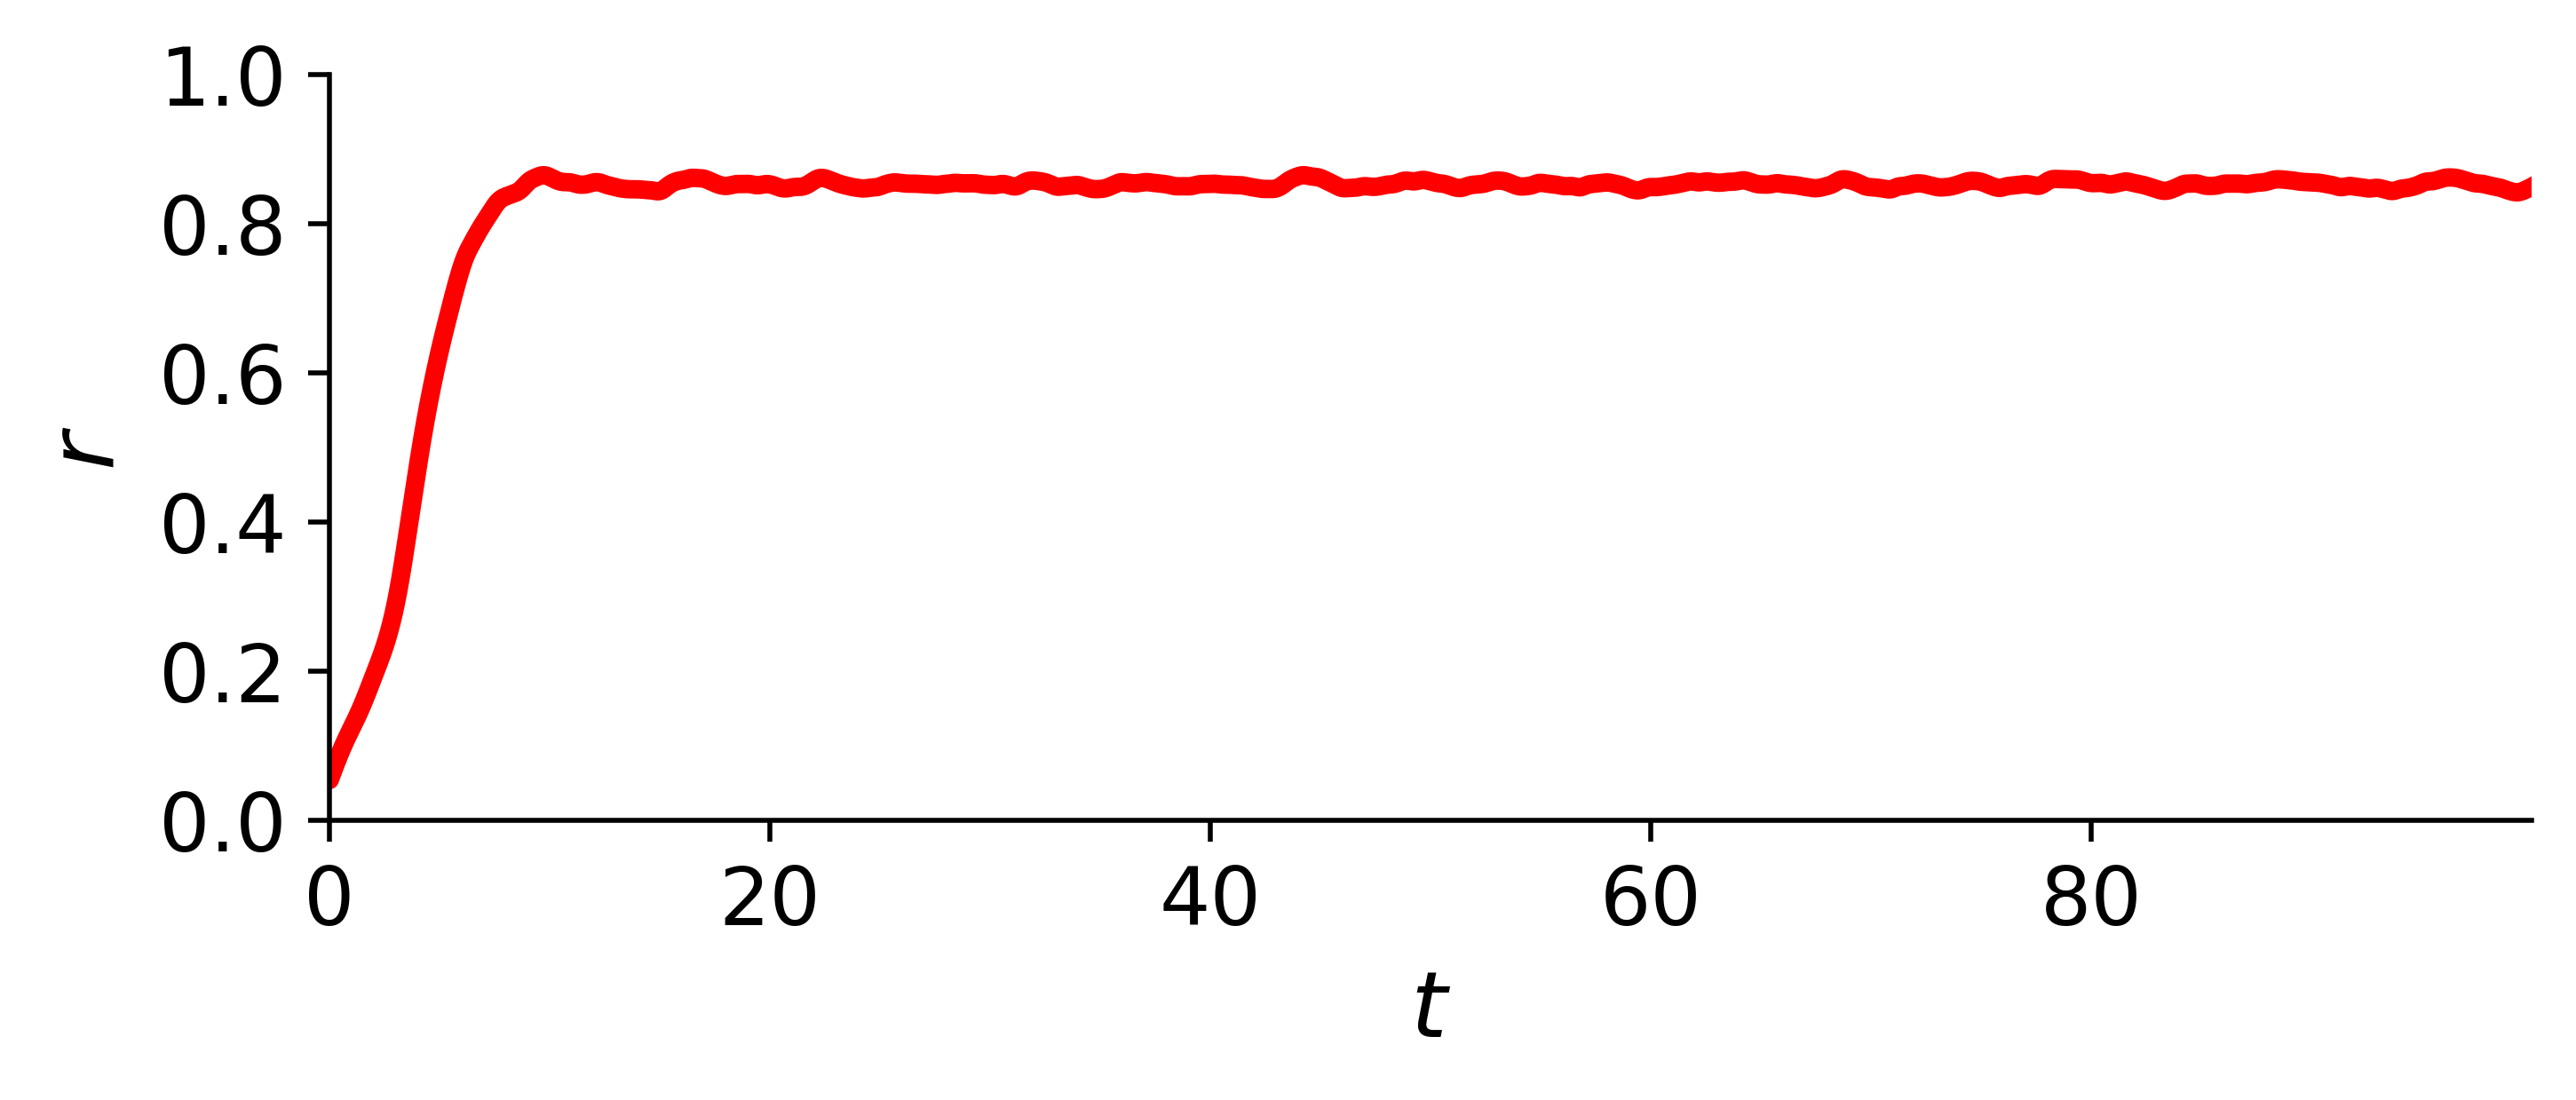

In [4]:
plt.figure(dpi=500)
plt.subplot(211)
plt.plot(t,rs,color='red',lw=3)
plt.xlim(0,t.max())
plt.ylim(0,1)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines95719571


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


## 이전 코드

In [5]:
def f(x,omega):
    x = x.copy()
    T = x[:N]
    K = x[-1]
    Ti,Tj = np.meshgrid(T,T)
    C = np.mean(np.sin(Ti-Tj),axis=1)
    dtheta = omega + K/N*np.sum(np.sin(Tj - Ti),axis=0) 
    T_new = T + dtheta*dt
    T_new = (T_new+np.pi)%(2*np.pi) -  np.pi
    return np.r_[T_new,K]

def F_j(x,omega):
    x = x.copy()
    T = x[:N]
    K = x[-1]
    F = np.eye(N+1)
    Ti,Tj = np.meshgrid(T,T)
    CC = np.cos(Tj-Ti)
    SC = np.sum(CC,axis=0)
    SS = np.sum(np.sin(Tj-Ti),axis=0)

    Dii = 1 -K*dt/N*SC
    D = np.r_[Dii,1]
    F[:-1,:-1] = K/N*dt * CC
    F[-1,:-1] = dt/N * SS
    F[:-1,-1] = dt/N * SS
    np.fill_diagonal(F,D)
    return F

def h(x):
    x = x.copy()
    T = x[:N]
    R = np.abs(np.mean(np.exp(1j*T)))
    return np.array([R])

def H_j(x):
    x = x.copy()
    H = np.zeros((1,N+1))
    T = x[:N]
    CT = np.cos(T)
    ST = np.sin(T)
    X = np.sum(CT)
    Y = np.sum(ST)
    denom = max(1/np.sqrt(N),1/(N*np.sqrt(X**2+Y**2)))
    # denom = 1/(N*np.sqrt(X**2+Y**2))
    num = -X*ST + Y*CT
    H[0,:-1] = num*denom
    return H


## 수정 코드

In [5]:
# x = [theta_1, ..., theta_N, K]
# 전역: N, dt가 정의되어 있다고 가정

def f(x, omega):
    T = x[:-1].copy()
    K = float(x[-1])
    # CCW: Ti,Tj shape (N,N); Ti[i,j]=T[i], Tj[i,j]=T[j]
    Ti, Tj = np.meshgrid(T, T, indexing="ij")

    # dθ_i/dt = ω_i + (K/N) * Σ_j sin(θ_j - θ_i)
    dtheta = omega + (K / N) * np.sum(np.sin(Tj - Ti), axis=1)  # axis=1이 i 고정
    T_new = T + dt * dtheta
    # wrap to (-pi, pi]
    T_new = (T_new + np.pi) % (2*np.pi) - np.pi
    return np.concatenate([T_new, [K]])

def F_j(x, omega):
    T = x[:-1].copy()
    K = float(x[-1])
    Ti, Tj = np.meshgrid(T, T, indexing="ij")

    CC = np.cos(Tj - Ti)  # CC[i,j] = cos(θ_j - θ_i)
    SS = np.sin(Tj - Ti)

    F = np.eye(N+1)

    # dT'/dT (Euler: I + dt * ∂(dθ)/∂T )
    # off-diagonal: (dt*K/N)*cos(θ_j - θ_i)
    F[:N, :N] = (dt * K / N) * CC

    # diagonal: 1 + dt * ∂(dθ_i)/∂θ_i
    # ∂(dθ_i)/∂θ_i = -(K/N) * Σ_j cos(θ_j - θ_i)
    diag = 1.0 - (dt * K / N) * np.sum(CC, axis=1)  # axis=1 (j합)
    np.fill_diagonal(F, np.r_[diag, 1.0])  # 마지막 K행렬 요소는 1

    # dT'/dK = dt/N * Σ_j sin(θ_j - θ_i)
    F[:N, -1] = (dt / N) * np.sum(SS, axis=1)  # axis=1 (j합)

    # dK'/dT = 0 (K는 상태전이에서 상수로 둠), dK'/dK = 1 (이미 설정)
    # !! 원래 코드의 F[-1,:-1] = ... 는 잘못됨 (0이어야 함)

    return F

def h(x):
    T = x[:-1]
    R = np.abs(np.mean(np.exp(1j * T)))  # R = |(1/N) Σ e^{iθ}|
    return np.array([R])

def H_j(x, eps=1e-9):
    T = x[:-1]
    CT = np.cos(T)
    ST = np.sin(T)
    X = np.sum(CT)
    Y = np.sum(ST)
    r = np.hypot(X, Y)  # = sqrt(X^2 + Y^2)

    H = np.zeros((1, N+1))
    # R = r / N  이므로  ∂R/∂θ_i = (-X sinθ_i + Y cosθ_i) / (N * r)
    if r >= eps:
        dR_dtheta = (-X * ST + Y * CT) / (N * r)
        H[0, :N] = dR_dtheta
    else:
        # R≈0이면 기하학적으로 미분이 불안정 → 0으로 두어 필터 발산 방지
        H[0, :N] = 0.0
    # ∂R/∂K = 0 (측정은 K에 직접 의존하지 않음)
    return H


# def H_j(x, eps=1e-9):
#     T = x[:-1]
#     c, s = np.cos(T), np.sin(T)
#     X, Y = np.mean(c), np.mean(s)        # 평균(= 1/N 합)
#     R = np.hypot(X, Y)                   # = |(1/N)∑ e^{iθ}|
#     H = np.zeros((1, len(T)+1))
#     if R >= eps:
#         # ∂R/∂θ_i = (-X*sinθ_i + Y*cosθ_i) / (N*R)
#         H[0, :len(T)] = (-X*s + Y*c) / (len(T) * R)
#     # ∂R/∂K = 0
#     return H



In [6]:
from numba import njit
import numpy as np

# (-pi,pi] 래핑
@njit(fastmath=True, cache=True)
def _wrap_angle_scalar(a):
    v = a + np.pi
    v = v - 2.0*np.pi * np.floor(v/(2.0*np.pi))
    return v - np.pi

@njit(fastmath=True, cache=True)
def f_fast_jit(x, omega, dt):
    N = omega.size
    T = x[:N]
    K = x[N]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)
    dtheta = omega + K*(Y*c - X*s)
    T_new = T + dt*dtheta
    for i in range(N):
        T_new[i] = _wrap_angle_scalar(T_new[i])
    out = np.empty_like(x)
    out[:N] = T_new
    out[N] = K
    return out

@njit(fastmath=True, cache=True)
def H_j_jit(x):
    N = x.size - 1
    T = x[:N]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)
    R = np.hypot(X, Y)
    H = np.zeros((1, N+1))
    if R > 1e-12:
        H[0, :N] = (-X*s + Y*c) / (N*R)
    return H

@njit(fastmath=True, cache=True)
def h_jit(x):
    N = x.size - 1
    T = x[:N]
    X = np.mean(np.cos(T)); Y = np.mean(np.sin(T))
    return np.array([np.hypot(X, Y)])

# d x_next / dK (K-컬럼만 뽑아서 민감도에 사용)
@njit(fastmath=True, cache=True)
def F_Kcol_jit(x, dt):
    N = x.size - 1
    T = x[:N]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)
    col = np.empty(N+1)
    col[:N] = dt*(Y*c - X*s)
    col[N]  = 1.0
    return col

# (선택) F_j를 전체 만들고 싶다면 — 기존 F_j_fast의 JIT 버전
@njit(fastmath=True, cache=True)
def F_j_fast_jit(x, dt):
    N = x.size - 1
    T = x[:N]; K = x[N]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)
    F = np.zeros((N+1, N+1))
    # rank-2 부분
    alpha = dt*K/N
    F[:N, :N] += alpha*(np.outer(c, c) + np.outer(s, s))
    # 대각 수정
    diag = 1.0 - dt*K*(X*c + Y*s)
    for i in range(N):
        F[i, i] += diag[i]
    # dT'/dK
    F[:N, N] = dt*(Y*c - X*s)
    # dK'/dK = 1
    F[N, N] = 1.0
    return F


In [7]:
def f_fast(x, omega):
    T = x[:-1]
    K = float(x[-1])
    c, s = np.cos(T), np.sin(T)
    X, Y = np.mean(c), np.mean(s)
    # dtheta_i = omega_i + K * Im(Z e^{-i theta_i})
    dtheta = omega + K * (Y*c - X*s)
    T_new = T + dt*dtheta
    T_new = (T_new + np.pi)%(2*np.pi) - np.pi
    return np.r_[T_new, K]
def F_apply(v, T, K):
    """F @ v 를 O(N)으로 계산 (F를 만들지 않음)"""
    c, s = np.cos(T), np.sin(T)
    X, Y = np.mean(c), np.mean(s)
    # row sums for diag: sum_j cos(theta_j - theta_i) = N*(X c_i + Y s_i)
    diag_corr = 1.0 - dt*K*(X*c + Y*s)           # shape (N,)
    # rank-2 part: (dt*K/N)*C @ v = (dt*K/N)*( c*(c·v) + s*(s·v) )
    alpha = dt*K/len(T)
    Cv = alpha * ( c * np.dot(c, v) + s * np.dot(s, v) )
    out = Cv.copy()
    out += (diag_corr - 0) * v                   # ‘I + diag(J_ii*dt)’ 효과 포함
    return out

def F_j_fast(x):
    T = x[:-1]
    K = float(x[-1])
    c, s = np.cos(T), np.sin(T)
    X, Y = np.mean(c), np.mean(s)

    Nn = len(T)
    F = np.zeros((Nn+1, Nn+1))
    # 오프대각/랭크-2 블록: (dt*K/N)*(c c^T + s s^T)
    alpha = dt*K/Nn
    F[:Nn,:Nn] += alpha * (np.outer(c, c) + np.outer(s, s))   # <- 메모리 아끼려면 생략하고 F_apply로 대체
    # 대각 수정: 1 - dt*K*(X c + Y s)
    np.fill_diagonal(F, np.r_[1.0 - dt*K*(X*c + Y*s), 1.0])
    # dT'/dK
    F[:Nn, -1] = dt*(Y*c - X*s)
    # dK'/dT = 0, dK'/dK = 1 (이미 대각에 1 설정)
    return F


In [8]:
import numpy as np

def run_ekf_rank1_orig(theta_random, K_init, omega, t, rs,
                       R_meas=1e-10,
                       jitterP=1e-5,     # P_bar 정칙화 (네 코드와 동일)
                       s_floor=1e-6,     # S 하한 (네 코드와 동일)
                       P_floor=1e-12,    # P_hat 요소 바닥 (네 코드와 동일)
                       delta_K_init=2.0, # 초기 K 오프셋: K_init + 2
                       add_meas_noise=True):
    """
    원본 루프를 함수로 감싼 버전 (네 코드와 '동일 동작' 목표)
    - F @ P @ F^T + Q 사용 (predict_cov_rank2 안 씀)
    - Joseph 동등식/랭크-1 다운데이트 안 씀 (네 코드와 동일)
    - S를 1x1 행렬로 두고 inv(S) 사용 (네 코드와 동일)
    - Freeze/민감도/PSD 플로어 없음 (네 코드와 동일)
    """
    N = theta_random.size
    n = N + 1
    dt = float(t[1] - t[0]) if len(t) > 1 else 1.0

    # 초기 상태: [theta..., K_init + 2]  (네 코드와 동일한 오프셋)
    x = np.r_[theta_random, float(K_init + delta_K_init)].astype(float)

    # 공정잡음 Q: 마지막에 np.eye(n)*1e-8 로 덮는 패턴을 '그대로' 반영
    Q = np.eye(n) * 1e-8

    # 초기 공분산 P: diag=1e-6, K-분산만 1e-4 (네 코드)
    P = np.eye(n) * 1e-6
    P[-1, -1] = 1e-4

    # 로그/결과 버퍼
    Tn = len(t)
    P_hats = np.zeros((Tn, n, n))
    x_hats = np.zeros((Tn, n))
    z_hats = np.zeros(Tn)
    S_s    = np.zeros(Tn)
    K_gains = []

    # 초기 기록
    x_hats[0] = x
    P_hats[0] = P
    z_hats[0] = float(h_jit(x)[0])  # h(x)[0]과 동일 의미

    for i in range(1, Tn):
        # --- 측정 생성 ---
        z_meas = float(rs[i])
        if add_meas_noise:
            z_meas += float(np.random.randn() * np.sqrt(R_meas))
        z_meas = float(np.clip(z_meas, 1e-6, 1.0))  # 네 코드: 하한 1e-6

        # --- 예측 단계 ---
        x_bar = f_fast_jit(x, omega, dt)           # 상태 예측
        F_bar = F_j_fast_jit(x_bar, dt)            # 야코비안
        P_bar = F_bar @ P @ F_bar.T + Q            # 공분산 예측
        P_bar += np.eye(n) * jitterP               # 정칙화(네 코드와 동일)

        # --- 관측 예측 ---
        H = H_j_jit(x_bar)                         # (1, n)
        z_bar = h_jit(x_bar)                       # (1,)
        S = H @ P_bar @ H.T + R_meas               # (1,1)
        S = np.where(S < s_floor, s_floor, S)      # (1,1) 유지
        S_s[i] = float(S)                          # 스칼라 로그

        # --- 칼만 이득 ---
        K_gain = P_bar @ H.T @ np.linalg.inv(S)    # (n,1)
        K_gains.append(K_gain.copy())

        # --- 상태 업데이트 ---
        # (n,1) @ (1,) -> (n,), 네 코드와 동일 브로드캐스트
        x_hat = x_bar + (K_gain @ (z_meas - z_bar)).ravel()
        x_hat[-1] = np.clip(x_hat[-1], 1e-3, 10.0) # K 범위 보호 (네 코드)

        # --- 공분산 업데이트 (simple, Joseph 아님) ---
        P_hat = P_bar - K_gain @ S @ K_gain.T

        # 요소별 바닥 (네 코드와 동일)
        P_hat = np.where(P_hat < P_floor, P_floor, P_hat)

        # 롤오버
        x = x_hat
        P = P_hat
        x_hats[i] = x
        P_hats[i] = P
        z_hats[i] = float(z_bar[0])

    return x_hats, P_hats, z_hats, S_s, K_gains


In [ ]:
x = np.r_[theta_random,K + 2]
Q = np.eye(N+1)*0
Q[-1,-1] = 1e-8
# P = np.eye(N+1)*1e-4


Q = np.eye(N+1)*1e-8
P = np.eye(N+1)*1e-6
# P +=1e-12
P[-1,-1] = 1e-4
R_meas = 1e-10


P_hats = np.zeros((len(t),*P.shape))
x_hats_KM = np.zeros((len(t),len(x)))
z_hats = np.zeros((len(t)))
S_s = np.zeros((len(t)))
x_hats_KM[0] = x
P_hats[0] = P
z_hats[0] = h(x)[0]
K_gains = []
for i in range(1,len(t)):
    z_meas = rs[i] + np.random.randn()*np.sqrt(R_meas) 
    z_meas = np.clip(z_meas,1e-6,1)
    
    x_bar = f_fast_jit(x,omega,dt)
    F_bar = F_j_fast_jit(x_bar,dt)
    P_bar = F_bar@P@F_bar.T + Q
    P_bar += np.eye(P_bar.shape[0]) * 1e-5
    # 2. EKF 예측 단계
    H = H_j_jit(x_bar)
    z_bar = h_jit(x_bar)
    S = H@P_bar@H.T + R_meas
    # S = np.maximum(S, 1e-8)
    S = np.where(S < 1e-6, 1e-6, S)
    S_s[i] =S

    K_gain = P_bar@H.T@np.linalg.inv(S)
    K_gains.append(K_gain)
    
    x_hat = x_bar + K_gain@(z_meas-z_bar)
    P_hat = P_bar - K_gain@S@K_gain.T
    
    x_hat[-1] = np.clip(x_hat[-1],1e-3,10)
    x = x_hat
    P_hat = np.where(P_hat < 1e-12, 1e-12, P_hat)
    # P_hat = np.where(P_hat > 1e12, 0, P_hat)
    P = P_hat

    x_hats_KM[i] = x
    P_hats[i] = P
    
    z_hats[i] = z_bar[0]

C:\Users\kim9y\AppData\Local\Temp\ipykernel_49580\2104564529.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_s[i] =S


In [617]:
x = np.r_[theta_random,K + 2]
Q = np.eye(N+1)*0
Q[-1,-1] = 1e-8
# P = np.eye(N+1)*1e-4


Q = np.eye(N+1)*1e-8
P = np.eye(N+1)*1e-6
# P +=1e-12
P[-1,-1] = 1e-4
R_meas = 1e-10


P_hats = np.zeros((len(t),*P.shape))
x_hats_KM = np.zeros((len(t),len(x)))
z_hats = np.zeros((len(t)))
S_s = np.zeros((len(t)))
x_hats_KM[0] = x
P_hats[0] = P
z_hats[0] = h(x)[0]
K_gains = []
for i in range(1,len(t)):
    z_meas = rs[i] + np.random.randn()*np.sqrt(R_meas) 
    z_meas = np.clip(z_meas,1e-6,1)
    
    x_bar = f(x,omega)
    F_bar = F_j(x_bar,omega)
    P_bar = F_bar@P@F_bar.T + Q
    P_bar += np.eye(P_bar.shape[0]) * 1e-5
    # 2. EKF 예측 단계
    H = H_j(x_bar)
    z_bar = h(x_bar)
    S = H@P_bar@H.T + R_meas
    # S = np.maximum(S, 1e-8)
    S = np.where(S < 1e-6, 1e-6, S)
    S_s[i] =S

    K_gain = P_bar@H.T@np.linalg.inv(S)
    K_gains.append(K_gain)
    
    x_hat = x_bar + K_gain@(z_meas-z_bar)
    P_hat = P_bar - K_gain@S@K_gain.T
    
    x_hat[-1] = np.clip(x_hat[-1],1e-3,10)
    x = x_hat
    P_hat = np.where(P_hat < 1e-12, 1e-12, P_hat)
    # P_hat = np.where(P_hat > 1e12, 0, P_hat)
    P = P_hat

    x_hats_KM[i] = x
    P_hats[i] = P
    
    z_hats[i] = z_bar[0]

C:\Users\kim9y\AppData\Local\Temp\ipykernel_49580\1570740948.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_s[i] =S


In [ ]:
x = np.r_[theta_random,K + 1]
Q = np.eye(N+1)*0
Q[-1,-1] = 1e-8
# P = np.eye(N+1)*1e-4


Q = np.eye(N+1)*1e-8
P = np.eye(N+1)*1e-6
# P +=1e-12
# P[-1,-1] = 1e-4
R_meas = 1e-10


P_hats = np.zeros((len(t),*P.shape))
x_hats_KM = np.zeros((len(t),len(x)))
z_hats = np.zeros((len(t)))
S_s = np.zeros((len(t)))
x_hats_KM[0] = x
P_hats[0] = P
z_hats[0] = h(x)[0]
K_gains = []
for i in range(1,len(t)):
    z_meas = rs[i] + np.random.randn()*np.sqrt(R_meas) 
    z_meas = np.clip(z_meas,1e-6,1)
    
    x_bar = f_fast(x,omega)
    F_bar = F_j_fast(x_bar)
    P_bar = F_bar@P@F_bar.T + Q
    P_bar += np.eye(P_bar.shape[0]) * 1e-5
    # 2. EKF 예측 단계
    H = H_j(x_bar)
    z_bar = h(x_bar)
    S = H@P_bar@H.T + R_meas
    # S = np.maximum(S, 1e-8)
    S = np.where(S < 1e-6, 1e-6, S)
    S_s[i] =S

    K_gain = P_bar@H.T@np.linalg.inv(S)
    K_gains.append(K_gain)
    
    x_hat = x_bar + K_gain@(z_meas-z_bar)
    P_hat = P_bar - K_gain@S@K_gain.T
    
    x_hat[-1] = np.clip(x_hat[-1],1e-3,10)
    x = x_hat
    P_hat = np.where(P_hat < 1e-12, 1e-12, P_hat)
    # P_hat = np.where(P_hat > 1e12, 0, P_hat)
    P = P_hat

    x_hats_KM[i] = x
    P_hats[i] = P
    
    z_hats[i] = z_bar[0]

In [636]:
# 가정: N, dt, f, F_j, h, H_j, omega, rs, t 가 이미 정의됨
# 수치 바닥
epsP  = 1e-12   # P 바닥
epsS  = 1e-10   # S 바닥
jitterP = 1e-8  # P 예측단계 정칙화

# ---- 초기화 ----
x = np.r_[theta_random, K + 2.0].astype(float)  # 상태: [theta..., K]
P = np.eye(N+1) * 1e-6
Q = np.zeros((N+1, N+1))
Q[-1, -1] =  1e-8            # K 과정잡음만 켬 (필요에 따라 조정)
R_meas = float(1e-10)       # 관측잡음 분산 (스칼라)

P_hats = np.zeros((len(t), *P.shape))
x_hats_KM = np.zeros((len(t), len(x)))
z_hats = np.zeros((len(t)))
S_s = np.zeros((len(t)))

x_hats_KM[0] = x
P_hats[0] = P
z_hats[0] = h(x)[0]
K_gains = []

# ---- (선택) K freeze/unfreeze 설정 ----
freeze = False
sigmaK_tol = 1e-4         # K 분산 문턱 (스케일에 맞게)
NIS_low, NIS_high = 0.3, 3.0
W = 50
nis_hist = []

def sensitivity_K(x_bar, H_bar, F_bar):
    # H: (1, N+1), F_Kcol: (N+1,)
    F_Kcol = F_bar[:, -1]
    return abs(float(H_bar @ F_Kcol.reshape(-1,1)))

for i in range(1, len(t)):
    # --- 측정 생성 ---
    z_meas = rs[i] + np.random.randn() * np.sqrt(R_meas)
    # 너무 강한 클리핑은 편향 유발 → 필요 시 아주 약하게만
    z_meas = np.clip(z_meas, 1e-9, 1.0)  # R은 [0,1]이므로 상한만 보호

    # --- 예측 단계 ---
    x_bar = f_fast_jit(x, omega, dt)
    F_bar = F_j_fast_jit(x_bar, dt)
    P_bar = F_bar @ P @ F_bar.T + Q
    # 수치 정칙화
    P_bar += np.eye(P_bar.shape[0]) * jitterP
    P_bar = 0.5 * (P_bar + P_bar.T)

    # --- 관측 예측 ---
    H = H_j_jit(x_bar)
    z_bar = h_jit(x_bar)
    # S: (1,1) -> scalar
    S = float(H @ P_bar @ H.T + R_meas)
    S = max(S, epsS)
    S_s[i] = S

    # 혁신
    nu = float(z_meas - z_bar)  # scalar

    # 칼만 이득 (N+1,1)처럼 쓰되, 연산은 스칼라로
    K_gain = (P_bar @ H.T) / S  # shape: (N+1,1)
    K_gains.append(K_gain.copy())

    # ---- (선택) K freeze/unfreeze 판단 ----
    # NIS
    q = (nu * nu) / S
    nis_hist.append(q)
    if len(nis_hist) > W:
        nis_hist.pop(0)
    q_mean = np.mean(nis_hist)

    # 민감도
    sK = sensitivity_K(x_bar, H, F_bar)

    if not freeze:
        if (P_bar[-1, -1] < sigmaK_tol) and (NIS_low <= q_mean <= NIS_high) and (sK < 1e-4):
            freeze = True
    else:
        if (q_mean > NIS_high) or (sK >= 1e-4):
            freeze = False

    # --- 업데이트 ---
    if freeze:
        # K 이득 제거 → K는 업데이트에서 고정
        K_gain[-1, :] = 0.0

    # 상태 업데이트
    x_hat = x_bar + (K_gain * nu).ravel()






    # 공분산 업데이트 (Joseph 형식)
    I = np.eye(N+1)
    KH = K_gain @ H               # (N+1, N+1) rank-1
    P_hat = (I - KH) @ P_bar @ (I - KH).T + (K_gain * R_meas) @ K_gain.T

    # 수치 안정
    P_hat = 0.5 * (P_hat + P_hat.T)
    # eigen/SVD floor


    
    u, s, vt = np.linalg.svd(P_hat)
    s = np.maximum(s, epsP)
    P_hat = (u * s) @ vt

    # K 범위 보호 (선택)
    x_hat[-1] = np.clip(x_hat[-1], 1e-3, 10.0)

    # 다음 스텝으로
    x = x_hat
    P = P_hat

    x_hats_KM[i] = x
    P_hats[i] = P
    z_hats[i] = z_bar


C:\Users\kim9y\AppData\Local\Temp\ipykernel_49580\2653400344.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S = float(H @ P_bar @ H.T + R_meas)
C:\Users\kim9y\AppData\Local\Temp\ipykernel_49580\2653400344.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nu = float(z_meas - z_bar)  # scalar
C:\Users\kim9y\AppData\Local\Temp\ipykernel_49580\2653400344.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return abs(float(H_bar @ F_Kcol.reshape(-1,1)))
C:\Use

In [ ]:
# x = np.r_[theta_random,K +5]
# Q = np.eye(N+1)*0
# P = np.eye(N+1)*0.01
# Q[-1,-1] = 0.0
# R_meas = 1e-5
# P_hats = np.zeros((len(t),*P.shape))
# x_hats = np.zeros((len(t),len(x)))
# z_hats = np.zeros((len(t)))
# S_s = np.zeros((len(t)))
# x_hats[0] = x
# P_hats[0] = P
# z_hats[0] = h(x)[0]

# for i in range(1,len(t)):
#     z_meas = rs[i] + np.random.randn()*R_meas 
#     x_bar = f(x,omega)
#     F_bar = F_j(x_bar,omega)
#     P_bar = F_bar@P@F_bar.T + Q
#     P_bar += np.eye(P_bar.shape[0]) * 1e-7
#     # 2. EKF 예측 단계
#     H = H_j(x_bar)
#     z_bar = h(x_bar)
#     S = H@P_bar@H.T + R_meas
#     S_s[i] =S

#     K_gain = P_bar@H.T@np.linalg.inv(S)
#     x_hat = x_bar + K_gain@(z_meas-z_bar)
#     P_hat = P_bar - K_gain@S@K_gain.T

#     x = x_hat
#     P = P_hat

#     x_hats[i] = x
#     P_hats[i] = P
#     z_hats[i] = z_bar[0]
# K_estm = np.mean(x_hats[-500:,-1]) 
# r_estm = np.mean(z_hats[-500:]) 

C:\Users\kim9y\AppData\Local\Temp\ipykernel_49580\237122619.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_s[i] =S


In [9]:
# === Optimized EKF for Kuramoto + K tracking (single script) ===
import numpy as np

# ---- (optional) numba JIT ---------------------------------------------------
try:
    from numba import njit
except Exception:
    def njit(*args, **kwargs):
        def deco(fn): return fn
        return deco

# ---- angle & order helpers ---------------------------------------------------
@njit(fastmath=True, cache=True)
def _wrap_angle_scalar(a):
    v = a + np.pi
    v = v - 2.0*np.pi * np.floor(v/(2.0*np.pi))
    return v - np.pi

@njit(fastmath=True, cache=True)
def _order_params(T):
    csum = 0.0
    ssum = 0.0
    N = T.size
    for i in range(N):
        csum += np.cos(T[i])
        ssum += np.sin(T[i])
    invN = 1.0 / N
    return csum*invN, ssum*invN  # X, Y

# ---- models (JIT) ------------------------------------------------------------
@njit(fastmath=True, cache=True)
def f_fast_jit(x, omega, dt):
    """x=[theta..., K]; dθ = ω + K (Y cosθ - X sinθ)"""
    N = omega.size
    T = x[:N]
    K = x[N]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)
    dtheta = omega + K*(Y*c - X*s)
    Tn = T + dt*dtheta
    for i in range(N):
        Tn[i] = _wrap_angle_scalar(Tn[i])
    out = np.empty_like(x)
    out[:N] = Tn
    out[N]  = K
    return out

@njit(fastmath=True, cache=True)
def H_j_jit(x):
    """H = dR/dx, shape (1, N+1); dR/dK=0"""
    N = x.size - 1
    T = x[:N]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)
    R = np.hypot(X, Y)
    H = np.zeros((1, N+1))
    if R > 1e-12:
        H[0, :N] = (-X*s + Y*c) / (N * R)
    return H

@njit(fastmath=True, cache=True)
def h_jit(x):
    """z = R = |(1/N)Σ e^{iθ}|"""
    N = x.size - 1
    T = x[:N]
    X = np.mean(np.cos(T)); Y = np.mean(np.sin(T))
    return np.array([np.hypot(X, Y)])

@njit(fastmath=True, cache=True)
def F_Kcol_jit(x, dt):
    """∂x_next/∂K column for sensitivity (no full F needed)."""
    N = x.size - 1
    T = x[:N]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)
    col = np.empty(N+1)
    col[:N] = dt*(Y*c - X*s)  # dT'/dK
    col[N]  = 1.0             # dK'/dK
    return col

# ---- fast predict: P_bar = F P F^T via rank-2 structure ----------------------
def predict_cov_rank2(P, x_bar, dt, Q):
    """
    Compute P_bar = F P F^T + Q without forming F.
    Uses F_theta,theta = diag(d) + α (c c^T + s s^T), and dT/dK = b.
    Works best when Q has only K-noise; still correct for general Q by +Q at end.
    """
    n = P.shape[0]; N = n - 1
    T = x_bar[:N]; Kval = x_bar[-1]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)

    alpha = dt * Kval / N
    d = 1.0 - dt*Kval*(X*c + Y*s)     # (N,)
    b = dt*(Y*c - X*s)                 # (N,)

    Ptt = P[:N, :N]
    Ptk = P[:N, -1]
    Pkk = P[-1, -1]

    vc = Ptt @ c
    vs = Ptt @ s
    ScC = float(c @ vc)                # c^T P c
    SsS = float(s @ vs)                # s^T P s
    ScS = float(c @ vs)                # c^T P s

    # A P A^T on θ-θ block
    DP  = d[:, None] * Ptt
    DPD = DP * d[None, :]

    w1 = (d * vc)[:, None] @ c[None, :]
    w2 = (d * vs)[:, None] @ s[None, :]
    u1 = c[:, None] @ ((vc * d)[None, :])
    u2 = s[:, None] @ ((vs * d)[None, :])

    term_cc = ScC * (c[:, None] @ c[None, :])
    term_ss = SsS * (s[:, None] @ s[None, :])
    term_cs = ScS * (c[:, None] @ s[None, :] + s[:, None] @ c[None, :])

    A_P_A = DPD + alpha*(w1 + w2 + u1 + u2) + (alpha**2)*(term_cc + term_ss + term_cs)

    # cross terms with K
    cp = float(c @ Ptk); sp = float(s @ Ptk)
    Ap = d * Ptk + alpha*(cp*c + sp*s)            # A p_{θK}
    A_P_A += Ap[:, None] @ b[None, :] + b[:, None] @ Ap[None, :] + Pkk * (b[:, None] @ b[None, :])

    # assemble full P_bar
    P_bar = np.empty_like(P)
    top_right = Ap + Pkk * b
    P_bar[:N, :N] = A_P_A
    P_bar[:N, -1] = top_right
    P_bar[-1, :N] = top_right
    P_bar[-1, -1] = Pkk

    # add process noise
    P_bar += Q
    return P_bar

# ==== EKF loop (rank-1 Joseph, freeze/unfreeze, periodic PSD floor) ===========
def run_ekf_rank1_fast(theta_random, K_init, omega, t, rs,
                       R_meas=1e-10, Q_K=1e-8,
                       epsP=1e-12, epsS=1e-10, jitterP=1e-8,
                       sigmaK_tol=1e-4, NIS_low=0.3, NIS_high=3.0,
                       sens_tol=1e-4, W=50, eig_every=20):
    N = theta_random.size
    dt = float(t[1]-t[0]) if len(t) > 1 else 1.0
    n = N + 1

    # init state & cov
    x = np.r_[theta_random, float(K_init)].astype(float)
    x[:N] = (x[:N] + np.pi) % (2*np.pi) - np.pi
    P = np.eye(n) * 1e-6
    P[-1, -1] = 1e-4  # K init variance (optional tuning)

    Q = np.zeros((n, n)); Q[-1, -1] = Q_K

    Tn = len(t)
    x_hats = np.zeros((Tn, n))
    P_hats = np.zeros((Tn, n, n))
    z_hats = np.zeros(Tn)
    S_s    = np.zeros(Tn)

    x_hats[0] = x
    P_hats[0] = P
    z_hats[0] = h_jit(x)[0]

    freeze = False
    nis_hist = []

    for i in range(1, Tn):
        z_meas = float(np.clip(rs[i] + np.random.randn()*np.sqrt(R_meas), 1e-9, 1.0))

        # ---- predict (state) ----
        x_bar = f_fast_jit(x, omega, dt)

        # ---- predict (cov) : fast rank-2 ----
        P_bar = predict_cov_rank2(P, x_bar, dt, Q)
        P_bar += np.eye(n) * jitterP
        P_bar = 0.5 * (P_bar + P_bar.T)

        # ---- measurement prediction ----
        H = H_j_jit(x_bar)             # (1, n)
        z_bar = float(h_jit(x_bar)[0])
        v = P_bar @ H.T                # (n, 1)
        S = float(H @ v + R_meas)      # scalar
        if S < epsS: S = epsS
        S_s[i] = S

        # ---- gain & innovation ----
        K_gain = v / S                  # (n,1)
        nu = float(z_meas - z_bar)

        # ---- freeze logic (P_KK small + NIS normal + sensitivity small) ----
        q = (nu*nu)/S
        nis_hist.append(q)
        if len(nis_hist) > W: nis_hist.pop(0)
        q_mean = float(np.mean(nis_hist))

        F_Kcol = F_Kcol_jit(x_bar, dt) # (n,)
        sK = float(H @ F_Kcol.reshape(-1,1))

        if not freeze:
            if (P_bar[-1, -1] < sigmaK_tol) and (NIS_low <= q_mean <= NIS_high) and (abs(sK) < sens_tol):
                freeze = True
        else:
            if (q_mean > NIS_high) or (abs(sK) >= sens_tol):
                freeze = False

        if freeze:
            K_gain[-1, 0] = 0.0

        # ---- state update ----
        x_hat = x_bar + (K_gain[:, 0] * nu)
        x_hat[:N] = (x_hat[:N] + np.pi) % (2*np.pi) - np.pi
        x_hat[-1] = np.clip(x_hat[-1], 1e-3, 10.0)

        # ---- covariance update (rank-1 Joseph-equivalent) ----
        # P_hat = P_bar - (v v^T) / S, where v = P_bar H^T
        P_hat = P_bar - (v @ v.T) / S
        P_hat = 0.5 * (P_hat + P_hat.T)

        # ---- periodic PSD floor ----
        if (i % eig_every) == 0:
            w, V = np.linalg.eigh(P_hat)
            if w.min() < epsP:
                w = np.maximum(w, epsP)
                P_hat = V @ (w[:, None] * V.T)

        # roll
        x, P = x_hat, P_hat
        x_hats[i] = x
        P_hats[i] = P
        z_hats[i] = z_bar

    return x_hats, P_hats, z_hats, S_s

# ===================== USAGE EXAMPLE =====================
# 준비물: theta_random(N,), K (초기 K 추정), omega(N,), t(T,), rs(T,)
# x_hats, P_hats, z_hats, S_s = run_ekf_rank1_fast(
#     theta_random=theta_random,
#     K_init=K + 2.0,
#     omega=omega,
#     t=t,
#     rs=rs,
#     R_meas=1e-10,
#     Q_K=1e-8,
#     epsP=1e-12, epsS=1e-10, jitterP=1e-8,
#     sigmaK_tol=1e-4, NIS_low=0.3, NIS_high=3.0,
#     sens_tol=1e-4, W=50, eig_every=20
# )
# K_est = x_hats[:, -1]
# R_pred = z_hats


(array([ 7.,  4.,  2., 10.,  7.,  8.,  2.,  4.,  2.,  4.]),
 array([-3.07514142, -2.45706073, -1.83898005, -1.22089937, -0.60281869,
         0.015262  ,  0.63334268,  1.25142336,  1.86950404,  2.48758473,
         3.10566541]),
 <BarContainer object of 10 artists>)

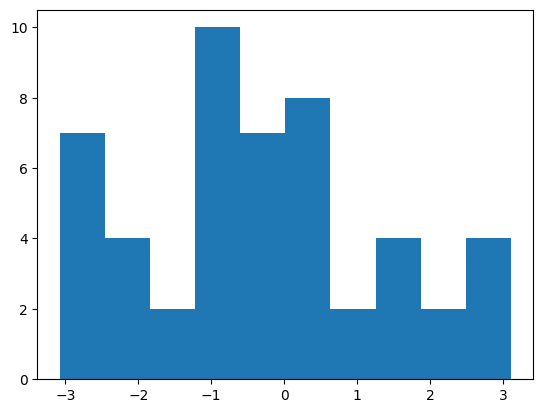

In [11]:
plt.hist(theta_random)

## simulation and check EKF

In [48]:
seed = None
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)


# theta_random = np.ones(N)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.01
t = np.arange(0,100,dt)
K = 1.4
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)

In [49]:
theta_random = np.random.uniform(0,2*np.pi,N)

In [62]:
x_hats, P_hats, z_hats, S_s,_ = run_ekf_rank1_orig(
    theta_random, 
    K_init=K + 2.0,
    omega=omega,
    t=t,
    rs=rs,
    R_meas=1e-10,
    jitterP=1e-5,     # P_bar 정칙화 (네 코드와 동일)
    s_floor=1e-6,     # S 하한 (네 코드와 동일)
    P_floor=1e-12,    # P_hat 요소 바닥 (네 코드와 동일)
    delta_K_init=2.0, # 초기 K 오프셋: K_init + 2
    add_meas_noise=True)

K_est_orig = x_hats[:, -1]
R_pred_orig = z_hats
print(np.mean(np.abs(K_est_orig - K)[-100:]))


/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_5661/2425408613.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_s[i] = float(S)                          # 스칼라 로그


0.3726295204159056


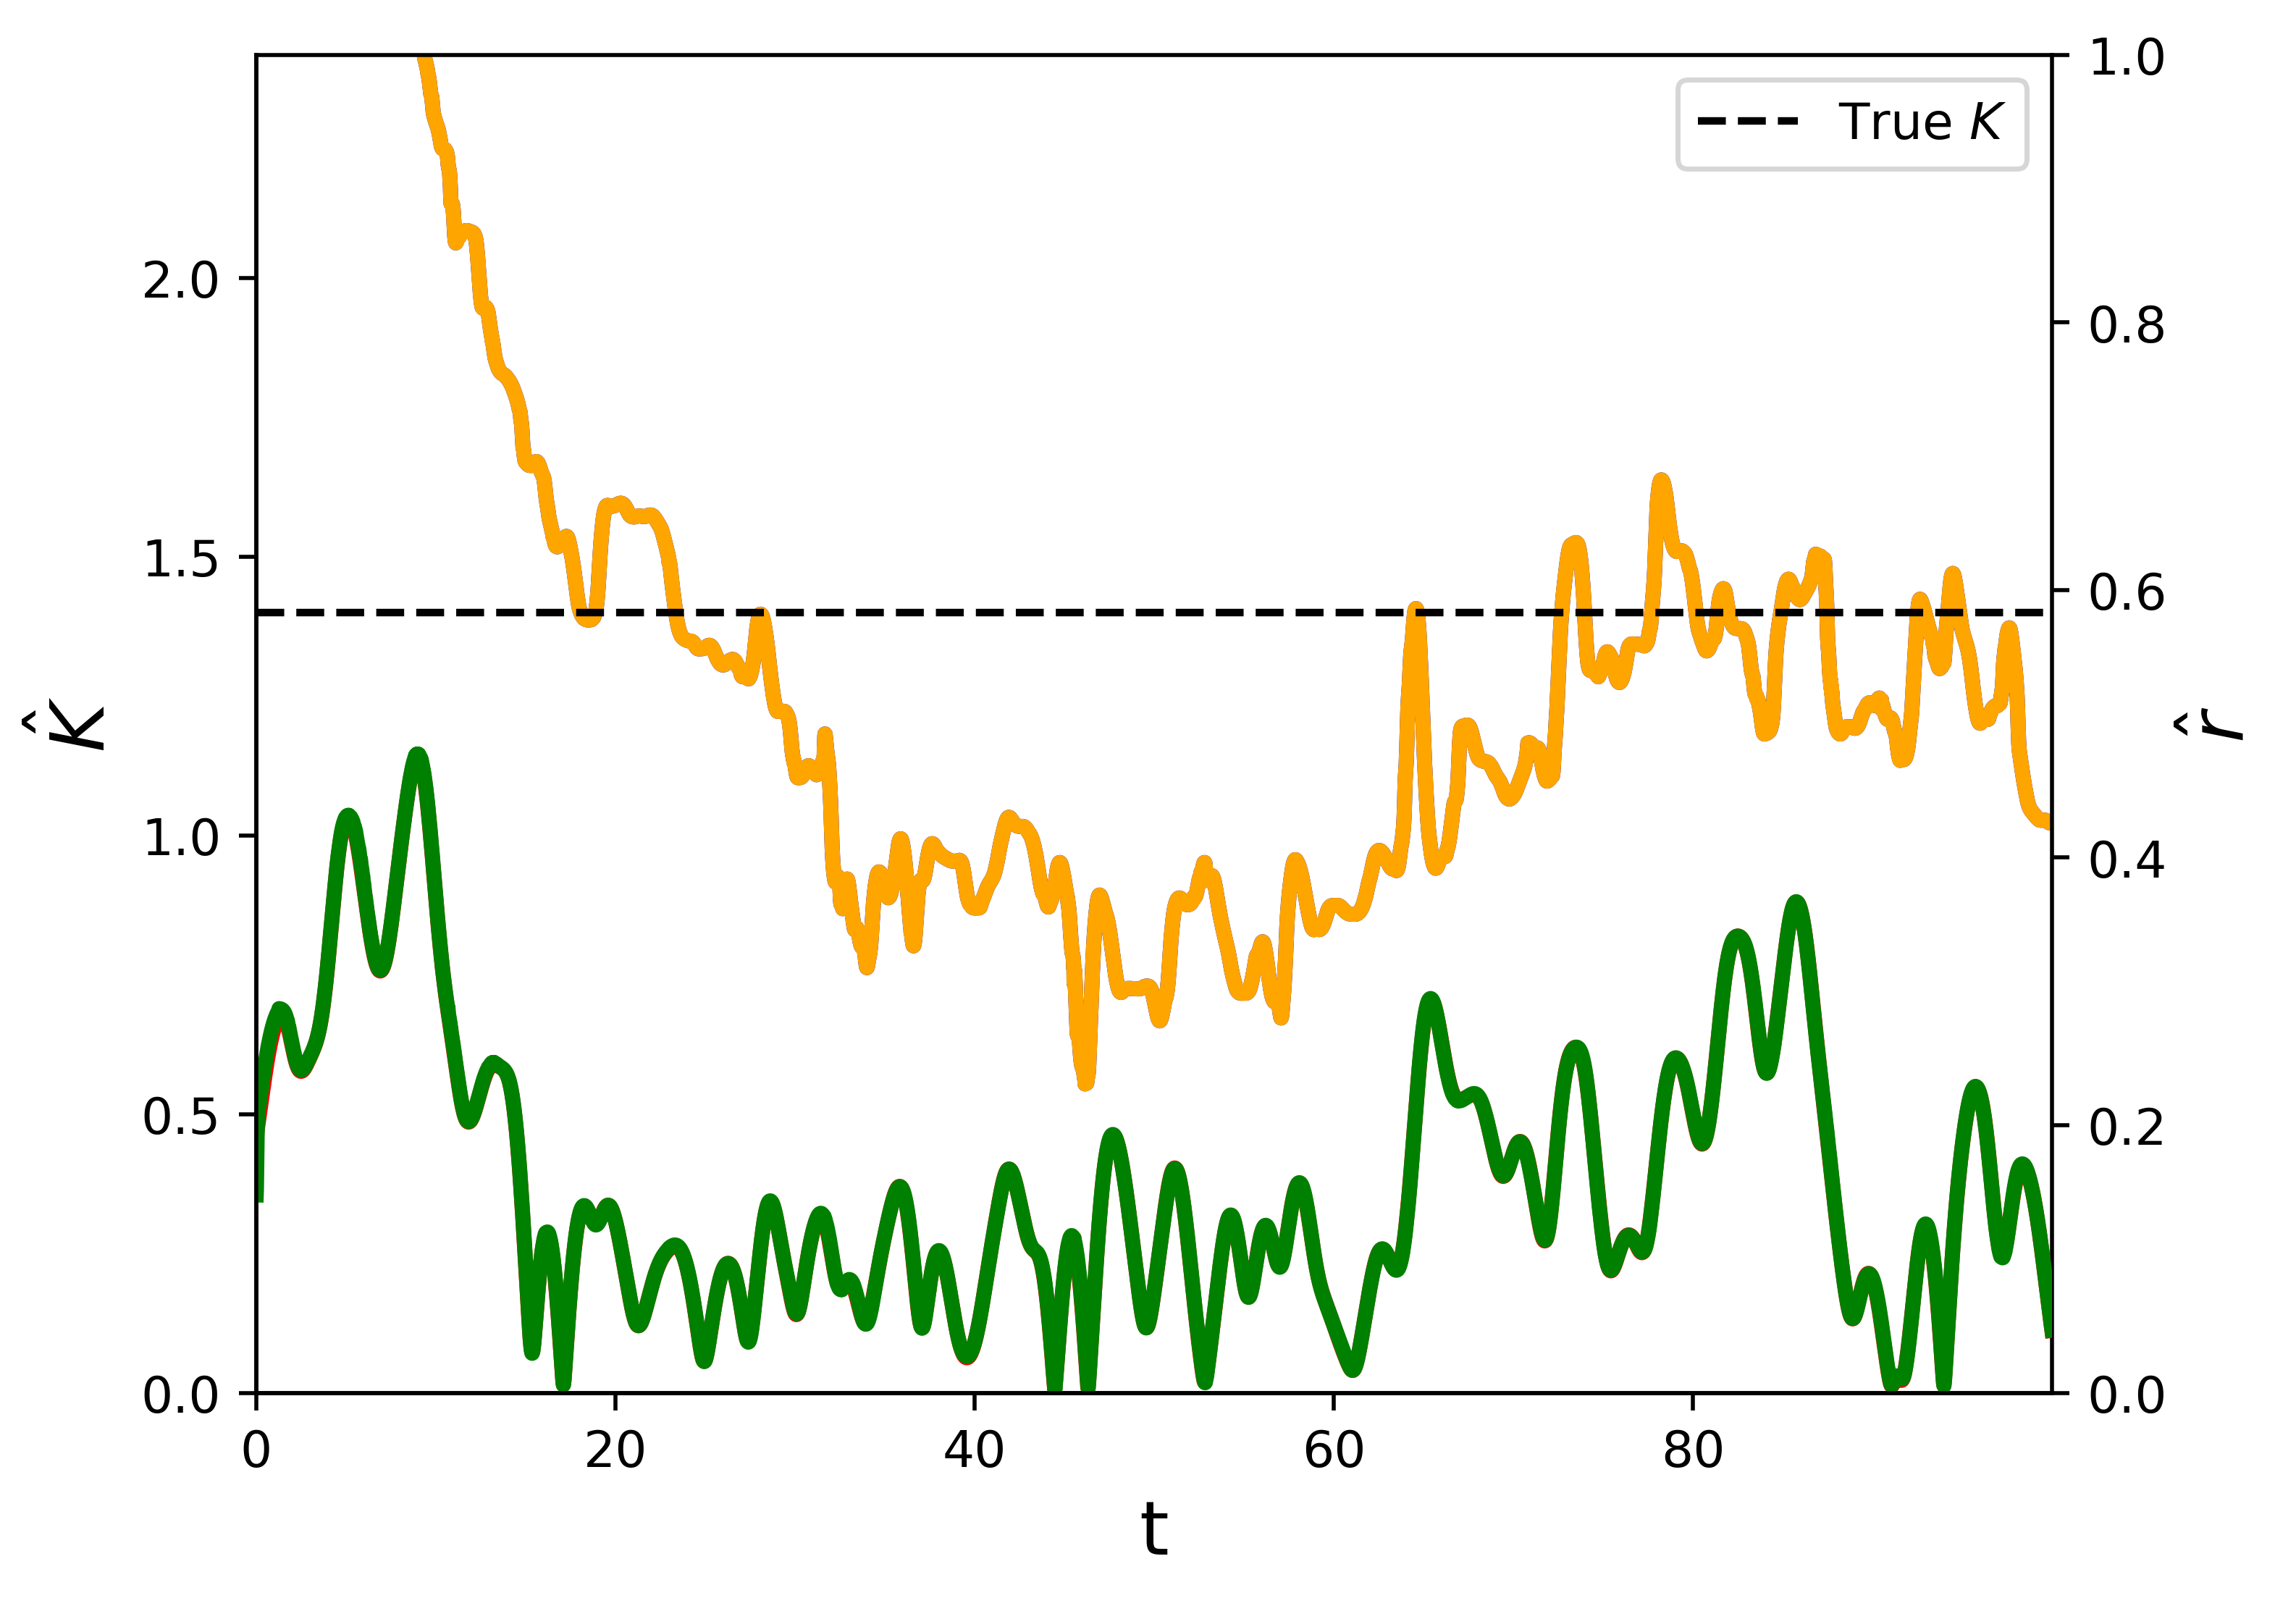

In [63]:
plt.figure(dpi=500)
plt.plot(t,x_hats[:,-1],color='blue',lw=3)
plt.plot(t,K_est_orig,color='orange',lw=3)
plt.axhline(K,color='black',ls='--',label=r'True ${K}$')
plt.ylim(0,K+1)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,t.max())
plt.legend()

plt.twinx()
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,z_hats,color='green',lw=3)
plt.ylabel(r'$\hat{r}$',fontsize=15)
plt.ylim(0,1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_5661/807902518.py:185: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S = float(H @ v + R_meas)      # scalar
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_5661/807902518.py:200: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sK = float(H @ F_Kcol.reshape(-1,1))


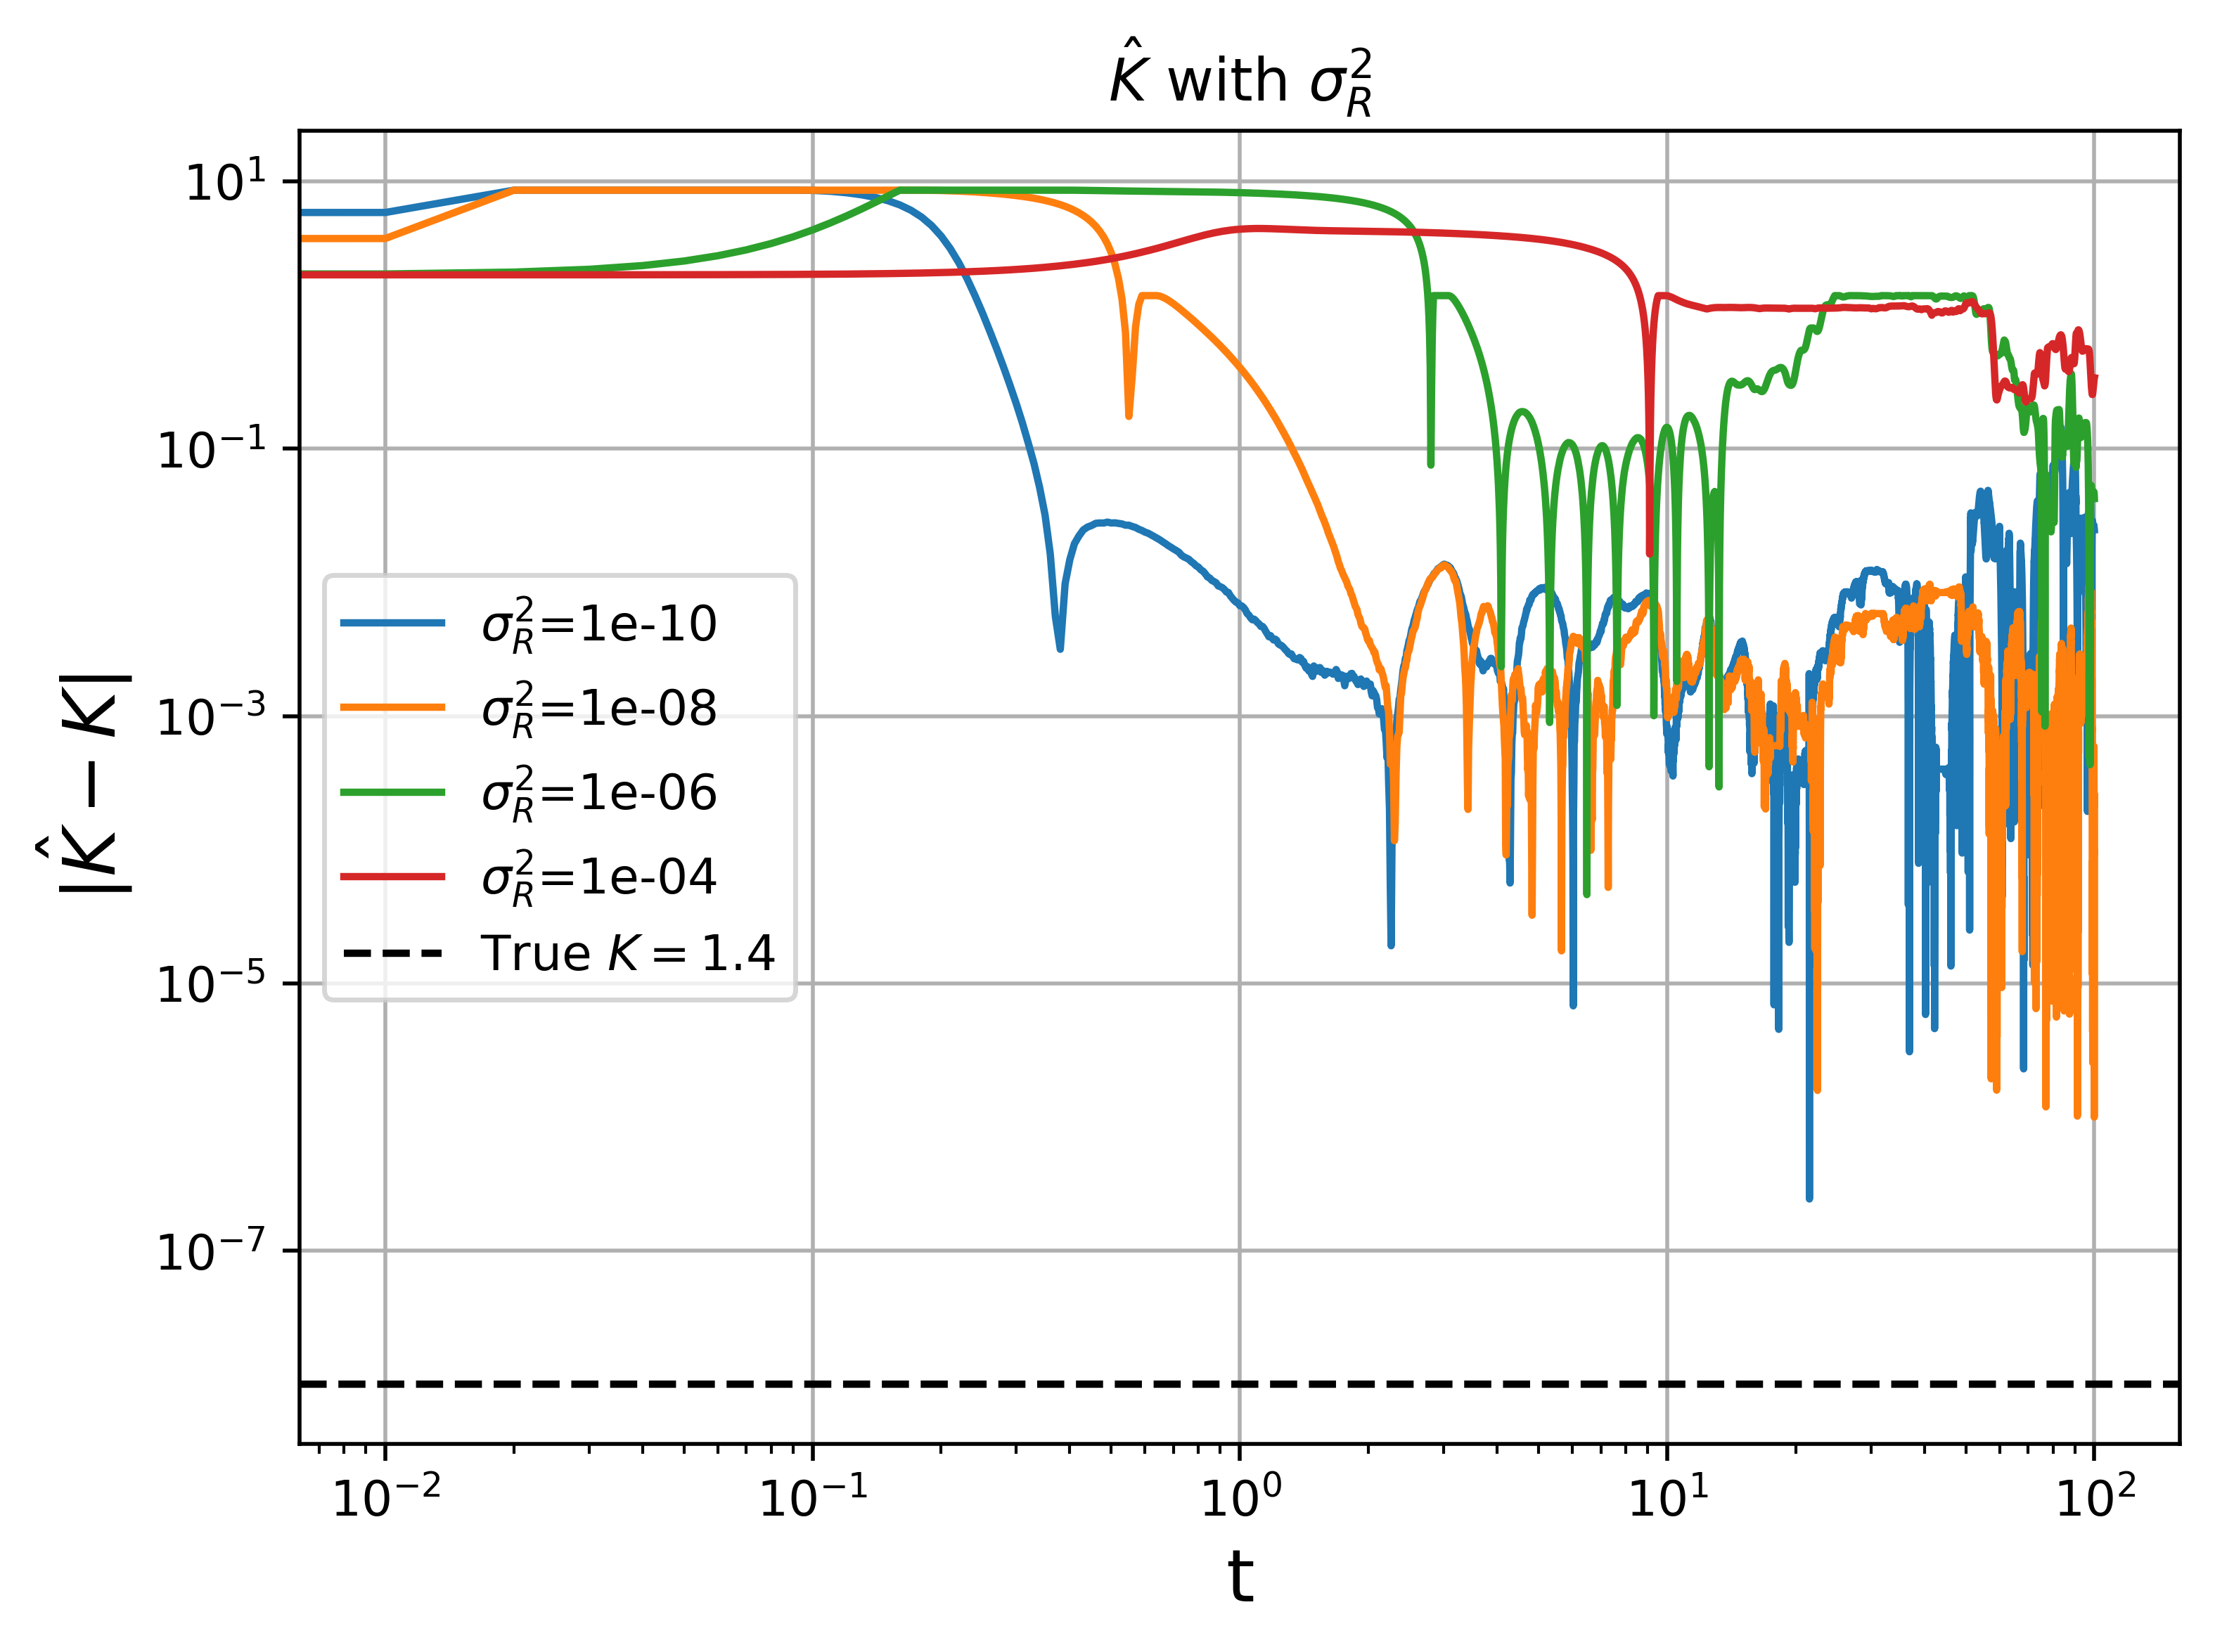

In [42]:
# 여러 R_meas 값에 대해 EKF를 돌리고, K 추정치의 추이를 그래프로 비교
plt.figure(dpi=500)
R_meas_list = [1e-10, 1e-8, 1e-6, 1e-4]
K_est_dict = {}
for Rm in R_meas_list:
    x_hats_tmp, _, _, _ = run_ekf_rank1_fast(
        theta_random=theta_random,
        K_init=K + 2.0,
        omega=omega,
        t=t,
        rs=rs,
        R_meas=Rm,
        Q_K=1e-8,
        epsP=1e-12, epsS=1e-10, jitterP=1e-8,
        sigmaK_tol=1e-4, NIS_low=0.3, NIS_high=3.0,
        sens_tol=1e-4, W=50, eig_every=20
    )
    K_est_dict[Rm] = x_hats_tmp[:, -1]

for Rm in R_meas_list:
    plt.plot(t, np.abs(K_est_dict[Rm]-K), label=fr'$\sigma_R^2$={Rm:.0e}')
plt.axhline(1e-8, color='black', ls='--', label=rf'True $K = {K}$')
plt.xlabel('t', fontsize=15)
plt.ylabel(r'$|\hat{K} - K|$', fontsize=15)
plt.title(r'$\hat{K}$ with $\sigma_{R}^2$')
plt.legend()
plt.loglog()
plt.grid()
plt.tight_layout()
plt.show()


In [13]:
x_hats, P_hats, z_hats, S_s = run_ekf_rank1_fast(
    theta_random=theta_random,
    K_init=K + 2.0,
    omega=omega,
    t=t,
    rs=rs,
    R_meas=1e-10,
    Q_K=1e-8,
    epsP=1e-12, epsS=1e-10, jitterP=1e-8,
    sigmaK_tol=1e-4, NIS_low=0.3, NIS_high=3.0,
    sens_tol=1e-4, W=50, eig_every=20
)
K_est = x_hats[:, -1]
R_pred = z_hats
print(np.mean(np.abs(K_est - K)[-100:]))

C:\Users\kim9y\AppData\Local\Temp\ipykernel_14564\807902518.py:185: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S = float(H @ v + R_meas)      # scalar
C:\Users\kim9y\AppData\Local\Temp\ipykernel_14564\807902518.py:200: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sK = float(H @ F_Kcol.reshape(-1,1))


0.004998077474306188


NameError: name 'K_est_orig' is not defined

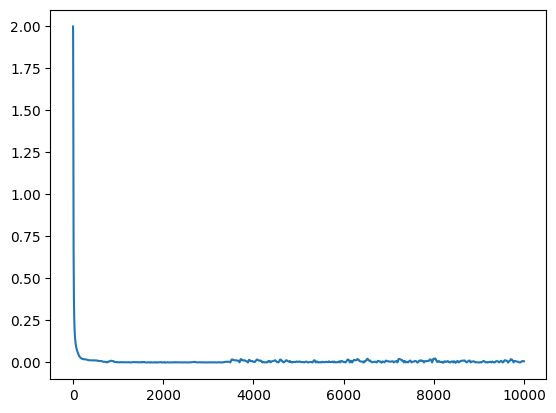

In [14]:
plt.plot(np.abs(K_est - K))
plt.plot(np.abs(K_est_orig - K))
plt.ylabel(r'$|\hat{K} - K|$',fontsize=15)
plt.xlabel(r'$t$',fontsize=15)
# plt.ylim(1e-20,2)
plt.loglog()
plt.show()

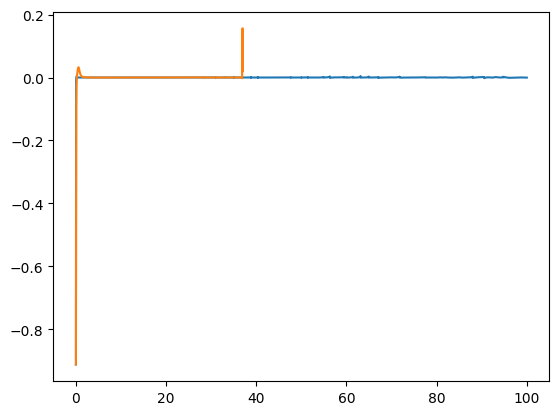

In [45]:

plt.plot(t,R_pred-rs)
plt.plot(t,R_pred_orig-rs)
plt.show()

NameError: name 'K_est_orig' is not defined

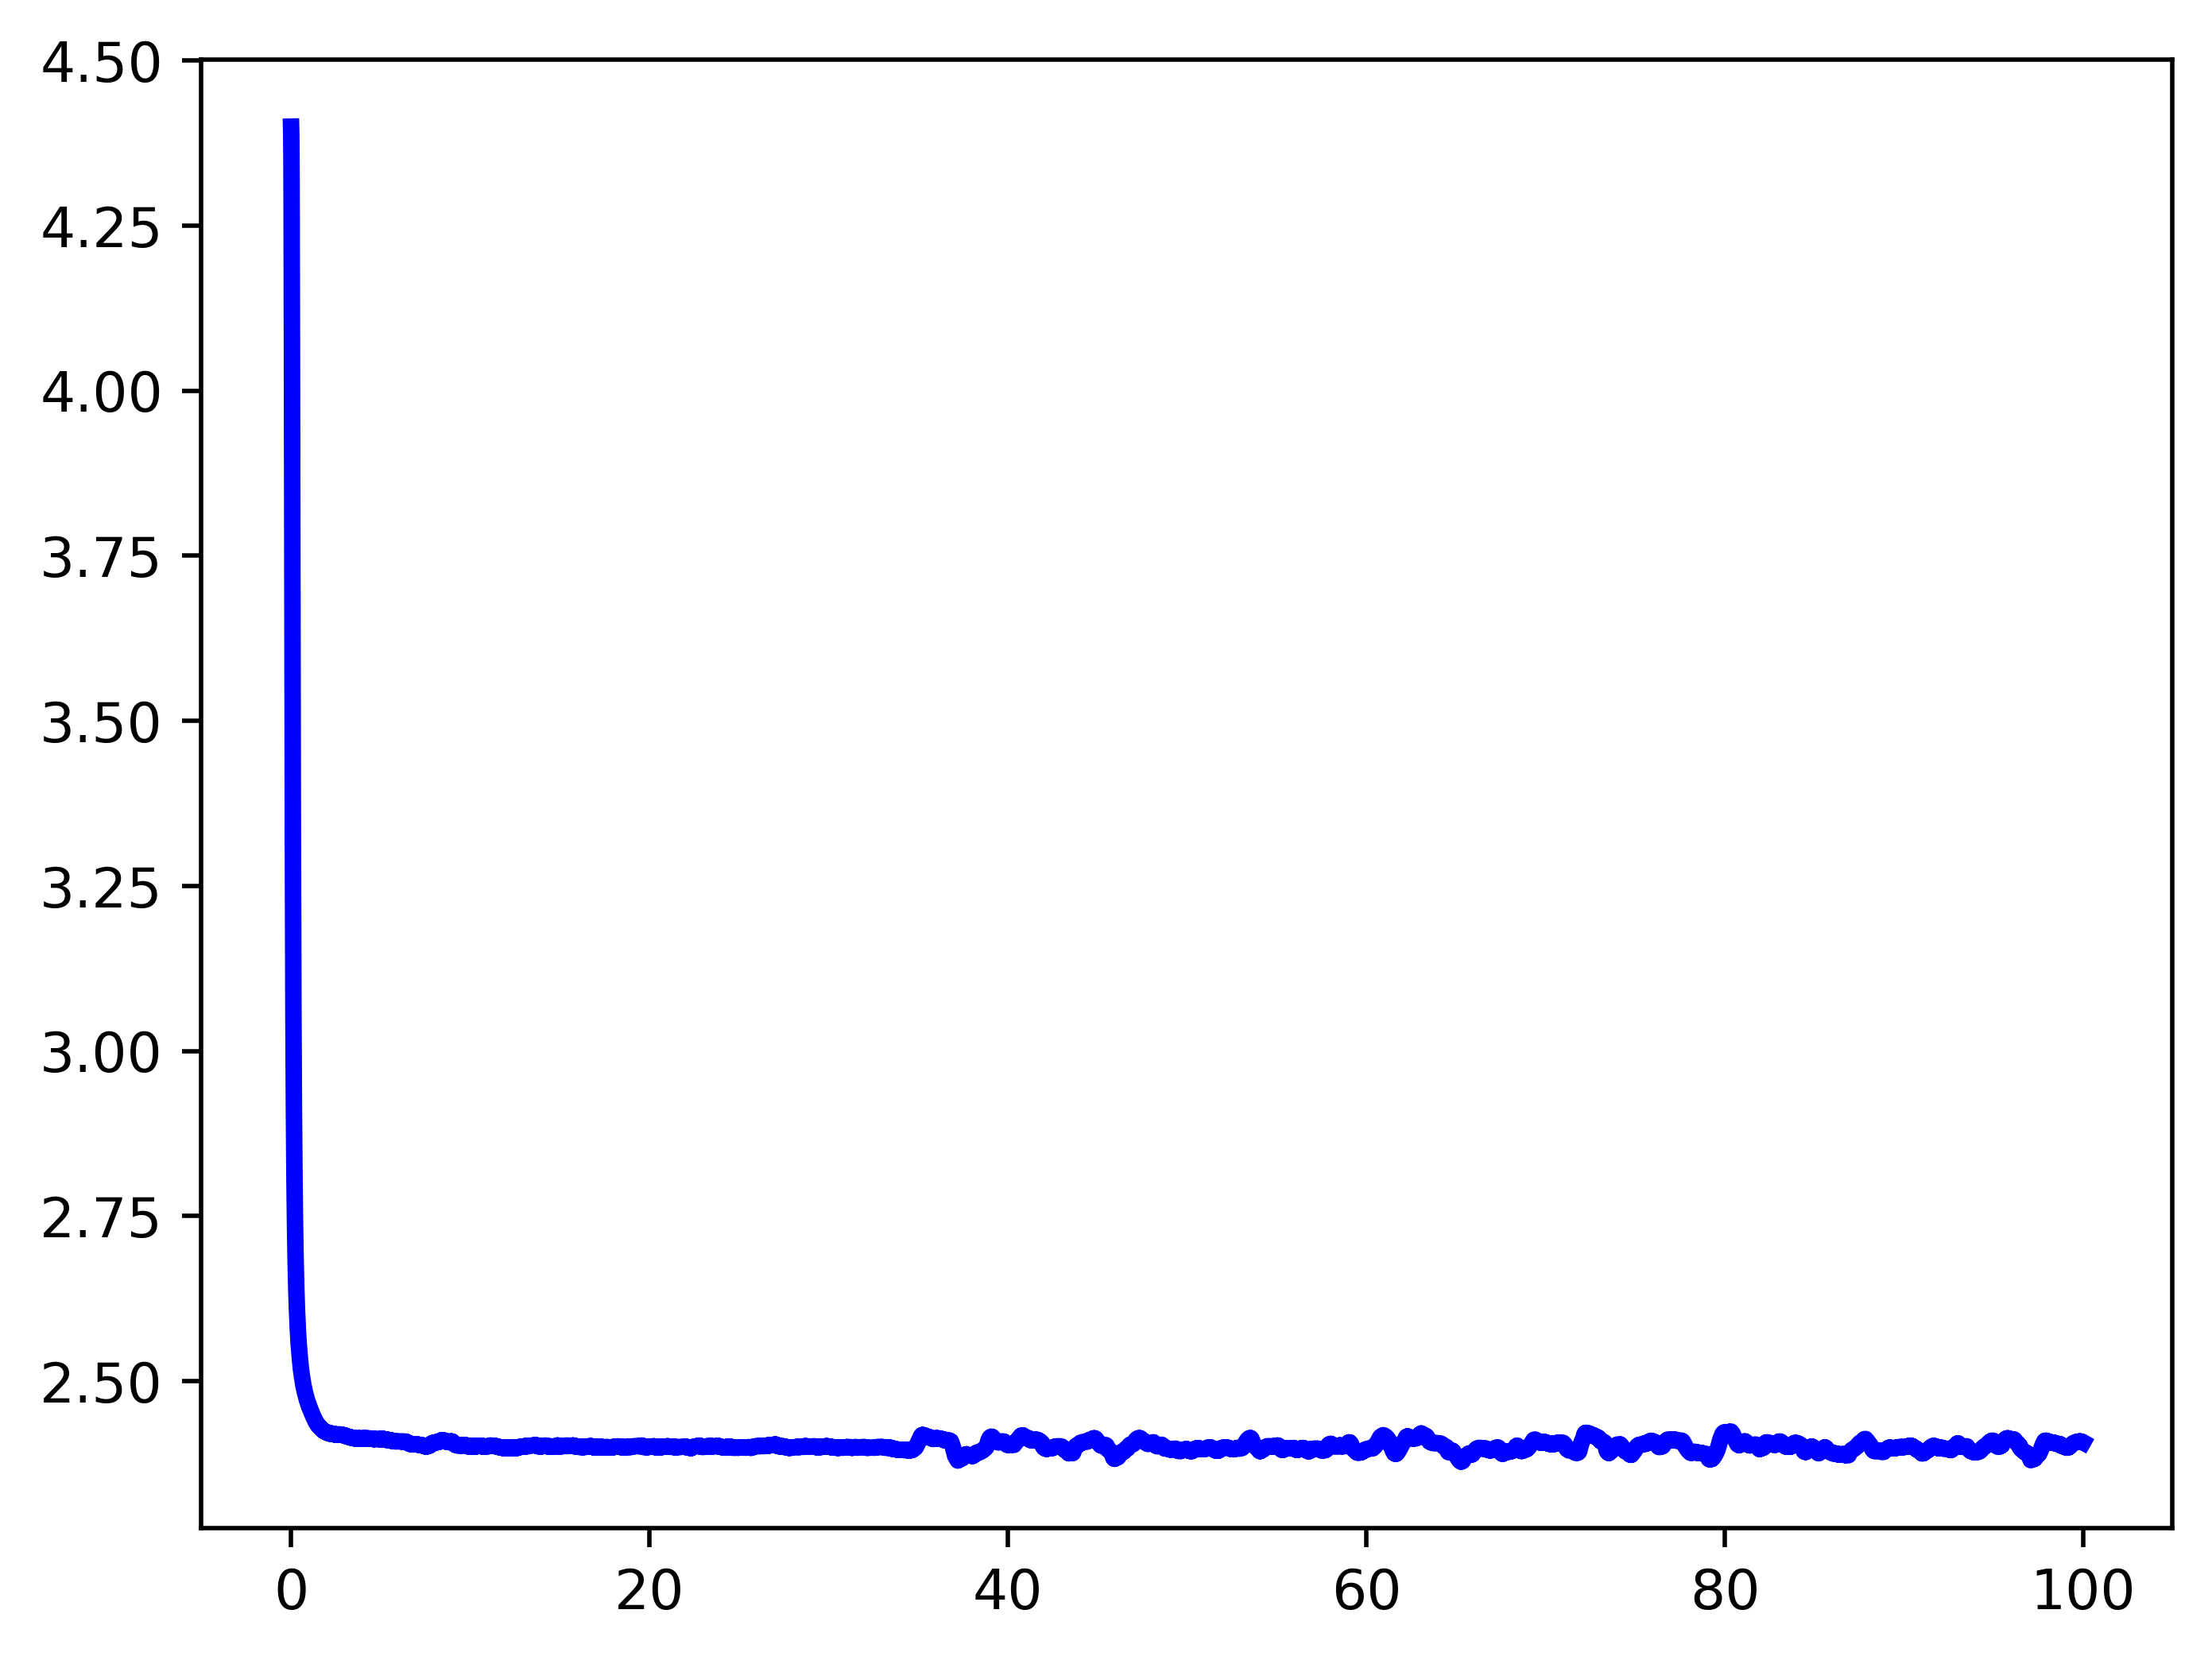

In [15]:
plt.figure(dpi=500)
plt.plot(t,x_hats[:,-1],color='blue',lw=3)
plt.plot(t,K_est_orig,color='orange',lw=3)
plt.axhline(K,color='black',ls='--',label=r'True ${K}$')
plt.ylim(0,K+1)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,t.max())
plt.legend()

plt.twinx()
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,z_hats,color='green',lw=3)
plt.ylabel(r'$\hat{r}$',fontsize=15)
plt.ylim(0,1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [31]:
theta = (theta+np.pi)%(2*np.pi) - np.pi

Text(0.5, 0, '$t$')

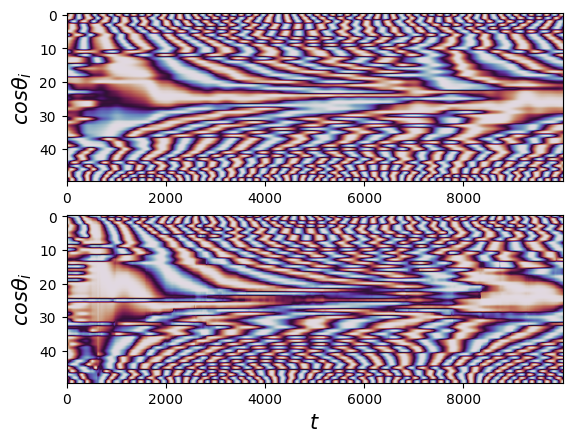

In [32]:
plt.subplot(211)
plt.imshow(np.cos(theta).T,cmap='twilight')
plt.gca().set_aspect('auto')
plt.ylabel(r'$cos\theta_i$',fontsize=15)

plt.subplot(212)
plt.imshow(np.cos(x_hats[:,:N]).T,cmap='twilight')
plt.ylabel(r'$cos\theta_i$',fontsize=15)

plt.gca().set_aspect('auto')
plt.xlabel(r'$t$',fontsize=15)



Text(0, 0.5, '$\\theta_i-\\hat{\\theta}_i$')

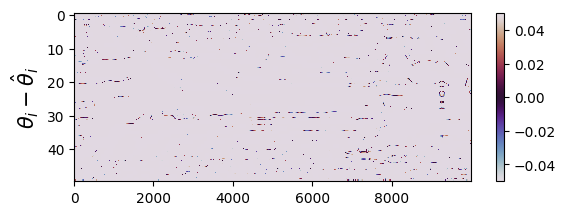

In [33]:
plt.subplot(211)
plt.imshow(theta.T - x_hats[:,:N].T,cmap='twilight',vmin=-0.05,vmax=0.05)
plt.gca().set_aspect('auto')
plt.colorbar()
plt.ylabel(r'$\theta_i-\hat{\theta}_i$',fontsize=15)



In [295]:
R_hat = np.abs(np.mean(np.exp(1j*theta),axis=1))

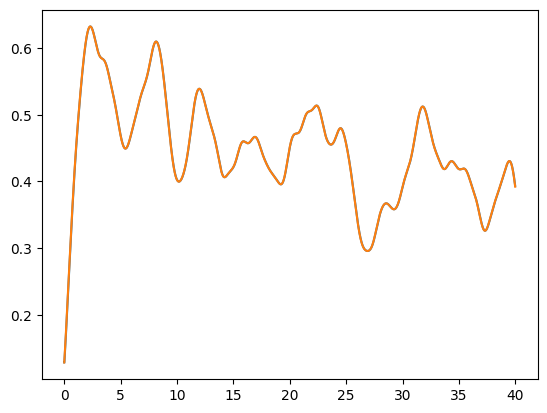

In [296]:
plt.plot(t,rs)
plt.plot(t,R_hat)
plt.show()

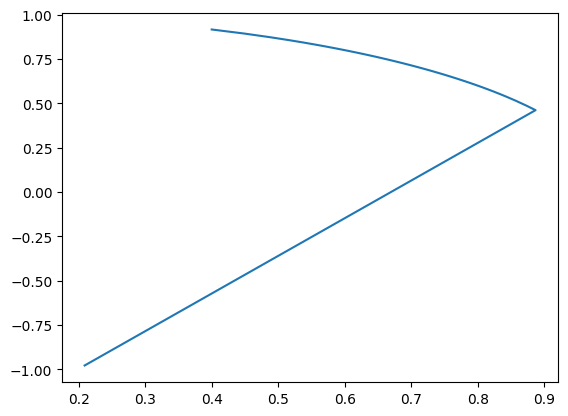

In [173]:
idx = 300
T = x_hats[idx][:N]
plt.plot(np.sin(T),np.cos(T))

NameError: name 'z_hats' is not defined

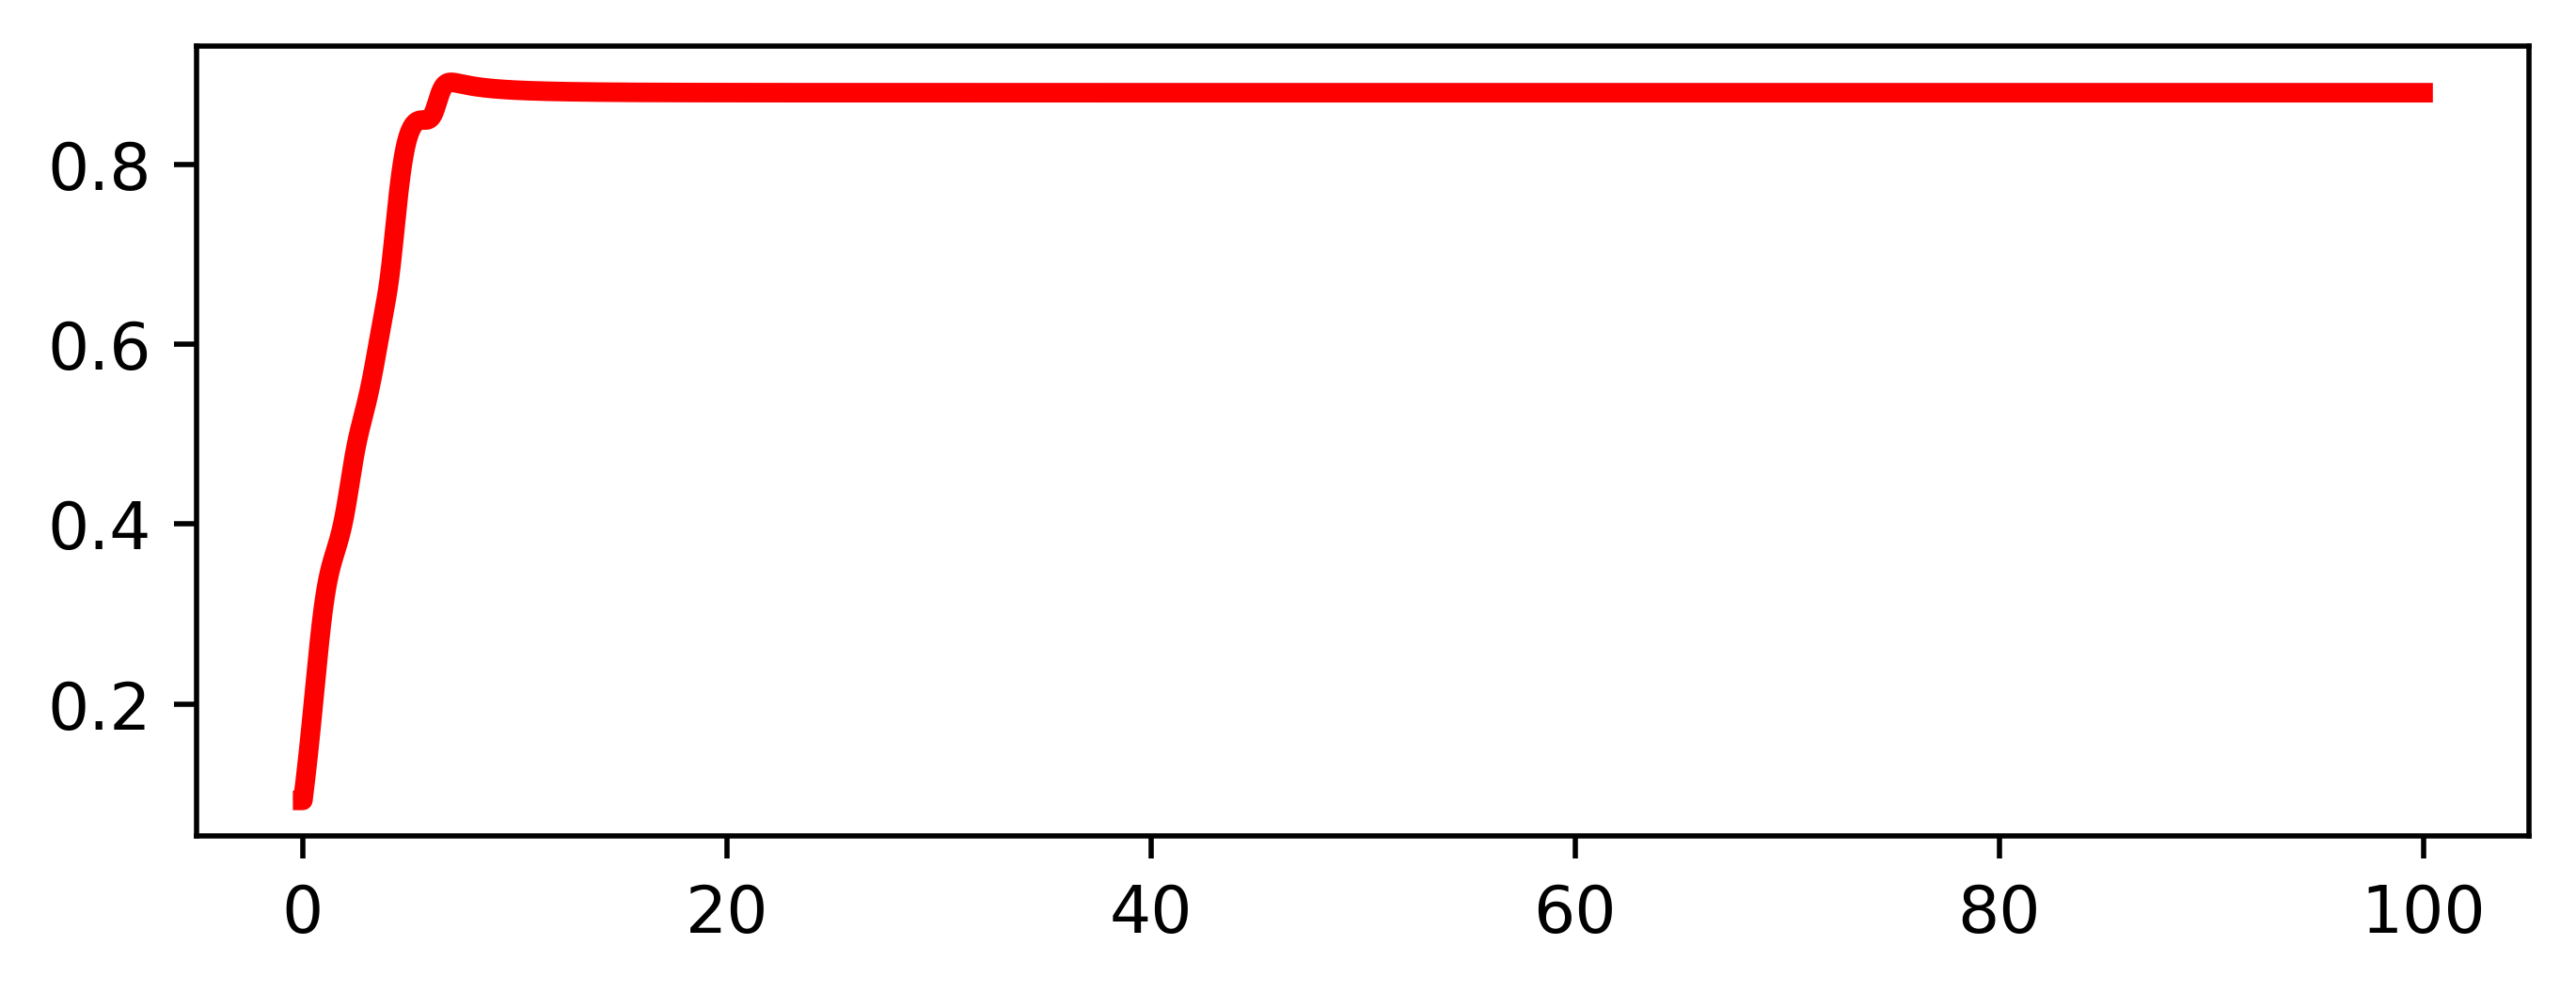

In [7]:
plt.figure(dpi=500)
plt.subplot(211)
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,z_hats,color='blue',lw=3)

plt.xlim(0,100)
plt.ylim(0,1)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)




# plt.plot(t,rs)

In [51]:
H = np.zeros((1,N+1))
H[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [44]:

# T = x[:N]
# K = x[-1]
F = np.eye(N+1)
Ti,Tj = np.meshgrid(x,x)
CC = np.cos(Tj-Ti)
SC = np.sum(CC,axis=0)
SS = np.sum(np.sin(Tj-Ti),axis=0)

Dii = 1 -K*dt/N*SC
D = np.r_[Dii,1]
F[:-1,:-1] = K/N*dt * CC
F[-1,:-1] = dt/N * SS
F[:-1,-1] = dt/N * SS
np.fill_diagonal(F,D)

# Estimate K with K

In [8]:
Ks = np.arange(0,4.2,0.4)


In [238]:
Ks = np.arange(0,4.1,0.2)
seed =None
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)
theta_random = np.ones(N)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.01
t = np.arange(0,40,dt)

K_rs = []
K_est = {}


for K in tqdm(Ks):
    theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
    r_mean = np.mean(rs[-500:])
    K_rs.append(r_mean)
    K_est['r',K] = []
    K_est['K',K] = []

    
    # for num in tqdm(range(50)):
    @parfor(np.arange(20),bar=False)
    def get_r_K_mean(num):
        x = np.r_[theta_random,K -1]
        Q = np.eye(N+1)*0
        P = np.eye(N+1)*0.01
        Q[-1,-1] = 0.02
        R_meas = 0.01
        P_hats = np.zeros((len(t),*P.shape))
        x_hats = np.zeros((len(t),len(x)))
        z_hats = np.zeros((len(t)))
        S_s = np.zeros((len(t)))
        x_hats[0] = x
        P_hats[0] = P
        z_hats[0] = h(x)[0]

        for i in range(1,len(t)):
            z_meas = rs[i] + np.random.randn()*R_meas 
            x_bar = f(x,omega)
            F_bar = F_j(x_bar,omega)
            P_bar = F_bar@P@F_bar.T + Q
            P_bar += np.eye(P_bar.shape[0]) * 1e-7
            # 2. EKF 예측 단계
            H = H_j(x_bar)
            z_bar = h(x_bar)
            S = H@P_bar@H.T + R_meas
            S_s[i] =S

            K_gain = P_bar@H.T@np.linalg.inv(S)
            x_hat = x_bar + K_gain@(z_meas-z_bar)
            P_hat = P_bar - K_gain@S@K_gain.T

            x = x_hat
            P = P_hat

            x_hats[i] = x
            P_hats[i] = P
            z_hats[i] = z_bar[0]
        K_estm = np.mean(x_hats[-500:,-1]) 
        r_estm = np.mean(z_hats[-500:]) 
        return K_estm,r_estm
    K_ests,r_ests = zip(*get_r_K_mean)
    K_est['K',K] = K_ests
    K_est['r',K] = r_ests

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
Ks = np.arange(0,4.1,0.2)
seed =None
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)
# theta_random = np.ones(N)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.01
t = np.arange(0,40,dt)

K_rs = []
K_est = {}

# 가정: N, dt, f, F_j, h, H_j, omega, rs, t 가 이미 정의됨
# 수치 바닥
epsP  = 1e-12   # P 바닥
epsS  = 1e-10   # S 바닥
jitterP = 1e-8  # P 예측단계 정칙화


for K in tqdm(Ks):
    theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
    r_mean = np.mean(rs[-500:])
    K_rs.append(r_mean)
    K_est['r',K] = []
    K_est['K',K] = []

    
    # for num in tqdm(range(50)):
    @parfor(np.arange(20),bar=False)
    def get_r_K_mean(num):
        # ---- 초기화 ----
        x = np.r_[theta_random, K + 1.0].astype(float)  # 상태: [theta..., K]
        P = np.eye(N+1) * 1e-6
        Q = np.zeros((N+1, N+1))
        Q[-1, -1] = 1e-8            # K 과정잡음만 켬 (필요에 따라 조정)
        R_meas = float(1e-10)       # 관측잡음 분산 (스칼라)

        P_hats = np.zeros((len(t), *P.shape))
        x_hats_KM = np.zeros((len(t), len(x)))
        z_hats = np.zeros((len(t)))
        S_s = np.zeros((len(t)))

        x_hats_KM[0] = x
        P_hats[0] = P
        z_hats[0] = h(x)[0]
        K_gains = []

        # ---- (선택) K freeze/unfreeze 설정 ----
        freeze = False
        sigmaK_tol = 1e-4         # K 분산 문턱 (스케일에 맞게)
        NIS_low, NIS_high = 0.3, 3.0
        W = 50
        nis_hist = []

        def sensitivity_K(x_bar, H_bar, F_bar):
            # H: (1, N+1), F_Kcol: (N+1,)
            F_Kcol = F_bar[:, -1]
            return abs(float(H_bar @ F_Kcol.reshape(-1,1)))

        for i in range(1, len(t)):
            # --- 측정 생성 ---
            z_meas = rs[i] + np.random.randn() * np.sqrt(R_meas)
            # 너무 강한 클리핑은 편향 유발 → 필요 시 아주 약하게만
            z_meas = np.clip(z_meas, 1e-9, 1.0)  # R은 [0,1]이므로 상한만 보호

            # --- 예측 단계 ---
            x_bar = f_fast(x, omega)
            F_bar = F_j_fast(x_bar)
            P_bar = F_bar @ P @ F_bar.T + Q
            # 수치 정칙화
            P_bar += np.eye(P_bar.shape[0]) * jitterP
            P_bar = 0.5 * (P_bar + P_bar.T)

            # --- 관측 예측 ---
            H = H_j(x_bar)
            z_bar = h(x_bar)
            # S: (1,1) -> scalar
            S = float(H @ P_bar @ H.T + R_meas)
            S = max(S, epsS)
            S_s[i] = S

            # 혁신
            nu = float(z_meas - z_bar)  # scalar

            # 칼만 이득 (N+1,1)처럼 쓰되, 연산은 스칼라로
            K_gain = (P_bar @ H.T) / S  # shape: (N+1,1)
            K_gains.append(K_gain.copy())

            # ---- (선택) K freeze/unfreeze 판단 ----
            # NIS
            q = (nu * nu) / S
            nis_hist.append(q)
            if len(nis_hist) > W:
                nis_hist.pop(0)
            q_mean = np.mean(nis_hist)

            # 민감도
            sK = sensitivity_K(x_bar, H, F_bar)

            if not freeze:
                if (P_bar[-1, -1] < sigmaK_tol) and (NIS_low <= q_mean <= NIS_high) and (sK < 1e-4):
                    freeze = True
            else:
                if (q_mean > NIS_high) or (sK >= 1e-4):
                    freeze = False

            # --- 업데이트 ---
            if freeze:
                # K 이득 제거 → K는 업데이트에서 고정
                K_gain[-1, :] = 0.0

            # 상태 업데이트
            x_hat = x_bar + (K_gain * nu).ravel()

            # 공분산 업데이트 (Joseph 형식)
            I = np.eye(N+1)
            KH = K_gain @ H               # (N+1, N+1) rank-1
            P_hat = (I - KH) @ P_bar @ (I - KH).T + (K_gain * R_meas) @ K_gain.T

            # 수치 안정
            P_hat = 0.5 * (P_hat + P_hat.T)
            # eigen/SVD floor
            u, s, vt = np.linalg.svd(P_hat)
            s = np.maximum(s, epsP)
            P_hat = (u * s) @ vt

            # K 범위 보호 (선택)
            x_hat[-1] = np.clip(x_hat[-1], 1e-3, 10.0)

            # 다음 스텝으로
            x = x_hat
            P = P_hat

            x_hats[i] = x
            P_hats[i] = P
            z_hats[i] = z_bar


        K_estm = np.mean(x_hats[-500:,-1]) 
        r_estm = np.mean(z_hats[-500:]) 
        return K_estm,r_estm
    K_ests,r_ests = zip(*get_r_K_mean)
    K_est['K',K] = K_ests
    K_est['r',K] = r_ests

  0%|          | 0/21 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
Ks = np.arange(0,4.1,0.1)
seed =None
N = 500
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)
# theta_random = np.ones(N)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.01
t = np.arange(0,40,dt)

K_rs = []
K_est = {}

# 가정: N, dt, f, F_j, h, H_j, omega, rs, t 가 이미 정의됨
# 수치 바닥
epsP  = 1e-12   # P 바닥
epsS  = 1e-10   # S 바닥
jitterP = 1e-8  # P 예측단계 정칙화


theta_random2 = np.random.uniform(0,2*np.pi,N)

for K in tqdm(Ks):
    theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
    r_mean = np.mean(rs[-500:])
    K_rs.append(r_mean)
    K_est['r',K] = []
    K_est['K',K] = []

    
    # for num in tqdm(range(50)):
    @parfor(np.arange(50),bar=False)
    def get_r_K_mean(num):
        x_hats, P_hats, z_hats, S_s,_ = run_ekf_rank1_orig(
            theta_random2, 
            K_init=K + 2.0,
            omega=omega,
            t=t,
            rs=rs,
            R_meas=1e-10,
            jitterP=1e-5,     # P_bar 정칙화 (네 코드와 동일)
            s_floor=1e-6,     # S 하한 (네 코드와 동일)
            P_floor=1e-12,    # P_hat 요소 바닥 (네 코드와 동일)
            delta_K_init=2.0, # 초기 K 오프셋: K_init + 2
            add_meas_noise=True)

        K_est = x_hats[:, -1]
        K_estm = np.mean(K_est[-500:]) 
        r_estm = np.mean(z_hats[-500:]) 
        return K_estm,r_estm
    K_ests,r_ests = zip(*get_r_K_mean)
    K_est['K',K] = K_ests
    K_est['r',K] = r_ests



  0%|          | 0/41 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
np.savez("K_est.npz",K_est=K_est)

In [90]:
Ks = np.arange(0,4.1,0.1)
seed = 1#None
N = 50
theta_random,omega,Kc = Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)
# theta_random = np.ones(N)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.01
t = np.arange(0,40,dt)

K_rs = []
K_est = {}

# 가정: N, dt, f, F_j, h, H_j, omega, rs, t 가 이미 정의됨
# 수치 바닥
epsP  = 1e-12   # P 바닥
epsS  = 1e-10   # S 바닥
jitterP = 1e-8  # P 예측단계 정칙화

theta_random2 = np.random.uniform(0,2*np.pi,N)


for K in tqdm(Ks):
    theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
    r_mean = np.mean(rs[-500:])
    K_rs.append(r_mean)
    K_est['r',K] = []
    K_est['K',K] = []

    
    # for num in tqdm(range(50)):
    @parfor(np.arange(50),bar=False)
    def get_r_K_mean(num):
        x_hats, P_hats, z_hats, S_s = run_ekf_rank1_fast(
            theta_random=theta_random2,
            K_init=K + 2.0,
            omega=omega,
            t=t,
            rs=rs,
            R_meas=1e-10,
            Q_K=1e-10,
            epsP=1e-12, epsS=1e-10, jitterP=1e-8,
            sigmaK_tol=1e-4, NIS_low=0.3, NIS_high=3.0,
            sens_tol=1e-4, W=50, eig_every=20
        )
        K_est = x_hats[:, -1]

        K_estm = np.mean(K_est[-500:]) 
        r_estm = np.mean(z_hats[-500:]) 
        return K_estm,r_estm
    K_ests,r_ests = zip(*get_r_K_mean)
    K_est['K',K] = K_ests
    K_est['r',K] = r_ests



  0%|          | 0/41 [00:00<?, ?it/s]

In [13]:
K_est

{('r', 0.0): (0.003949998920255026,
  0.00394984353467099,
  0.003950140024080144,
  0.003950105822630043,
  0.003949780535971318,
  0.00394914385108669,
  0.003950135132464601,
  0.003949876678579123,
  0.003950275155973744,
  0.003949920034865577,
  0.0039498820347559195,
  0.003950024295307489,
  0.003949894676667267,
  0.003950326908743743,
  0.0039492215401632355,
  0.0039500913410633835,
  0.003949890805453542,
  0.0039498898044147855,
  0.003949856603190088,
  0.003949927118203299,
  0.003949719934966706,
  0.003950697317149322,
  0.003949323421974086,
  0.0039504207583507915,
  0.003949928682693473,
  0.003949849145962869,
  0.0039491728561620275,
  0.003949638987204225,
  0.003949768967326539,
  0.003949511812816937,
  0.003950051732248453,
  0.003950449010409208,
  0.003949890306380547,
  0.00395014215327168,
  0.0039511730860518,
  0.0039493690730547214,
  0.00394962490719103,
  0.003950087690582637,
  0.003949490210472026,
  0.003949940678164973,
  0.003949924128526889,
  0

In [12]:
df = pd.DataFrame(K_est)

ValueError: All arrays must be of the same length

In [ ]:
q1 = df['K'].quantile(0.25)
q2 = df['K'].quantile(0.5)
q3 = df['K'].quantile(0.75)
iqr = q3 - q1
iqr

0.0    0.064801
0.1    0.045560
0.2    0.064924
0.3    0.264129
0.4    0.363294
0.5    0.478305
0.6    0.119792
0.7    0.198440
0.8    0.151714
0.9    0.265893
1.0    0.308676
1.1    0.250706
1.2    0.259148
1.3    0.347114
1.4    0.163765
1.5    0.044239
1.6    0.014953
1.7    0.049382
1.8    0.000585
1.9    0.003242
2.0    0.047252
2.1    0.011492
2.2    0.000008
2.3    0.000003
2.4    0.000014
2.5    0.000008
2.6    0.000005
2.7    0.000006
2.8    0.000007
2.9    0.000007
3.0    0.000010
3.1    0.000012
3.2    0.000011
3.3    0.000013
3.4    0.000017
3.5    0.000014
3.6    0.000020
3.7    0.000025
3.8    0.000031
3.9    0.000023
4.0    0.000030
dtype: float64

In [93]:
q1 = df['K'].quantile(0.25)
q2 = df['K'].quantile(0.5)
q3 = df['K'].quantile(0.75)
iqr = q3 - q1
iqr

0.0    0.064801
0.1    0.045560
0.2    0.064924
0.3    0.264129
0.4    0.363294
0.5    0.478305
0.6    0.119792
0.7    0.198440
0.8    0.151714
0.9    0.265893
1.0    0.308676
1.1    0.250706
1.2    0.259148
1.3    0.347114
1.4    0.163765
1.5    0.044239
1.6    0.014953
1.7    0.049382
1.8    0.000585
1.9    0.003242
2.0    0.047252
2.1    0.011492
2.2    0.000008
2.3    0.000003
2.4    0.000014
2.5    0.000008
2.6    0.000005
2.7    0.000006
2.8    0.000007
2.9    0.000007
3.0    0.000010
3.1    0.000012
3.2    0.000011
3.3    0.000013
3.4    0.000017
3.5    0.000014
3.6    0.000020
3.7    0.000025
3.8    0.000031
3.9    0.000023
4.0    0.000030
dtype: float64

In [94]:
# IQR 계산
Q1 = df['K'].quantile(0.25)
Q3 = df['K'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 정의
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 각 column마다 이상치를 NaN으로 대체
for col in df['K'].columns:
    df['K', col] = df['K', col].apply(lambda x: x if lower_bound[col] <= x <= upper_bound[col] else np.nan)
    df['r', col] = df['r', col].where(df['K', col].notna(), np.nan)

In [15]:
df_EKF = df

In [72]:
import seaborn as sns

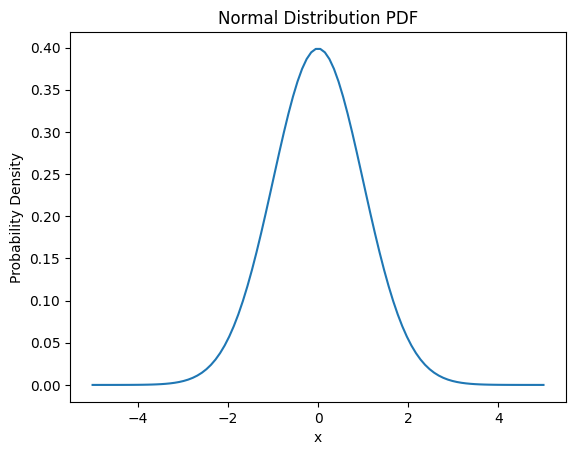

In [71]:
from scipy.stats import norm

# 평균 0, 표준편차 1인 정규분포의 pdf 계산
x = np.linspace(-5, 5, 100)
pdf = norm.pdf(x, loc=0, scale=1)

plt.plot(x, pdf)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Normal Distribution PDF')
plt.show()

In [18]:
df = df_EKF

In [73]:
K_c = 2/(np.pi*norm.pdf(0,0,1))

In [95]:
df['K']

0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0        NaN       NaN  0.147586  0.560420  0.219449  0.747863  0.282868   
1   0.147208  0.270209  0.172552  0.409002  0.311442  0.338861  0.381046   
2   0.142770  0.305971  0.151350  0.132849  0.316088  0.783834  0.405714   
3   0.163862  0.209517  0.245019  0.637768  0.269288  1.324855  0.356411   
4   0.104561       NaN  0.168135  0.561987  0.265048  1.045457  0.289589   
5   0.134111  0.237785  0.183260  0.354032  0.659589  0.305022  0.304001   
6   0.125276  0.278039  0.186337  0.438085  0.223066  0.445766  0.400196   
7   0.130723  0.228071  0.139302  0.589370  0.647645  0.682301  0.393834   
8   0.163574  0.211928  0.142437  0.099146  0.316892  0.297402  0.359949   
9   0.121168  0.274775  0.146960  0.305492  0.338024  1.126820  0.421289   
10  0.091844  0.255636  0.143329  0.503954  0.220781  0.687519  0.230613   
11  0.167356  0.217570  0.209122  0.277306  0.234432  0.413485  0.185175   
12  0.223715  0.245728  0.143446  0.388441  0.310519  0.537767  0.392169   
13  0.125566       NaN  0.157212  0.259247  0.691273  0.696954  0.375720   
14  0.197794       NaN  0.133903  0.525813  0.605614  0.892883  0.157208   
15  0.115700  0.258989  0.280132  0.899399  0.637332  0.659682  0.383902   
16  0.109319  0.268639  0.149107  0.181375  0.354977  0.252909  0.415706   
17  0.161021  0.182252  0.098663  0.429200  0.231729  0.138018  0.419612   
18  0.122408       NaN  0.211236  0.246063  0.843230  0.237564  0.366880   
19  0.180875       NaN  0.156690  0.567061  0.863117  1.111233  0.197649   
20  0.176787  0.270526       NaN  0.305535  0.250304  0.435656  0.519804   
21  0.158062  0.249642  0.156573  0.238343  0.364125  0.542239  0.382667   
22  0.137143       NaN  0.120662  0.411759  0.298981  0.159636  0.486268   
23  0.276720  0.257618  0.146286  0.214978  0.368676  0.665444  0.416513   
24  0.252631  0.295279       NaN  0.586662  0.346786  0.491580  0.426449   
25  0.093121  0.276515  0.131312  0.214786  0.392223  0.990225  0.462825   
26  0.162619  0.194102       NaN  0.274959  0.277971  0.902751  0.373136   
27  0.155625  0.252226  0.159408  0.382767       NaN  0.944864  0.455753   
28  0.098860  0.246641  0.213060  0.354983  0.209957  0.513551  0.430060   
29  0.115651  0.234364  0.150716  0.293421  0.407576  0.755958  0.371304   
30  0.088162       NaN  0.118118  0.243734  0.178947  0.823787  0.286982   
31  0.116429  0.235018  0.112470  0.805479  0.409331  0.974855  0.560492   
32  0.181560  0.255900  0.141309  0.261708  0.424525  0.231829  0.466051   
33  0.130590  0.236129  0.281322  0.393639       NaN  0.736612  0.572040   
34  0.095417  0.204961  0.100314  0.627250  0.208149  0.674881  0.393824   
35       NaN  0.228883  0.187689  0.595579  0.859916  0.098517  0.437804   
36  0.187244  0.285107  0.125704  0.147753  0.346511  0.151977  0.280287   
37  0.113943  0.169708  0.187281  0.400396       NaN  0.427153  0.388908   
38  0.218791  0.284442  0.207137  0.720579  0.717617  0.146258  0.270678   
39  0.121720  0.170652  0.124528  0.235975  0.542603  0.384390  0.419033   
40  0.117061  0.261548  0.136517  0.353840       NaN  1.468395  0.426881   
41  0.199992  0.248106  0.147731  0.548722  0.293877  0.895002  0.392214   
42  0.152567  0.234089  0.176217  0.338492  0.691025  0.813078  0.218762   
43  0.129517  0.263392  0.197499  0.476249  0.288987  0.697456  0.440152   
44  0.090722  0.166322  0.173257  0.374276  0.388661  0.354635  0.216940   
45  0.107092  0.280066  0.071854  0.190804  0.233254  0.487676       NaN   
46  0.160715  0.246256  0.237343  0.516325  0.179500  0.475662  0.267251   
47  0.253467  0.271008       NaN  0.177537  0.492037  0.304472  0.309465   
48  0.187156  0.262813  0.138209  0.518528  0.286747  0.110698  0.397573   
49  0.191952  0.234062  0.252624  0.287110  0.209927  1.099302  0.383182   

         0.7       0.8       0.9  ...       3.1       3.2       3.3       3.4  \
0   1.049919  0.426724  0.369479  ...  3.099998  3.

In [20]:

np.sum(np.isnan(KK),axis=0)

NameError: name 'KK' is not defined

/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_5661/2031638876.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(Ks,(K_mean-Ks)/Ks,'.')


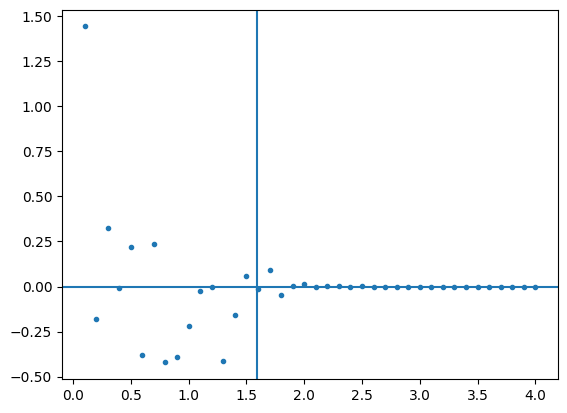

In [96]:
KK = df['K'].to_numpy()
K_mean =np.nanmean(KK,axis=0)
K_std =np.nanstd(KK,axis=0)
plt.plot(Ks,(K_mean-Ks)/Ks,'.')
# plt.fill_between(Ks,K_mean-K_std,K_mean+K_std,alpha=0.3)
# plt.plot(Ks,Ks)
plt.axhline(0)
plt.axvline(K_c)
# plt.ylim(-0.01,0.01)

In [68]:
(KK - Ks)/Ks

C:\Users\kim9y\AppData\Local\Temp\ipykernel_40812\3098983942.py:1: RuntimeWarning: divide by zero encountered in divide
  (KK - Ks)/Ks


array([[            inf,  5.86002540e-02,  2.51625885e-02, ...,
         4.10578822e-06, -4.42020541e-06, -1.09056883e-05],
       [            inf,  5.75033595e-02,  2.50238595e-02, ...,
         3.56415739e-06, -2.42383634e-06, -1.04673531e-05],
       [            nan,  5.70998245e-02,  2.54070568e-02, ...,
         4.78712083e-06,  7.68060107e-06,  3.77295373e-06],
       ...,
       [            inf,  5.81218670e-02,  2.47960118e-02, ...,
         2.12928592e-07,  6.23470256e-06, -3.53427154e-06],
       [            inf,  5.73209235e-02,  2.50971428e-02, ...,
         3.35609199e-06,  6.37097092e-07,  4.36558097e-06],
       [            inf,  5.76275905e-02,  2.53444584e-02, ...,
         6.69443268e-06, -2.71747183e-06,  9.59371038e-06]])

/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_5661/1558141842.py:3: RuntimeWarning: divide by zero encountered in divide
  sns.boxplot(data=(KK-Ks)/Ks)


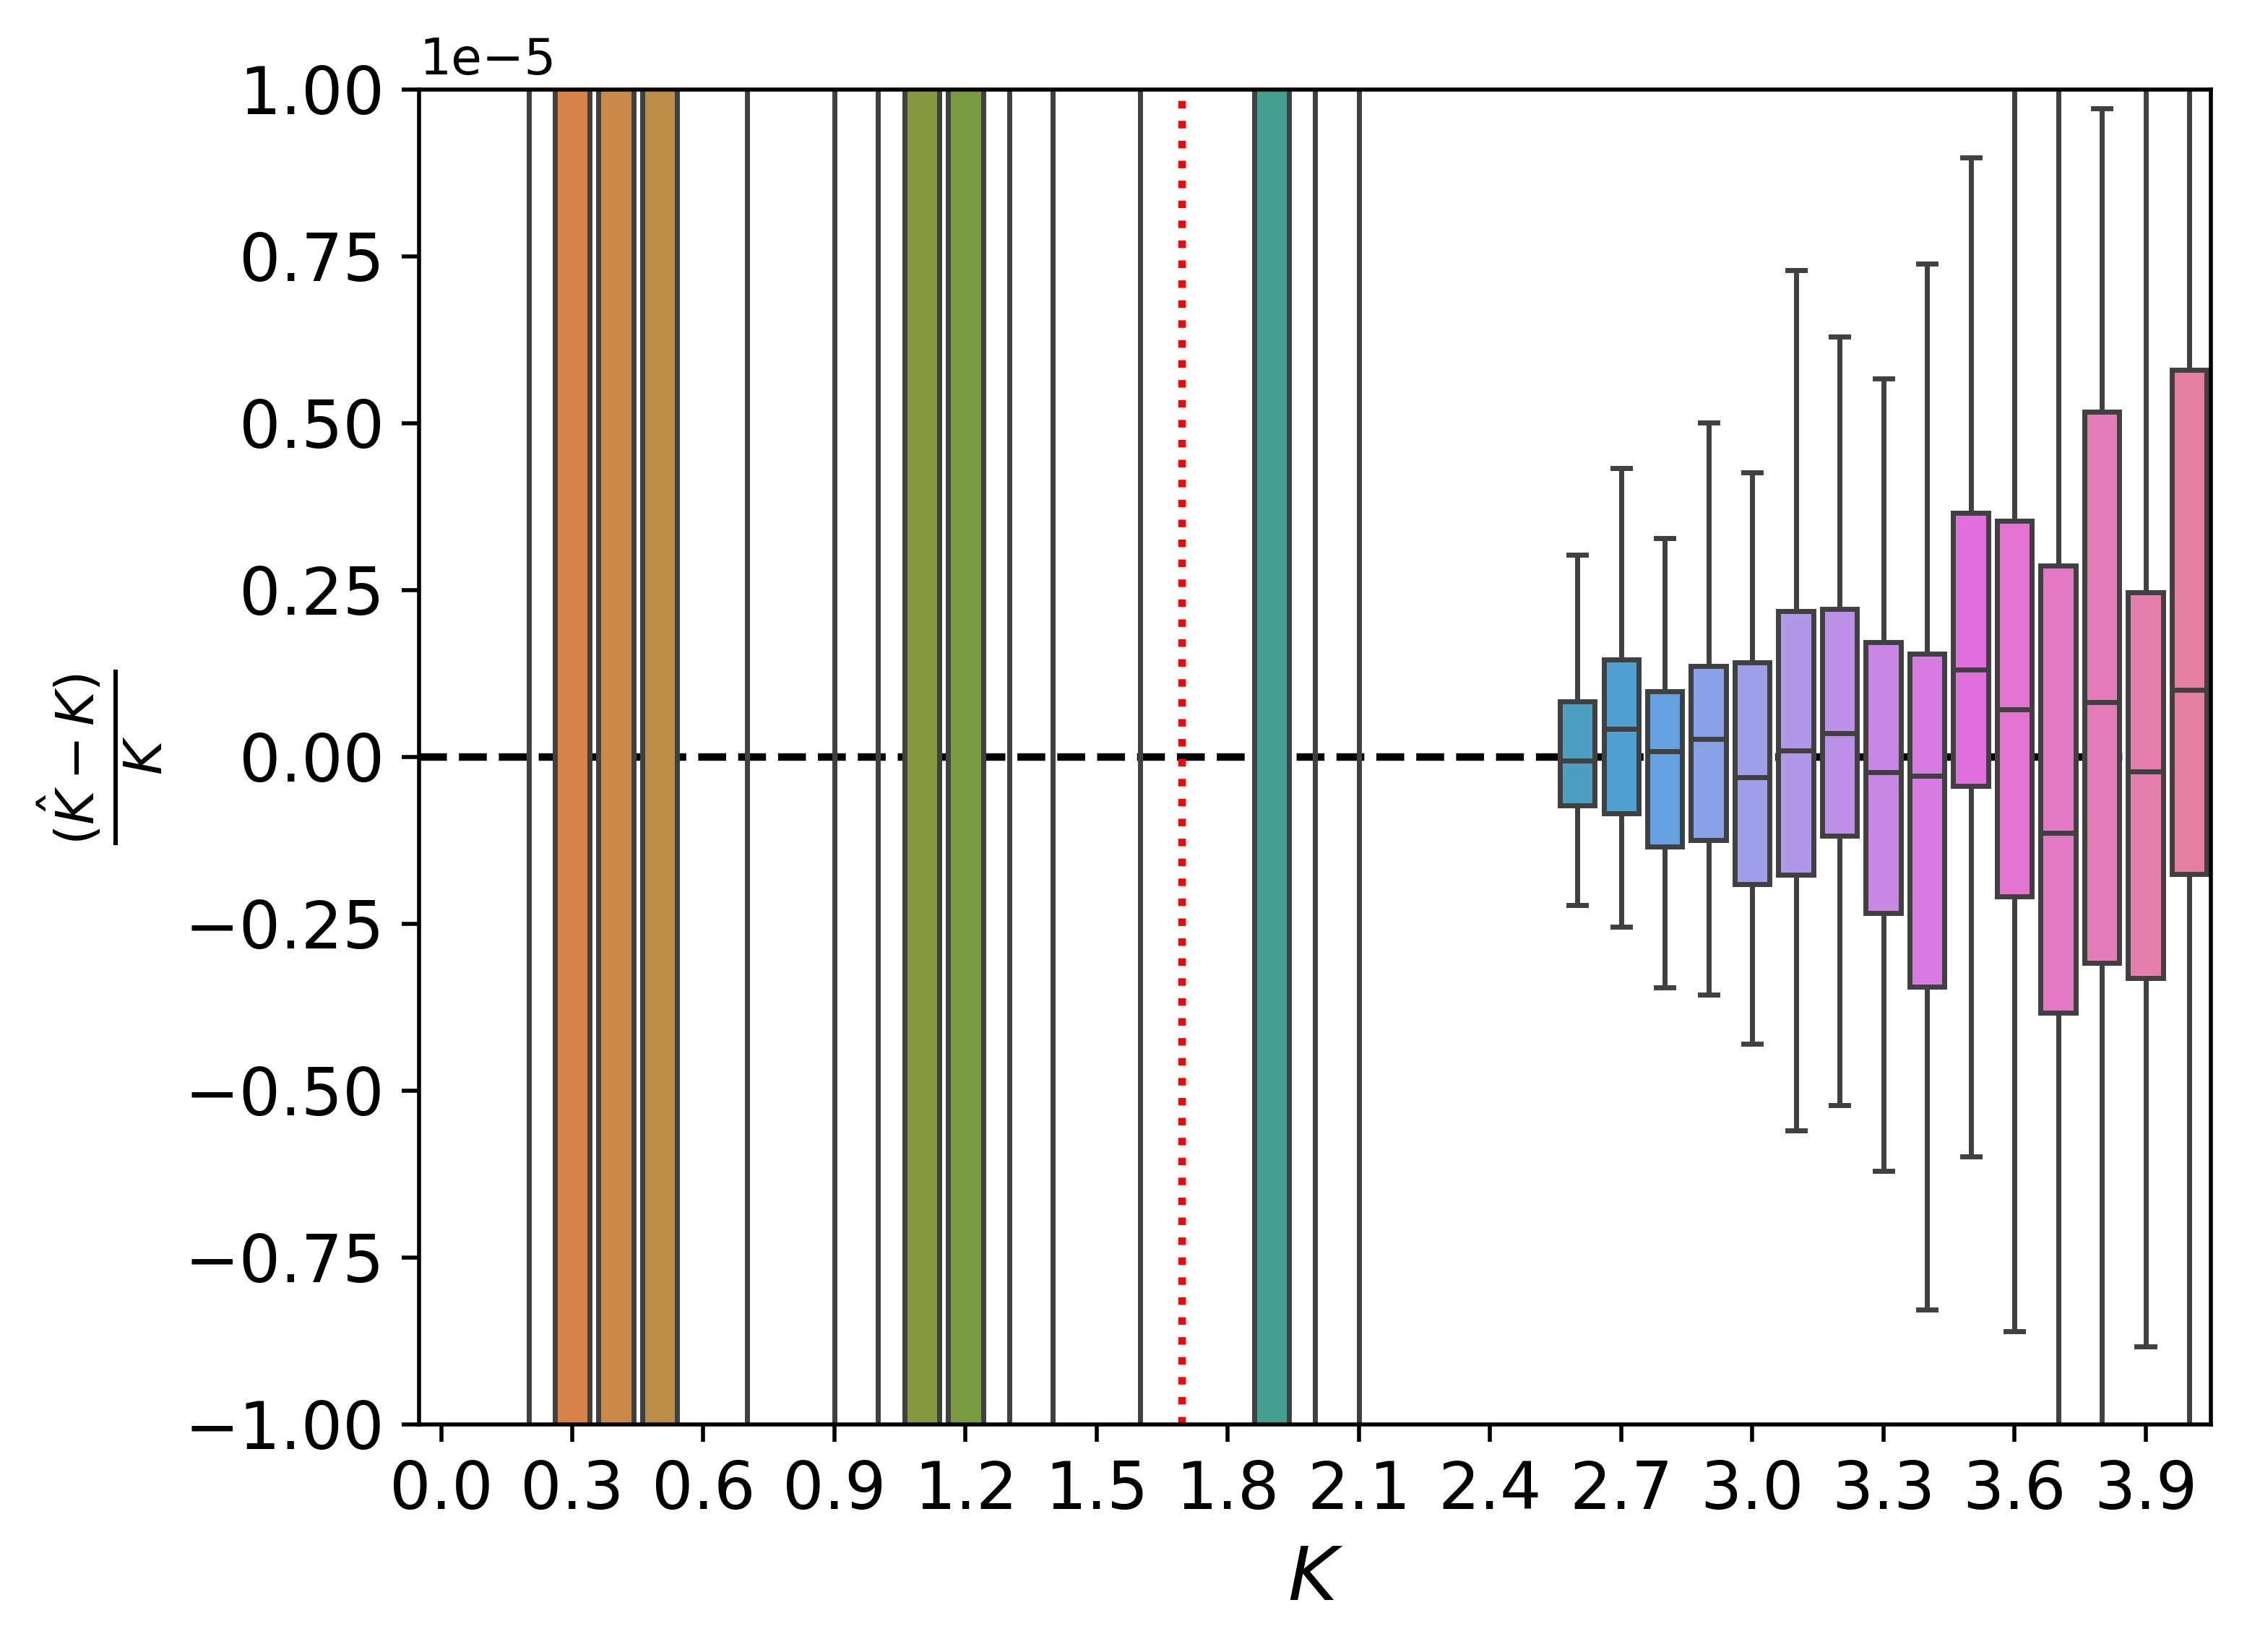

In [102]:
# plt.plot(Ks,(KK-Ks).T,'.');
plt.figure(dpi=500)
sns.boxplot(data=(KK-Ks)/Ks)
# plt.xticks((np.arange(21)+1)[::3],[0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6])
plt.xticks((np.arange(len(Ks)))[::3],np.round(Ks[::3],2))
plt.axhline(0,zorder=-10,ls='--',color='black')
plt.axvline(K_c/0.1+1,zorder=-10,ls=':',color='red')
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$\frac{(\hat{K} - K)}{K}$',fontsize=15)
# plt.title('Box plot of KK - Ks')
plt.ylim(-1e-5,1e-5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
plt.show()

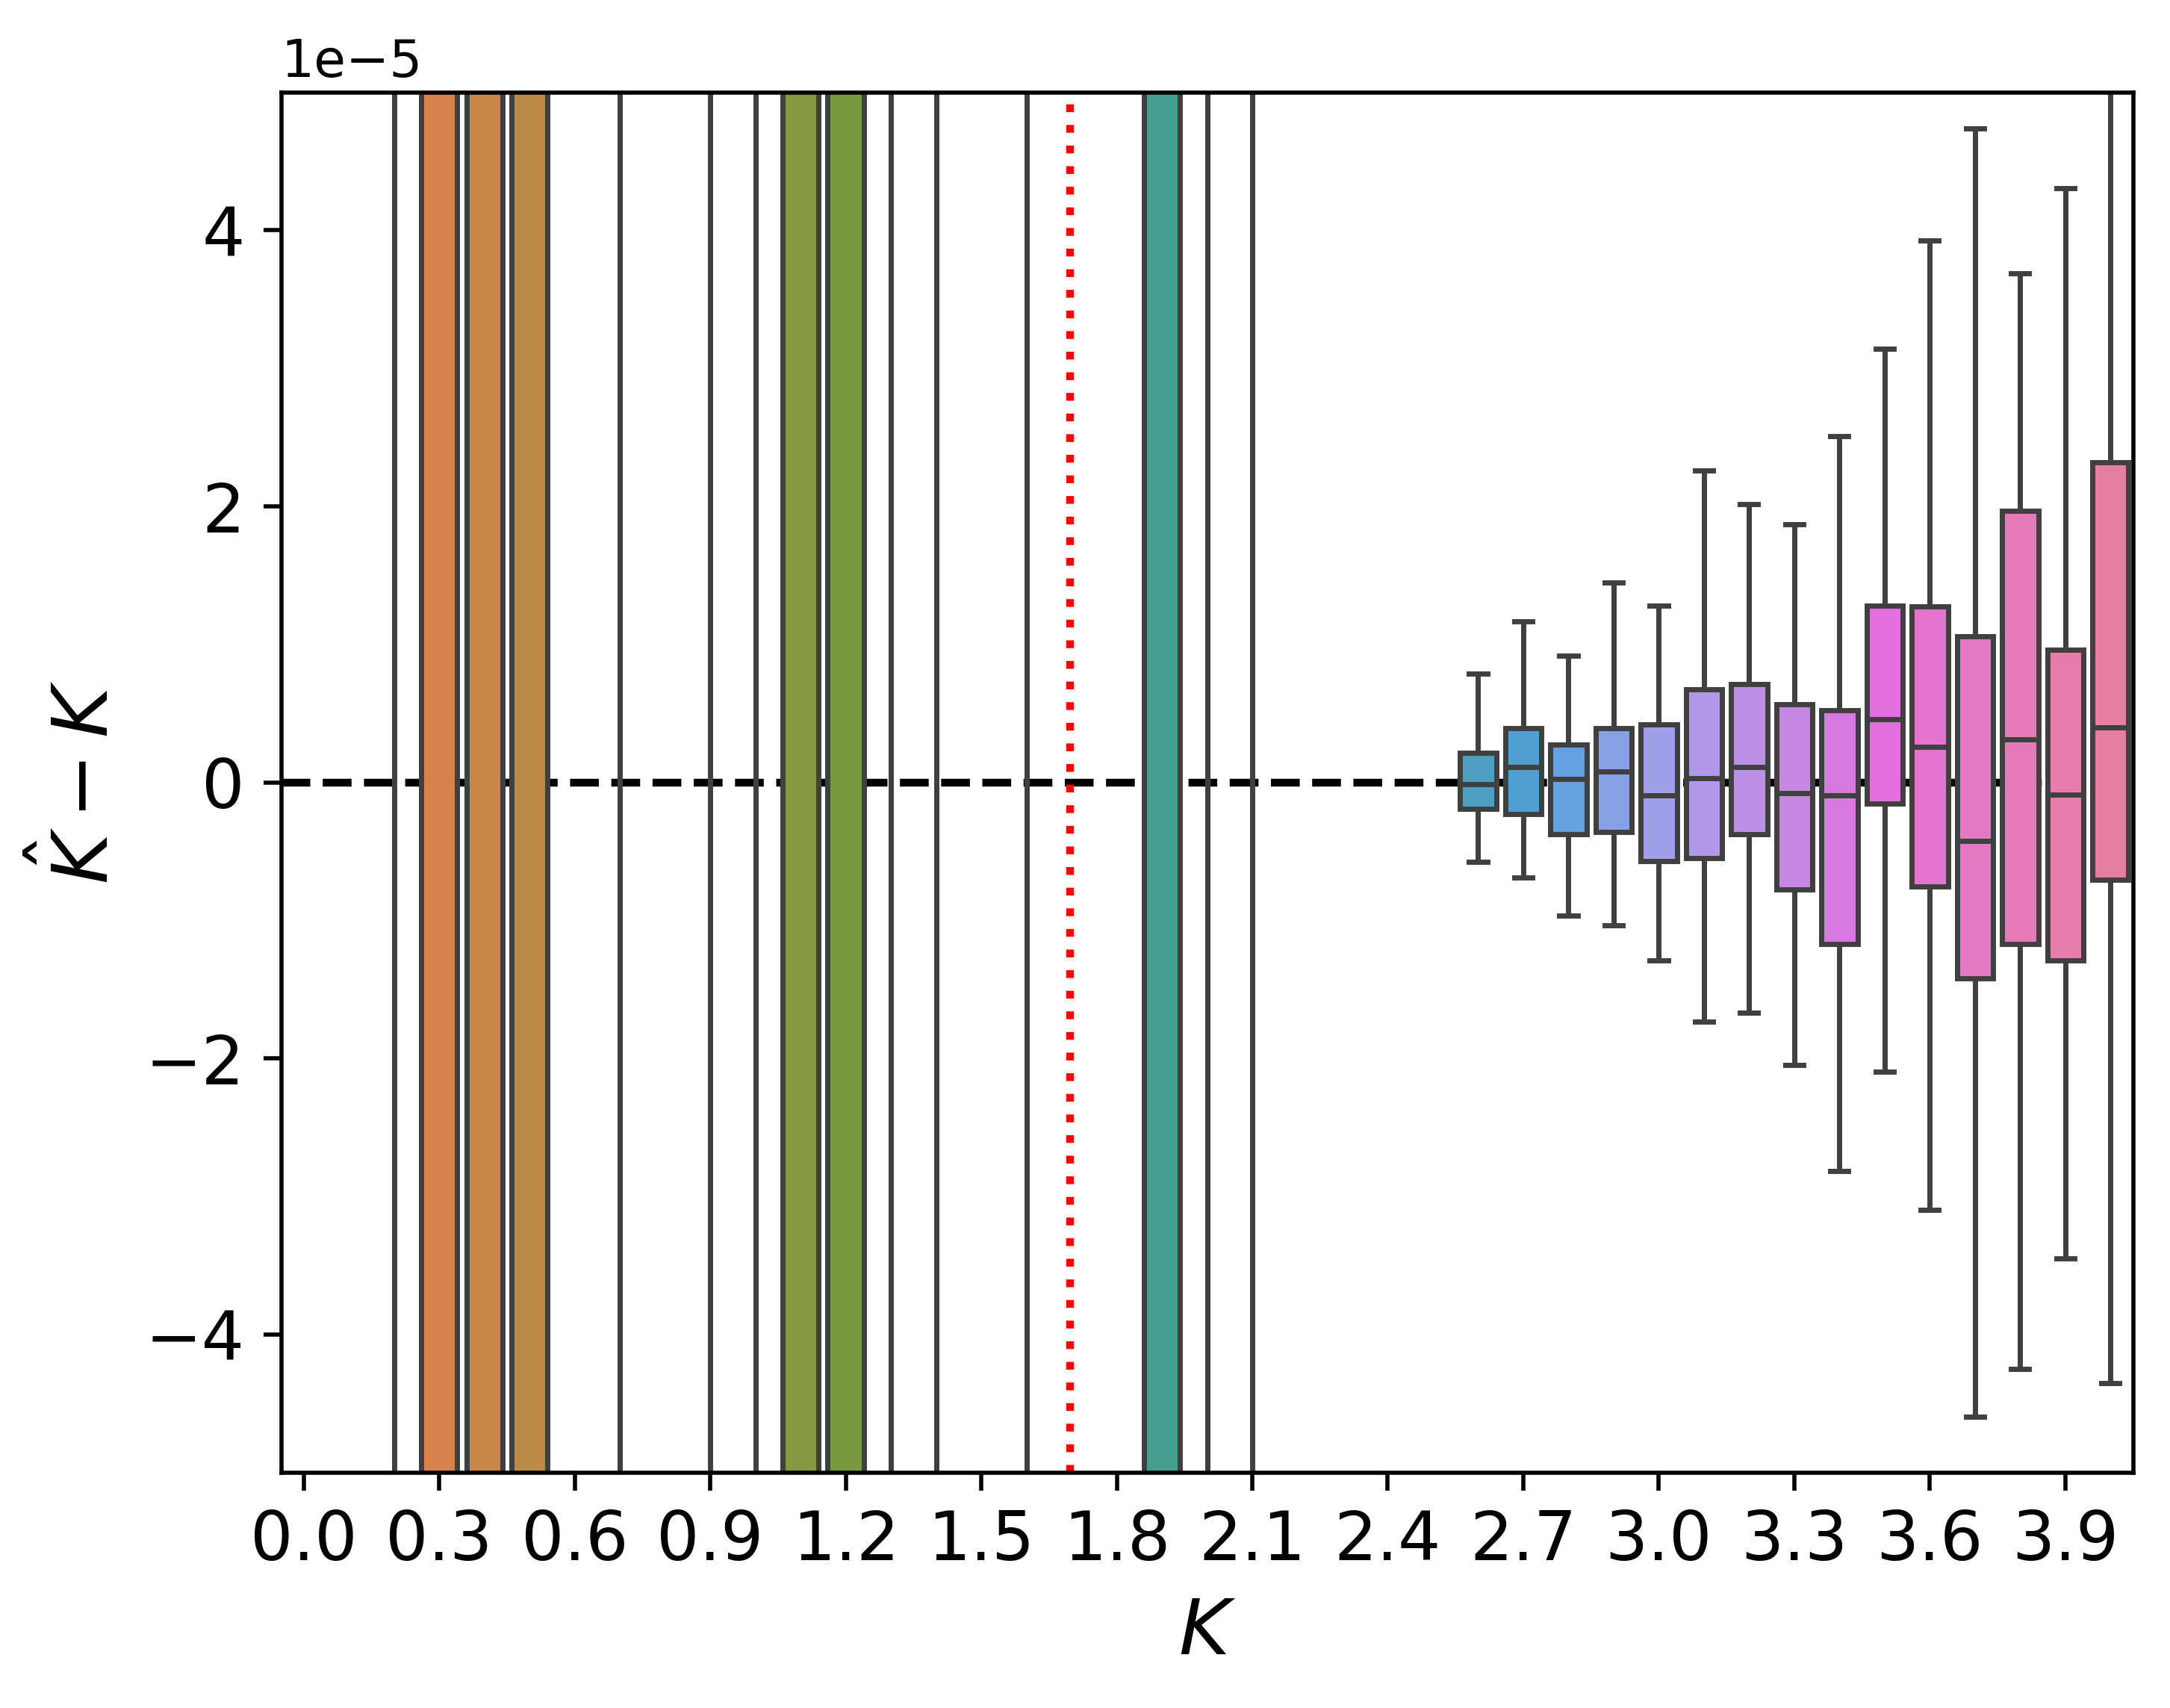

In [104]:
# plt.plot(Ks,(KK-Ks).T,'.');
plt.figure(dpi=500)
sns.boxplot(data=(KK-Ks))
# plt.xticks((np.arange(21)+1)[::3],[0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6])
plt.xticks((np.arange(len(Ks)))[::3],np.round(Ks[::3],2))
plt.axhline(0,zorder=-10,ls='--',color='black')
plt.axvline(K_c/0.1+1,zorder=-10,ls=':',color='red')
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$\hat{K} - K$',fontsize=15)
# plt.title('Box plot of KK - Ks')
plt.ylim(-5e-5,5e-5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
plt.show()

NameError: name 'ax' is not defined

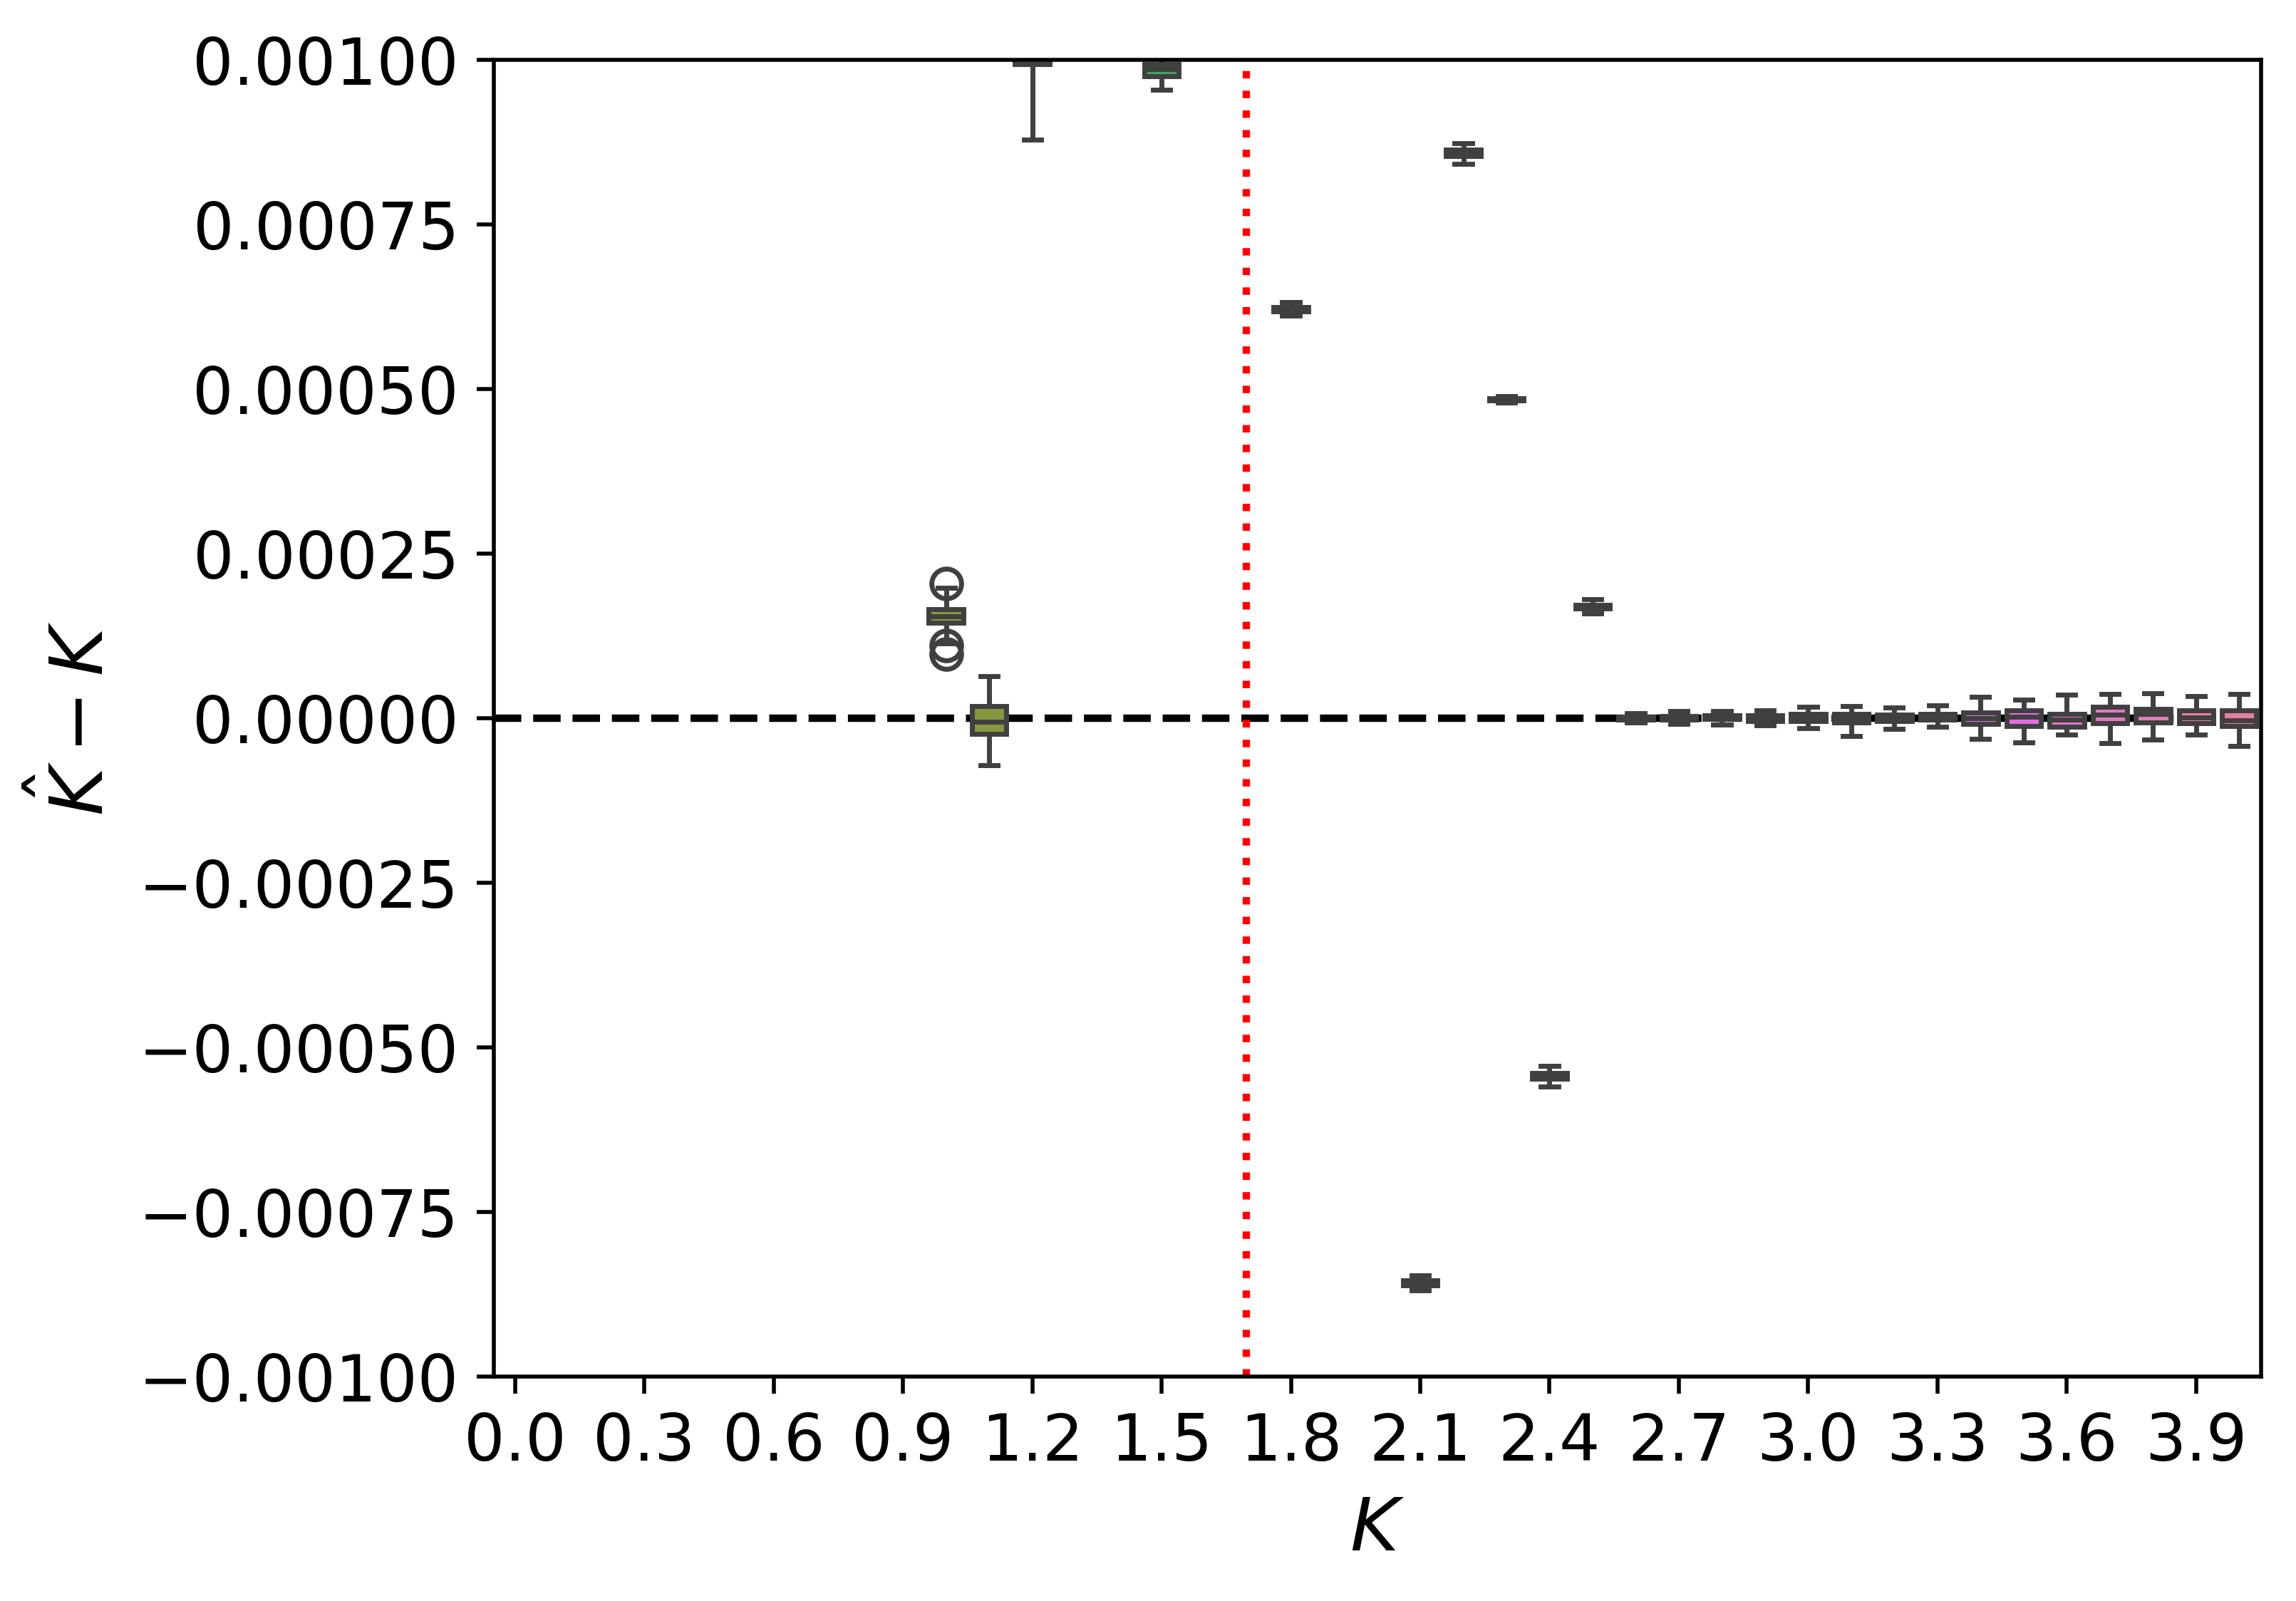

In [85]:
# plt.plot(Ks,(KK-Ks).T,'.');
plt.figure(dpi=500)
sns.boxplot(data=(KK-Ks))
# plt.xticks((np.arange(21)+1)[::3],[0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6])
plt.xticks((np.arange(len(Ks)))[::3],np.round(Ks[::3],2))
plt.axhline(0,zorder=-10,ls='--',color='black')
plt.axvline(K_c/0.1+1,zorder=-10,ls=':',color='red')
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$\hat{K} - K$',fontsize=15)
# plt.title('Box plot of KK - Ks')
plt.ylim(-0.001,0.001)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

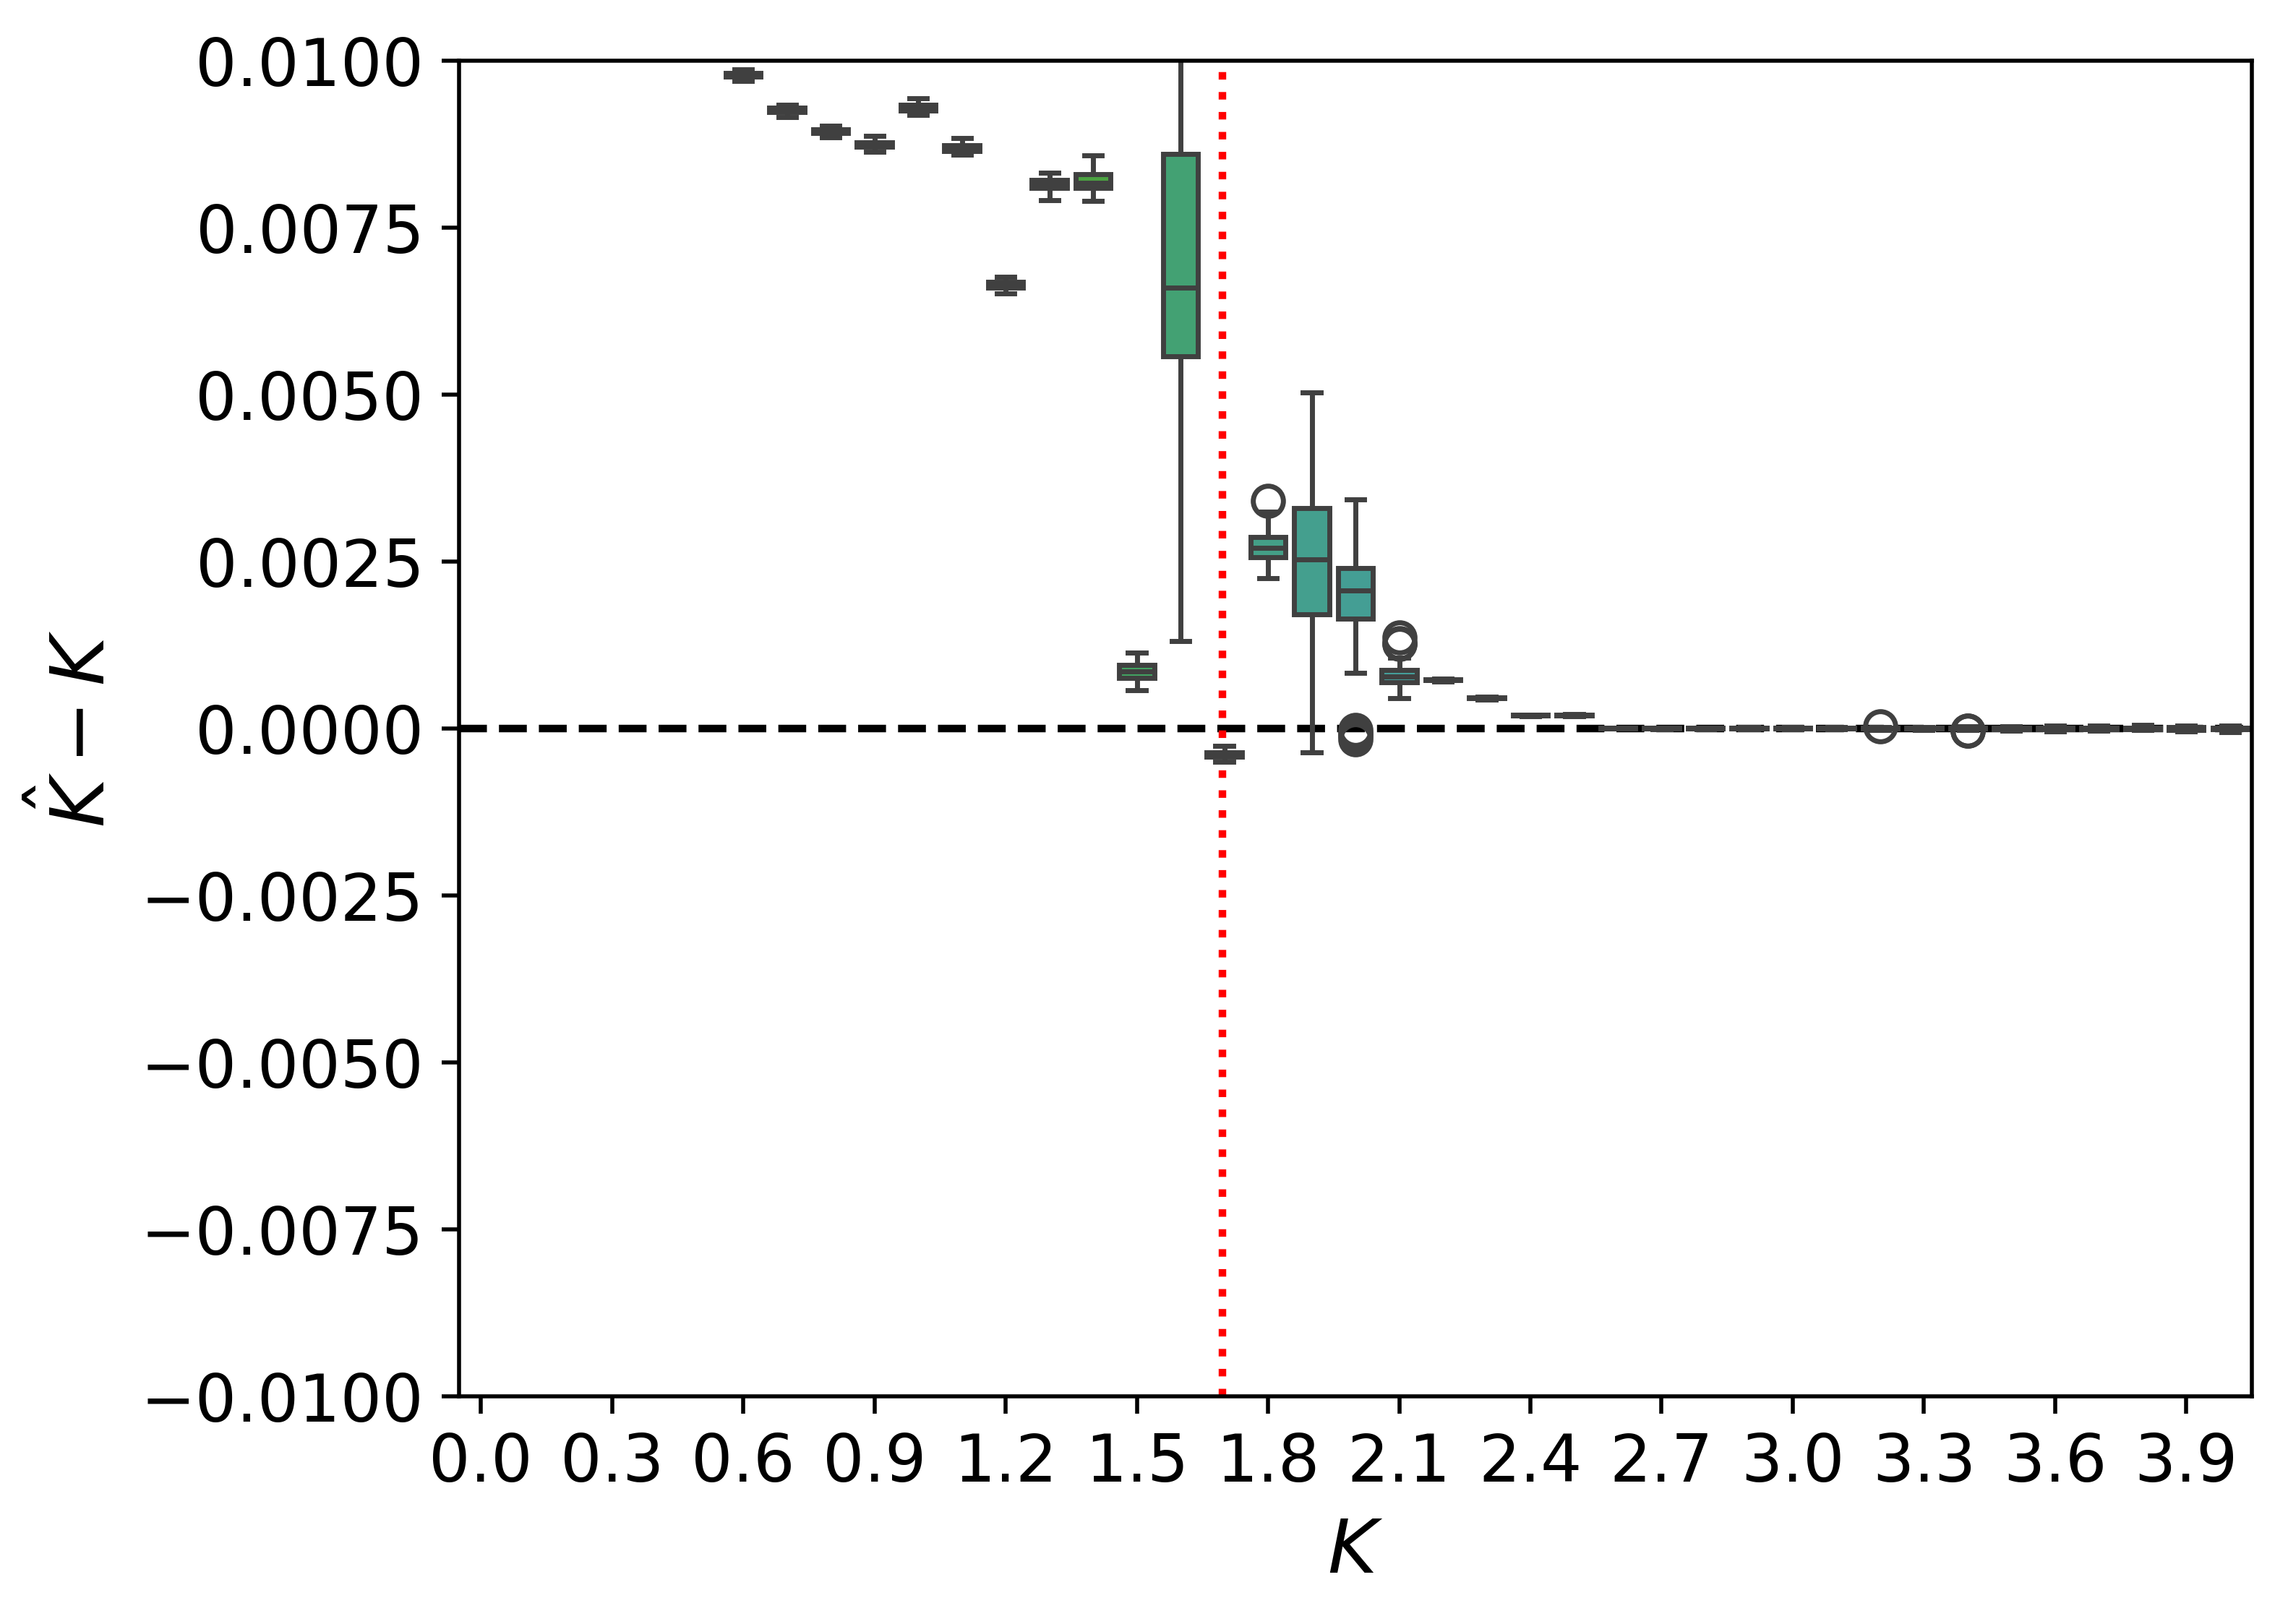

In [775]:
# plt.plot(Ks,(KK-Ks).T,'.');
plt.figure(dpi=500)
sns.boxplot(data=(KK-Ks))
# plt.xticks((np.arange(21)+1)[::3],[0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6])
plt.xticks((np.arange(len(Ks)))[::3],np.round(Ks[::3],2))
plt.axhline(0,zorder=-10,ls='--',color='black')
plt.axvline(K_c/0.1+1,zorder=-10,ls=':',color='red')
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$\hat{K} - K$',fontsize=15)
# plt.title('Box plot of KK - Ks')
plt.ylim(-0.01,0.01)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

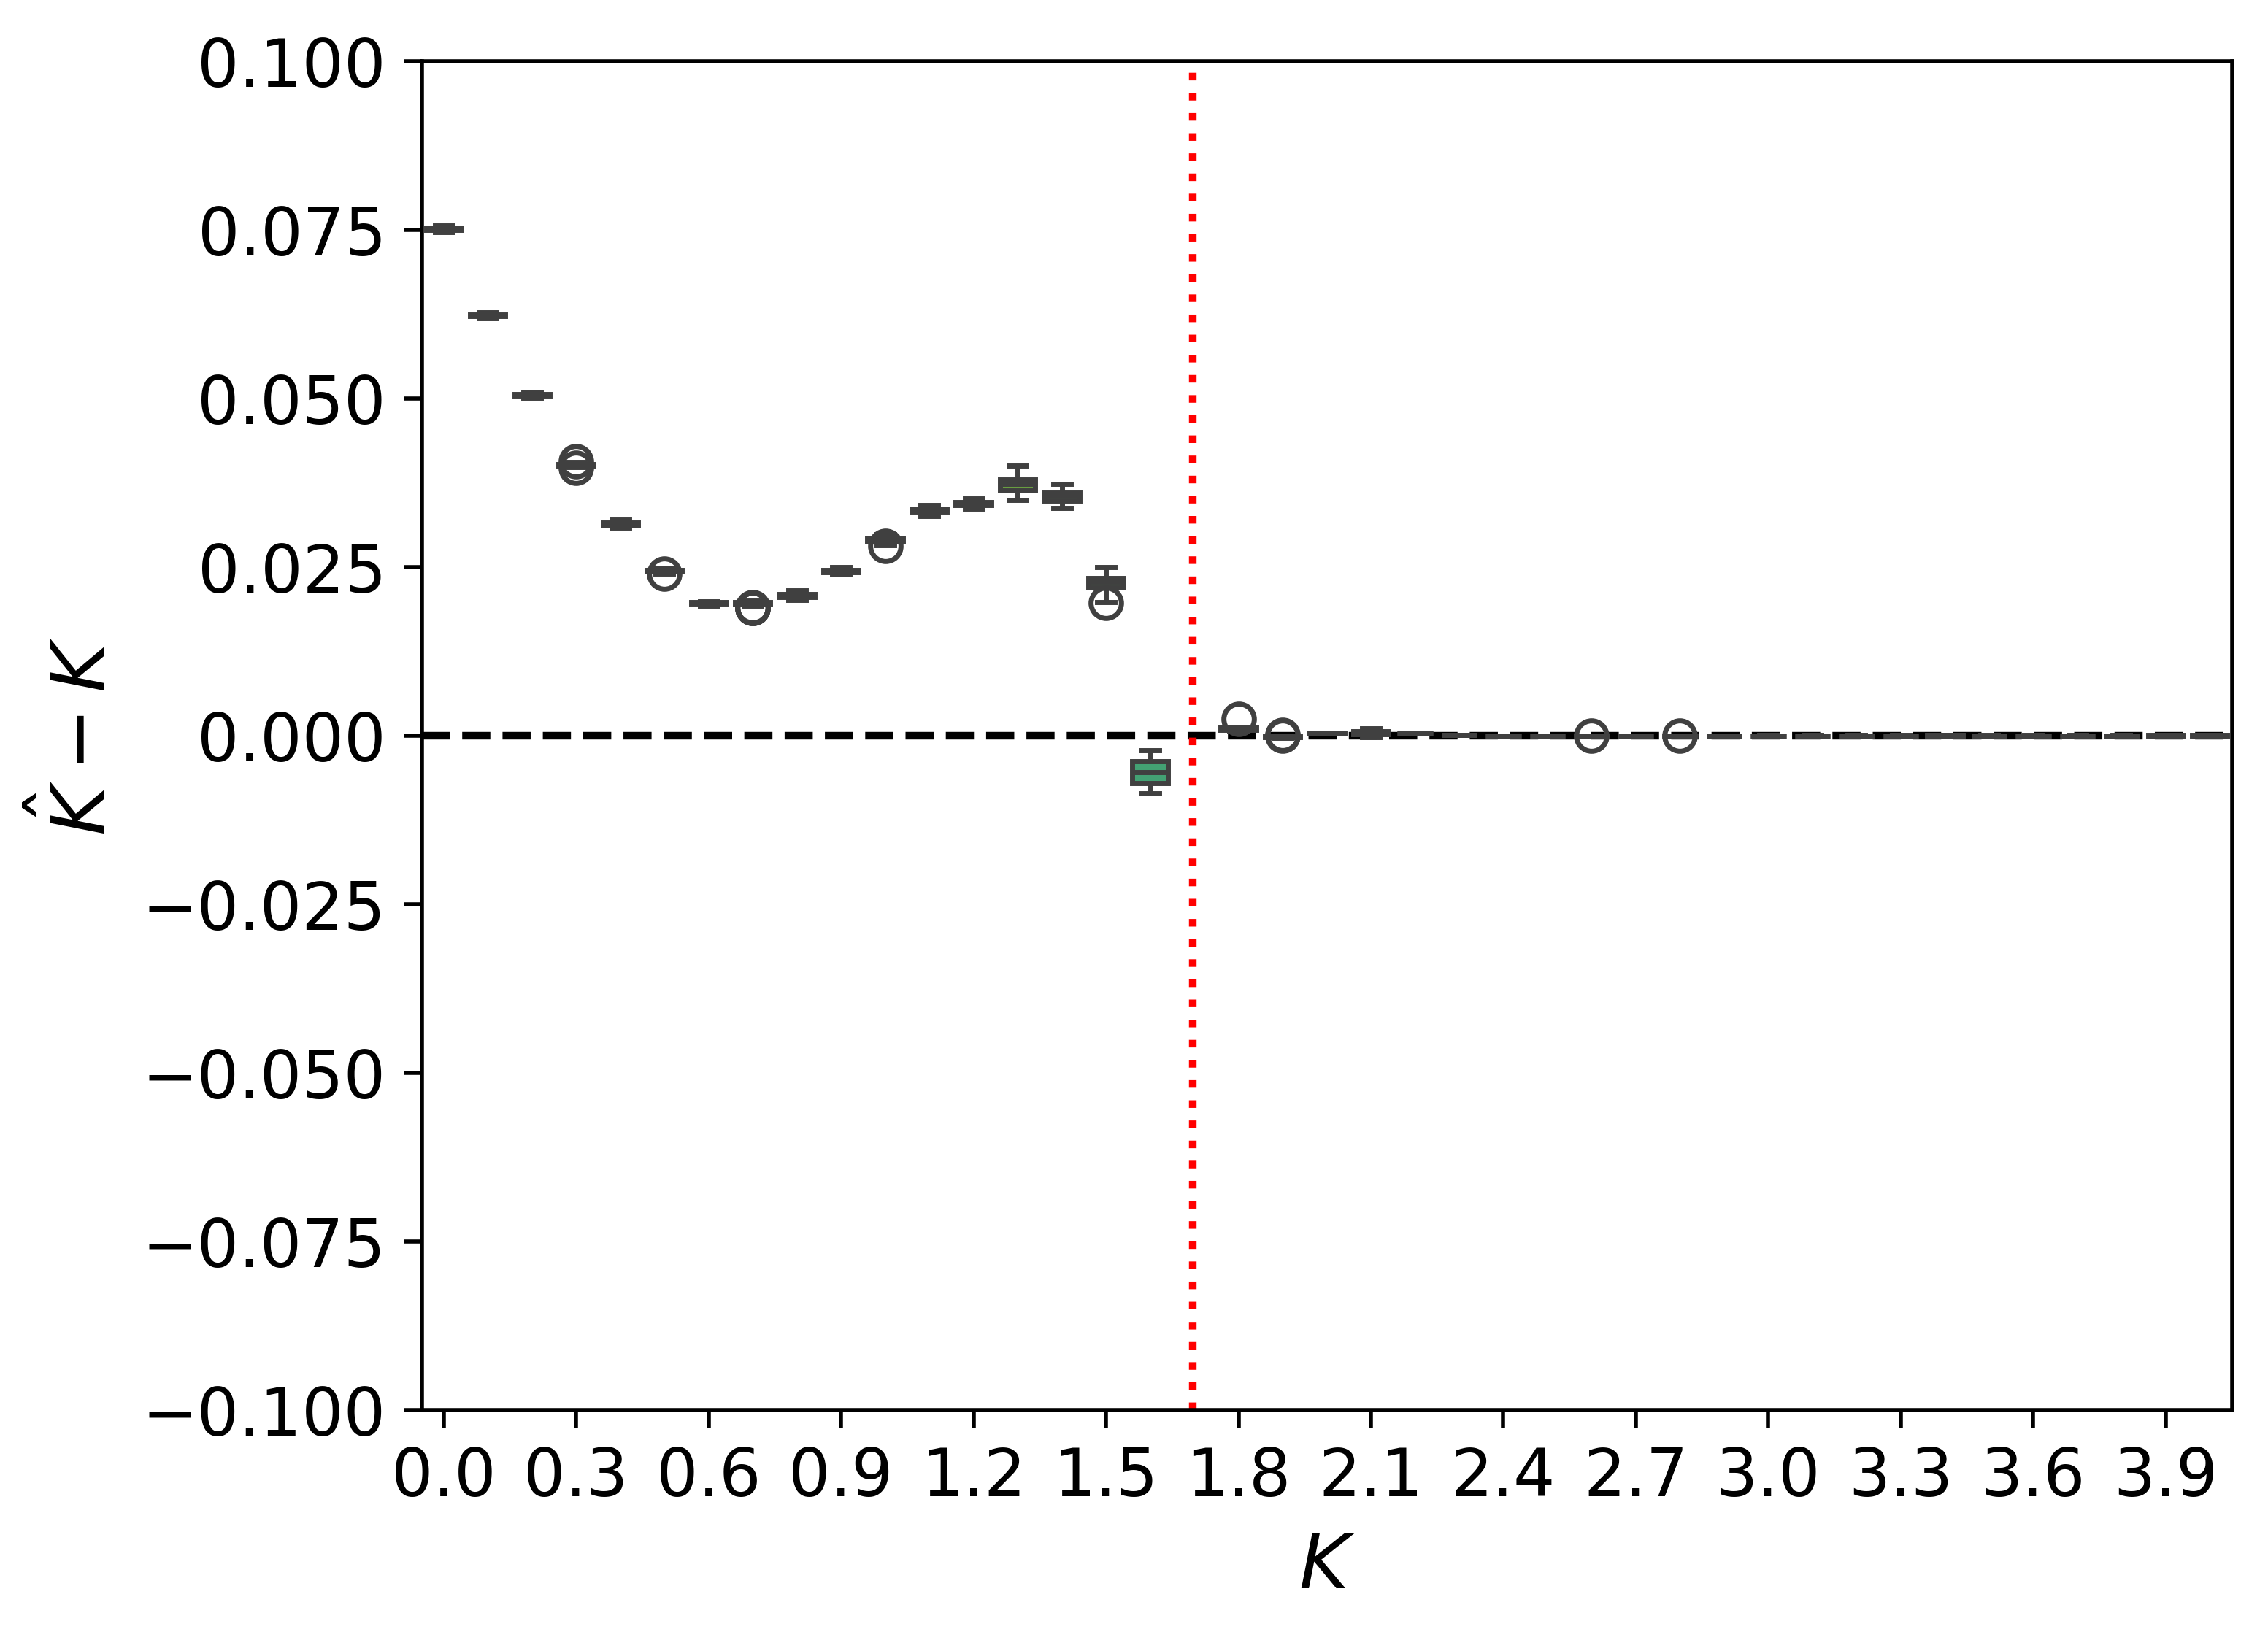

In [741]:
# plt.plot(Ks,(KK-Ks).T,'.');
plt.figure(dpi=500)
sns.boxplot(data=(KK-Ks))
# plt.xticks((np.arange(21)+1)[::3],[0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6])
plt.xticks((np.arange(len(Ks)))[::3],np.round(Ks[::3],2))
plt.axhline(0,zorder=-10,ls='--',color='black')
plt.axvline(K_c/0.1+1,zorder=-10,ls=':',color='red')
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$\hat{K} - K$',fontsize=15)
# plt.title('Box plot of KK - Ks')
plt.ylim(-0.1,0.1)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

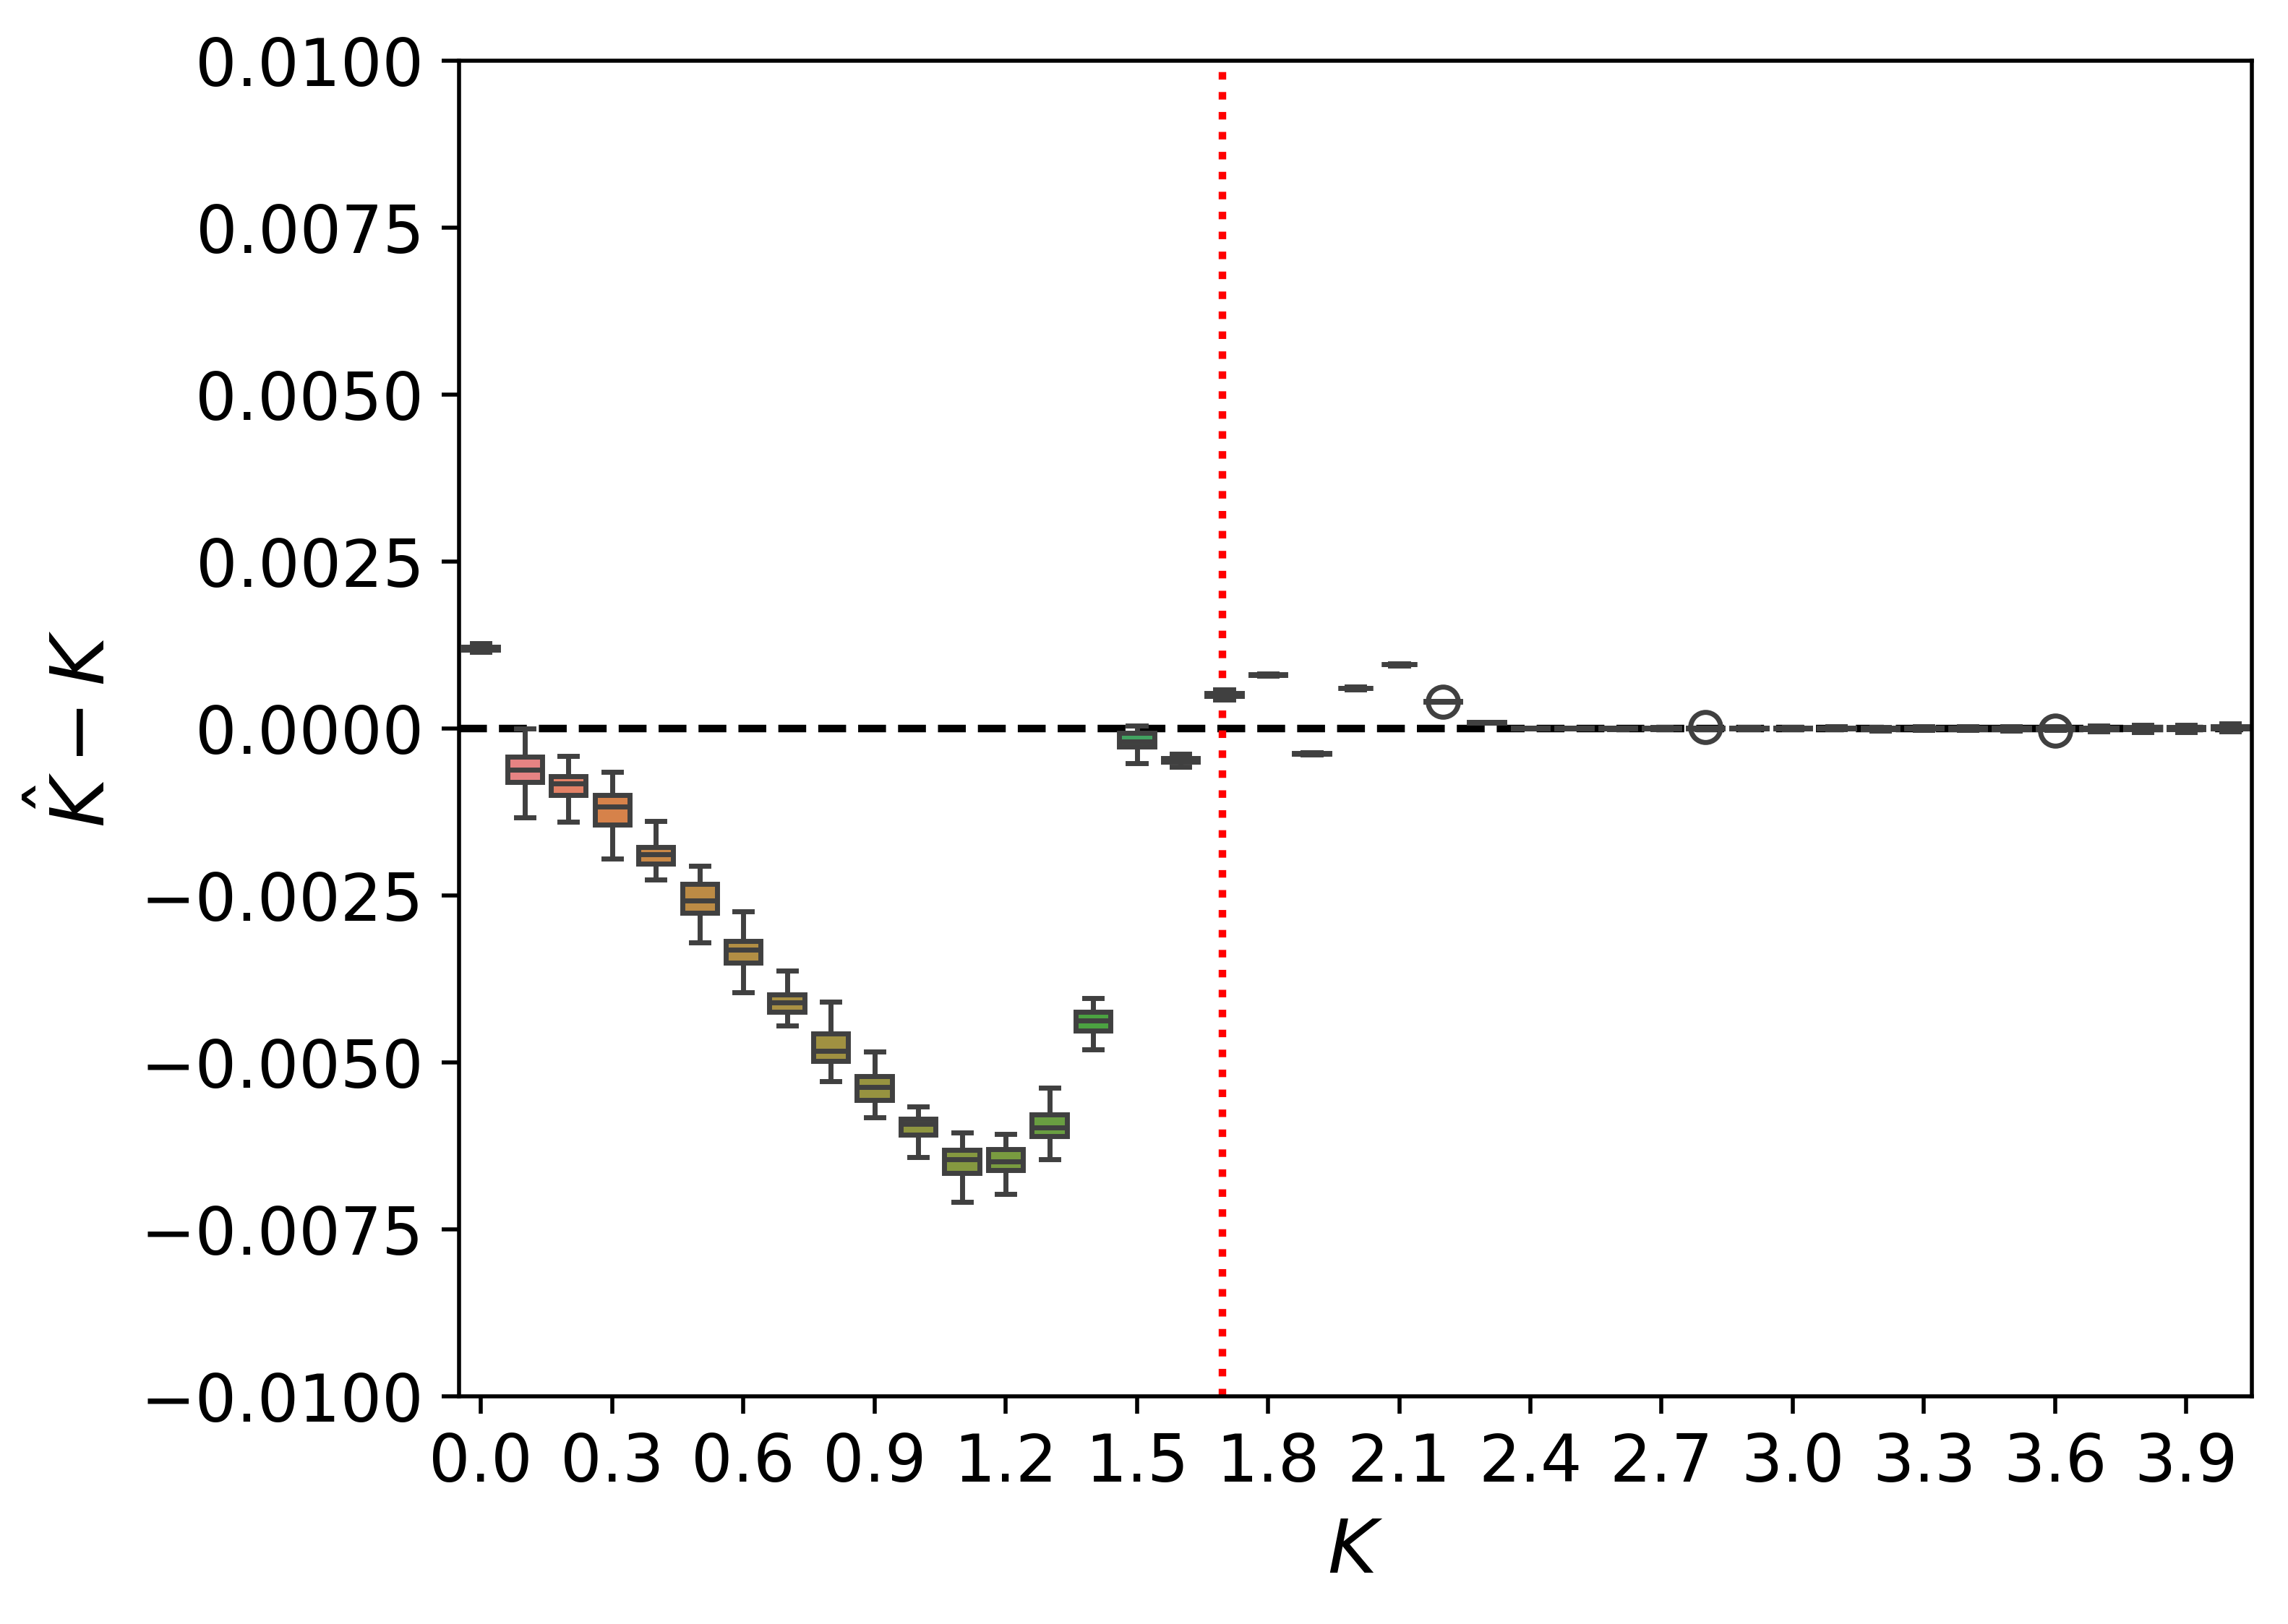

In [707]:
# plt.plot(Ks,(KK-Ks).T,'.');
plt.figure(dpi=500)
sns.boxplot(data=(KK-Ks))
# plt.xticks((np.arange(21)+1)[::3],[0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6])
plt.xticks((np.arange(len(Ks)))[::3],np.round(Ks[::3],2))
plt.axhline(0,zorder=-10,ls='--',color='black')
plt.axvline(K_c/0.1+1,zorder=-10,ls=':',color='red')
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$\hat{K} - K$',fontsize=15)
# plt.title('Box plot of KK - Ks')
plt.ylim(-0.01,0.01)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

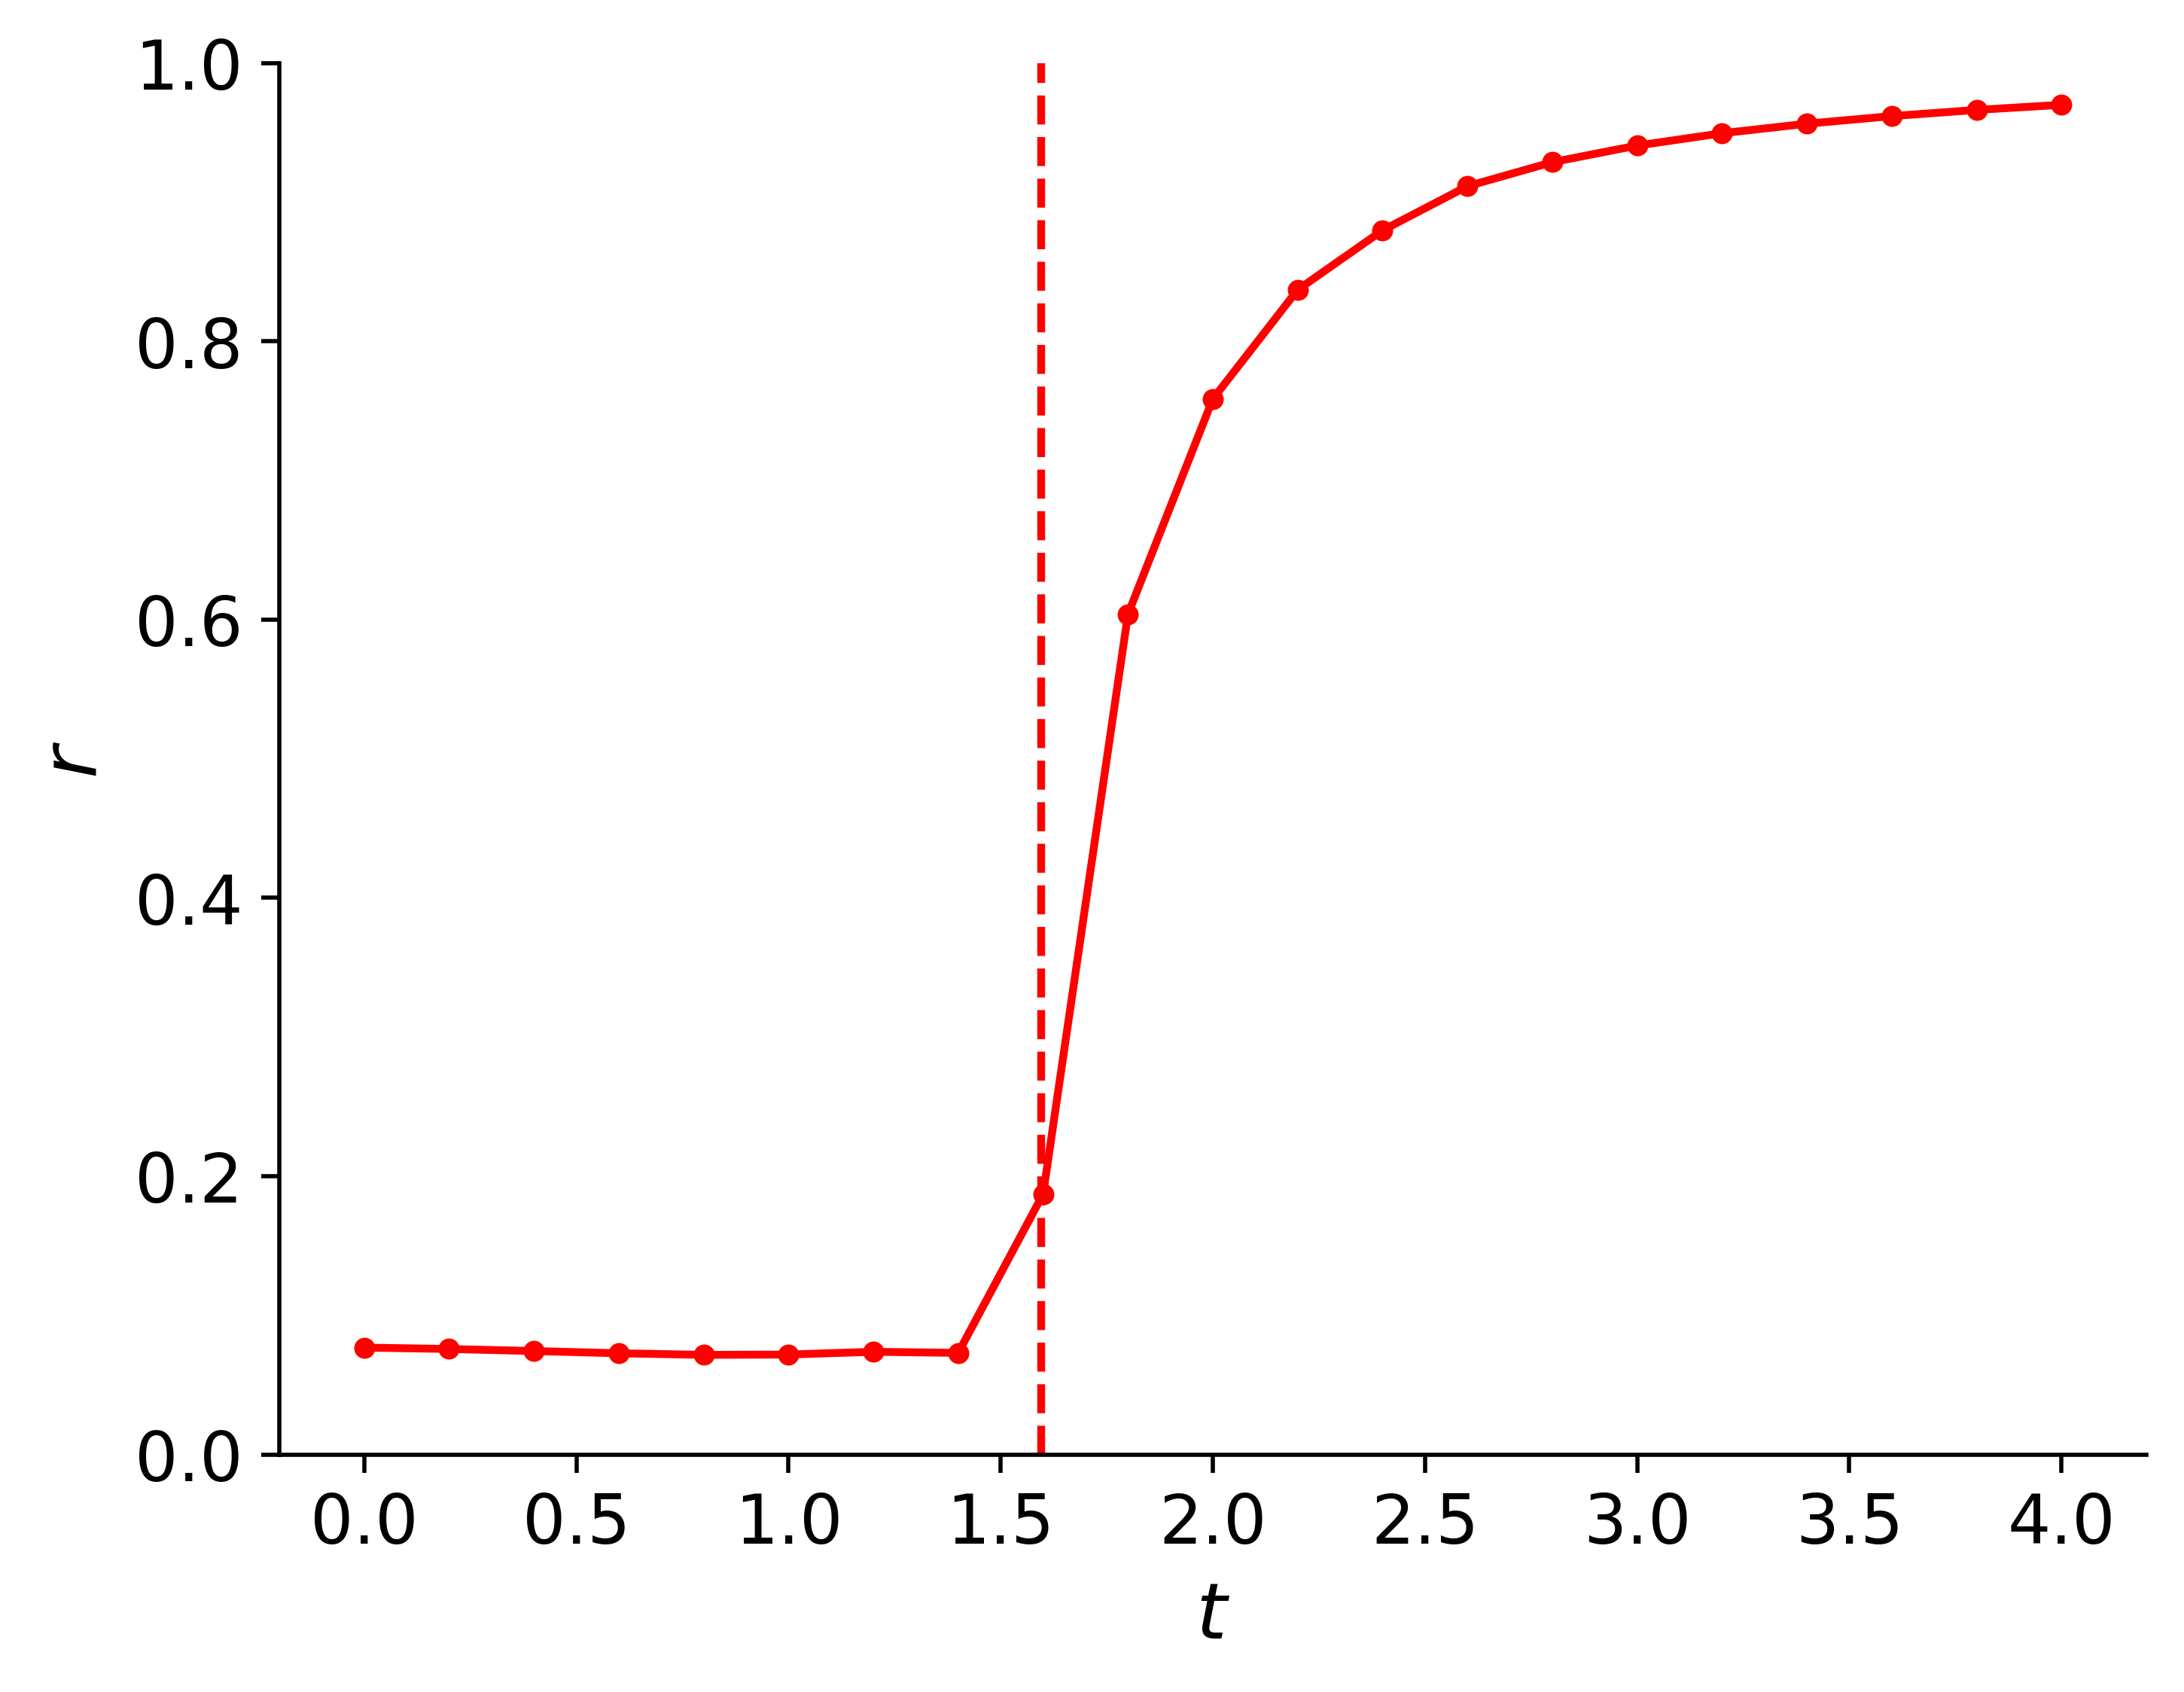

In [659]:
plt.figure(dpi=500)
rr = df['r'].to_numpy()
r_mean =np.nanmean(rr,axis=0)
r_std =np.nanstd(rr,axis=0)
plt.plot(Ks,r_mean,'.',color='Orange')
plt.fill_between(Ks,r_mean-r_std,r_mean+r_std,alpha=0.3,color='Orange')
plt.plot(Ks,K_rs,'.-',color='red')
plt.ylim(0,1)
# plt.axhline(0)
plt.axvline(K_c,ls='--',color='red')

plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [2273]:
df_EKF = df

# EnKF

In [164]:
import numpy as np
from numba import njit, prange

# ---------------------------
# Angle helpers (JIT)
# ---------------------------
@njit(fastmath=True)
def wrap_angle(a):
    # (-pi, pi]로 래핑
    v = a + np.pi
    v = v - 2.0*np.pi * np.floor(v / (2.0*np.pi))
    return v - np.pi

@njit(fastmath=True)
def wrap_angle_vec(v):
    out = np.empty_like(v)
    for i in range(v.size):
        out[i] = wrap_angle(v[i])
    return out

@njit(fastmath=True)
def order_params(T):
    # X=mean(cos), Y=mean(sin)
    csum = 0.0
    ssum = 0.0
    N = T.size
    for i in range(N):
        csum += np.cos(T[i])
        ssum += np.sin(T[i])
    invN = 1.0/N
    return csum*invN, ssum*invN

@njit(fastmath=True)
def h_measure(T):
    X, Y = order_params(T)
    return np.sqrt(X*X + Y*Y)   # R in [0,1]

# ---------------------------
# Forecast step (O(N), JIT)
# ---------------------------
@njit(fastmath=True)
def forecast_one(theta, K, omega, dt):
    # dθ_i = ω_i + K * (Y cosθ_i - X sinθ_i)
    X, Y = order_params(theta)
    N = theta.size
    theta_new = np.empty_like(theta)
    for i in range(N):
        th = theta[i]
        dtheta = omega[i] + K*(Y*np.cos(th) - X*np.sin(th))
        theta_new[i] = wrap_angle(th + dt*dtheta)
    return theta_new, K  # K는 random-walk: 잡음은 따로 더함

@njit(fastmath=True, parallel=True)
def forecast_ensemble(Ens, omega, dt, q_theta_std, q_K_std):
    # Ens: shape (N+1, M)  [0..N-1: theta dims, N: K]
    Np1, M = Ens.shape
    N = Np1 - 1
    for m in prange(M):
        theta = Ens[:N, m]
        K     = Ens[N,  m]
        theta_f, K_f = forecast_one(theta, K, omega, dt)
        # 과정잡음 추가
        if q_theta_std > 0.0:
            for i in range(N):
                theta_f[i] = wrap_angle(theta_f[i] + q_theta_std*np.random.randn())
        if q_K_std > 0.0:
            K_f = K_f + q_K_std*np.random.randn()
        Ens[:N, m] = theta_f
        Ens[N,  m] = K_f

# ---------------------------
# Ensemble mean / anomalies (JIT)
# ---------------------------
@njit(fastmath=True)
def circular_mean_by_dim(E_theta):  # E_theta: (N, M)
    N, M = E_theta.shape
    mean_theta = np.empty(N)
    for i in range(N):
        C = 0.0; S = 0.0
        for m in range(M):
            th = E_theta[i, m]
            C += np.cos(th); S += np.sin(th)
        mean_theta[i] = np.arctan2(S, C)
    return mean_theta

@njit(fastmath=True, parallel=True)
def anomalies(E_theta, mean_theta, E_K, mean_K):
    # 반환: A_theta (N,M), A_K (M,)
    N, M = E_theta.shape
    A_theta = np.empty((N, M))
    A_K     = np.empty(M)
    for m in prange(M):
        for i in range(N):
            A_theta[i, m] = wrap_angle(E_theta[i, m] - mean_theta[i])  # 각도 잔차
        A_K[m] = E_K[m] - mean_K
    return A_theta, A_K

@njit(fastmath=True)
def diag_var_from_ensemble(E_theta, mean_theta, E_K, mean_K):
    # 진단용: 각 차원의 분산(표본) 추정 (diag of sample cov)
    N, M = E_theta.shape
    var_diag = np.empty(N+1)
    inv = 1.0 / (M-1) if M > 1 else 0.0
    for i in range(N):
        acc = 0.0
        for m in range(M):
            d = wrap_angle(E_theta[i, m] - mean_theta[i])
            acc += d*d
        var_diag[i] = acc * inv
    # K
    acc = 0.0
    for m in range(M):
        d = E_K[m] - mean_K
        acc += d*d
    var_diag[N] = acc * inv
    return var_diag

# ---------------------------
# Analysis step (stochastic EnKF, scalar obs) (JIT)
# ---------------------------
@njit(fastmath=True)
def analysis_scalar(Ens, z_meas, R_var, inflation):
    # Ens: (N+1, M)
    Np1, M = Ens.shape
    N = Np1 - 1
    # (1) 예측 평균
    mean_theta = circular_mean_by_dim(Ens[:N, :])
    mean_K = 0.0
    for m in range(M):
        mean_K += Ens[N, m]
    mean_K /= M

    # (2) 예측 잔차(불확실도) + 인플레이션
    A_theta, A_K = anomalies(Ens[:N, :], mean_theta, Ens[N, :], mean_K)
    if inflation != 1.0:
        for m in range(M):
            for i in range(N):
                A_theta[i, m] *= inflation
            A_K[m] *= inflation

    # (3) 관측 예측
    y = np.empty(M)
    for m in range(M):
        y[m] = h_measure(Ens[:N, m])
    # 예측 관측 평균
    y_bar = 0.0
    for m in range(M):
        y_bar += y[m]
    y_bar /= M
    # 관측 잔차
    y_anom = y - y_bar

    # (4) 공분산 및 칼만 이득
    inv = 1.0 / (M - 1) if M > 1 else 0.0

    # P_yy
    s_yy = 0.0
    for m in range(M):
        s_yy += y_anom[m]*y_anom[m]
    P_yy = s_yy * inv + R_var
    if P_yy < 1e-12:
        P_yy = 1e-12

    # P_xy (n x 1)
    K_gain = np.empty(N+1)
    # theta 부분
    for i in range(N):
        acc = 0.0
        for m in range(M):
            acc += A_theta[i, m] * y_anom[m]
        K_gain[i] = (acc * inv) / P_yy
    # K 성분
    acc = 0.0
    for m in range(M):
        acc += A_K[m] * y_anom[m]
    K_gain[N] = (acc * inv) / P_yy

    # (5) 퍼터브드 관측으로 개별 업데이트
    stdR = np.sqrt(R_var)
    for m in range(M):
        y_tilde = z_meas + stdR*np.random.randn()
        innov = y_tilde - y[m]
        # 상태 업데이트
        for i in range(N):
            Ens[i, m] = wrap_angle(Ens[i, m] + K_gain[i]*innov)
        Ens[N, m] = Ens[N, m] + K_gain[N]*innov

    return y_bar, mean_theta, mean_K

# ---------------------------
# Top-level EnKF runner
# ---------------------------
def enkf_thetas_numba(
    rs, t, theta0, K0, omega, *,
    M=128,               # 앙상블 크기
    R_meas=1e-8,         # 관측 잡음 분산
    Q_theta=0.0,         # 위상 과정잡음 표준편차가 아니라 '분산'을 넣고 싶다면 아래서 sqrt
    Q_K=1e-8,
    init_theta_std=1e-2,
    init_K_std=1e-2,
    inflation=1.02,      # 1.0이면 사용 안 함
    seed=0
):
    rs = np.asarray(rs, dtype=np.float64)
    t  = np.asarray(t,  dtype=np.float64)
    theta0 = np.asarray(theta0, dtype=np.float64)
    omega  = np.asarray(omega,  dtype=np.float64)

    N = theta0.size
    dt = float(t[1]-t[0]) if len(t) > 1 else 1.0
    rng = np.random.default_rng(seed)

    # 초기 앙상블 (작은 랜덤 퍼터베이션)
    Ens = np.empty((N+1, M), dtype=np.float64)
    for m in range(M):
        Ens[:N, m] = wrap_angle_vec(theta0 + init_theta_std * rng.standard_normal(N))
        Ens[N,  m] = float(K0 + init_K_std * rng.standard_normal())

    # 로그 저장
    Tn = len(t)
    x_means = np.zeros((Tn, N+1))
    P_diag  = np.zeros((Tn, N+1))
    z_hats  = np.zeros(Tn)

    # 첫 시각 기록
    mean_theta0 = circular_mean_by_dim(Ens[:N, :])
    mean_K0     = float(np.mean(Ens[N, :]))
    x_means[0, :N] = mean_theta0
    x_means[0,  N] = mean_K0
    P_diag[0]      = diag_var_from_ensemble(Ens[:N, :], mean_theta0, Ens[N, :], mean_K0)
    z_hats[0]      = h_measure(mean_theta0)

    q_theta_std = np.sqrt(Q_theta) if Q_theta > 0 else 0.0
    q_K_std     = np.sqrt(Q_K)     if Q_K     > 0 else 0.0

    for k in range(1, Tn):
        z_meas = float(rs[k])  # 필요시 np.clip(z_meas,1e-9,1.0) 가능

        # ---- Forecast ----
        forecast_ensemble(Ens, omega, dt, q_theta_std, q_K_std)

        # ---- Analysis ----
        z_bar, mean_theta, mean_K = analysis_scalar(Ens, z_meas, R_meas, inflation)

        # 로그
        x_means[k, :N] = mean_theta
        x_means[k,  N] = mean_K
        P_diag[k]      = diag_var_from_ensemble(Ens[:N, :], mean_theta, Ens[N, :], mean_K)
        z_hats[k]      = z_bar

    return x_means, P_diag, z_hats, Ens


In [208]:
seed = 1
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)

theta_random = np.ones(N)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.01
t = np.arange(0,40,dt)
K = 2.0
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)

(array([2., 3., 5., 7., 8., 8., 7., 5., 3., 2.]),
 array([-2.0619165, -1.6495332, -1.2371499, -0.8247666, -0.4123833,
         0.       ,  0.4123833,  0.8247666,  1.2371499,  1.6495332,
         2.0619165]),
 <BarContainer object of 10 artists>)

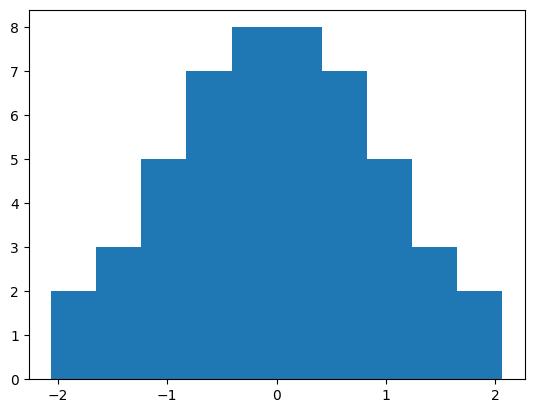

In [212]:
plt.hist(omega)

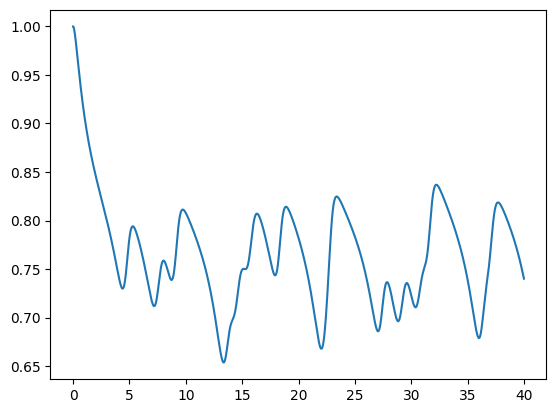

In [209]:
plt.plot(t,rs)

In [210]:
# theta_random = np.random.uniform(0,2*np.pi,N)

In [203]:
# 주어진 것: rs (측정된 R_t), t (시간축), theta_random (초기 위상 N개), omega (자연주파수), K 초기값
x_means, P_diag, z_hats, Ens_final = enkf_thetas_numba(
    rs=rs, t=t,
    theta0=theta_random,
    K0=K +1,
    omega=omega,
    M=128,            # 64~256 권장
    R_meas=1e-8,
    Q_theta=0.0,      # 결정적 모델이면 0 또는 아주 작게
    Q_K=1e-8,
    init_theta_std=1e-2,
    init_K_std=1e-2,
    inflation=1.02,   # 필수는 아니지만 수렴 속도/안정화에 도움
    seed=42
)

K_est = x_means[:, -1]   # 시간에 따른 K 추정치
R_pred = z_hats          # 예측된 R(t)


In [204]:
K_ests = {}
R_preds = {}
Ks = np.arange(0,4.1,0.2)
for K_init in tqdm(Ks):
    x_means, P_diag, z_hats, Ens_final = enkf_thetas_numba(
        rs=rs, t=t,
        theta0=theta_random,
        K0=K_init,
        omega=omega,
        M=128,            # 64~256 권장
        R_meas=1e-8,
        Q_theta=0.0,      # 결정적 모델이면 0 또는 아주 작게
        Q_K=1e-8,
        init_theta_std=1e-2,
        init_K_std=1e-2,
        inflation=1.02,   # 필수는 아니지만 수렴 속도/안정화에 도움
        seed=42
    )
    K_ests[K_init] = x_means[:, -1]
    R_preds[K_init] = z_hats



  0%|          | 0/21 [00:00<?, ?it/s]

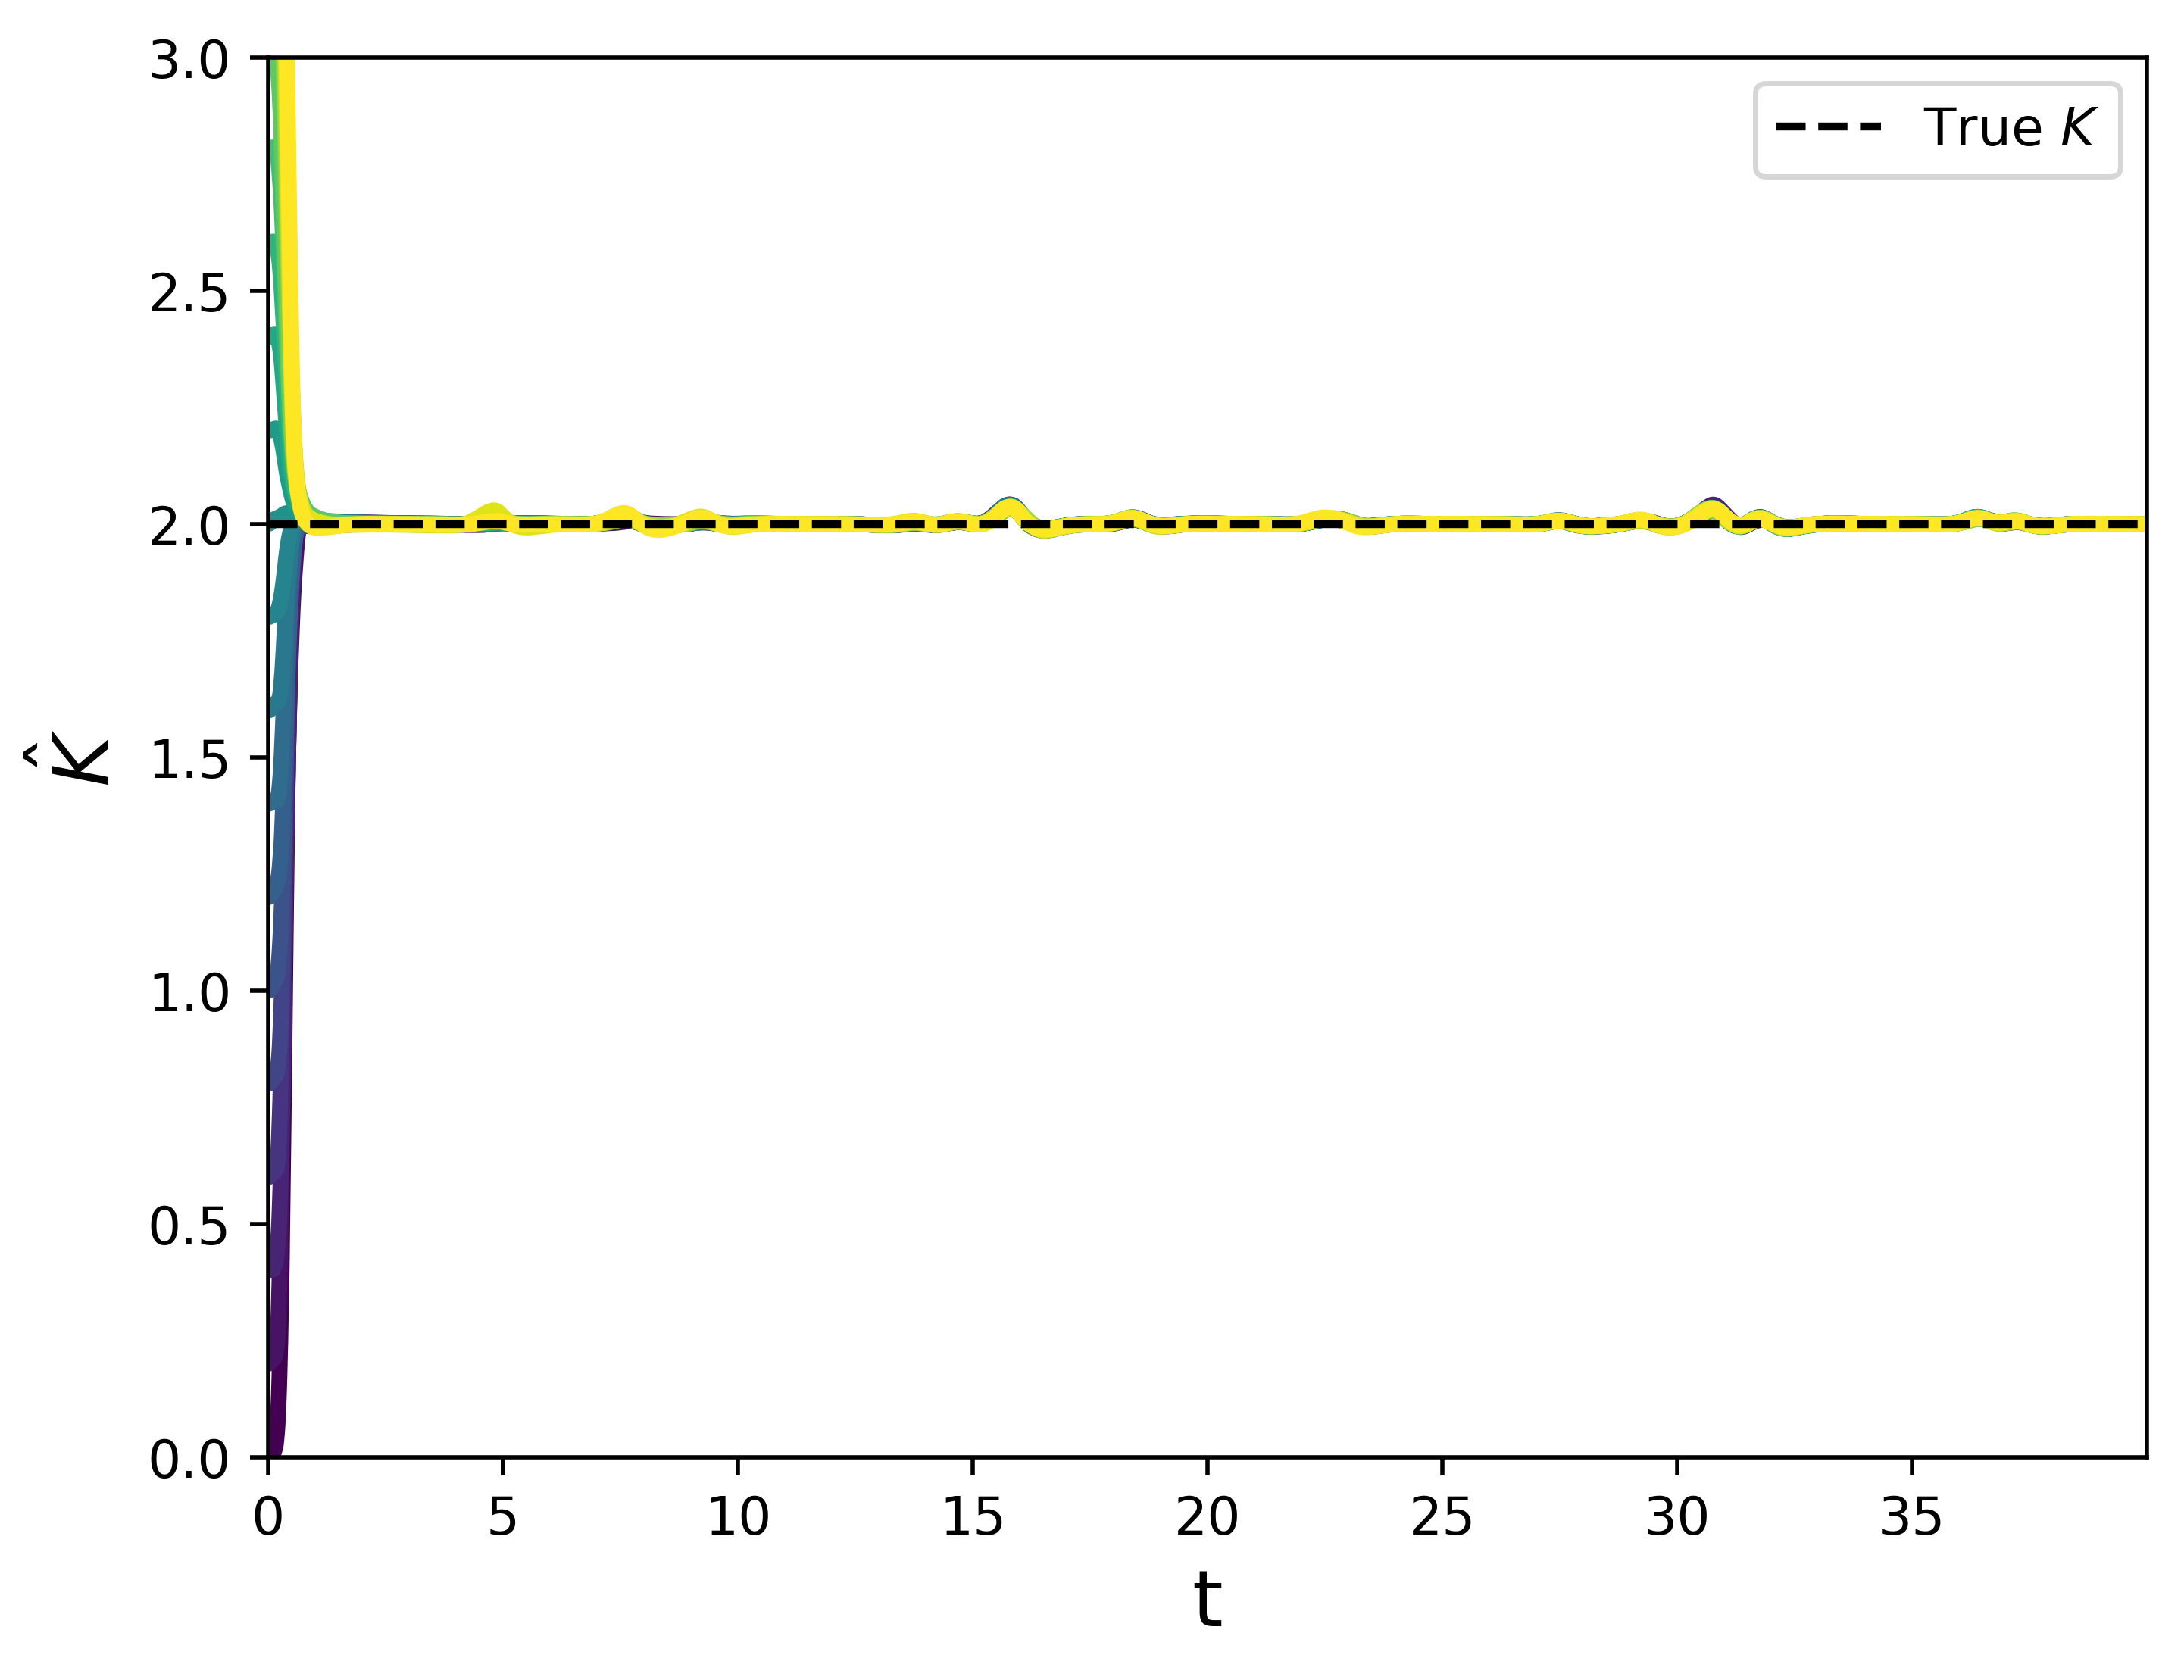

In [205]:
color = plt.cm.viridis(np.linspace(0,1,len(Ks)))
plt.figure(dpi=500)
for i,K_init in enumerate(Ks):
    plt.plot(t,K_ests[K_init],color=color[i],lw=3)
plt.axhline(K,color='black',ls='--',label=r'True ${K}$')
plt.ylim(0,K+1)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,t.max())

plt.legend()

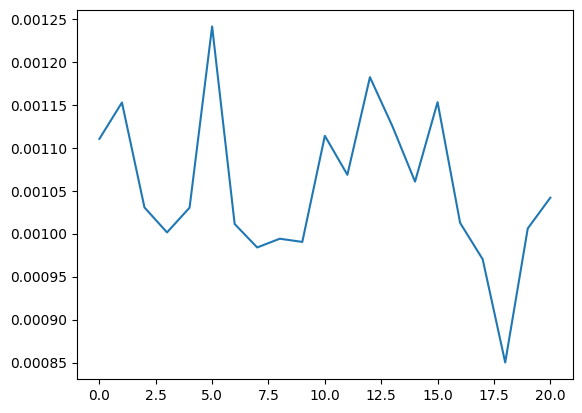

In [206]:
plt.plot(np.mean(np.array(list(K_ests.values()))[:,-500:]-K,axis=1))

ValueError: x and y must have same first dimension, but have shapes (4000,) and (41, 4000)

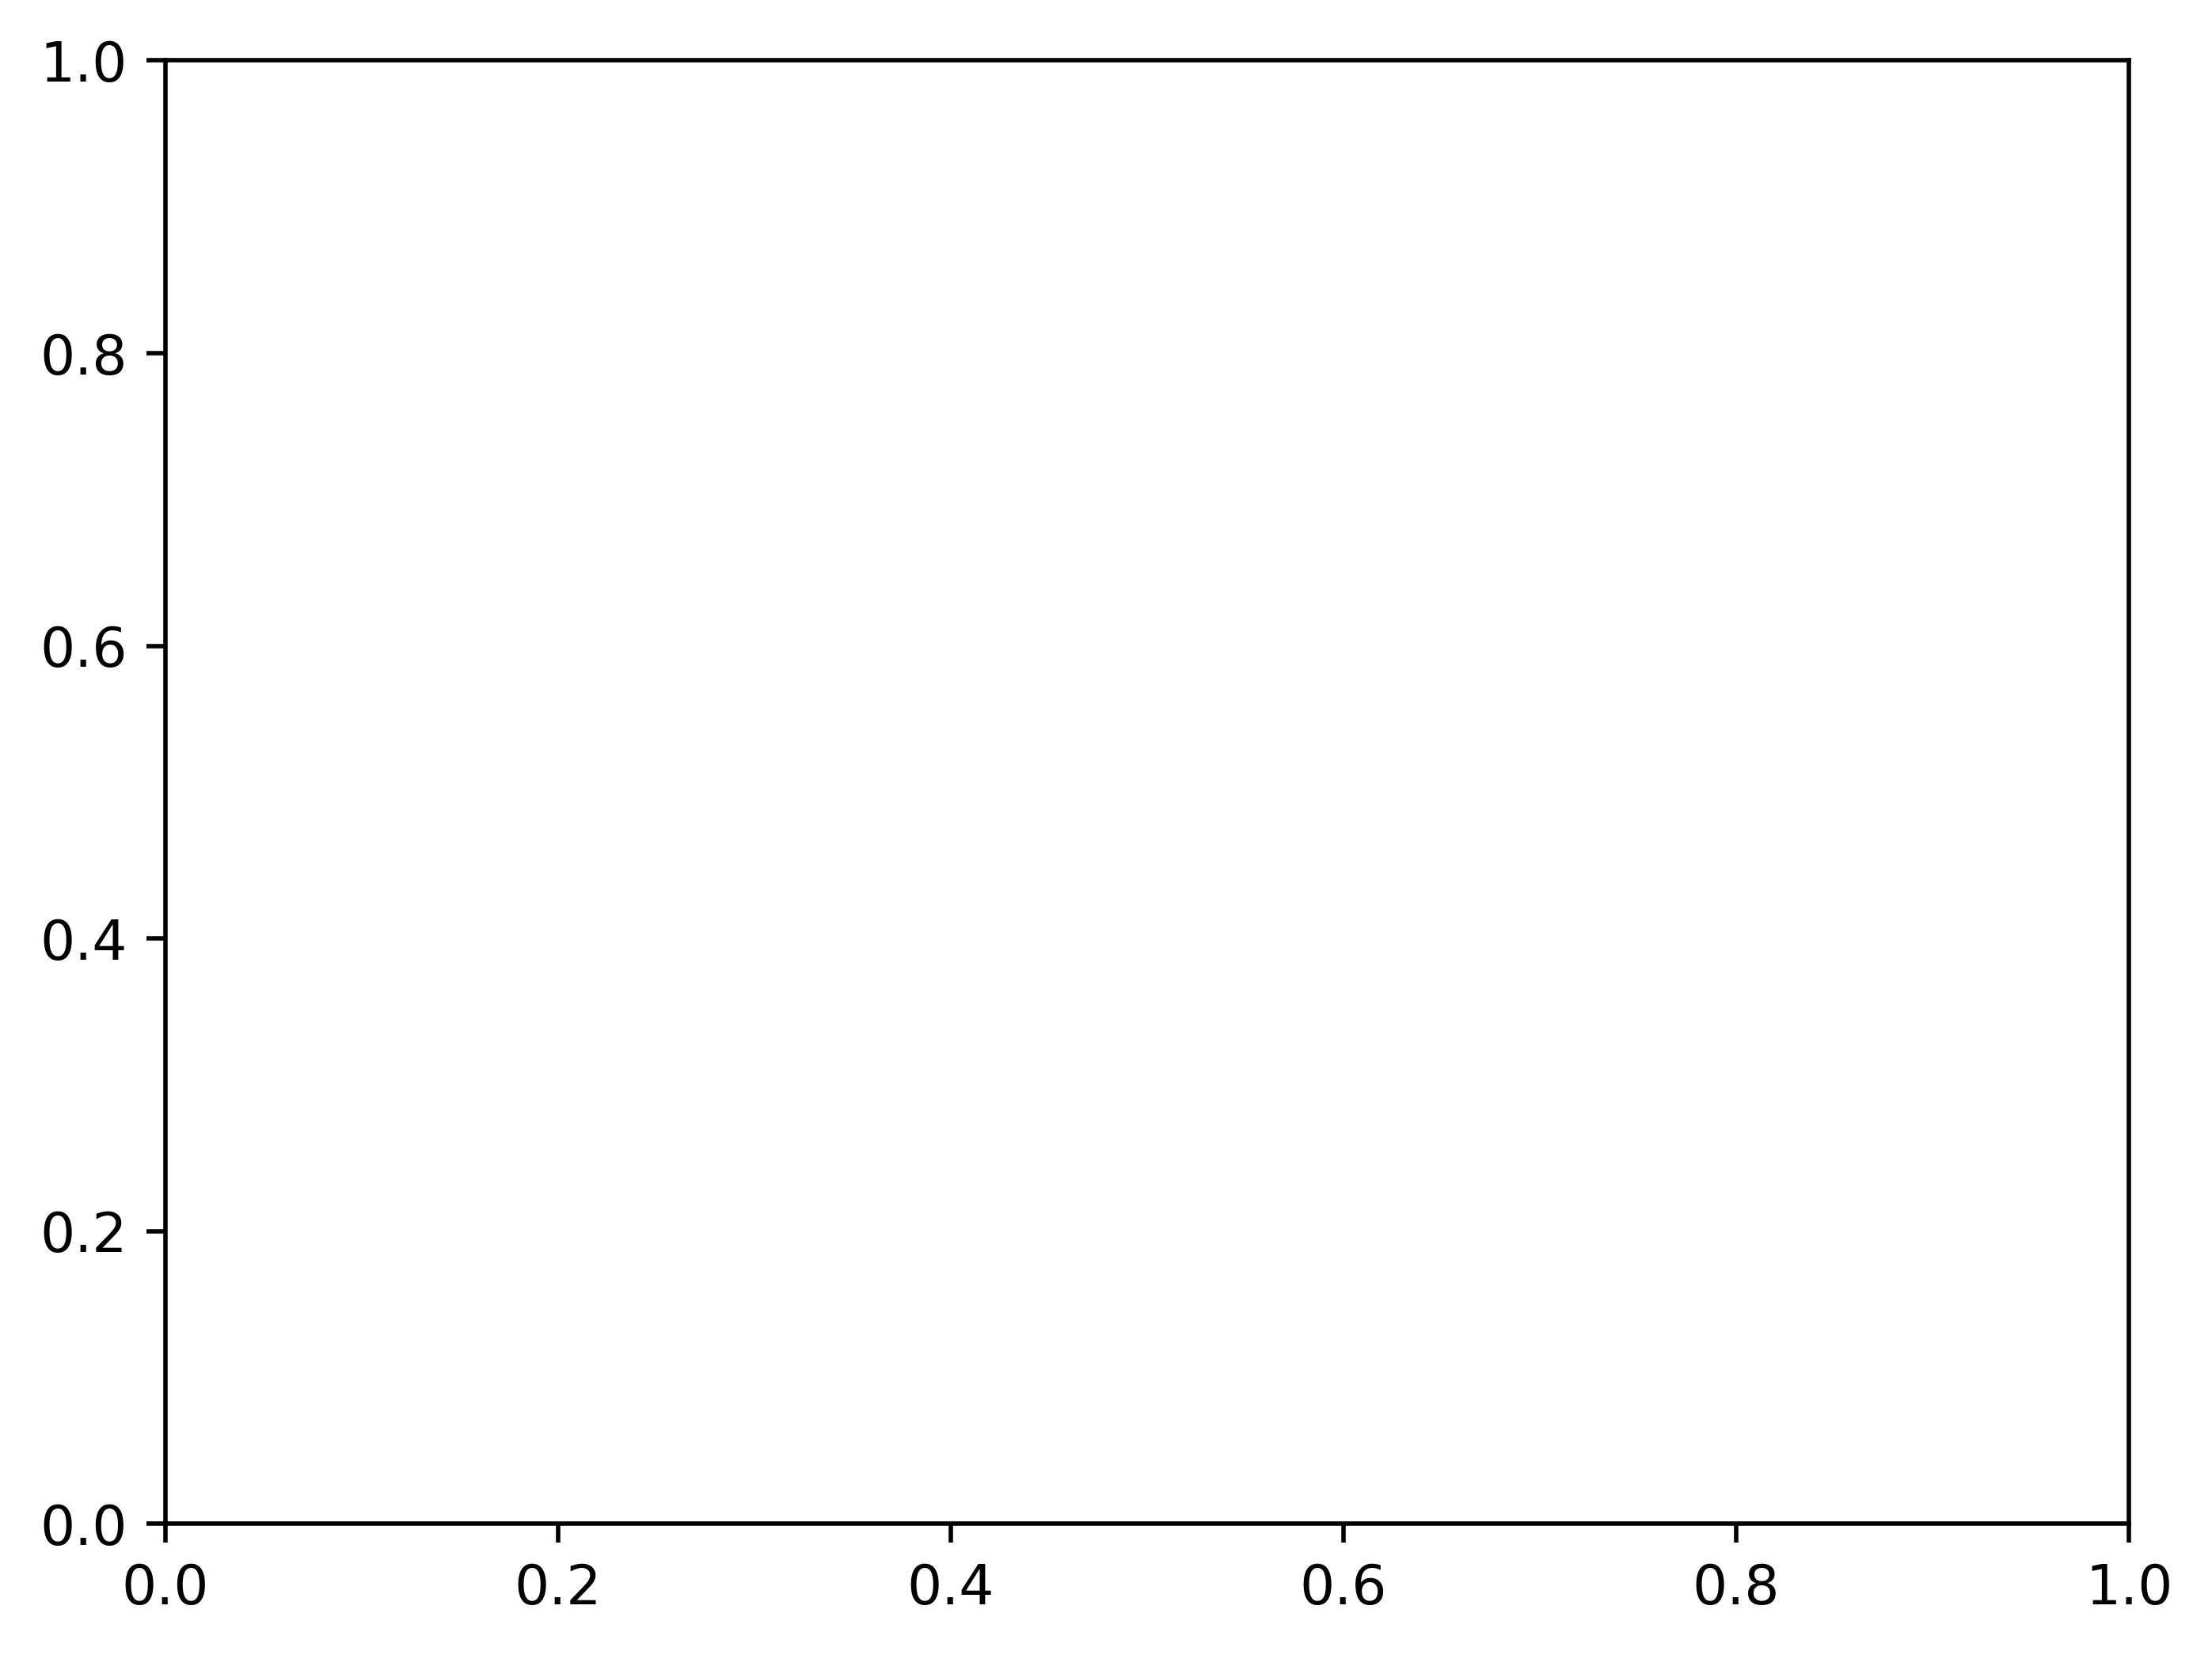

In [190]:
plt.figure(dpi=500)
plt.plot(t,K_ests.values(),color='blue',lw=3)
plt.axhline(K,color='black',ls='--',label=r'True ${K}$')
plt.ylim(0,K+1)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,t.max())
plt.legend()

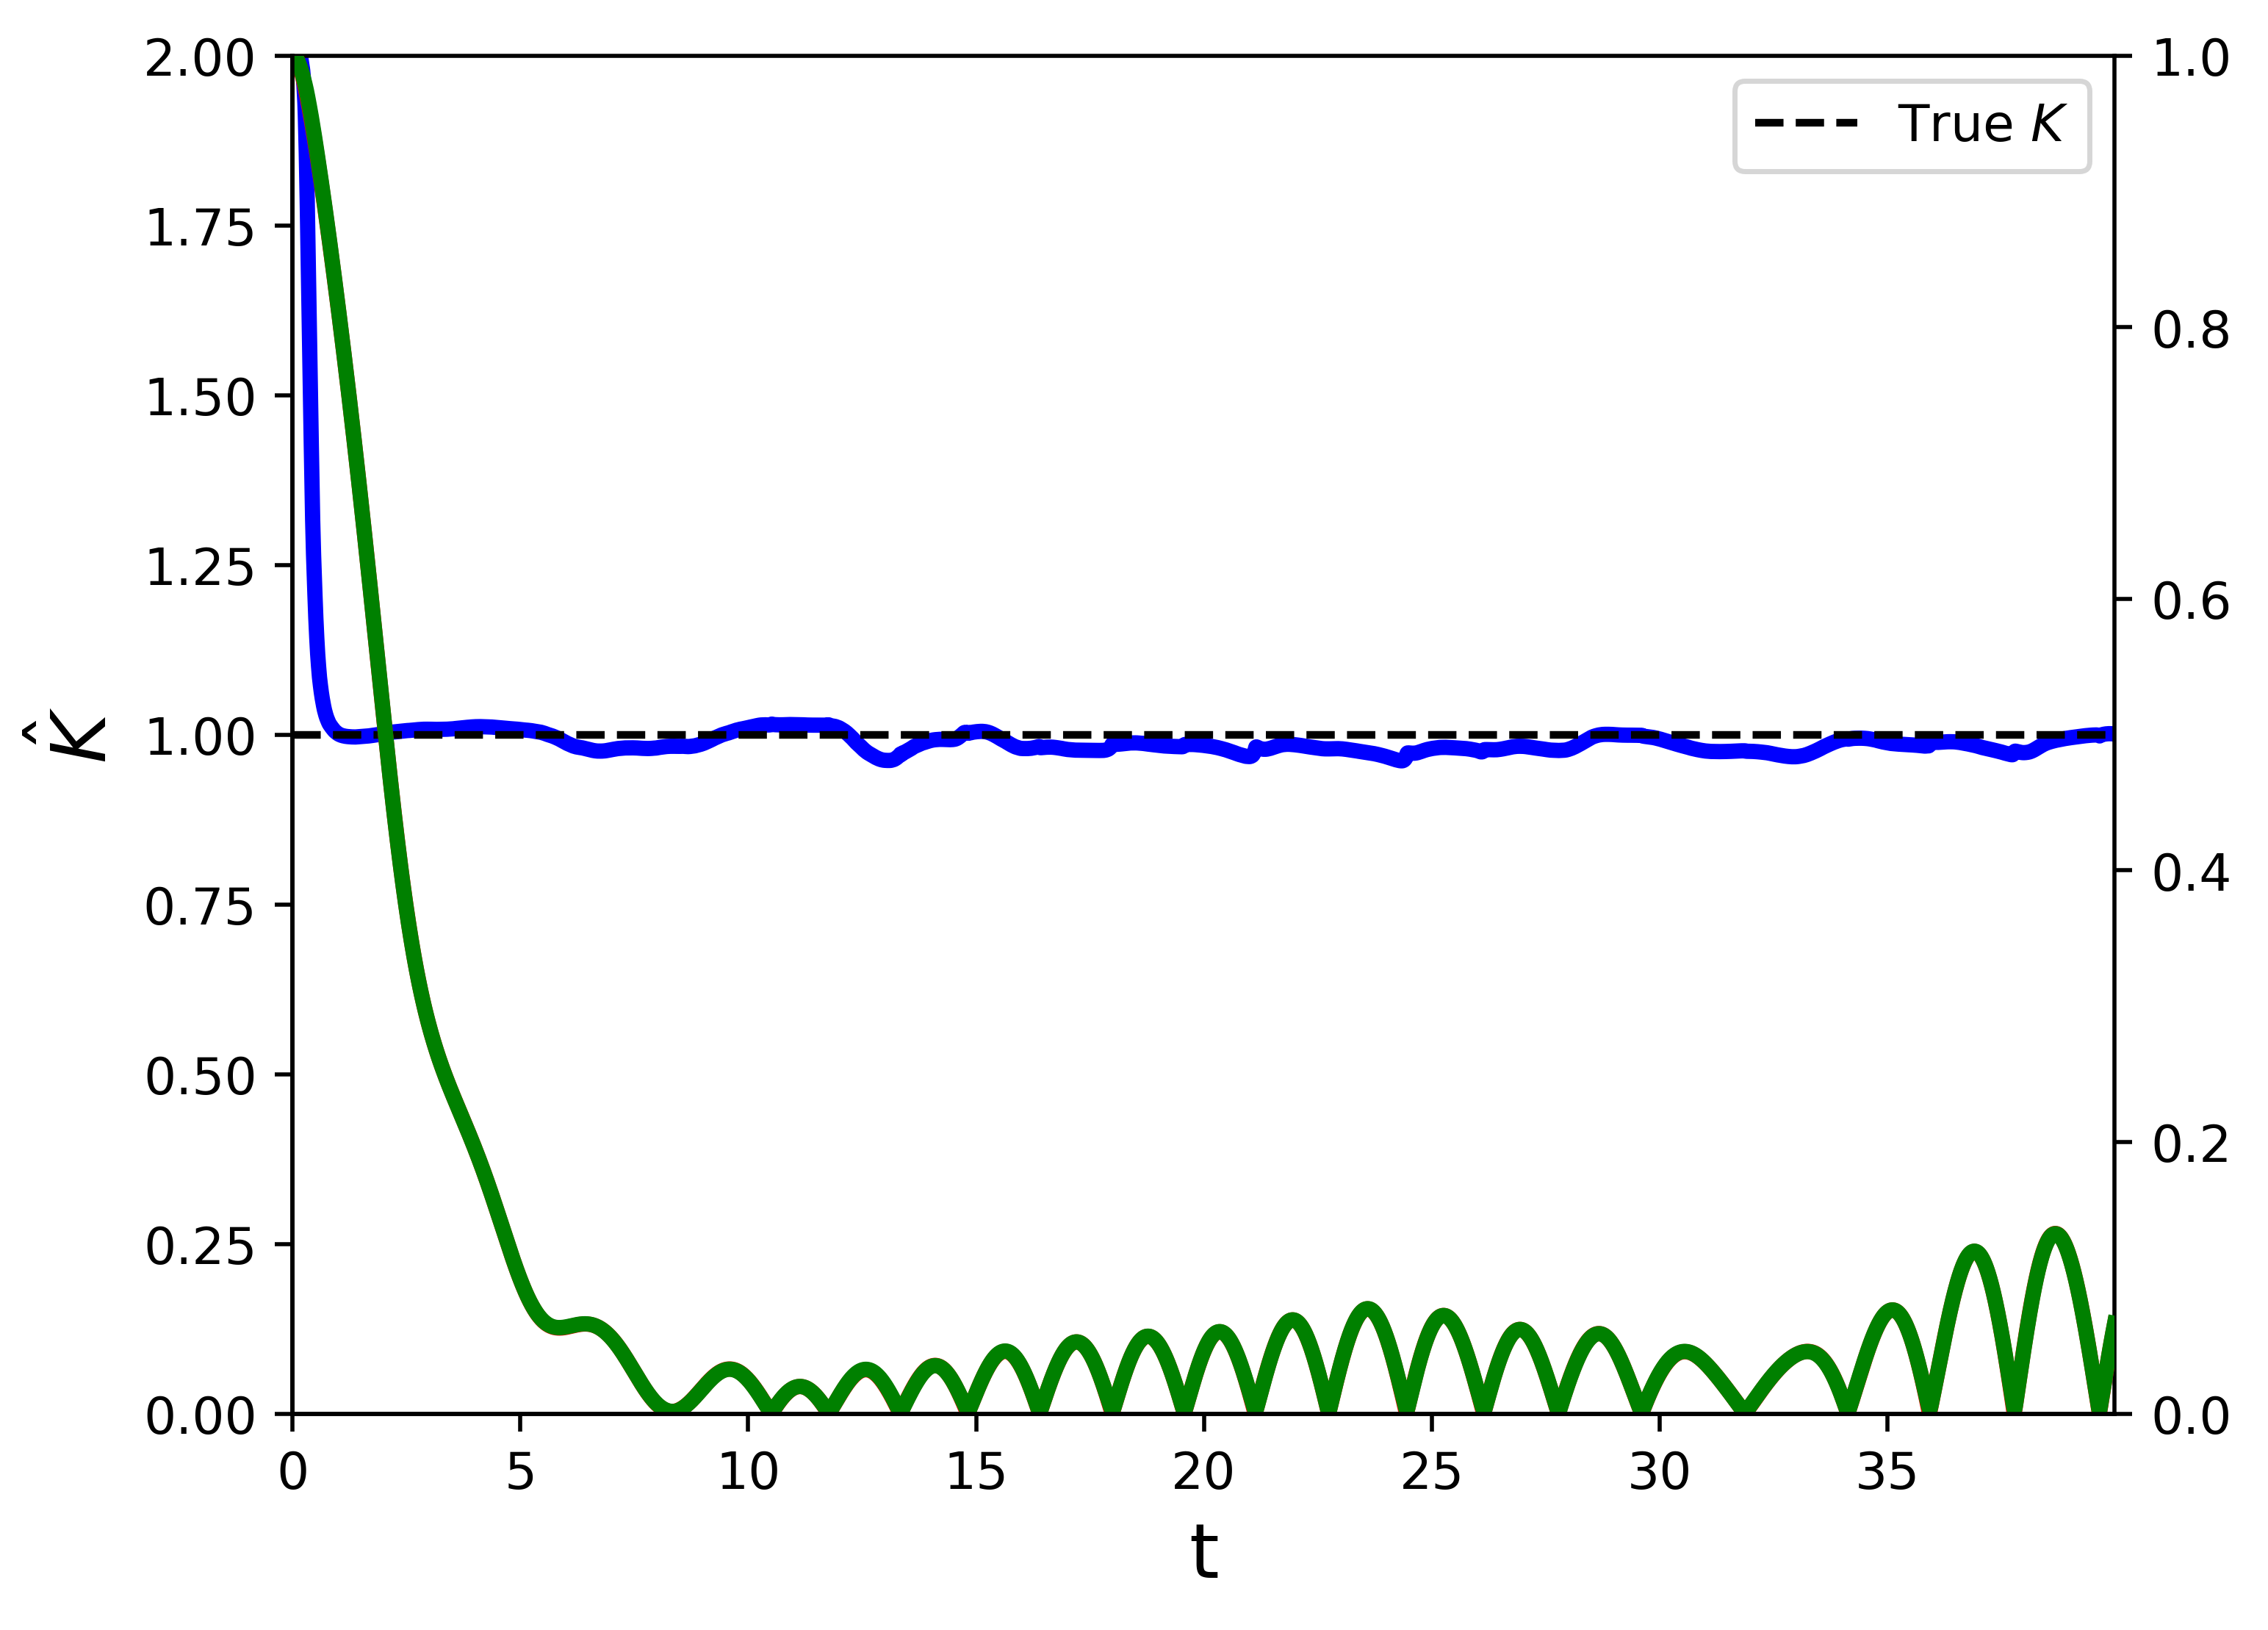

In [ ]:
plt.figure(dpi=500)
# plt.plot(t,x_hats[:,-1],color='blue',lw=3)
plt.plot(t,K_est,color='blue',lw=3)
plt.axhline(K,color='black',ls='--',label=r'True ${K}$')
plt.ylim(0,K+1)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,t.max())
plt.legend()

plt.twinx()
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,R_pred,color='green',lw=3)
plt.ylim(0,1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [165]:
Ks = np.arange(0,4.1,0.1)
seed =None
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)
# theta_random = np.ones(N)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.01
t = np.arange(0,40,dt)

K_rs = []
K_est = {}

# 가정: N, dt, f, F_j, h, H_j, omega, rs, t 가 이미 정의됨
# 수치 바닥
epsP  = 1e-12   # P 바닥
epsS  = 1e-10   # S 바닥
jitterP = 1e-8  # P 예측단계 정칙화



for K in tqdm(Ks):
    theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
    r_mean = np.mean(rs[-500:])
    K_rs.append(r_mean)
    K_est['r',K] = []
    K_est['K',K] = []

    
    # for num in tqdm(range(50)):
    @parfor(np.arange(50),bar=False)
    def get_r_K_mean(num):
        x_means, P_diag, z_hats, Ens_final = enkf_thetas_numba(
            rs=rs, t=t,
            theta0=theta_random,
            K0=K +1,
            omega=omega,
            M=128,            # 64~256 권장
            R_meas=1e-8,
            Q_theta=0.0,      # 결정적 모델이면 0 또는 아주 작게
            Q_K=1e-8,
            init_theta_std=1e-2,
            init_K_std=1e-2,
            inflation=1.02,   # 필수는 아니지만 수렴 속도/안정화에 도움
            seed=42
        )

        K_est = x_means[:, -1]   # 시간에 따른 K 추정치
        R_pred = z_hats          # 예측된 R(t)


        K_estm = np.mean(K_est[-500:]) 
        r_estm = np.mean(z_hats[-500:]) 
        return K_estm,r_estm
    K_ests,r_ests = zip(*get_r_K_mean)
    K_est['K',K] = K_ests
    K_est['r',K] = r_ests



  0%|          | 0/41 [00:00<?, ?it/s]

In [177]:
from scipy.stats import norm
import seaborn as sns

In [166]:
df = pd.DataFrame(K_est)

In [167]:
q1 = df['K'].quantile(0.25)
q2 = df['K'].quantile(0.5)
q3 = df['K'].quantile(0.75)
iqr = q3 - q1
iqr

0.0    0.041085
0.1    0.048764
0.2    0.056766
0.3    0.043072
0.4    0.039768
0.5    0.030193
0.6    0.037981
0.7    0.037223
0.8    0.025679
0.9    0.024678
1.0    0.041189
1.1    0.021660
1.2    0.027399
1.3    0.033627
1.4    0.856981
1.5    0.033180
1.6    0.029573
1.7    0.005996
1.8    0.002314
1.9    0.002943
2.0    0.001167
2.1    0.010204
2.2    0.000498
2.3    0.000102
2.4    0.386431
2.5    0.578187
2.6    0.000024
2.7    0.000025
2.8    1.293992
2.9    0.000026
3.0    0.000034
3.1    0.000027
3.2    0.000032
3.3    0.000027
3.4    0.000026
3.5    0.000048
3.6    0.000038
3.7    0.000049
3.8    0.000043
3.9    0.000036
4.0    0.000067
dtype: float64

In [173]:
# IQR 계산
Q1 = df['K'].quantile(0.25)
Q3 = df['K'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 정의
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 각 column마다 이상치를 NaN으로 대체
for col in df['K'].columns:
    df['K', col] = df['K', col].apply(lambda x: x if lower_bound[col] <= x <= upper_bound[col] else np.nan)
    df['r', col] = df['r', col].where(df['K', col].notna(), np.nan)

In [174]:
K_c = 2/(np.pi*norm.pdf(0,0,1))

(-0.5, 0.5)

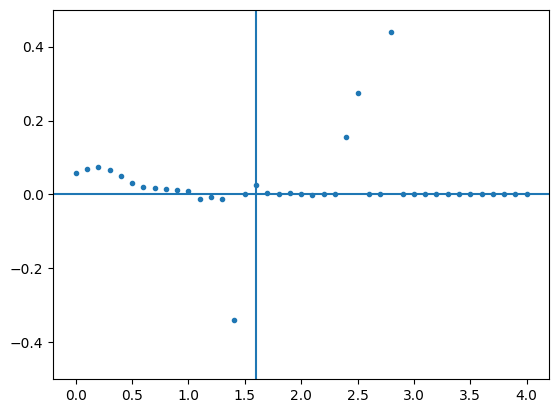

In [178]:
KK = df['K'].to_numpy()
K_mean =np.nanmean(KK,axis=0)
K_std =np.nanstd(KK,axis=0)
plt.plot(Ks,K_mean-Ks,'.')
# plt.fill_between(Ks,K_mean-K_std,K_mean+K_std,alpha=0.3)
# plt.plot(Ks,Ks)
plt.axhline(0)
plt.axvline(K_c)
plt.ylim(-0.5,0.5)

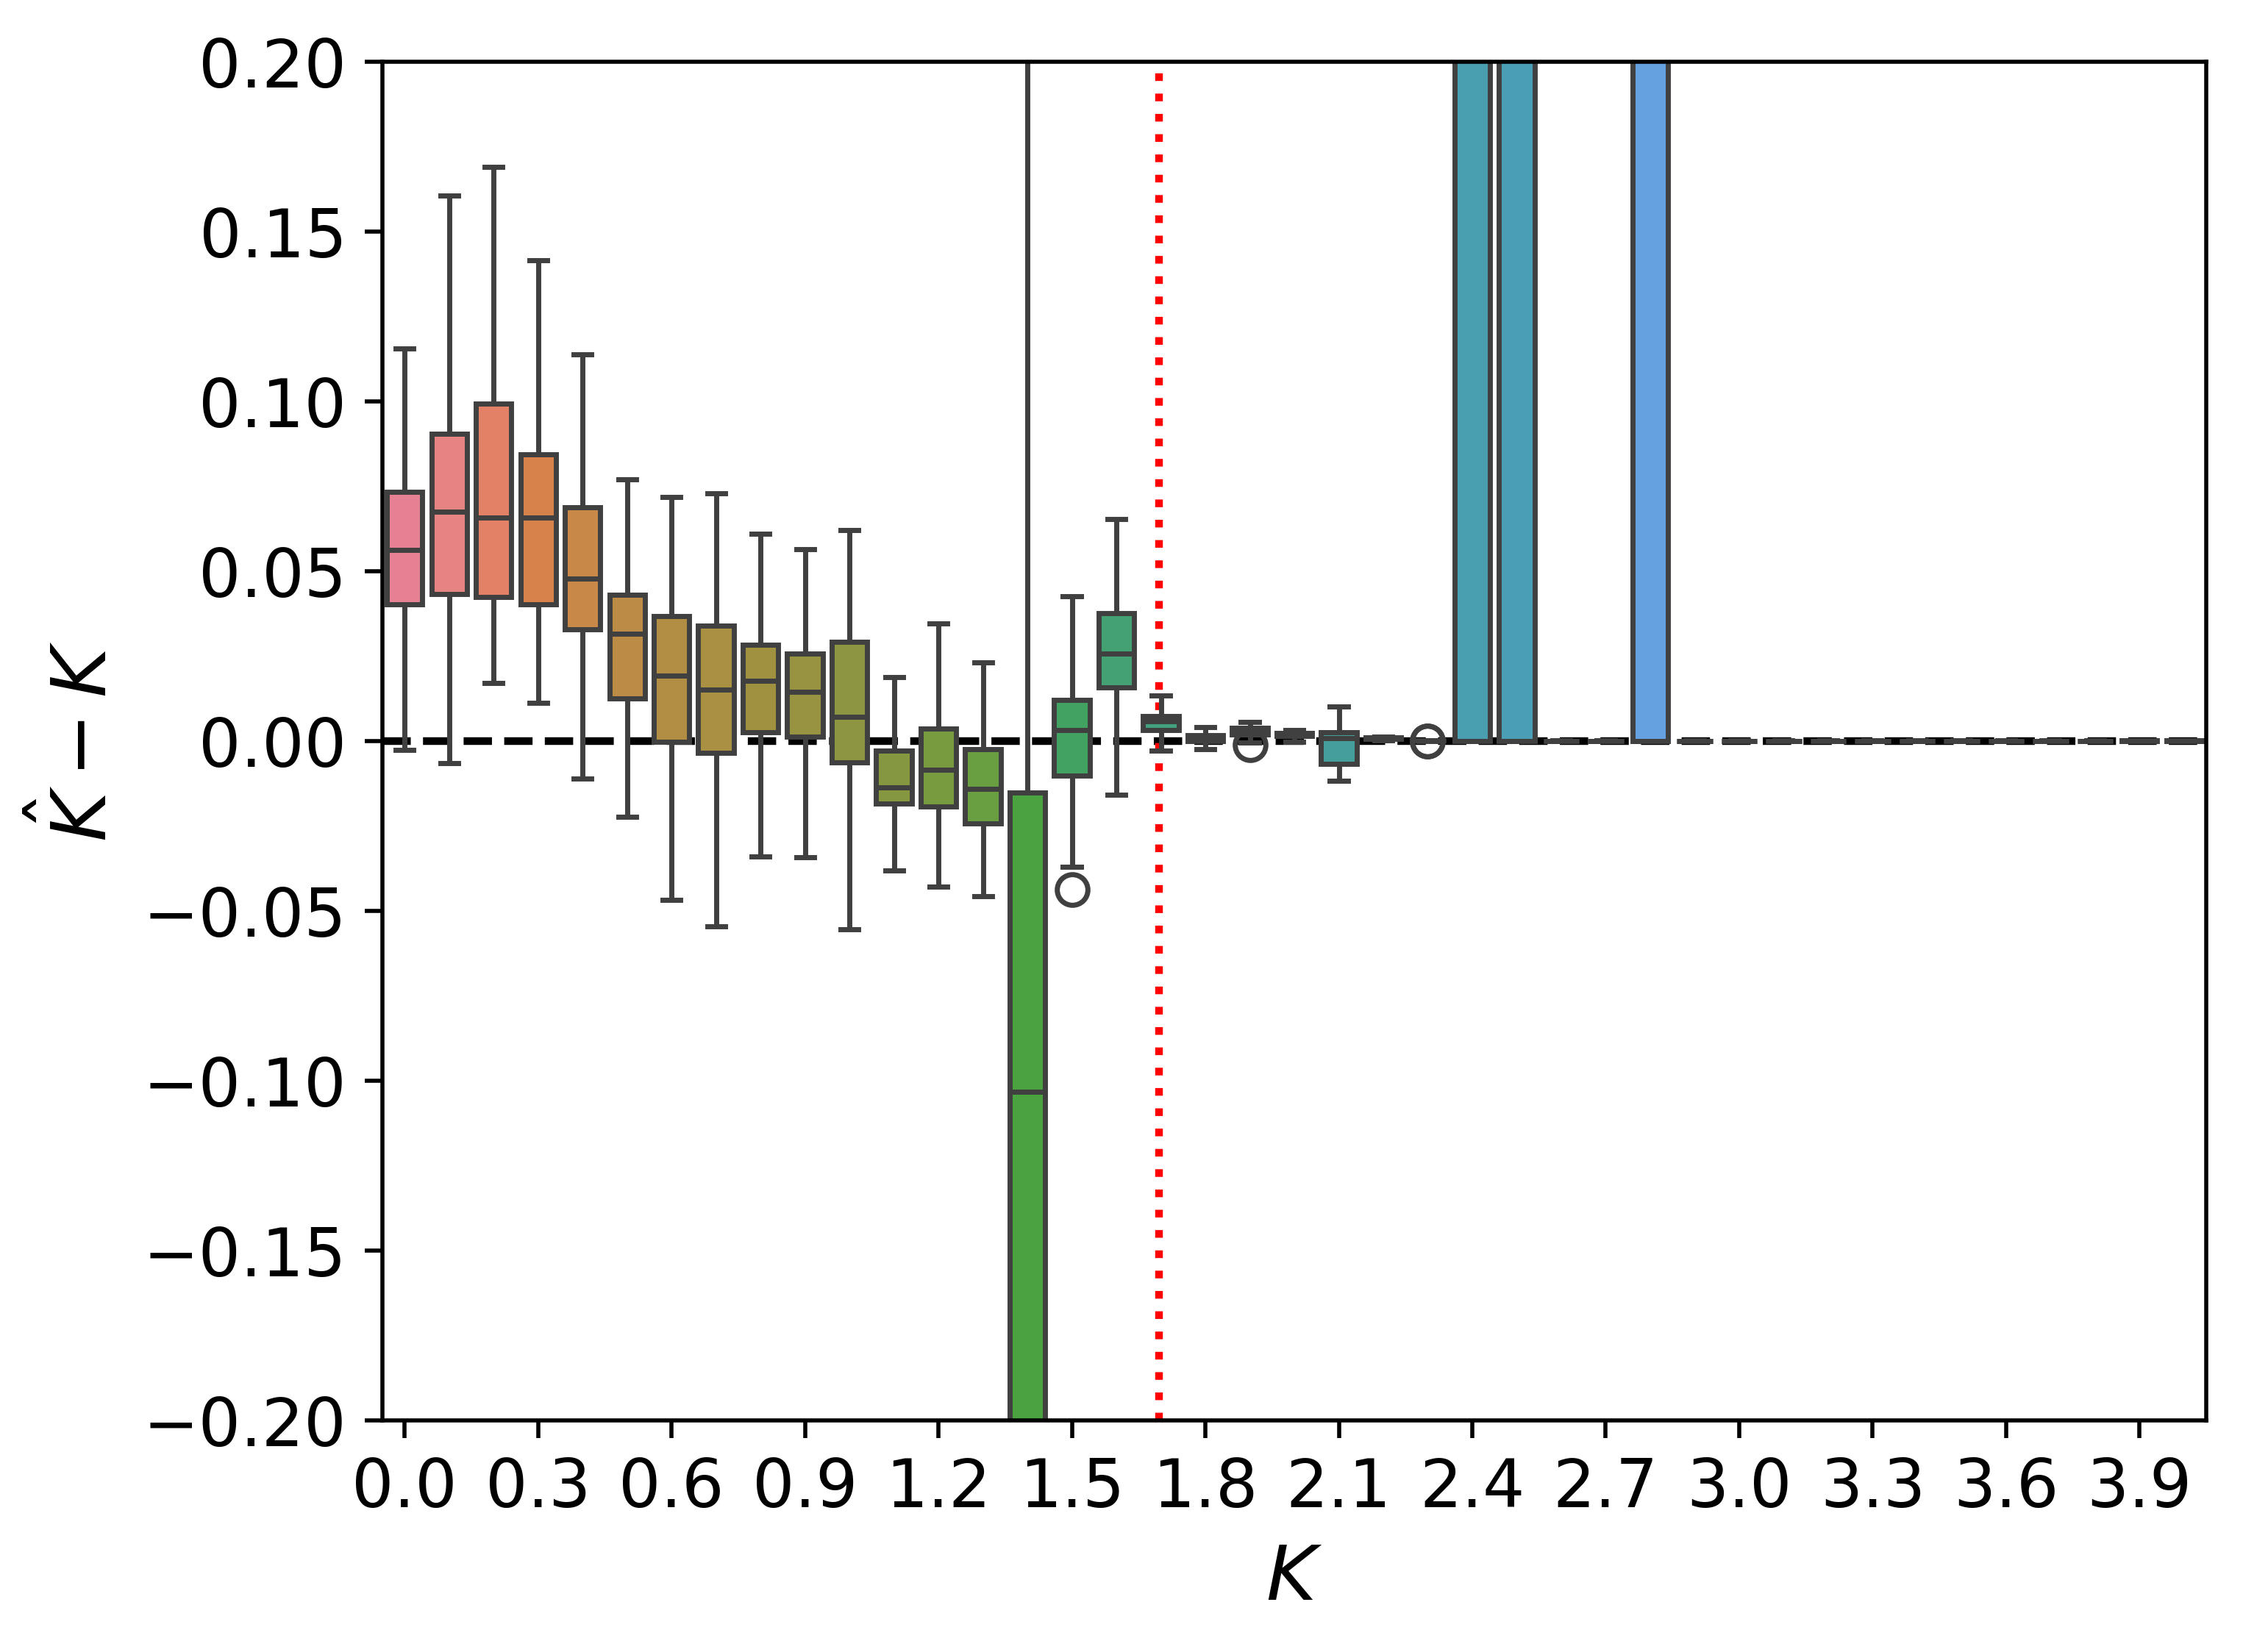

In [180]:
# plt.plot(Ks,(KK-Ks).T,'.');
plt.figure(dpi=500)
sns.boxplot(data=(KK-Ks))
# plt.xticks((np.arange(21)+1)[::3],[0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6])
plt.xticks((np.arange(len(Ks)))[::3],np.round(Ks[::3],2))
plt.axhline(0,zorder=-10,ls='--',color='black')
plt.axvline(K_c/0.1+1,zorder=-10,ls=':',color='red')
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$\hat{K} - K$',fontsize=15)
# plt.title('Box plot of KK - Ks')
plt.ylim(-0.2,0.2)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Unscented Kalman filter

In [162]:
import numpy as np
from numba import njit, prange

# ---------------------------
# Angle helpers (JIT)
# ---------------------------
@njit(fastmath=True)
def wrap_angle_scalar(a):
    # wrap to (-pi, pi]
    v = a + np.pi
    v = v - 2.0*np.pi * np.floor(v / (2.0*np.pi))
    return v - np.pi

@njit(fastmath=True, parallel=True)
def wrap_angle_matrix_rows(A, N):
    L = A.shape[0]
    for r in prange(L):
        for i in range(N):
            A[r, i] = wrap_angle_scalar(A[r, i])

@njit(fastmath=True)
def order_params(T):
    csum = 0.0
    ssum = 0.0
    N = T.size
    for i in range(N):
        csum += np.cos(T[i])
        ssum += np.sin(T[i])
    invN = 1.0 / N
    return csum*invN, ssum*invN

# ---------------------------
# Models (JIT)
# ---------------------------
@njit(fastmath=True)
def f_propagate_row(x_row, omega, dt, out_row):
    """
    x_row: (N+1,) sigma point [theta..., K]
    out_row: (N+1,) result
    """
    N = omega.size
    K = x_row[N]
    # order params of this sigma point
    X, Y = order_params(x_row[:N])

    for i in range(N):
        th = x_row[i]
        c = np.cos(th)
        s = np.sin(th)
        dtheta = omega[i] + K * (Y*c - X*s)
        out_row[i] = wrap_angle_scalar(th + dt * dtheta)
    out_row[N] = K

@njit(fastmath=True, parallel=True)
def propagate_sigma_points(Xsig, omega, dt):
    L, n = Xsig.shape
    N = omega.size
    Xprop = np.empty_like(Xsig)
    for a in prange(L):
        f_propagate_row(Xsig[a], omega, dt, Xprop[a])
    return Xprop

@njit(fastmath=True)
def h_measure_row(T):
    X, Y = order_params(T)
    return np.sqrt(X*X + Y*Y)

@njit(fastmath=True, parallel=True)
def measure_sigma_points(Xprop, N):
    L = Xprop.shape[0]
    Zsig = np.empty(L)
    for a in prange(L):
        Zsig[a] = h_measure_row(Xprop[a, :N])
    return Zsig

# ---------------------------
# Unscented weights & sigma points (JIT)
# ---------------------------
@njit(fastmath=True)
def unscented_weights(n, alpha, beta, kappa):
    lam = alpha*alpha * (n + kappa) - n
    c = n + lam
    L = 2*n + 1
    Wm = np.empty(L)
    Wc = np.empty(L)
    half = 0.5 / c
    for i in range(L):
        Wm[i] = half
        Wc[i] = half
    Wm[0] = lam / c
    Wc[0] = Wm[0] + (1.0 - alpha*alpha + beta)
    return lam, c, Wm, Wc

@njit(fastmath=True)
def sigma_points_diag(mean, P_diag, lam, c):
    n = mean.size
    L = 2*n + 1
    Xsig = np.empty((L, n))
    # center
    for j in range(n):
        Xsig[0, j] = mean[j]
    # spreads
    for i in range(n):
        s = np.sqrt(c * max(P_diag[i], 1e-18))
        # plus
        for j in range(n):
            Xsig[1+i, j] = mean[j]
        Xsig[1+i, i] = mean[i] + s
        # minus
        for j in range(n):
            Xsig[1+n+i, j] = mean[j]
        Xsig[1+n+i, i] = mean[i] - s
    return Xsig

# ---------------------------
# Circular mean & residuals (JIT)
# ---------------------------
@njit(fastmath=True, parallel=True)
def circular_mean_by_dim(Theta_sigma, Wm):
    L, N = Theta_sigma.shape
    out = np.empty(N)
    for j in prange(N):
        C = 0.0
        S = 0.0
        for a in range(L):
            th = Theta_sigma[a, j]
            C += Wm[a] * np.cos(th)
            S += Wm[a] * np.sin(th)
        out[j] = np.arctan2(S, C)
    return out

@njit(fastmath=True, parallel=True)
def residuals_dX(Theta_sigma, theta_mean, K_sigma, K_mean):
    L, N = Theta_sigma.shape
    n = N + 1
    dX = np.empty((L, n))
    for a in prange(L):
        for j in range(N):
            dX[a, j] = wrap_angle_scalar(Theta_sigma[a, j] - theta_mean[j])
        dX[a, N] = K_sigma[a] - K_mean
    return dX

# ---------------------------
# Covariances (JIT)
# ---------------------------
@njit(fastmath=True)
def cov_pred_diag(dX, Wc, Q_diag):
    L, n = dX.shape
    P = np.empty(n)
    for m in range(n):
        acc = 0.0
        for a in range(L):
            v = dX[a, m]
            acc += Wc[a] * v * v
        P[m] = acc + Q_diag[m]
        if P[m] < 1e-18:
            P[m] = 1e-18
    return P

@njit(fastmath=True)
def cross_cov_and_gain_diag(dX, dz, Wc, Pzz, P_bar_diag):
    L, n = dX.shape
    Pxz = np.empty(n)
    invPzz = 1.0 / max(Pzz, 1e-18)
    for m in range(n):
        acc = 0.0
        for a in range(L):
            acc += Wc[a] * dX[a, m] * dz[a]
        Pxz[m] = acc
    # K = Pxz / Pzz
    for m in range(n):
        Pxz[m] = Pxz[m] * invPzz
    # P_hat = P_bar - K * Pzz * K  (diag)
    P_hat = np.empty(n)
    for m in range(n):
        km = Pxz[m]
        P_hat[m] = max(P_bar_diag[m] - km * Pzz * km, 1e-18)
    return Pxz, P_hat

# ---------------------------
# UKF (diag) — Python wrapper + JIT inner kernels
# ---------------------------
def ukf_thetas_numba_diag(
    rs, t, theta0, K0, omega,
    Q_theta=0.0, Q_K=1e-8, R_meas=1e-8,
    alpha=None, beta=2.0, kappa=0.0,
    dtype=np.float64
):
    rs = np.asarray(rs, dtype=dtype)
    t  = np.asarray(t,  dtype=dtype)
    theta0 = np.asarray(theta0, dtype=dtype)
    omega  = np.asarray(omega, dtype=dtype)

    N = theta0.size
    n = N + 1
    dt = float(t[1] - t[0]) if len(t) > 1 else 1.0

    if alpha is None:
        # 차원이 크면 alpha를 키워야 수치 안정/포인트 확산 확보
        alpha = max(1e-3, 1.0/np.sqrt(n))

    lam, c, Wm, Wc = unscented_weights(n, alpha, beta, kappa)

    # init
    x = np.empty(n, dtype=dtype)
    for i in range(N):
        x[i] = wrap_angle_scalar(theta0[i])
    x[N] = dtype(K0)

    P_diag = np.full(n, dtype(1e-6))
    Q_diag = np.full(n, dtype(Q_theta))
    Q_diag[-1] = dtype(Q_K)
    R = dtype(R_meas)

    Tn = len(t)
    x_hats = np.empty((Tn, n), dtype=dtype)
    P_hats = np.empty((Tn, n), dtype=dtype)
    z_hats = np.empty(Tn, dtype=dtype)

    x_hats[0] = x
    P_hats[0] = P_diag
    # 첫 z_hat
    z_hats[0] = h_measure_row(x[:N])

    for k in range(1, Tn):
        z_meas = float(np.clip(rs[k], 1e-9, 1.0))

        # --- sigma points ---
        Xsig = sigma_points_diag(x, P_diag, lam, c)
        # angles wrap
        wrap_angle_matrix_rows(Xsig, N)

        # --- propagate ---
        Xprop = propagate_sigma_points(Xsig, omega, dt)

        Theta_sigma = Xprop[:, :N]
        K_sigma     = Xprop[:,  N]

        # predicted mean
        theta_mean = circular_mean_by_dim(Theta_sigma, Wm)
        K_mean = float(np.sum(Wm * K_sigma))

        x_bar = np.empty(n, dtype=dtype)
        x_bar[:N] = theta_mean
        x_bar[N]  = K_mean

        # residuals
        dX = residuals_dX(Theta_sigma, theta_mean, K_sigma, K_mean)

        # P_bar (diag)
        P_bar = cov_pred_diag(dX, Wc, Q_diag)

        # --- measurement ---
        Zsig = measure_sigma_points(Xprop, N)
        z_bar = float(np.sum(Wm * Zsig))

        dz = Zsig - z_bar
        # Pzz
        acc = 0.0
        for a in range(Zsig.size):
            acc += Wc[a] * dz[a] * dz[a]
        Pzz = float(acc + R)
        if Pzz < 1e-12:
            Pzz = 1e-12

        # cross-cov & gain (diag)
        K_gain, P_hat = cross_cov_and_gain_diag(dX, dz, Wc, Pzz, P_bar)

        # update
        innov = z_meas - z_bar
        x = x_bar + K_gain * innov
        # wrap angles
        for i in range(N):
            x[i] = wrap_angle_scalar(x[i])
        # optional: clamp K
        if x[N] < 1e-6: x[N] = 1e-6
        if x[N] > 1e2:  x[N] = 1e2

        P_diag = P_hat

        x_hats[k] = x
        P_hats[k] = P_diag
        z_hats[k] = z_bar

    return x_hats, P_hats, z_hats


In [141]:
seed = None
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)

# theta_random = np.ones(N)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.01
t = np.arange(0,100,dt)
K = 2.0
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)

In [142]:
# theta_random = np.random.uniform(-np.pi,np.pi,N)

In [143]:
# 예시: 네가 이미 갖고 있는 것들
# rs, t, theta_random, omega, K
x_hats, P_hats, z_hats = ukf_thetas_numba_diag(
    rs=rs, t=t,
    theta0=theta_random,
    K0=K + 1.0,
    omega=omega,
    Q_theta=0.0,     # 결정적 위상 모델이면 0 또는 아주 작게
    Q_K=1e-8,        # K는 천천히 변한다고 가정
    R_meas=1e-8,
    alpha=None, beta=2.0, kappa=0.,
    dtype=np.float64 # 더 빠르게 하고 싶으면 np.float32
)
K_est = x_hats[:, -1]
R_pred = z_hats


In [144]:
K_est

array([3.        , 2.99999779, 2.99999637, ..., 2.01605171, 2.01542137,
       2.01477857])

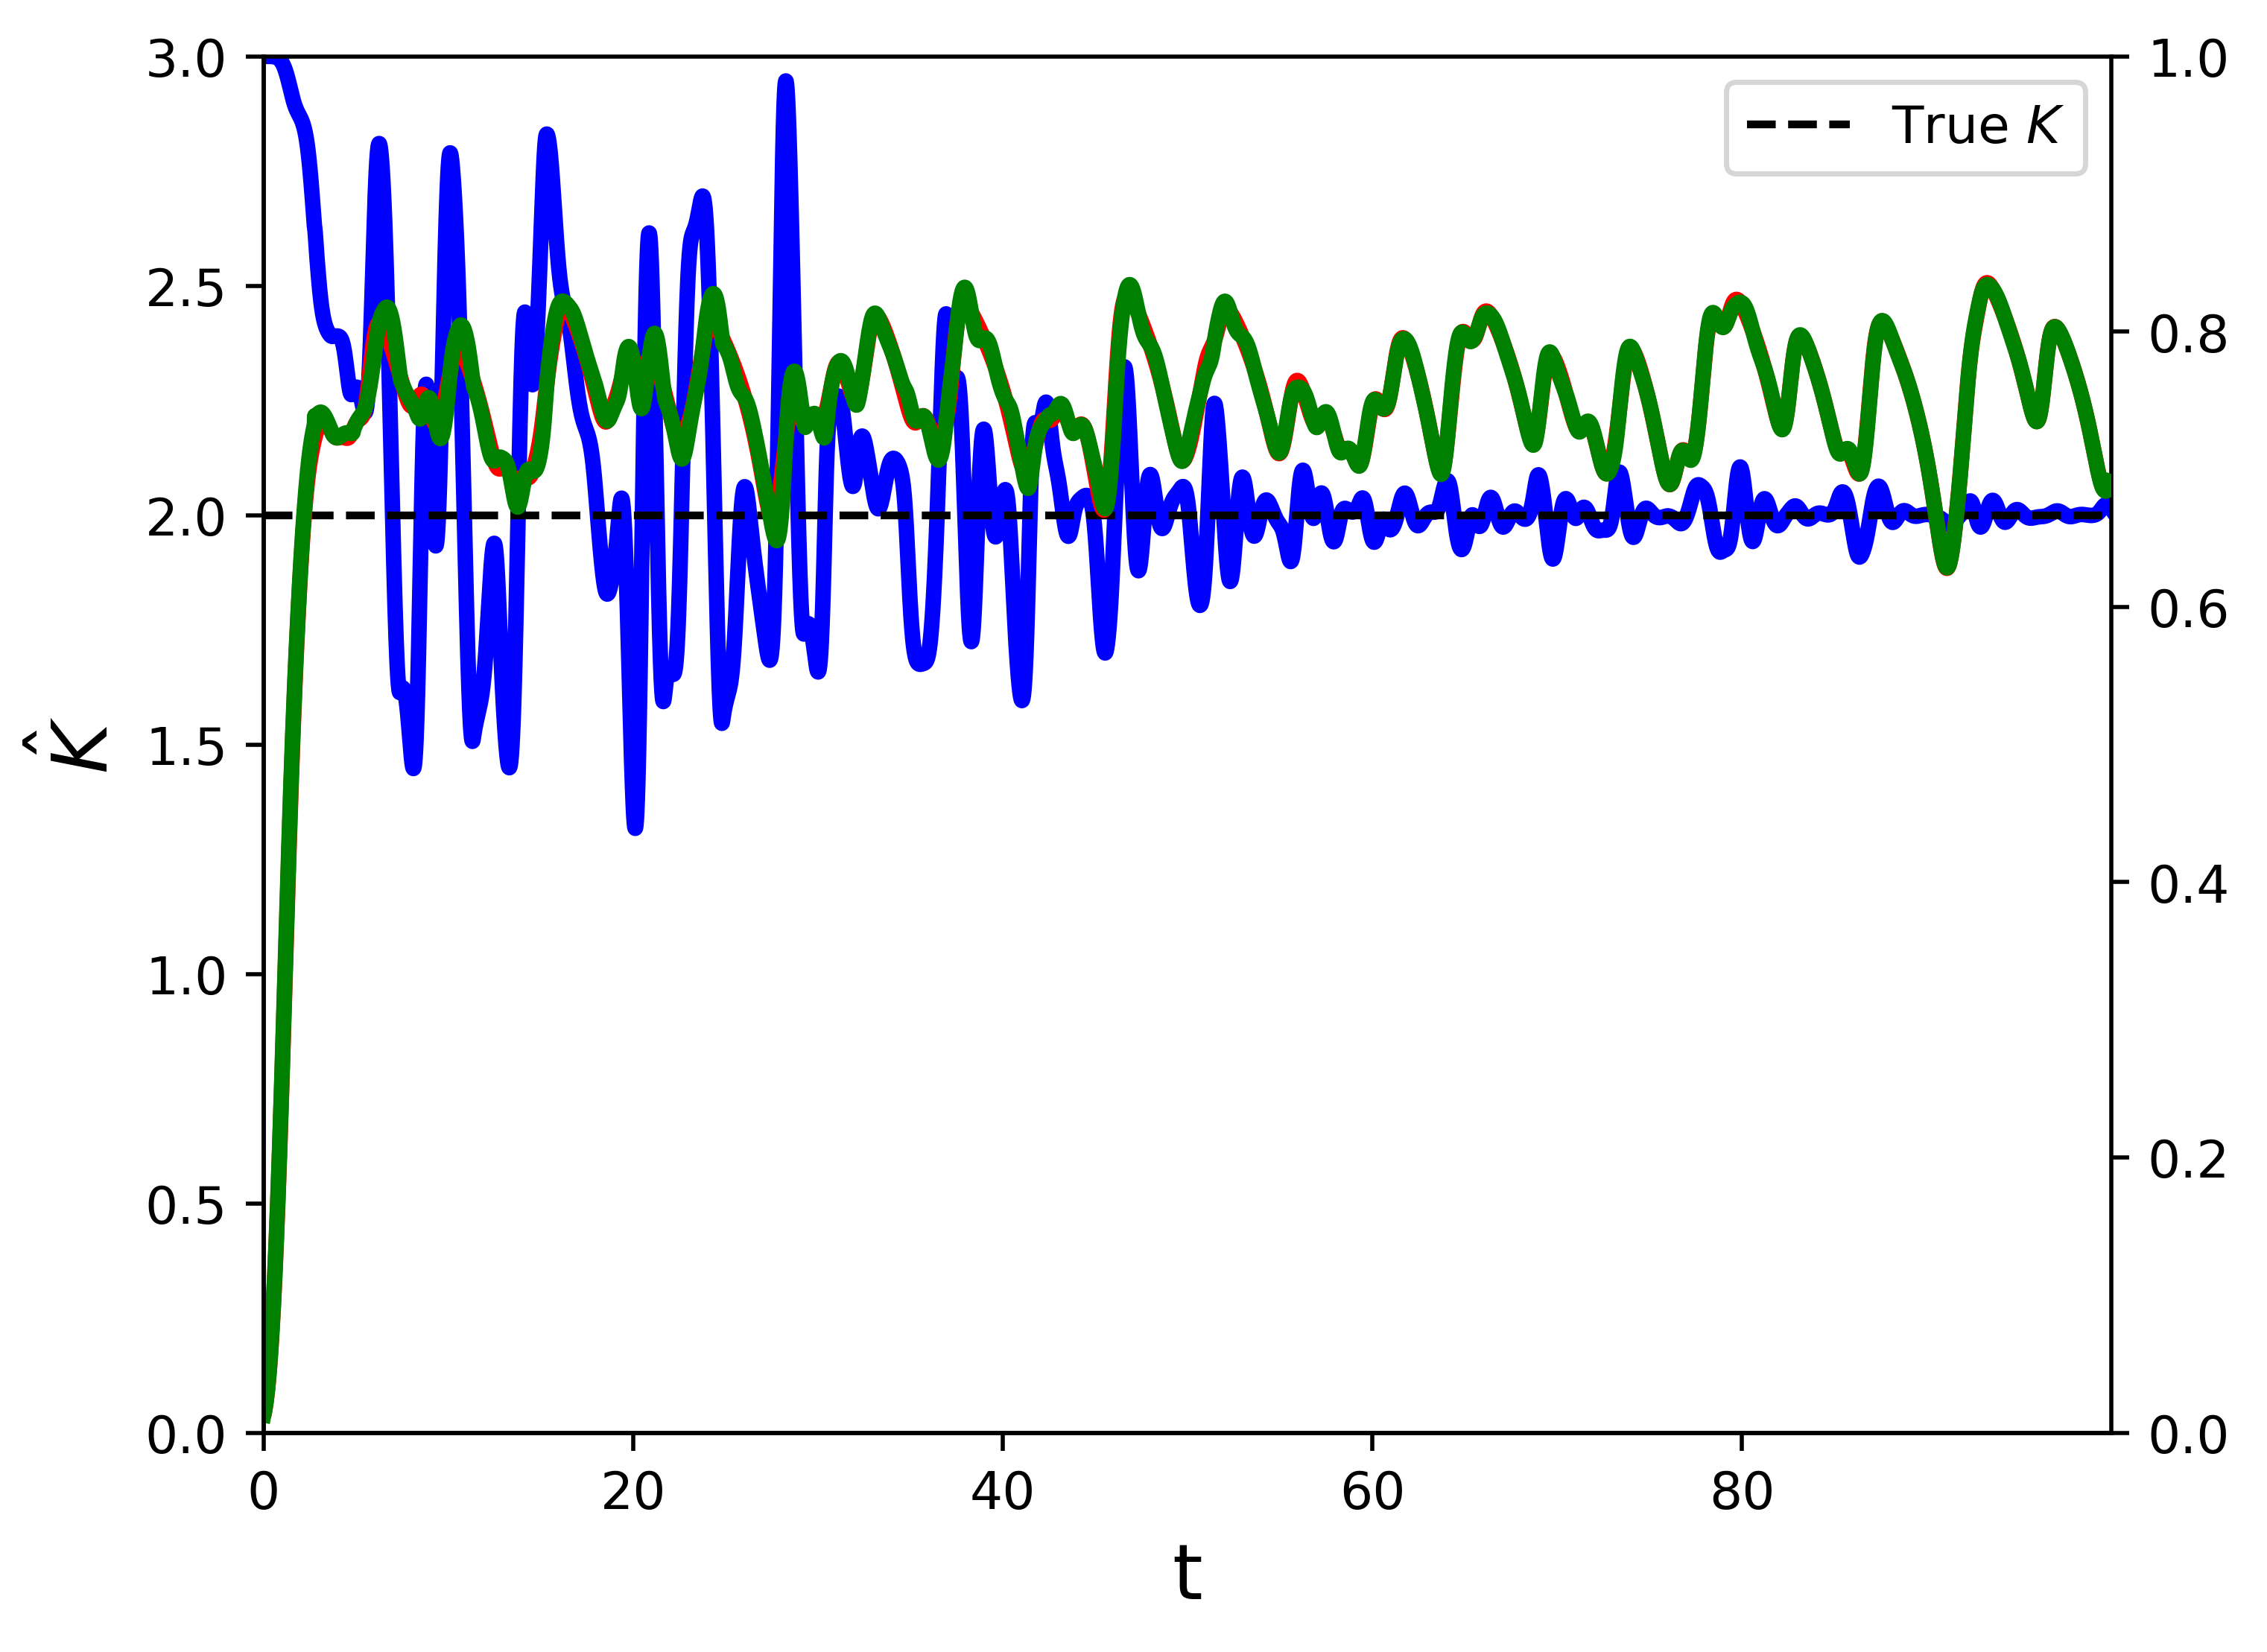

In [145]:
plt.figure(dpi=500)
# plt.plot(t,x_hats[:,-1],color='blue',lw=3)
plt.plot(t,K_est,color='blue',lw=3)
plt.axhline(K,color='black',ls='--',label=r'True ${K}$')
plt.ylim(0,K+1)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,t.max())
plt.legend()

plt.twinx()
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,R_pred,color='green',lw=3)
plt.ylim(0,1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

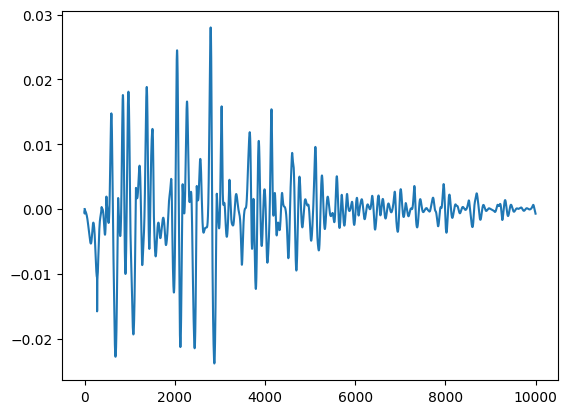

In [148]:
plt.plot(rs - R_pred)

Text(0.5, 0, '$t$')

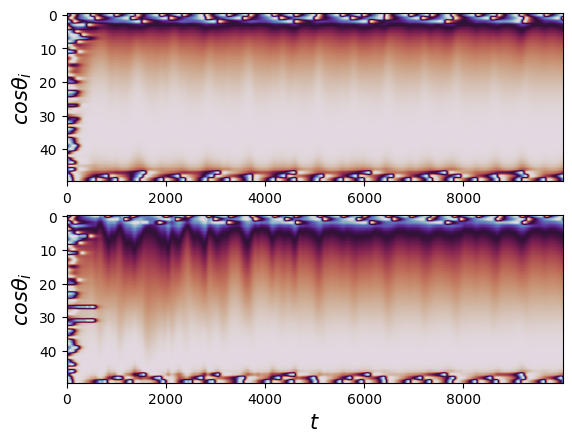

In [146]:
theta = (theta+np.pi)%(2*np.pi) - np.pi
plt.subplot(211)
plt.imshow(np.cos(theta).T,cmap='twilight')
plt.gca().set_aspect('auto')
plt.ylabel(r'$cos\theta_i$',fontsize=15)

plt.subplot(212)
plt.imshow(np.cos(x_hats[:,:N]).T,cmap='twilight')
plt.ylabel(r'$cos\theta_i$',fontsize=15)

plt.gca().set_aspect('auto')
plt.xlabel(r'$t$',fontsize=15)


Text(0, 0.5, '$\\theta_i-\\hat{\\theta}_i$')

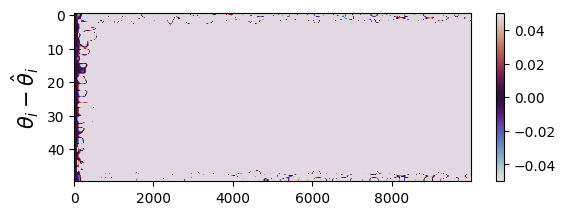

In [147]:
plt.subplot(211)
plt.imshow(theta.T - x_hats[:,:N].T,cmap='twilight',vmin=-0.05,vmax=0.05)
plt.gca().set_aspect('auto')
plt.colorbar()
plt.ylabel(r'$\theta_i-\hat{\theta}_i$',fontsize=15)



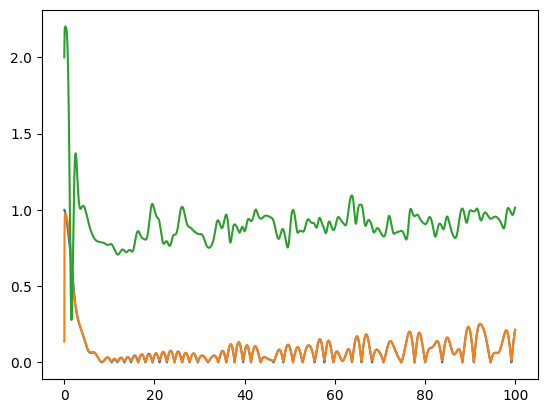

In [56]:
plt.plot(t,rs)
plt.plot(t,R_pred)
plt.plot(t,K_est)
plt.show()

In [163]:
Ks = np.arange(0,4.1,0.1)
seed =None
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)
# theta_random = np.ones(N)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.01
t = np.arange(0,40,dt)

K_rs = []
K_est = {}

# 가정: N, dt, f, F_j, h, H_j, omega, rs, t 가 이미 정의됨
# 수치 바닥
epsP  = 1e-12   # P 바닥
epsS  = 1e-10   # S 바닥
jitterP = 1e-8  # P 예측단계 정칙화



for K in tqdm(Ks):
    theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
    r_mean = np.mean(rs[-500:])
    K_rs.append(r_mean)
    K_est['r',K] = []
    K_est['K',K] = []

    
    # for num in tqdm(range(50)):
    @parfor(np.arange(50),bar=False)
    def get_r_K_mean(num):
        x_hats, P_hats, z_hats = ukf_thetas_numba_diag(
            rs=rs, t=t,
            theta0=theta_random,
            K0=K + 1.0,
            omega=omega,
            Q_theta=0.0,     # 결정적 위상 모델이면 0 또는 아주 작게
            Q_K=1e-8,        # K는 천천히 변한다고 가정
            R_meas=1e-8,
            alpha=None, beta=2.0, kappa=0.,
            dtype=np.float64 # 더 빠르게 하고 싶으면 np.float32
        )
        K_est = x_hats[:, -1]

        K_estm = np.mean(K_est[-500:]) 
        r_estm = np.mean(z_hats[-500:]) 
        return K_estm,r_estm
    K_ests,r_ests = zip(*get_r_K_mean)
    K_est['K',K] = K_ests
    K_est['r',K] = r_ests



  0%|          | 0/41 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(K_est)
q1 = df['K'].quantile(0.25)
q2 = df['K'].quantile(0.5)
q3 = df['K'].quantile(0.75)
iqr = q3 - q1
iqr

## Old one

In [56]:
Ks = np.arange(0,4.1,0.2)
seed =None
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random = np.ones(N)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.01
t = np.arange(0,100,dt)
K = 3.0

In [57]:
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)

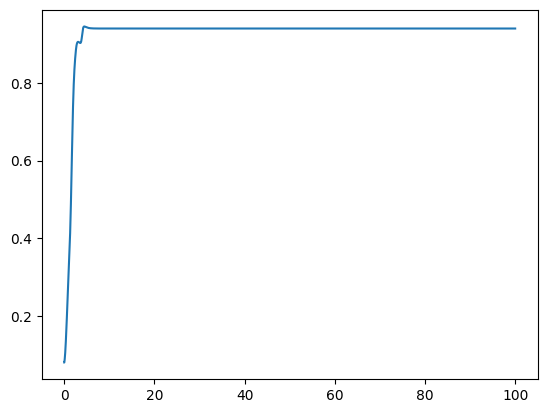

In [58]:
plt.plot(t,rs)

In [40]:
from numba import njit

In [59]:
def f(x,omega=omega):
    x = x.copy()
    T = x[:N]
    K = x[-1]
    Ti,Tj = np.meshgrid(T,T, indexing="ij")
    dtheta = omega + K/N*np.sum(np.sin(Tj - Ti),axis=1) 
    T_new = T + dtheta*dt
    T_new = (T_new+np.pi)%(2*np.pi) -  np.pi
    return np.r_[T_new,K]

def h(x):
    x = x.copy()
    T = x[:N]
    R = np.abs(np.mean(np.exp(1j*T)))
    return np.array([R])

In [60]:

def sigma_points(x, P, lambda_):
    n = x.shape[0]
    chi = np.zeros((2*n+1,n))
    U = np.linalg.cholesky((n+lambda_)*P)
    chi[0] = x
    for i in range(n):
        chi[i+1] = x + U[i]
        chi[i+n+1] = x - U[i]
    return np.array(chi)  # shape: (2n+1, n)

def bar_sigma_points(chi):
    return np.array([f(sp,omega) for sp in chi])

In [61]:
n = len(x)  # 상태벡터 차원
alpha = 0.5
beta = 4
kappa = -2
lambda_ = alpha**2*(n+kappa)-n
Q = np.eye(N+1)*0
P = np.eye(N+1)*0.01
Q[-1,-1] = 0.02

Wm = np.full(2*n+1, 1/(2*(n+lambda_)))
Wc = np.full(2*n+1, 1/(2*(n+lambda_)))
Wm[0] = lambda_/(n+lambda_)
Wc[0] = lambda_/(n+lambda_) + (1 - alpha**2 + beta)
Wm/=np.sum(Wm)

In [62]:
lambda_

-38.75

In [63]:
x = np.r_[theta_random,K-1]

In [64]:
chi = sigma_points(x, P, lambda_)
chi_bar = bar_sigma_points(chi)
x_bar = np.sum(chi_bar.T * Wm, axis=1)  # (n,)
P_bar = np.zeros_like(P)
for i, cp in enumerate(chi_bar):
    diff = cp - x_bar
    P_bar += Wc[i] * np.outer(diff, diff)
P_bar += Q
# est

z_sigma = np.array([h(cp) for cp in chi_bar])
z_bar = np.sum(z_sigma.T * Wm, axis=1)

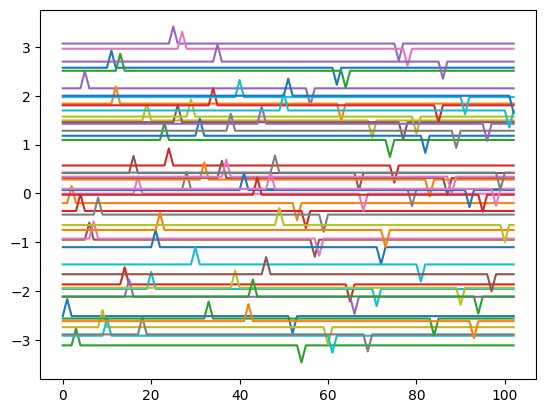

In [65]:
plt.plot(chi);

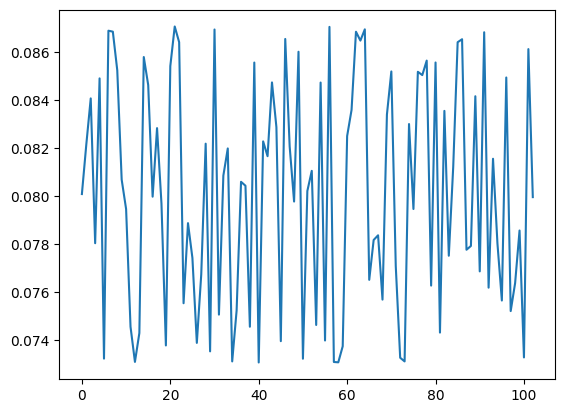

In [66]:
plt.plot(z_sigma)

In [67]:
print(z_bar,z_sigma[-1])

[0.08037276] [0.079961]


In [68]:
x = np.r_[theta_random,K+1]
Q = np.eye(N+1)*0
P = np.eye(N+1)*0.01
Q[-1,-1] = 0.02
R_meas = 0.01

P_hats = np.zeros((len(t),*P.shape))
x_hats = np.zeros((len(t),len(x)))
z_hats = np.zeros((len(t)))
S_s = np.zeros((len(t)))
x_hats[0] = x
P_hats[0] = P
z_hats[0] = h(x)[0]



for num in range(1,len(t)):
    # pred
    chi = sigma_points(x, P, lambda_)
    chi_bar = bar_sigma_points(chi)
    x_bar = np.sum(chi_bar.T * Wm, axis=1)  # (n,)
    P_bar = np.zeros_like(P)
    for i, cp in enumerate(chi_bar):
        diff = cp - x_bar
        P_bar += Wc[i] * np.outer(diff, diff)
    P_bar += Q
    # est

    z_sigma = np.array([h(cp) for cp in chi_bar])
    z_bar = np.sum(z_sigma.T * Wm, axis=1)

    S = np.zeros((len(z_bar), len(z_bar)))
    for i, zsp in enumerate(z_sigma):
        diff = zsp - z_bar
        S += Wc[i]*np.outer(diff, diff)
    S += R_meas  # 측정 노이즈 공분산 추가
    Pxz = np.zeros((n, len(z_bar)))
    for i, cp in enumerate(chi_bar):
        diff_x = (cp - x_bar).reshape(-1,1)
        diff_z = (z_sigma[i] - z_bar).reshape(-1,1)
        Pxz += Wc[i]*diff_x@diff_z.T
    K_gain = Pxz@np.linalg.inv(S)

    z_meas = rs[num] + np.random.rand()*R_meas
    x = x_bar + K_gain@(z_meas - z_bar)
    P = P_bar - K_gain@S@K_gain.T
    x_hats[num] = x
    P_hats[num] = P
    z_hats[num] = z_bar[0]
    print(z_bar,x[-1])


[0.08110797] 4.000002625467317
[0.09904201] 3.9999872182077985
[0.14131289] 3.999653443234129
[0.16336968] 3.9979821443028345
[0.18160486] 3.9915304056211522
[0.21977719] 3.969794798206586
[0.2569926] 3.9013967181822116
[0.27713627] 3.8314854064481656
[0.2880305] 3.795507918837111
[0.29647467] 3.7755111171197537
[0.31292417] 3.7559777576279747
[0.32425458] 3.7290191911453543
[0.33110446] 3.695655398593867
[0.33006383] 3.6751124296952717
[0.33086171] 3.667145981082088
[0.32595194] 3.660377137752293
[0.33554909] 3.650018214721785
[0.33189572] 3.635386238141552
[0.33064886] 3.62213272875654
[0.34614699] 3.6103142839047924
[0.35518327] 3.5995878998447486
[0.371245] 3.5893181202373308
[0.36777737] 3.578244892070683
[0.38953673] 3.5637427553206384
[0.42438394] 3.5430016027676374
[0.43044349] 3.52491855932447
[0.44525592] 3.5046249078186
[0.46092952] 3.480287177680144
[0.48197582] 3.456534981733118
[0.49311468] 3.435928586561113
[0.47386296] 3.4184016998228914
[0.48286895] 3.3988486618083678


In [51]:
np.mean(x_hats[-50:,-1]) - K,np.mean(x_hats_KM[-50:,-1]) - K

NameError: name 'x_hats_KM' is not defined

NameError: name 'x_hats_KM' is not defined

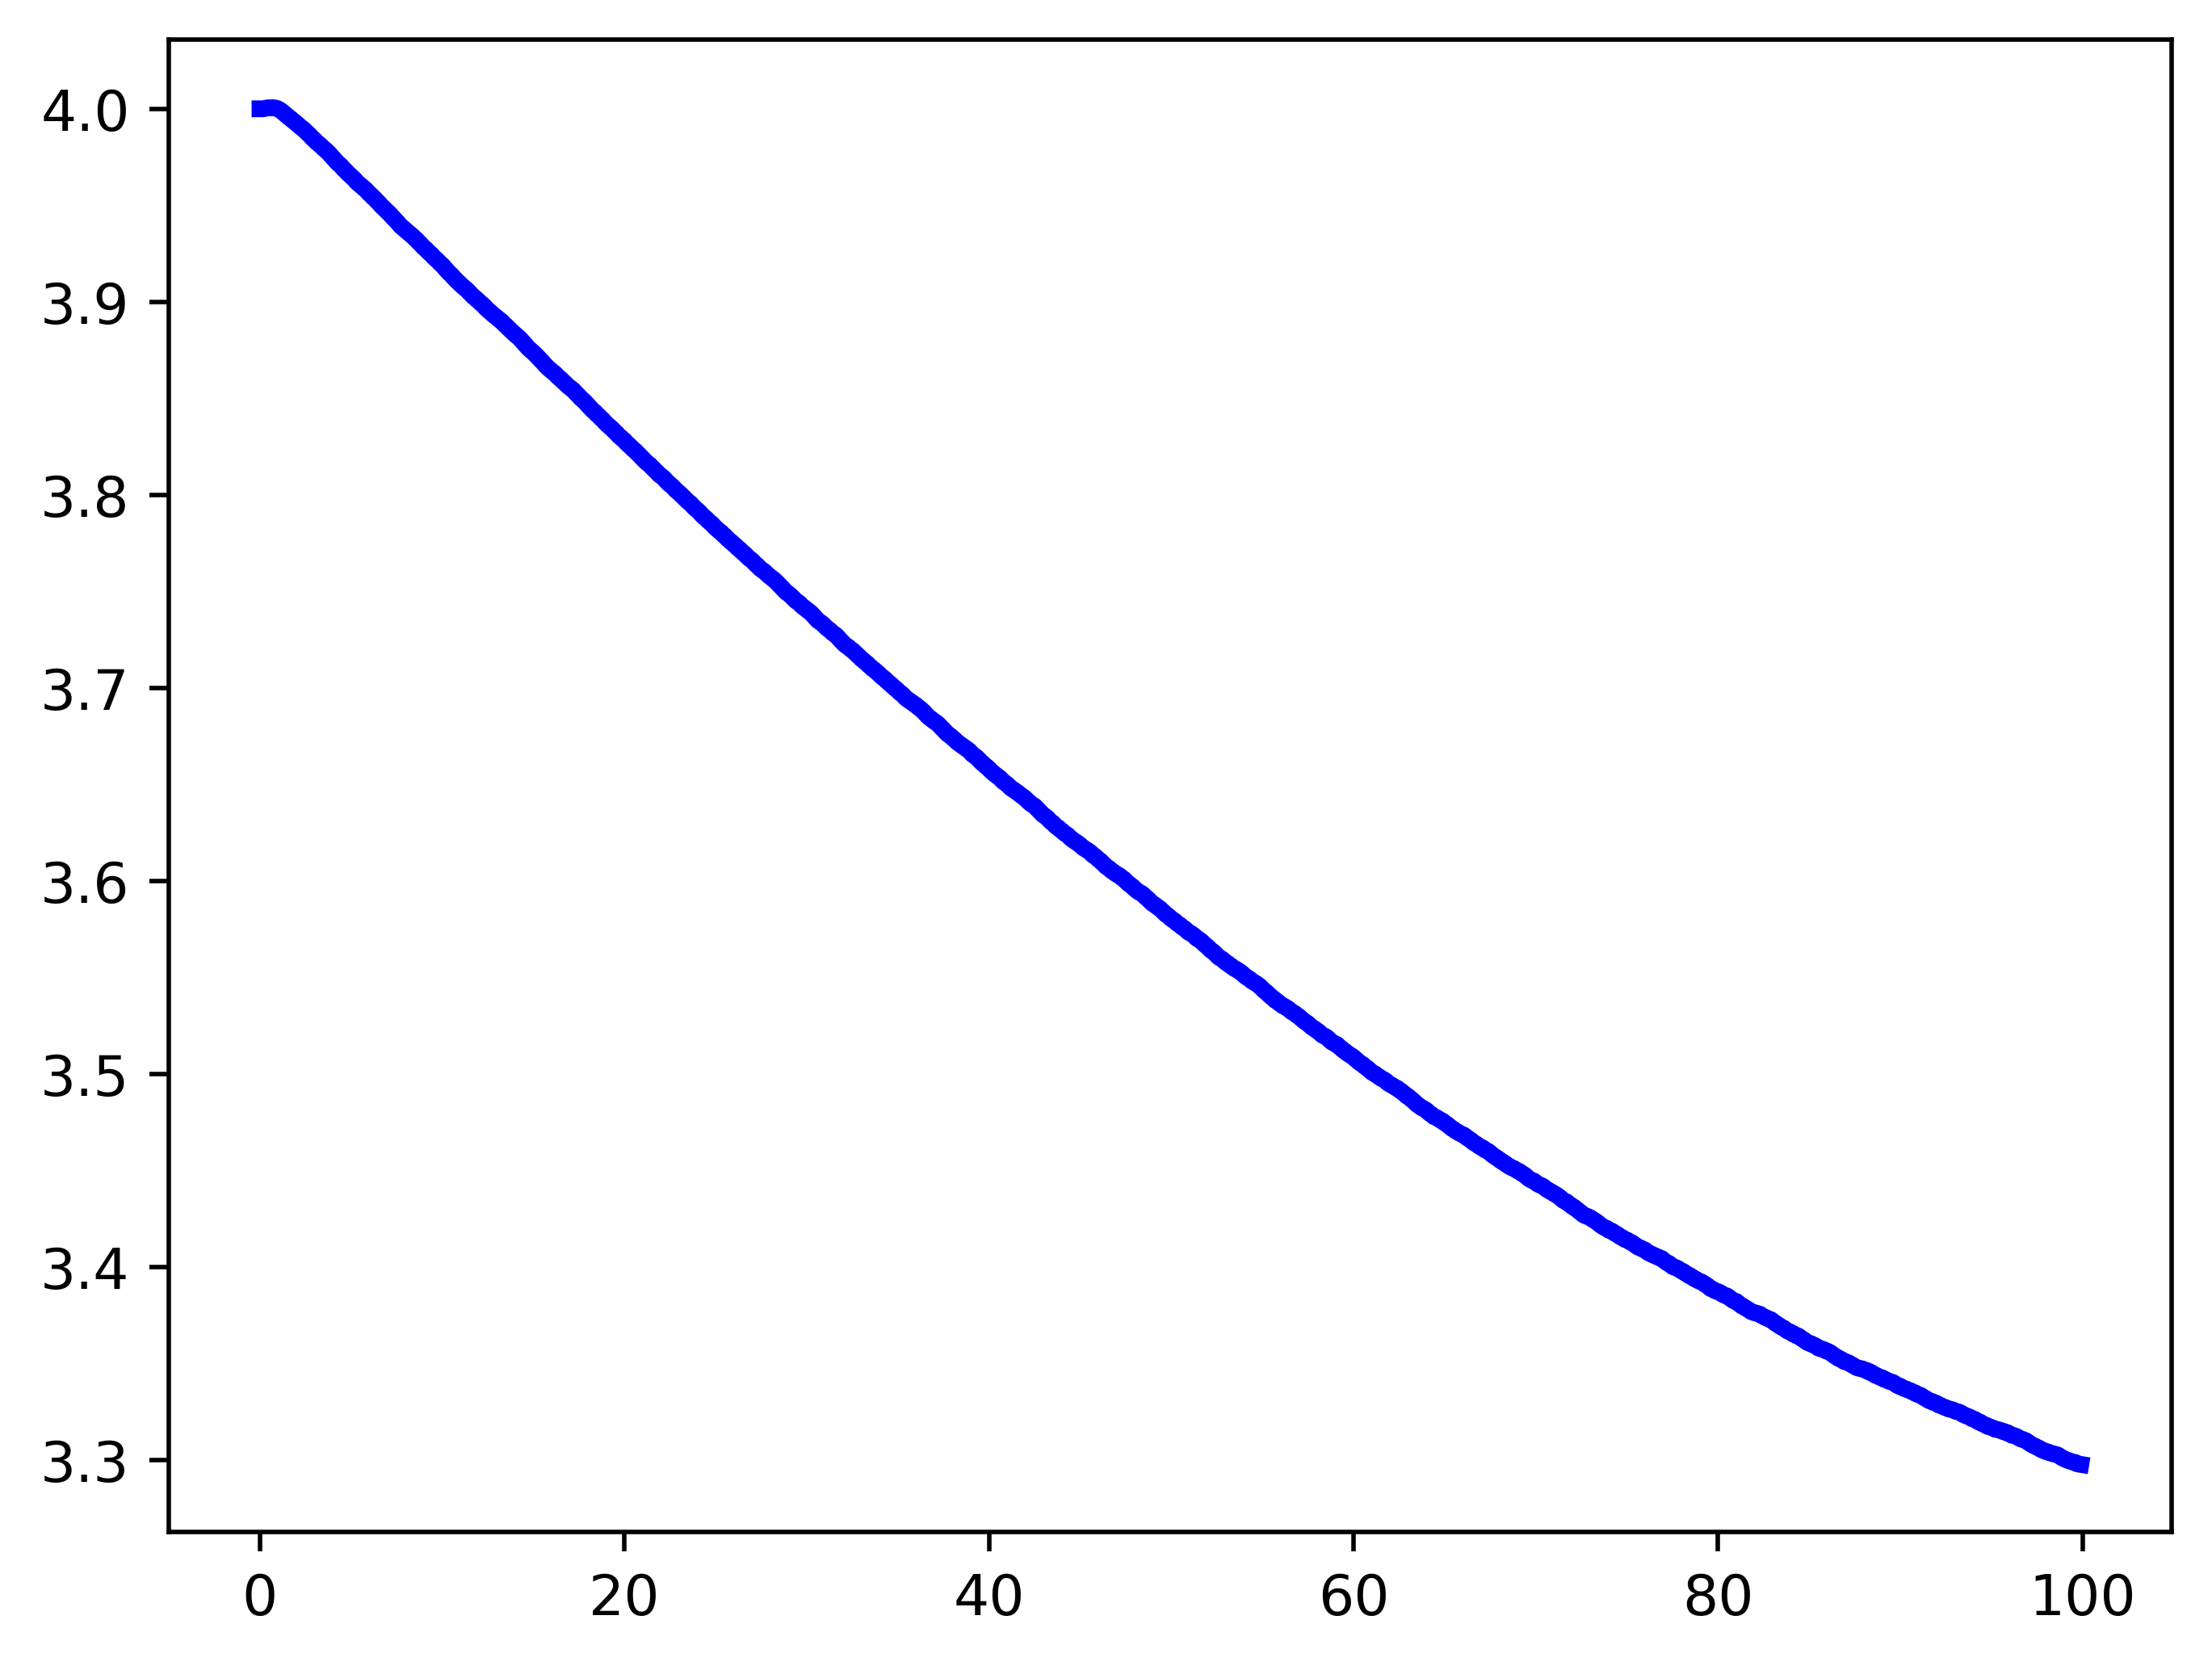

In [52]:
plt.figure(dpi=500)
plt.plot(t,x_hats[:,-1],color='blue',lw=3)
plt.plot(t,x_hats_KM[:,-1],color='orange',lw=3)
plt.axhline(K,color='black',ls='--')
plt.ylim(-1,3)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,100)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

(0.0, 1.0)

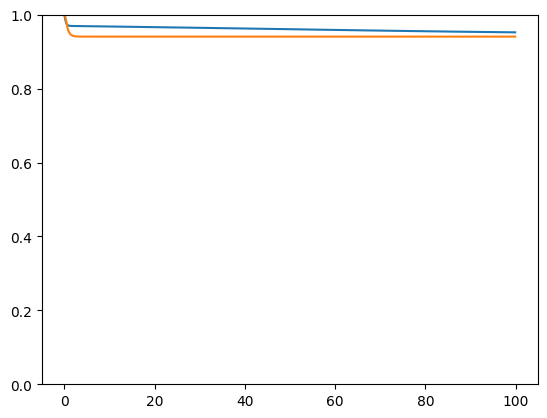

In [53]:
plt.plot(t,z_hats)
plt.plot(t,rs)
plt.ylim(0,1)

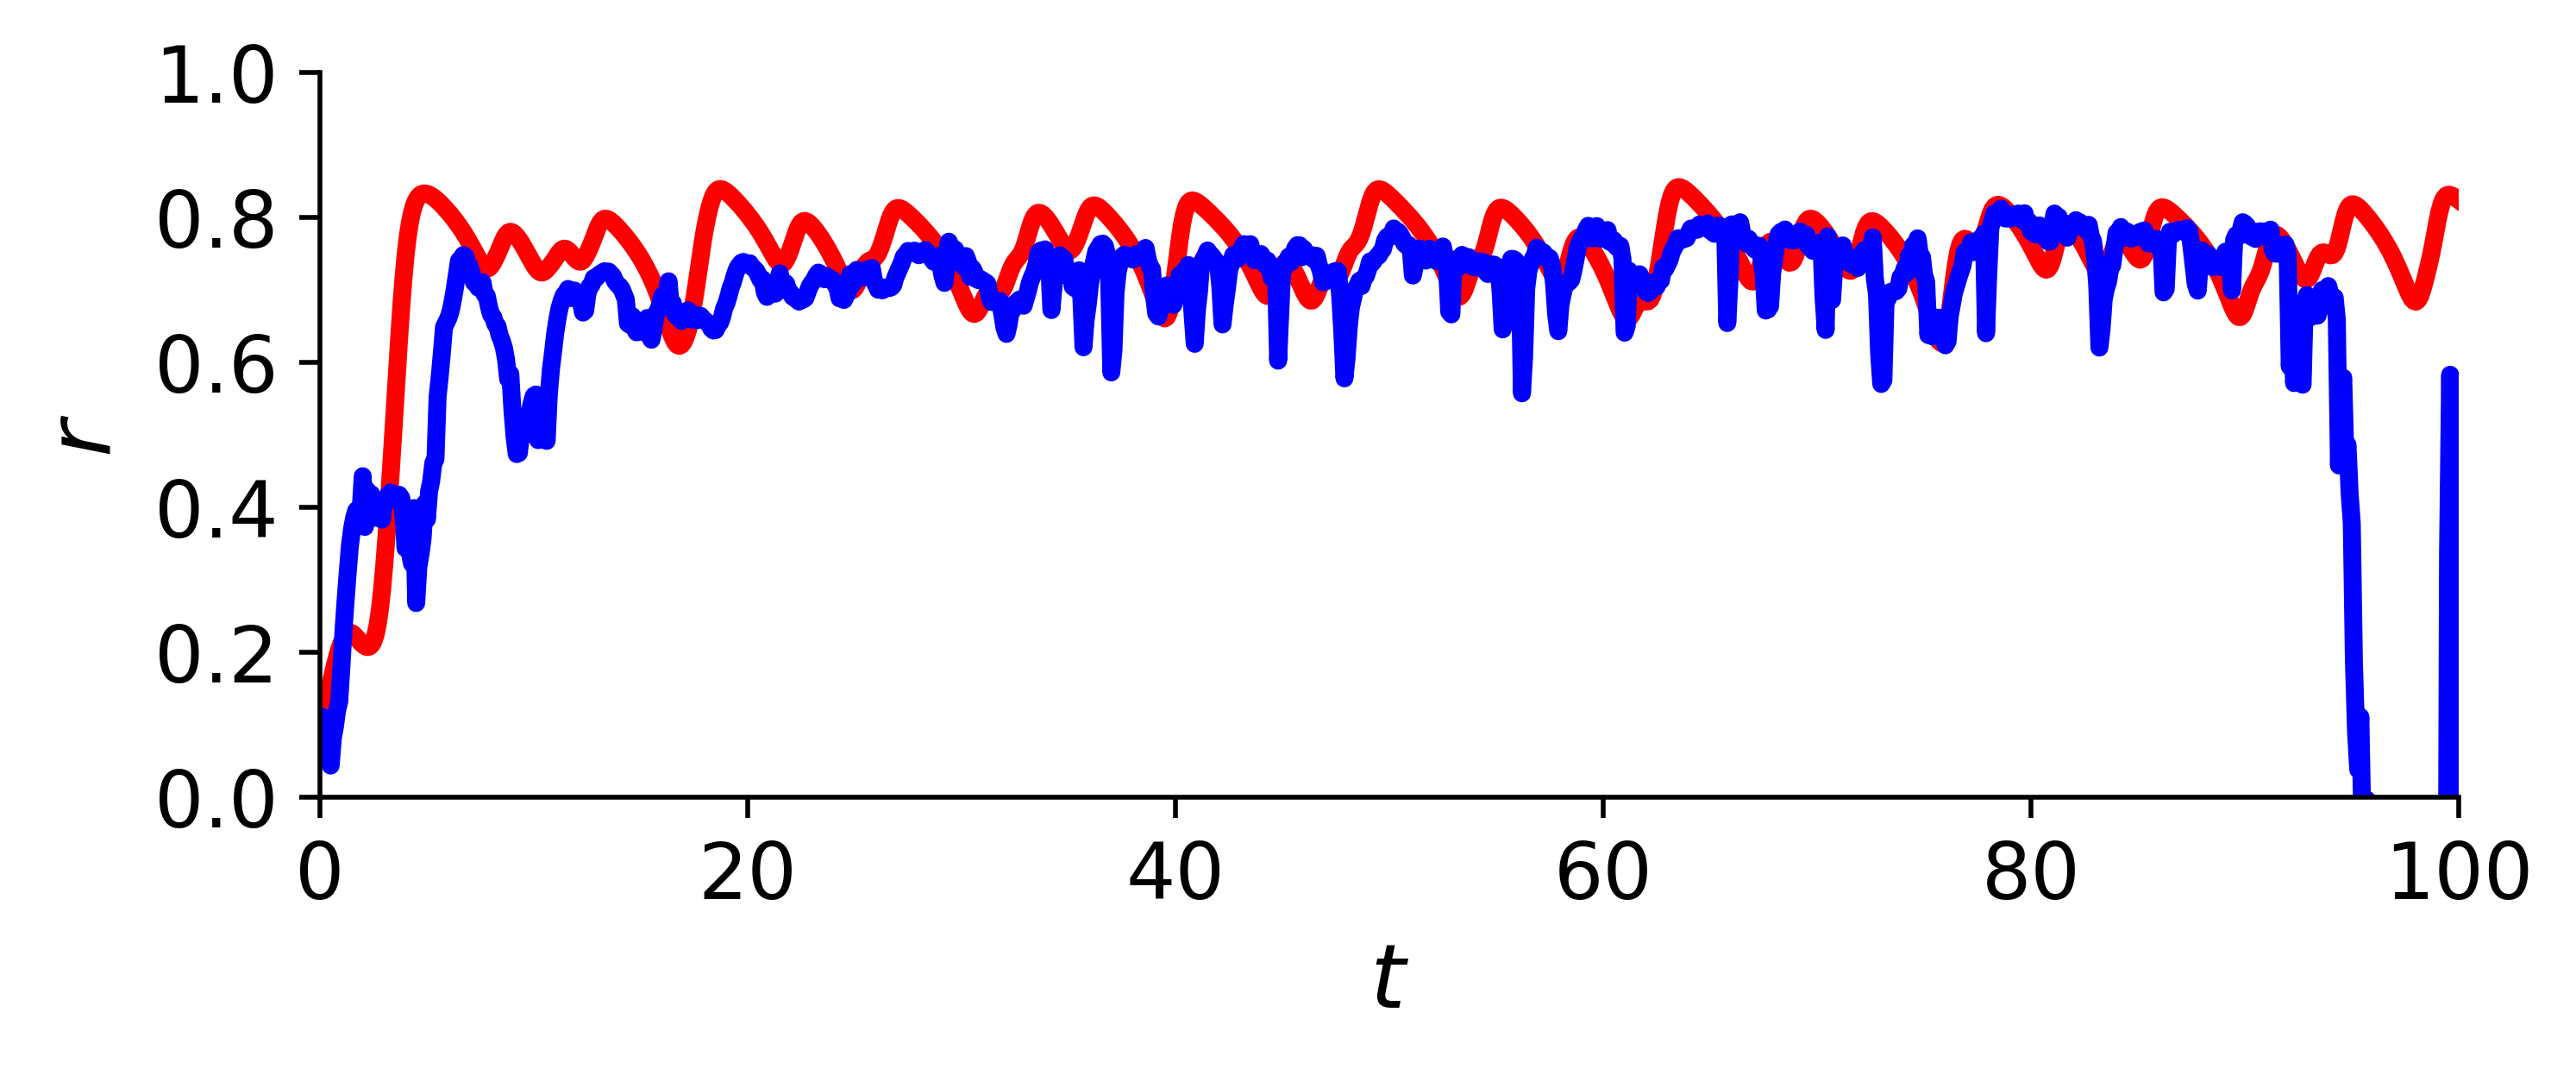

In [1742]:
plt.figure(dpi=500)
plt.subplot(211)
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,z_hats,color='blue',lw=3)

plt.xlim(0,100)
plt.ylim(0,1)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)




# plt.plot(t,rs)

In [2306]:
alpha = 0.5
beta = 3
kappa = -2
lambda_ = alpha**2*(n+kappa)-n
Q = np.eye(N+1)*0
P = np.eye(N+1)*0.01
Q[-1,-1] = 0.02

Wm = np.full(2*n+1, 1/(2*(n+lambda_)))
Wc = np.full(2*n+1, 1/(2*(n+lambda_)))
Wm[0] = lambda_/(n+lambda_)
Wc[0] = lambda_/(n+lambda_) + (1 - alpha**2 + beta)
Wm/=np.sum(Wm)

In [2307]:
K_rs = []
K_est_UKF = {}


for K in tqdm(Ks):
    theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
    r_mean = np.mean(rs[-500:])
    K_rs.append(r_mean)
    K_est_UKF['r',K] = []
    K_est_UKF['K',K] = []

    
    # for num in tqdm(range(50)):
    @parfor(np.arange(50),bar=False)
    def get_r_K_mean(num):
        x = np.r_[theta_random,K-1]
        Q = np.eye(N+1)*0
        P = np.eye(N+1)*0.01
        Q[-1,-1] = 0.02
        R_meas = 0.01

        P_hats = np.zeros((len(t),*P.shape))
        x_hats = np.zeros((len(t),len(x)))
        z_hats = np.zeros((len(t)))
        S_s = np.zeros((len(t)))
        x_hats[0] = x
        P_hats[0] = P
        z_hats[0] = h(x)[0]
        for num in range(1,len(t)):
            # pred
            try:
                chi = sigma_points(x, P, lambda_)
            except:
                break
            chi_bar = bar_sigma_points(chi)
            x_bar = np.sum(chi_bar.T * Wm, axis=1)  # (n,)
            P_bar = np.zeros_like(P)
            for i, cp in enumerate(chi_bar):
                diff = cp - x_bar
                P_bar += Wc[i] * np.outer(diff, diff)
            P_bar += Q
            # est

            z_sigma = np.array([h(cp) for cp in chi_bar])
            z_bar = np.sum(z_sigma.T * Wm, axis=1)

            S = np.zeros((len(z_bar), len(z_bar)))
            for i, zsp in enumerate(z_sigma):
                diff = zsp - z_bar
                S += Wc[i]*np.outer(diff, diff)
            S += R_meas  # 측정 노이즈 공분산 추가
            Pxz = np.zeros((n, len(z_bar)))
            for i, cp in enumerate(chi_bar):
                diff_x = (cp - x_bar).reshape(-1,1)
                diff_z = (z_sigma[i] - z_bar).reshape(-1,1)
                Pxz += Wc[i]*diff_x@diff_z.T
            K_gain = Pxz@np.linalg.inv(S)

            z_meas = rs[num] + np.random.rand()*R_meas
            x = x_bar + K_gain@(z_meas - z_bar)
            P = P_bar - K_gain@S@K_gain.T
            x_hats[num] = x
            P_hats[num] = P
            z_hats[num] = z_bar[0]


        K_est_UKFm = np.mean(x_hats[-500:,-1]) 
        r_estm = np.mean(z_hats[-500:]) 
        return K_est_UKFm,r_estm
    K_est_UKFs,r_ests = zip(*get_r_K_mean)
    K_est_UKF['K',K] = K_est_UKFs
    K_est_UKF['r',K] = r_ests

  0%|          | 0/21 [00:00<?, ?it/s]

In [2308]:
df_UKF = pd.DataFrame(K_est_UKF)

In [2311]:
df = df_UKF.copy()

In [2312]:
# IQR 계산
Q1 = df['K'].quantile(0.25)
Q3 = df['K'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 정의
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 각 column마다 이상치를 NaN으로 대체
for col in df['K'].columns:
    df['K', col] = df['K', col].apply(lambda x: x if lower_bound[col] <= x <= upper_bound[col] else np.nan)
    df['r', col] = df['r', col].where(df['K', col].notna(), np.nan)

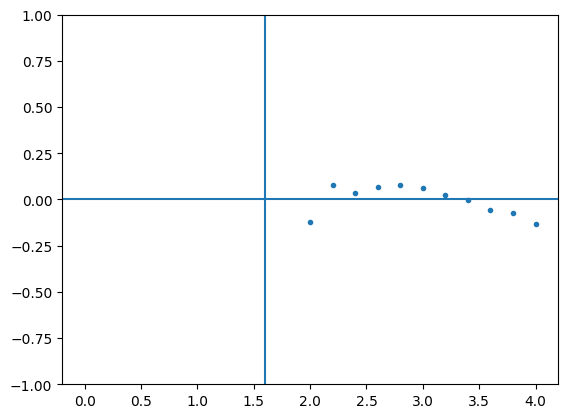

In [2321]:
KK = df['K'].to_numpy()
K_mean =np.nanmean(KK,axis=0)
K_std =np.nanstd(KK,axis=0)
plt.plot(Ks,K_mean-Ks,'.')
plt.ylim(-1,1)
# plt.fill_between(Ks,K_mean-K_std,K_mean+K_std,alpha=0.3)
# plt.plot(Ks,Ks)
plt.axhline(0)
plt.axvline(K_c)

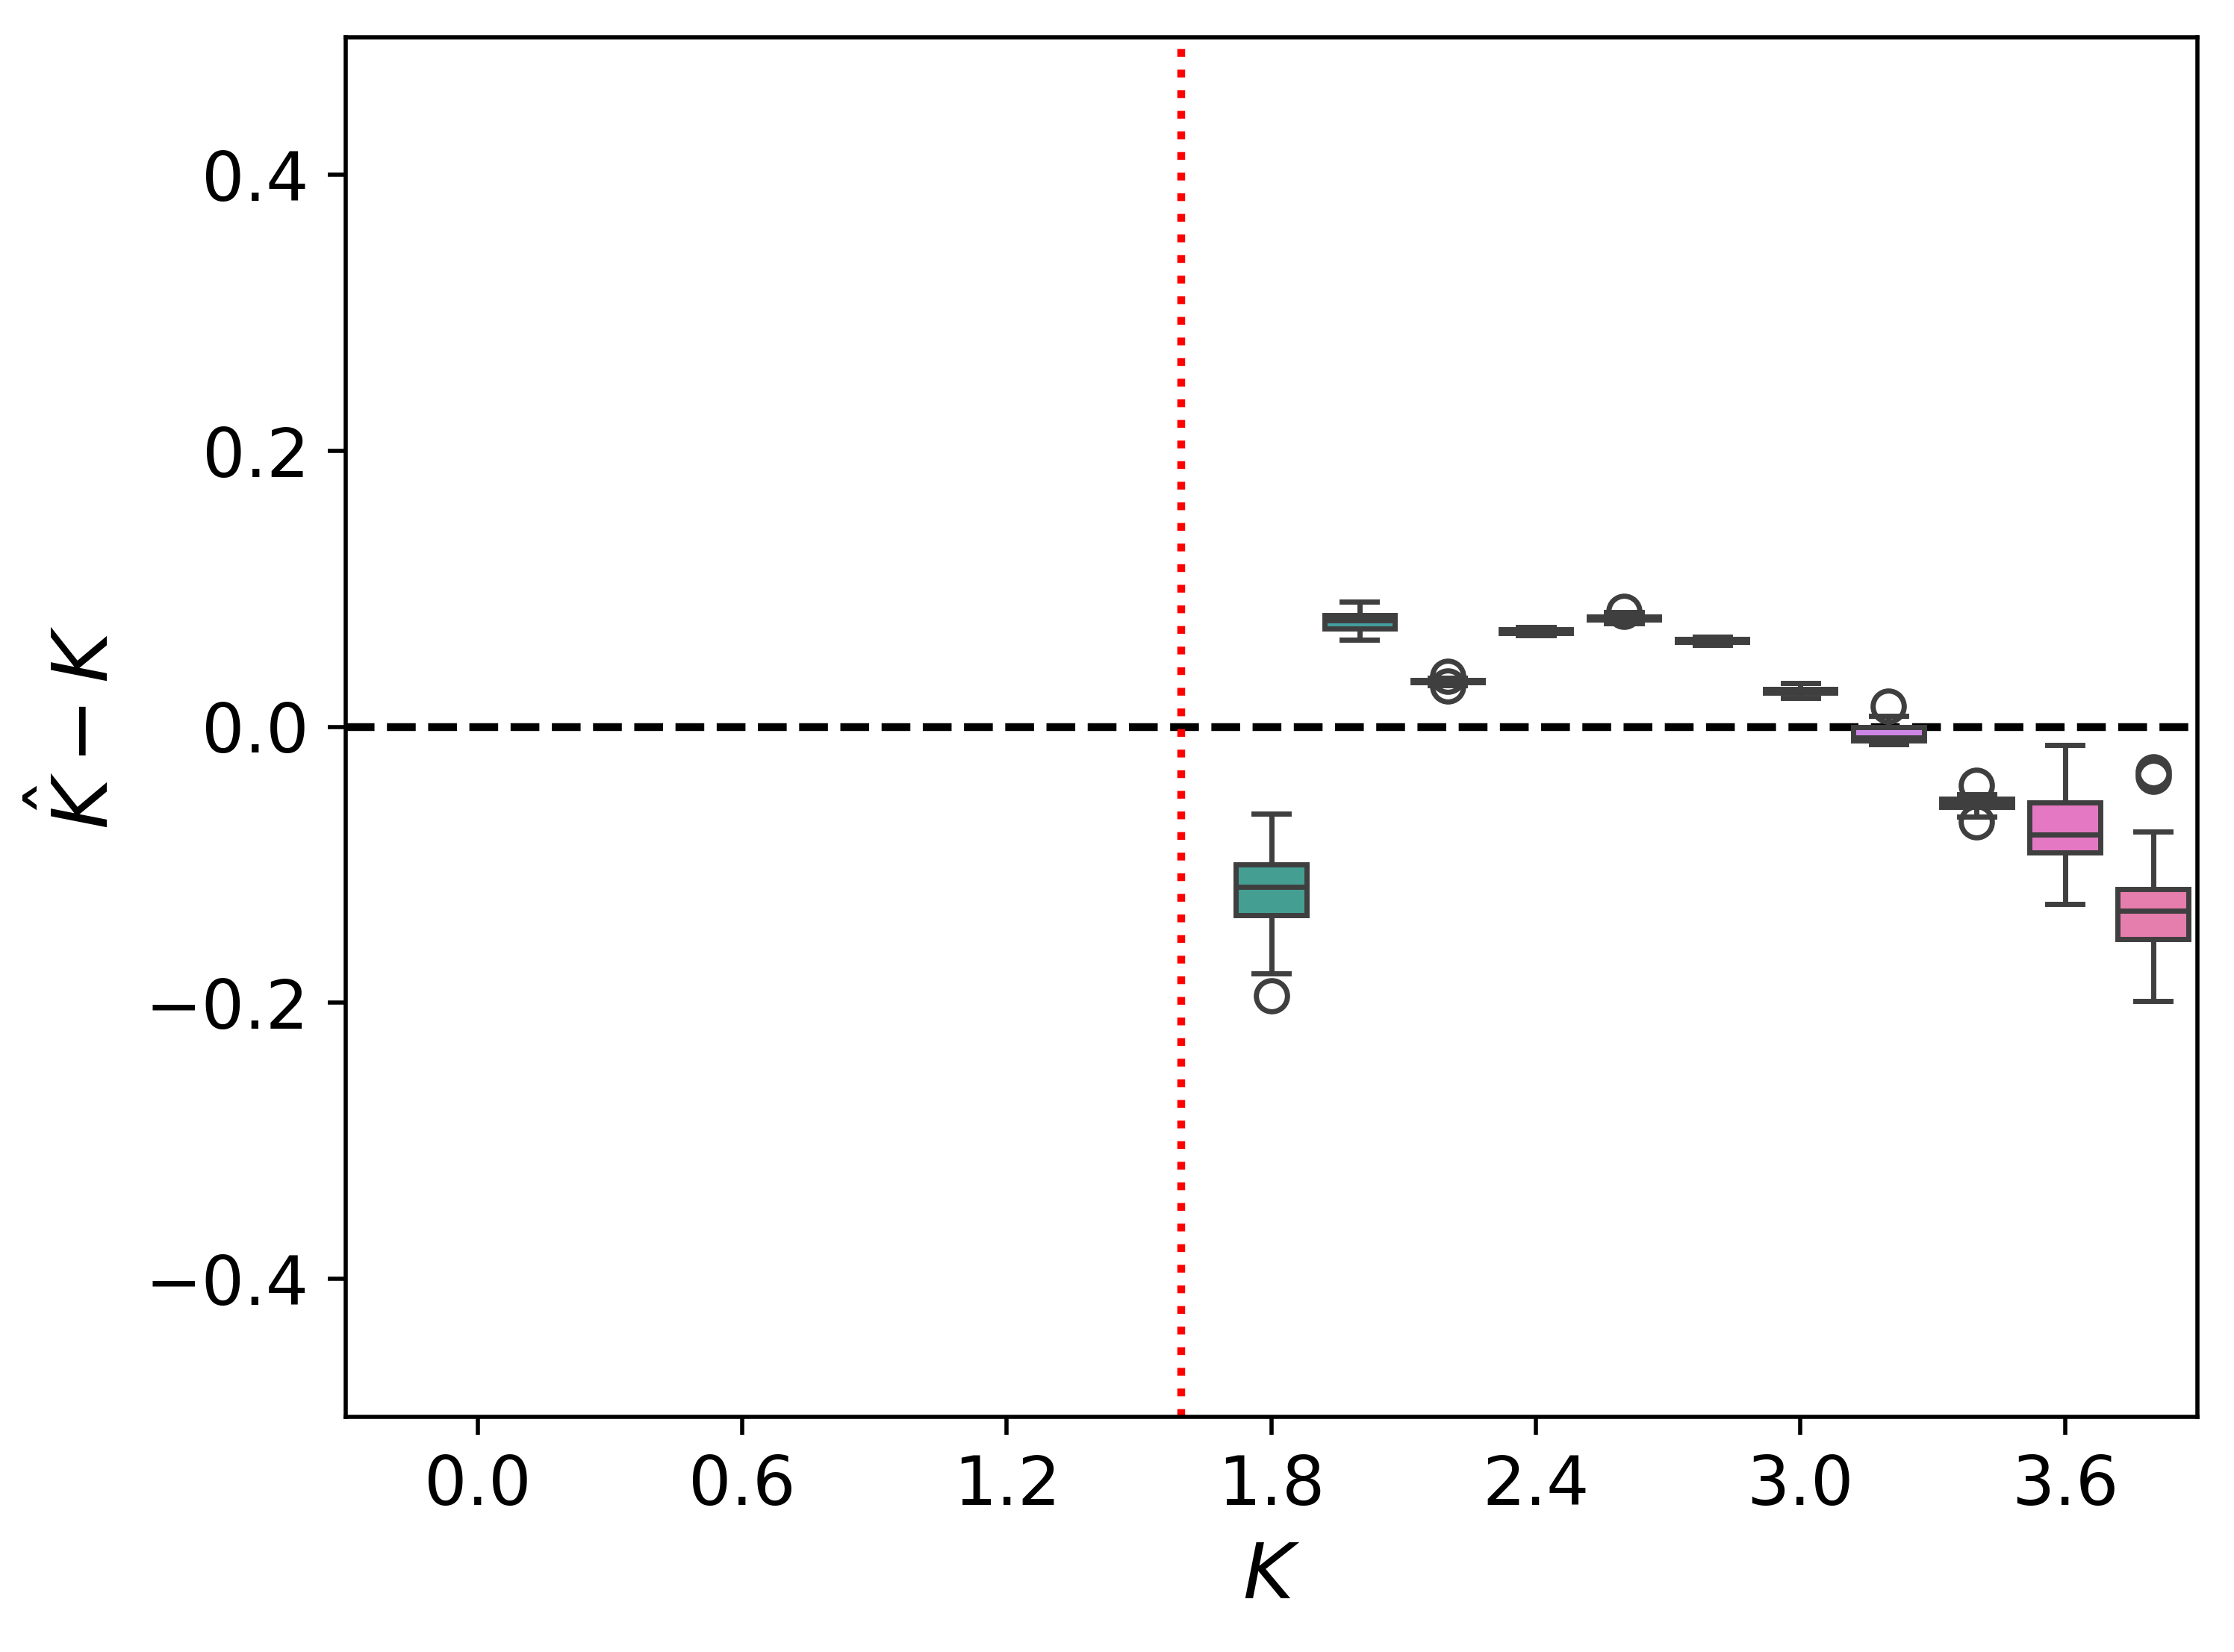

In [2323]:
# plt.plot(Ks,(KK-Ks).T,'.');
plt.figure(dpi=500)
sns.boxplot(data=(KK-Ks))
plt.xticks((np.arange(21)+1)[::3],[0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6])
plt.axhline(0,zorder=-10,ls='--',color='black')
plt.axvline(K_c/0.2+1,zorder=-10,ls=':',color='red')
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$\hat{K} - K$',fontsize=15)
plt.ylim(-0.5,0.5)
# plt.title('Box plot of KK - Ks')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

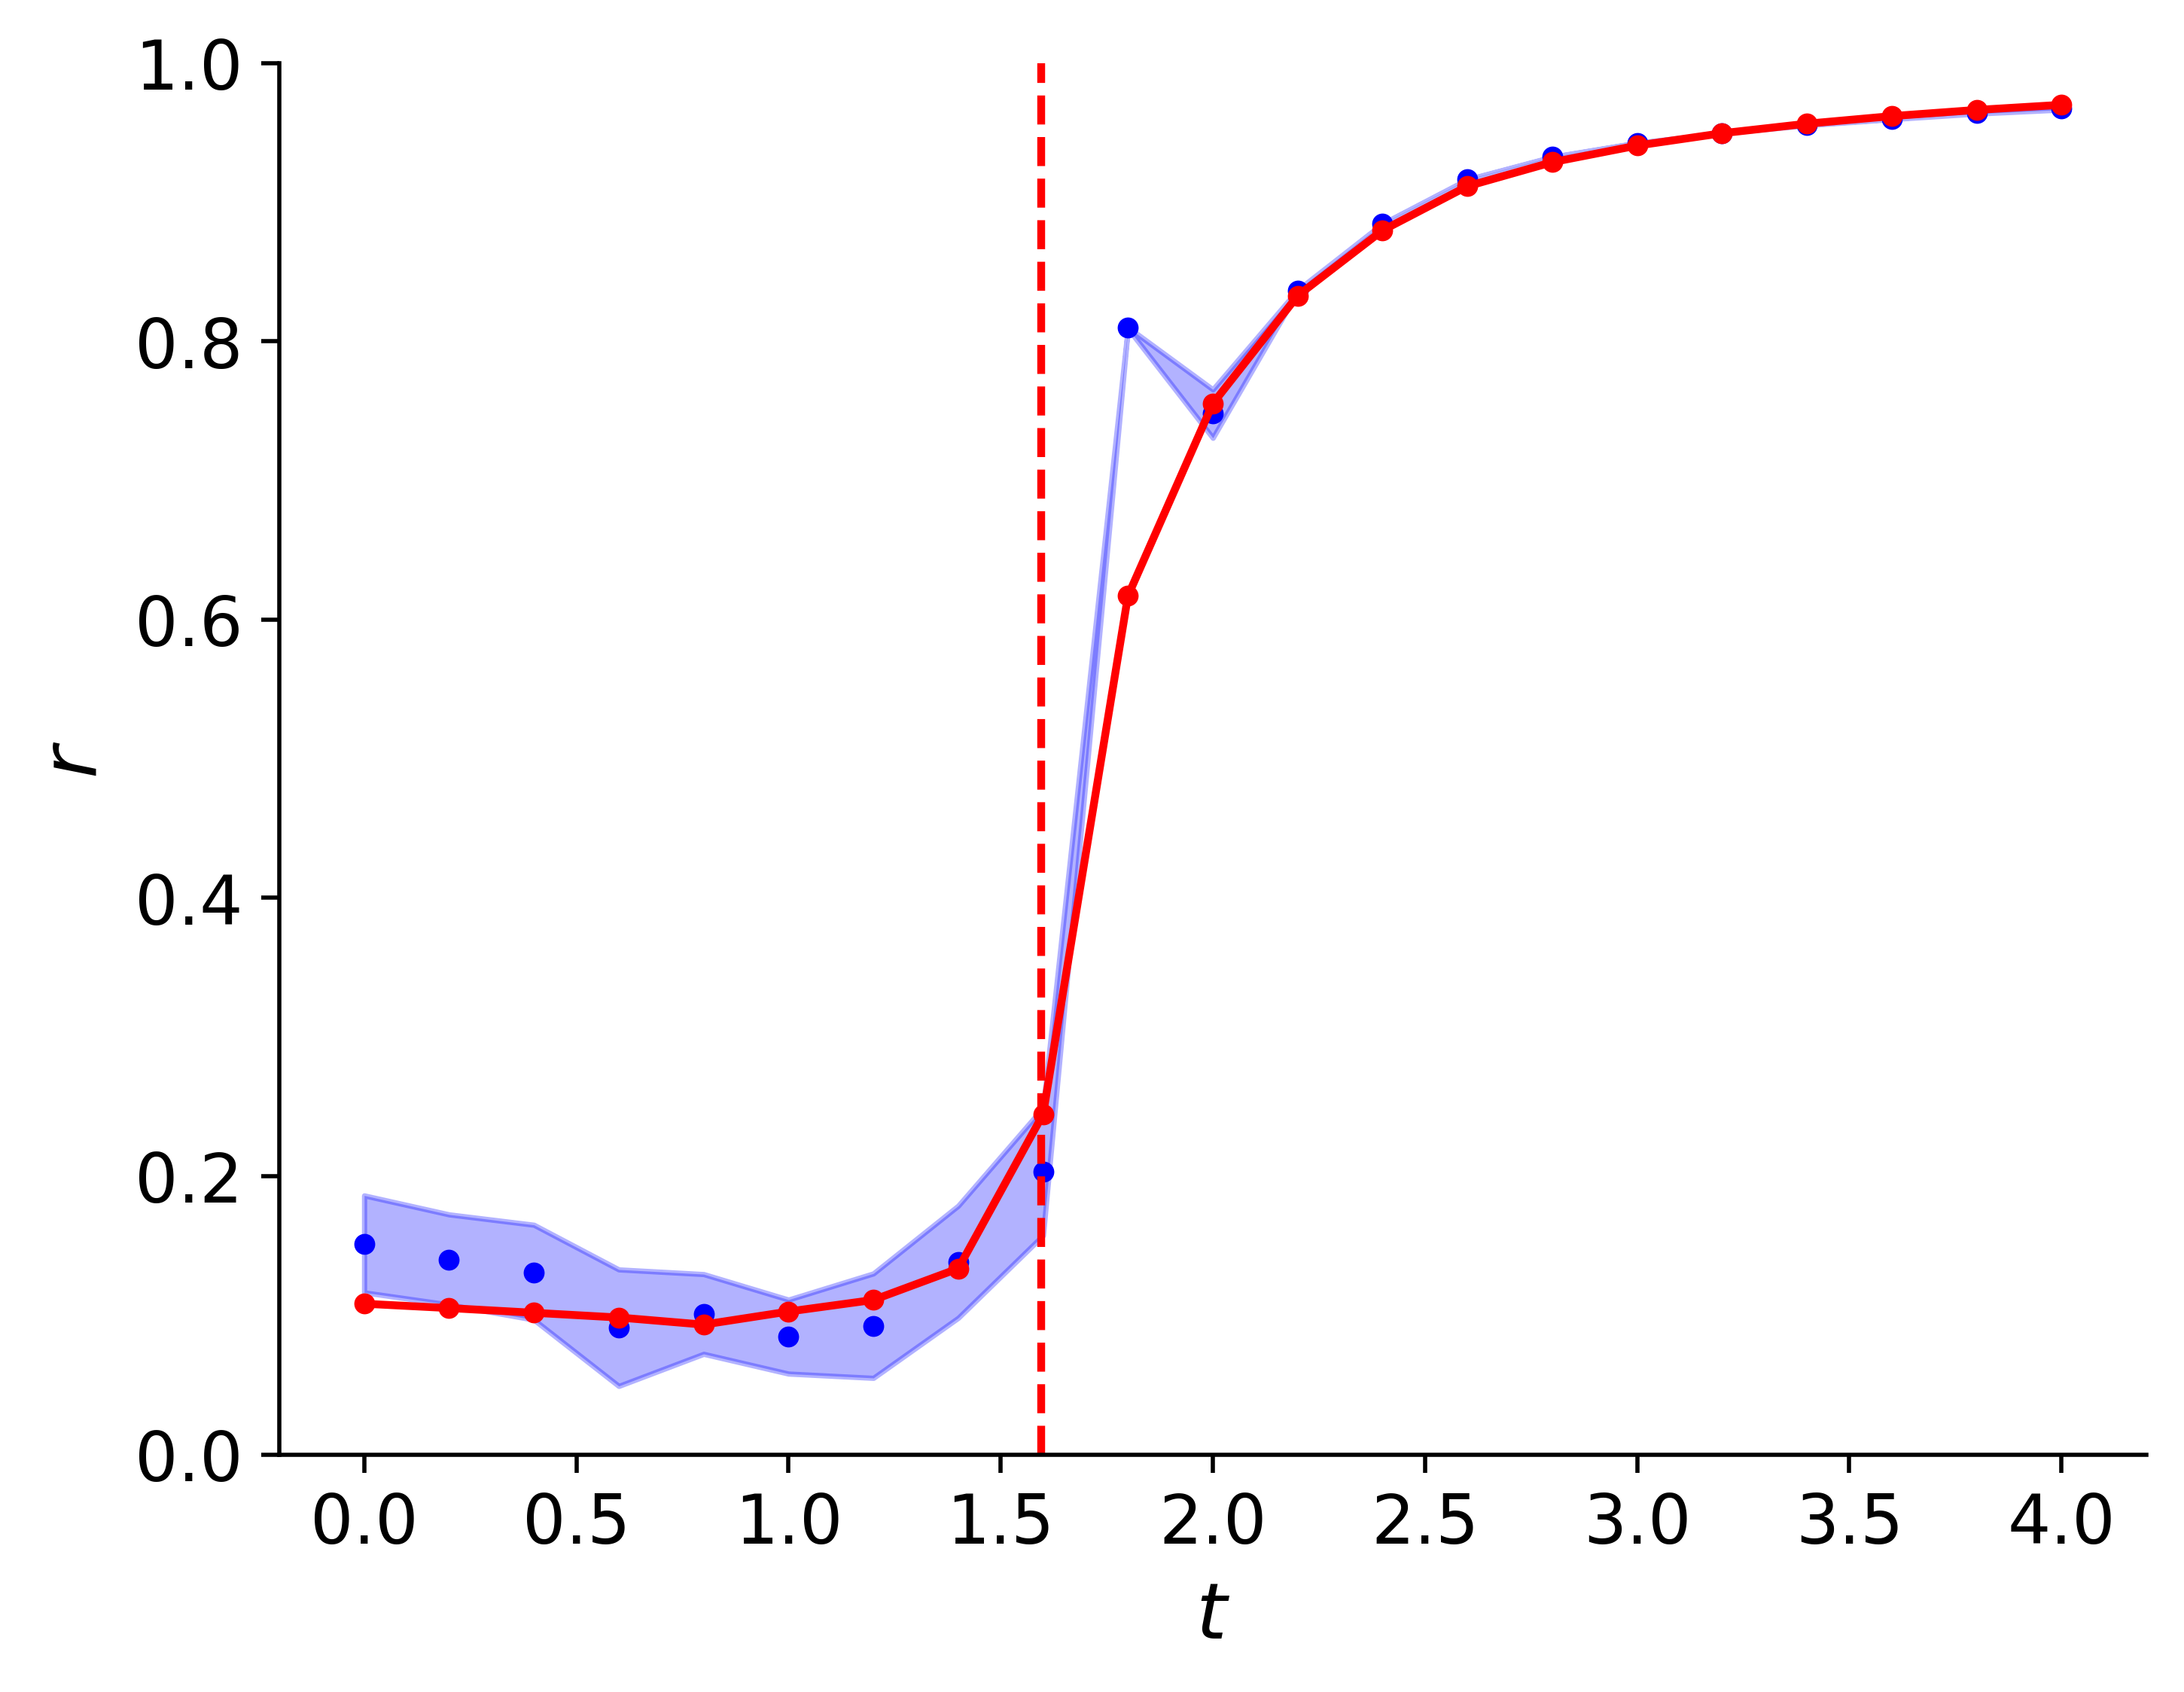

In [2325]:
plt.figure(dpi=500)
rr = df['r'].to_numpy()
r_mean =np.nanmean(rr,axis=0)
r_std =np.nanstd(rr,axis=0)
plt.plot(Ks,r_mean,'.',color='Blue')
plt.fill_between(Ks,r_mean-r_std,r_mean+r_std,alpha=0.3,color='Blue')
plt.plot(Ks,K_rs,'.-',color='red')
plt.ylim(0,1)
# plt.axhline(0)
plt.axvline(K_c,ls='--',color='red')

plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Particle filter

In [2333]:
from numba import njit

In [2543]:
Ks = np.arange(0,4.1,0.2)
seed =11
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.1
t = np.arange(0,100,dt)
K = 2
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)

In [2545]:
def f(x,omega=omega,K_noise=0):
    x = x.copy()
    T = x[:N]
    K = x[-1]
    Ti,Tj = np.meshgrid(T,T)
    dtheta = omega + K/N*np.sum(np.sin(Tj - Ti),axis=0) 
    T_new = T + dtheta*dt
    T_new = (T_new+np.pi)%(2*np.pi) -  np.pi
    return np.r_[T_new,K+np.random.randn()*K_noise]

def h(x):
    x = x.copy()
    T = x[:N]
    R = np.abs(np.mean(np.exp(1j*T)))
    return np.array([R])

In [2546]:
def predict_p(particles,omega,N_p):
    p = particles.copy()
    for i in range(N_p):
        p[i] = f(p[i],omega)
    return p

def meas_p(p_bar):
    return np.array([h(p) for p in p_bar])
def likelihood(z, R_pred,R_meas):
    return np.exp(-0.5*(z - R_pred)**2 / R_meas) / np.sqrt(2*np.pi*R_meas)

In [2537]:
N_p = 200
particles = np.zeros((N_p, N+1)) # [theta_1,...,theta_N, K]
weights = np.ones(N_p)/N_p
for i in range(N_p):
    particles[i,:N] = np.random.uniform(-np.pi, np.pi, N)
    particles[i,N] = np.random.uniform(K-1, K+1) 

for i in range(N_p):
    particles[i] = f(particles[i])

for i in range(N_p):
    R_pred = h(particles[i])
    w = likelihood(rs[num] + np.random.randn()*np.sqrt(R_meas),R_pred,R_meas)
    weights[i]*=w
weights += 1e-300
weights/=np.sum(weights)
x_hat = np.sum(particles * weights[:, np.newaxis], axis=0)
particles[:,:N] = (particles[:,:N]+np.pi)%(2*np.pi) - np.pi
z_hat = h(x_hat)

IndexError: index 1999 is out of bounds for axis 0 with size 1000

In [2500]:
x_hat

array([-1.48205895, -0.73736594, -2.70228411,  1.88332804,  0.04387377,
        1.01488003, -1.13152722,  1.53908817,  1.12709349, -0.35329731,
        1.13967402,  0.89303162, -0.70814747,  0.42579744, -1.72596067,
        1.84658143,  0.92696706,  0.31166784,  0.23196836,  1.73142777,
        1.28359381, -1.95086639, -2.05614531,  0.16307809,  0.93165958,
       -1.09992134, -0.55309103,  1.53121773,  0.77797847, -0.50109642,
        0.82649276,  1.19285099, -2.79495944,  1.4439775 ,  0.67271472,
        0.78058814, -2.22196717,  0.056315  ,  1.72969979,  1.28022717,
        1.04156233,  0.61973009, -2.28310827, -1.33202513,  2.24969367,
        0.64305376, -2.60977051, -0.88025103,  0.19433123, -0.55714663,
        1.54623432])

In [2761]:
T_s = {}

In [2781]:
import time

N_p = 12800
particles = np.zeros((N_p, N+1)) # [theta_1,...,theta_N, K]
for i in range(N_p):
    particles[i,:N] = np.random.uniform(-np.pi, np.pi, N)
    particles[i,N] = np.random.uniform(K-1, K+1) 

weights = np.ones(N_p)/N_p
P_arr = np.zeros((len(t),*particles.shape))
X_arr = np.zeros((len(t),N+1))

z_arr = np.zeros((len(t)))
W_arr = np.zeros((len(t),*weights.shape))
Neff_arr = np.zeros(len(t))
T_s[N_p] = []
for num in range(len(t)):
    
    start_time = time.time()

    for i in range(N_p):
        particles[i] = f(particles[i], K_noise=0.005)

    for i in range(N_p):
        R_pred = h(particles[i])
        w = likelihood(rs[num] + np.random.randn() * np.sqrt(R_meas), R_pred, R_meas)
        weights[i] *= w
    weights += 1e-30
    weights /= np.sum(weights)
    particles[:, :N] = (particles[:, :N] + np.pi) % (2 * np.pi) - np.pi

    x_hat = np.sum(particles * weights[:, np.newaxis], axis=0)
    z_hat = h(x_hat)
    ESS = 1.0 / np.sum(weights**2)
    X_arr[num] = x_hat
    z_arr[num] = z_hat[0]
    P_arr[num] = particles
    W_arr[num] = weights
    if ESS < N_p * 0.7:
        indices = np.random.choice(np.arange(N_p), size=N_p, p=weights)
        particles = particles[indices]
        weights = np.ones(N_p) / N_p

    end_time = time.time()
    T_ = end_time - start_time
    T_s[N_p].append(T_)
    if num == 100:
        break
    print(f"ESS: {ESS}, z_hat: {z_hat[0]}, x_hat[-1]: {x_hat[-1]}, Time taken: {end_time - start_time} seconds")

# for i in range(N_p):
#     R_pred = f(particles[i],omega)

/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_8937/2273439193.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i] *= w


ESS: 10065.984751163045, z_hat: 0.9998143188775045, x_hat[-1]: 1.999693809687239, Time taken: 0.8492720127105713 seconds
ESS: 7876.327025908689, z_hat: 0.9998376197677259, x_hat[-1]: 1.9911780330800846, Time taken: 0.8520119190216064 seconds
ESS: 10230.977029348129, z_hat: 0.9996866353926015, x_hat[-1]: 1.9927725817639228, Time taken: 0.8509199619293213 seconds
ESS: 8112.805660521851, z_hat: 0.9996782408321713, x_hat[-1]: 1.9867516152459377, Time taken: 0.8578577041625977 seconds
ESS: 10303.952787180537, z_hat: 0.9994669045375215, x_hat[-1]: 1.9745873742428854, Time taken: 0.8460590839385986 seconds
ESS: 8265.199762320679, z_hat: 0.9993567537692849, x_hat[-1]: 1.9629581535630132, Time taken: 0.8569540977478027 seconds
ESS: 10301.952347944305, z_hat: 0.999381630072052, x_hat[-1]: 1.9595192617981267, Time taken: 0.8389608860015869 seconds
ESS: 8233.315207946105, z_hat: 0.9994293188520664, x_hat[-1]: 1.9568630317147562, Time taken: 0.864210844039917 seconds
ESS: 10179.585900197528, z_hat:

In [2806]:
y = np.poly1d(np.polyfit(xs.to_numpy(),df_T.mean().sort_index().to_numpy(),1))

In [2809]:
np.polyfit(xs.to_numpy(),df_T.mean().sort_index().to_numpy(),1)

array([6.12076938e-05, 1.55149704e-04])

In [2812]:
y(50) * 1000

3.2155343942327024

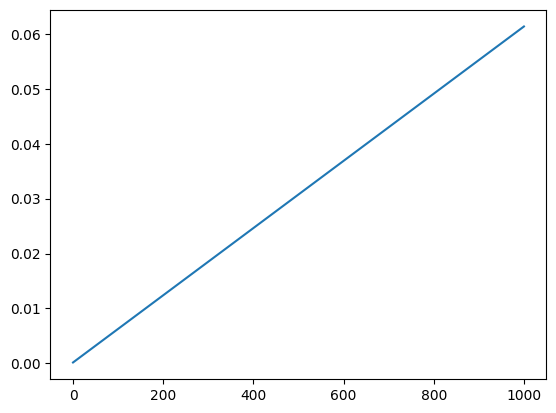

In [2807]:
ms = np.linspace(0,1000)
plt.plot(ms,y(ms))


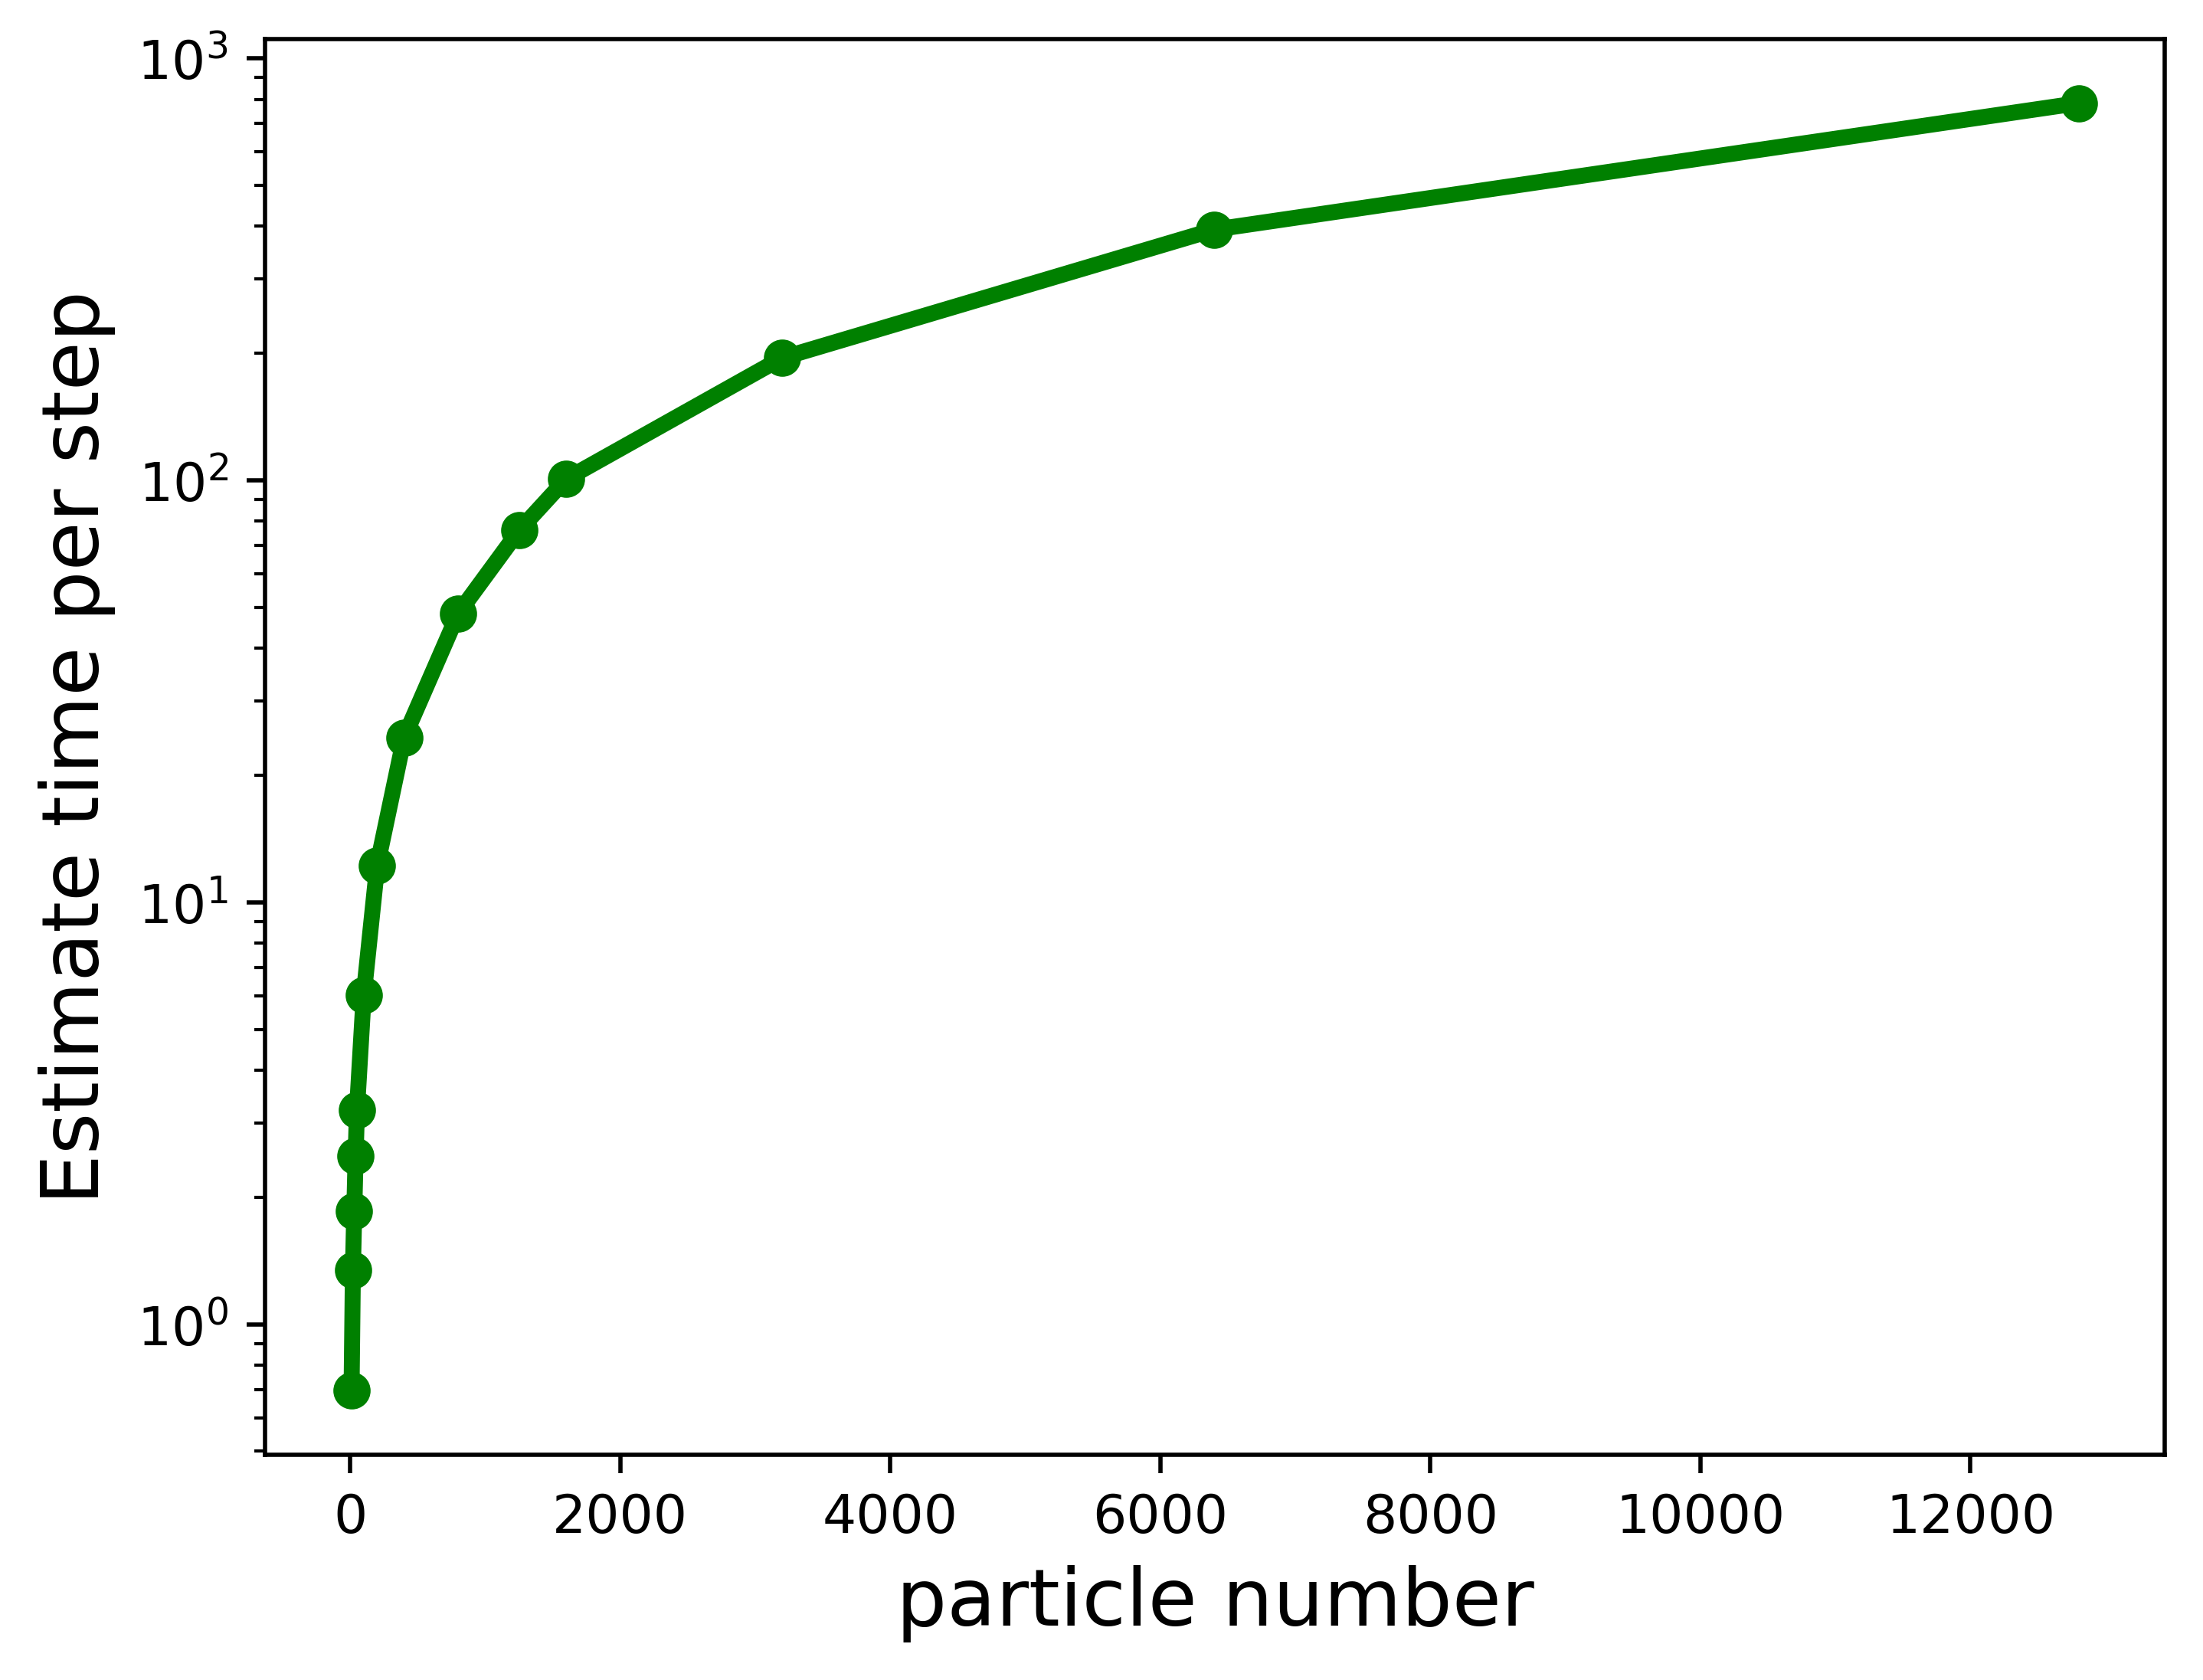

In [2796]:
plt.figure(dpi=500)
plt.plot(df_T.mean().sort_index()*1000,'o-',lw=3,color='green')
plt.xlabel('particle number',fontsize=15)
plt.ylabel('Estimate time per step',fontsize=15)
plt.yscale('log')

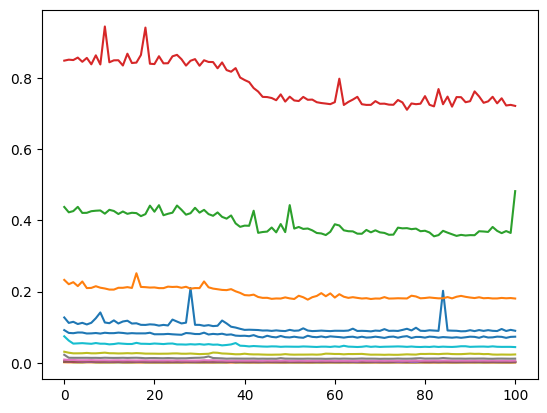

In [2783]:
plt.plot(df_T)

In [2778]:
np.mean(X_arr[-50:,-1]-K)

-2.0

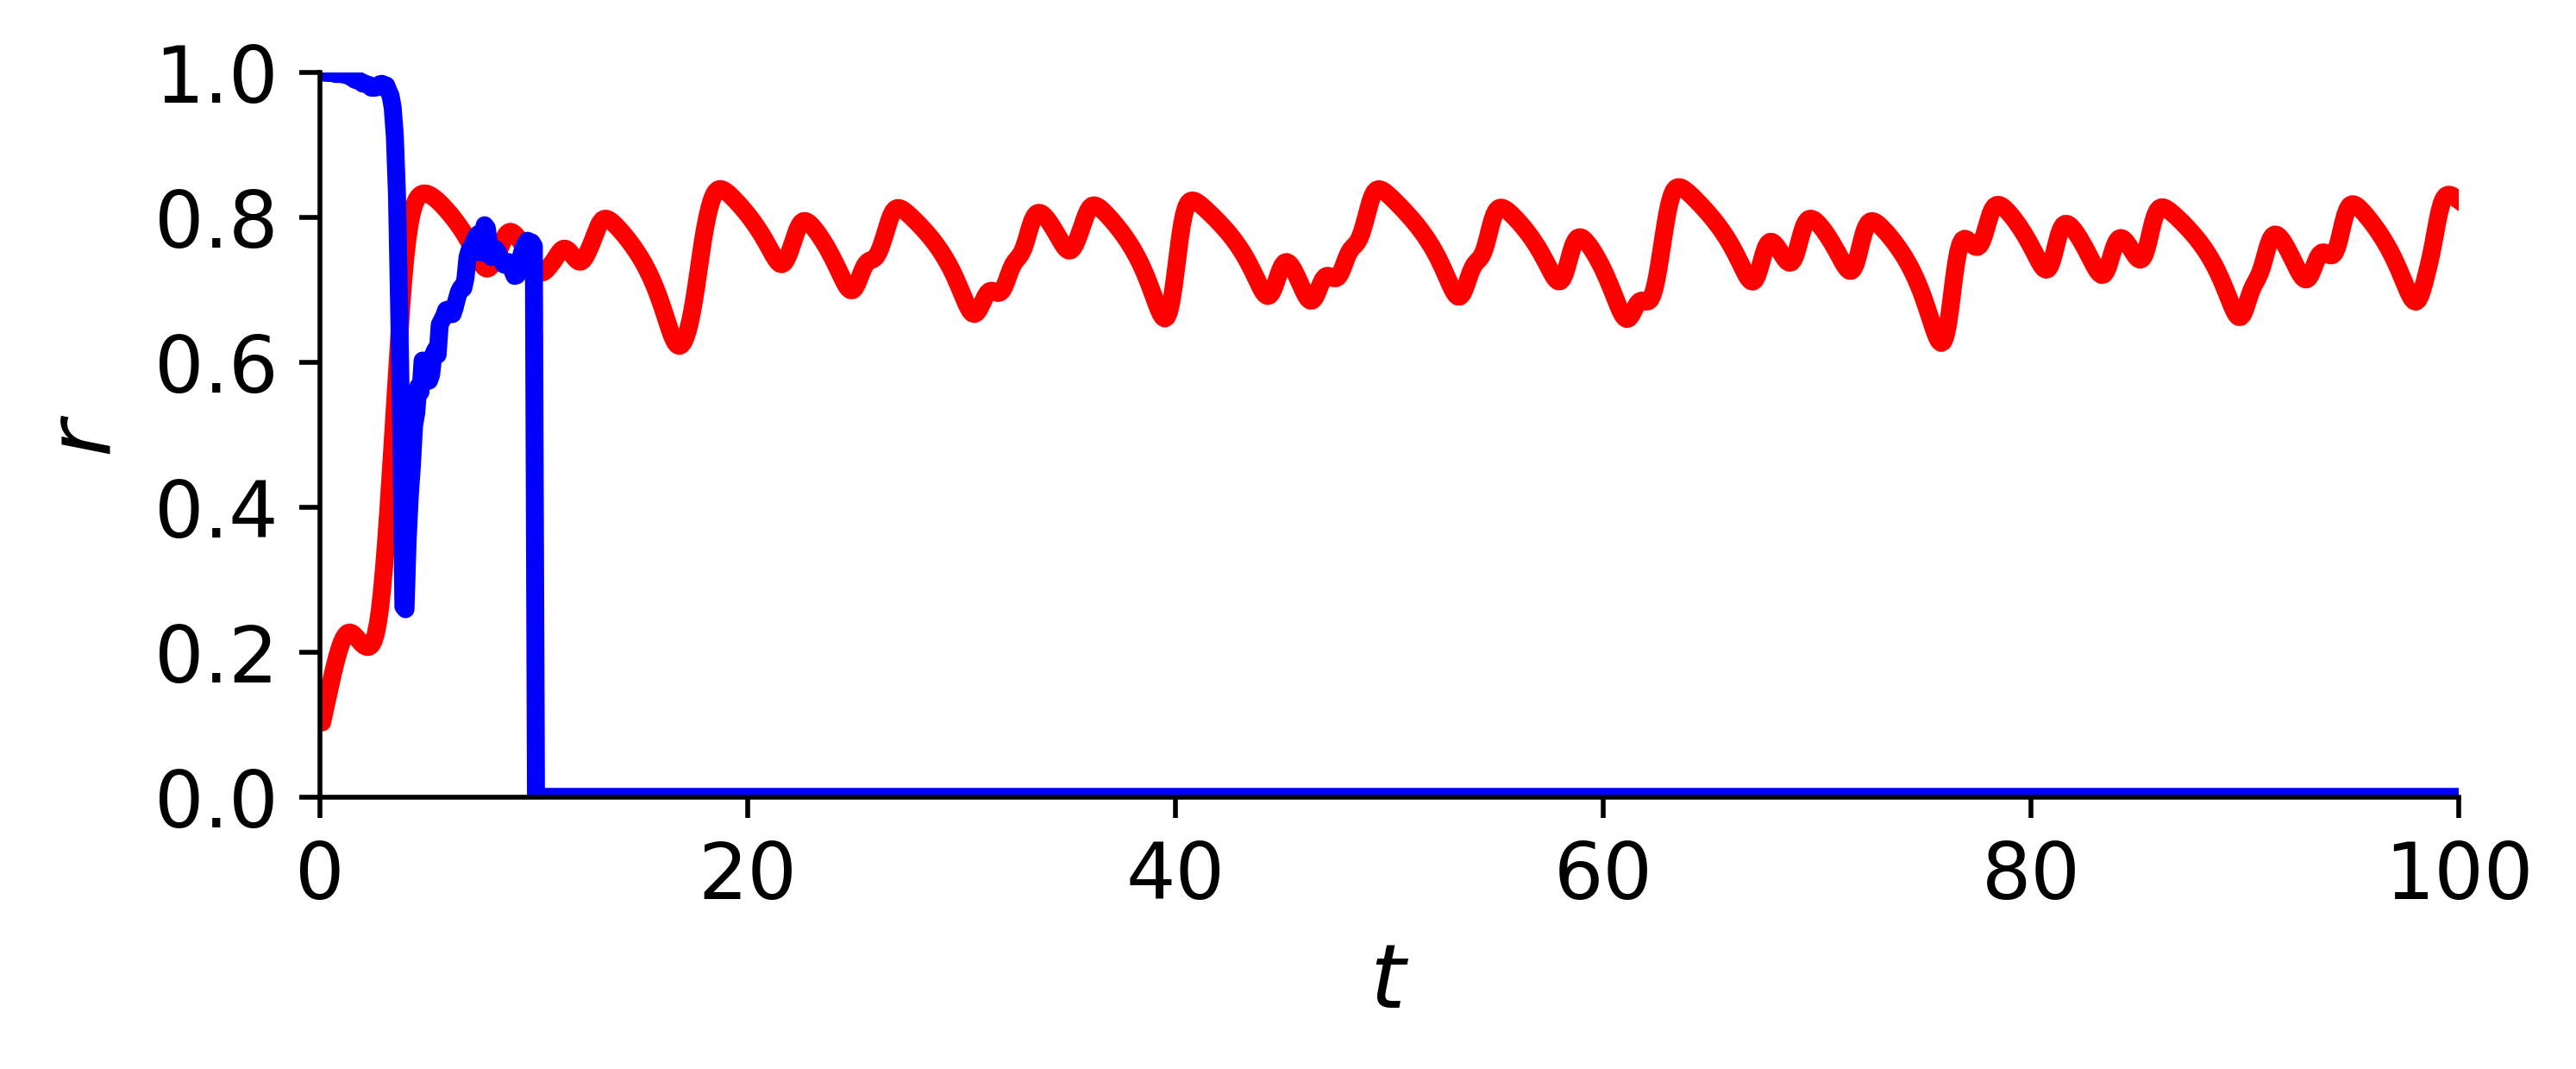

In [2779]:
plt.figure(dpi=500)
plt.subplot(211)
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,z_arr,color='blue',lw=3)

plt.xlim(0,100)
plt.ylim(0,1)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

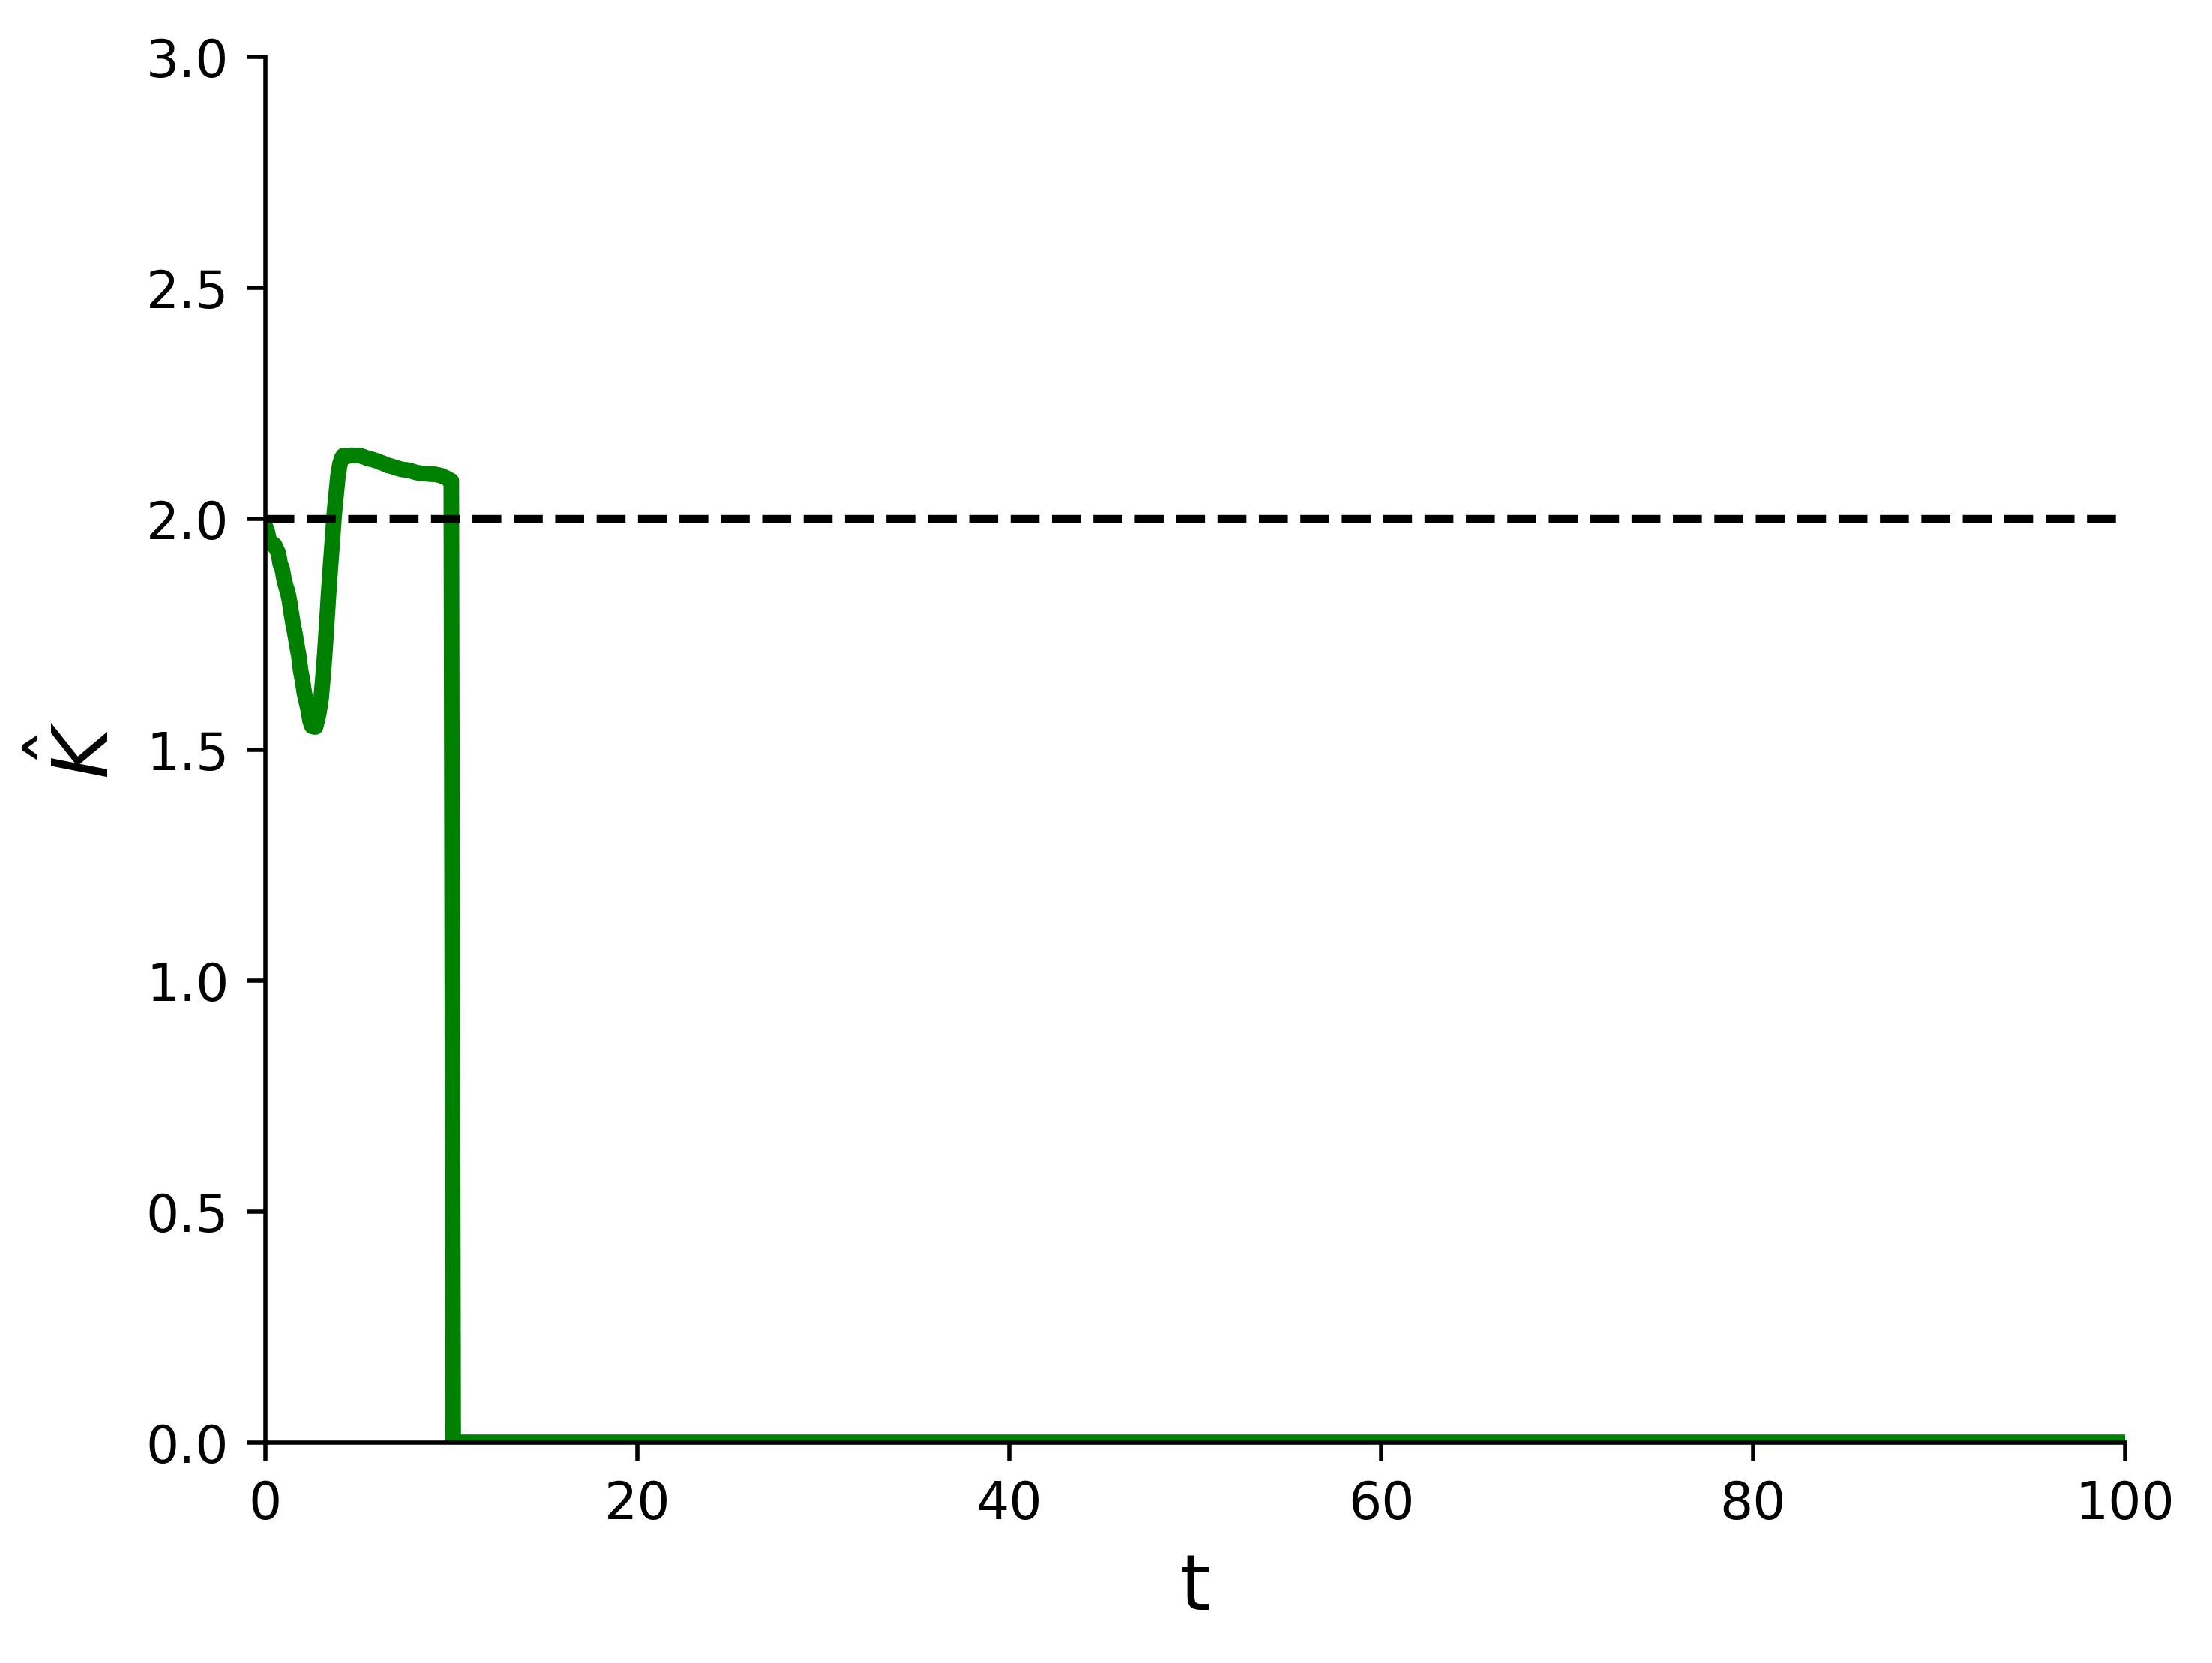

In [2780]:
plt.figure(dpi=500)
plt.plot(t,X_arr[:,-1],color='green',lw=3)
plt.axhline(K,color='black',ls='--')
plt.ylim(0,3)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,100)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

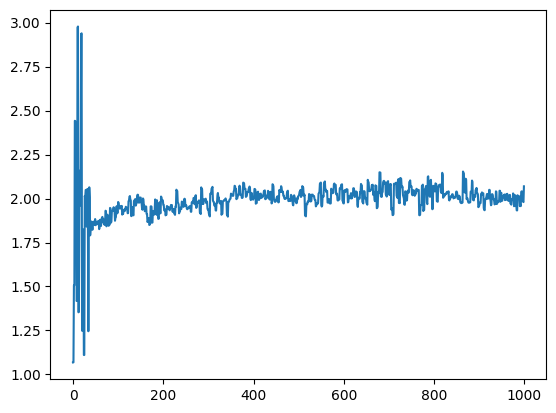

In [2749]:
plt.plot(X_arr[:,-1])

(array([  0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.49, -0.39, -0.29, -0.19, -0.09,  0.01,  0.11,  0.21,  0.31,
         0.41,  0.51]),
 <BarContainer object of 10 artists>)

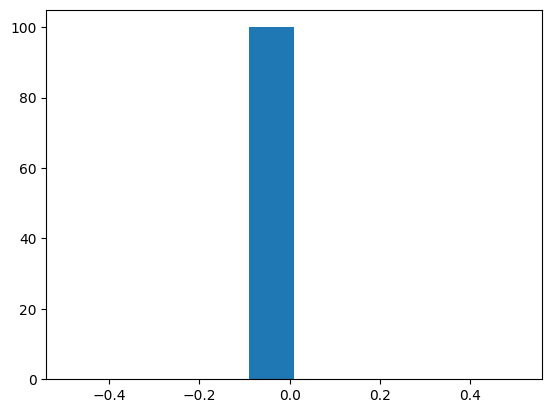

In [2636]:
plt.hist(weights)

In [2842]:
Ks = np.arange(0,4.1,0.2)
seed =11
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.1
t = np.arange(0,100,dt)
K = 1.6
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)

In [2843]:
N_p = 50
particles = np.zeros((N_p, N+1)) # [theta_1,...,theta_N, K]
for i in range(N_p):
    particles[i,:N] = np.random.uniform(-np.pi, np.pi, N)
    particles[i,N] = np.random.uniform(K-1, K+1) 

weights = np.ones(N_p)/N_p
P_arr = np.zeros((len(t),*particles.shape))
X_arr = np.zeros((len(t),N+1))

z_arr = np.zeros((len(t)))
W_arr = np.zeros((len(t),*weights.shape))
Neff_arr = np.zeros(len(t))
for num in range(len(t)):
    for i in range(N_p):
        particles[i] = f(particles[i], K_noise=0.005)

    for i in range(N_p):
        R_pred = h(particles[i])
        w = likelihood(rs[num] + np.random.randn() * np.sqrt(R_meas), R_pred, R_meas)
        weights[i] *= w
    weights += 1e-30
    weights /= np.sum(weights)
    particles[:, :N] = (particles[:, :N] + np.pi) % (2 * np.pi) - np.pi

    x_hat = np.sum(particles * weights[:, np.newaxis], axis=0)
    z_hat = h(x_hat)
    ESS = 1.0 / np.sum(weights**2)
    X_arr[num] = x_hat
    z_arr[num] = z_hat[0]
    P_arr[num] = particles
    W_arr[num] = weights
    if ESS < N_p * 0.7:
        indices = np.random.choice(np.arange(N_p), size=N_p, p=weights)
        particles = particles[indices]
        weights = np.ones(N_p) / N_p

# for i in range(N_p):

/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_8937/4243526698.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i] *= w


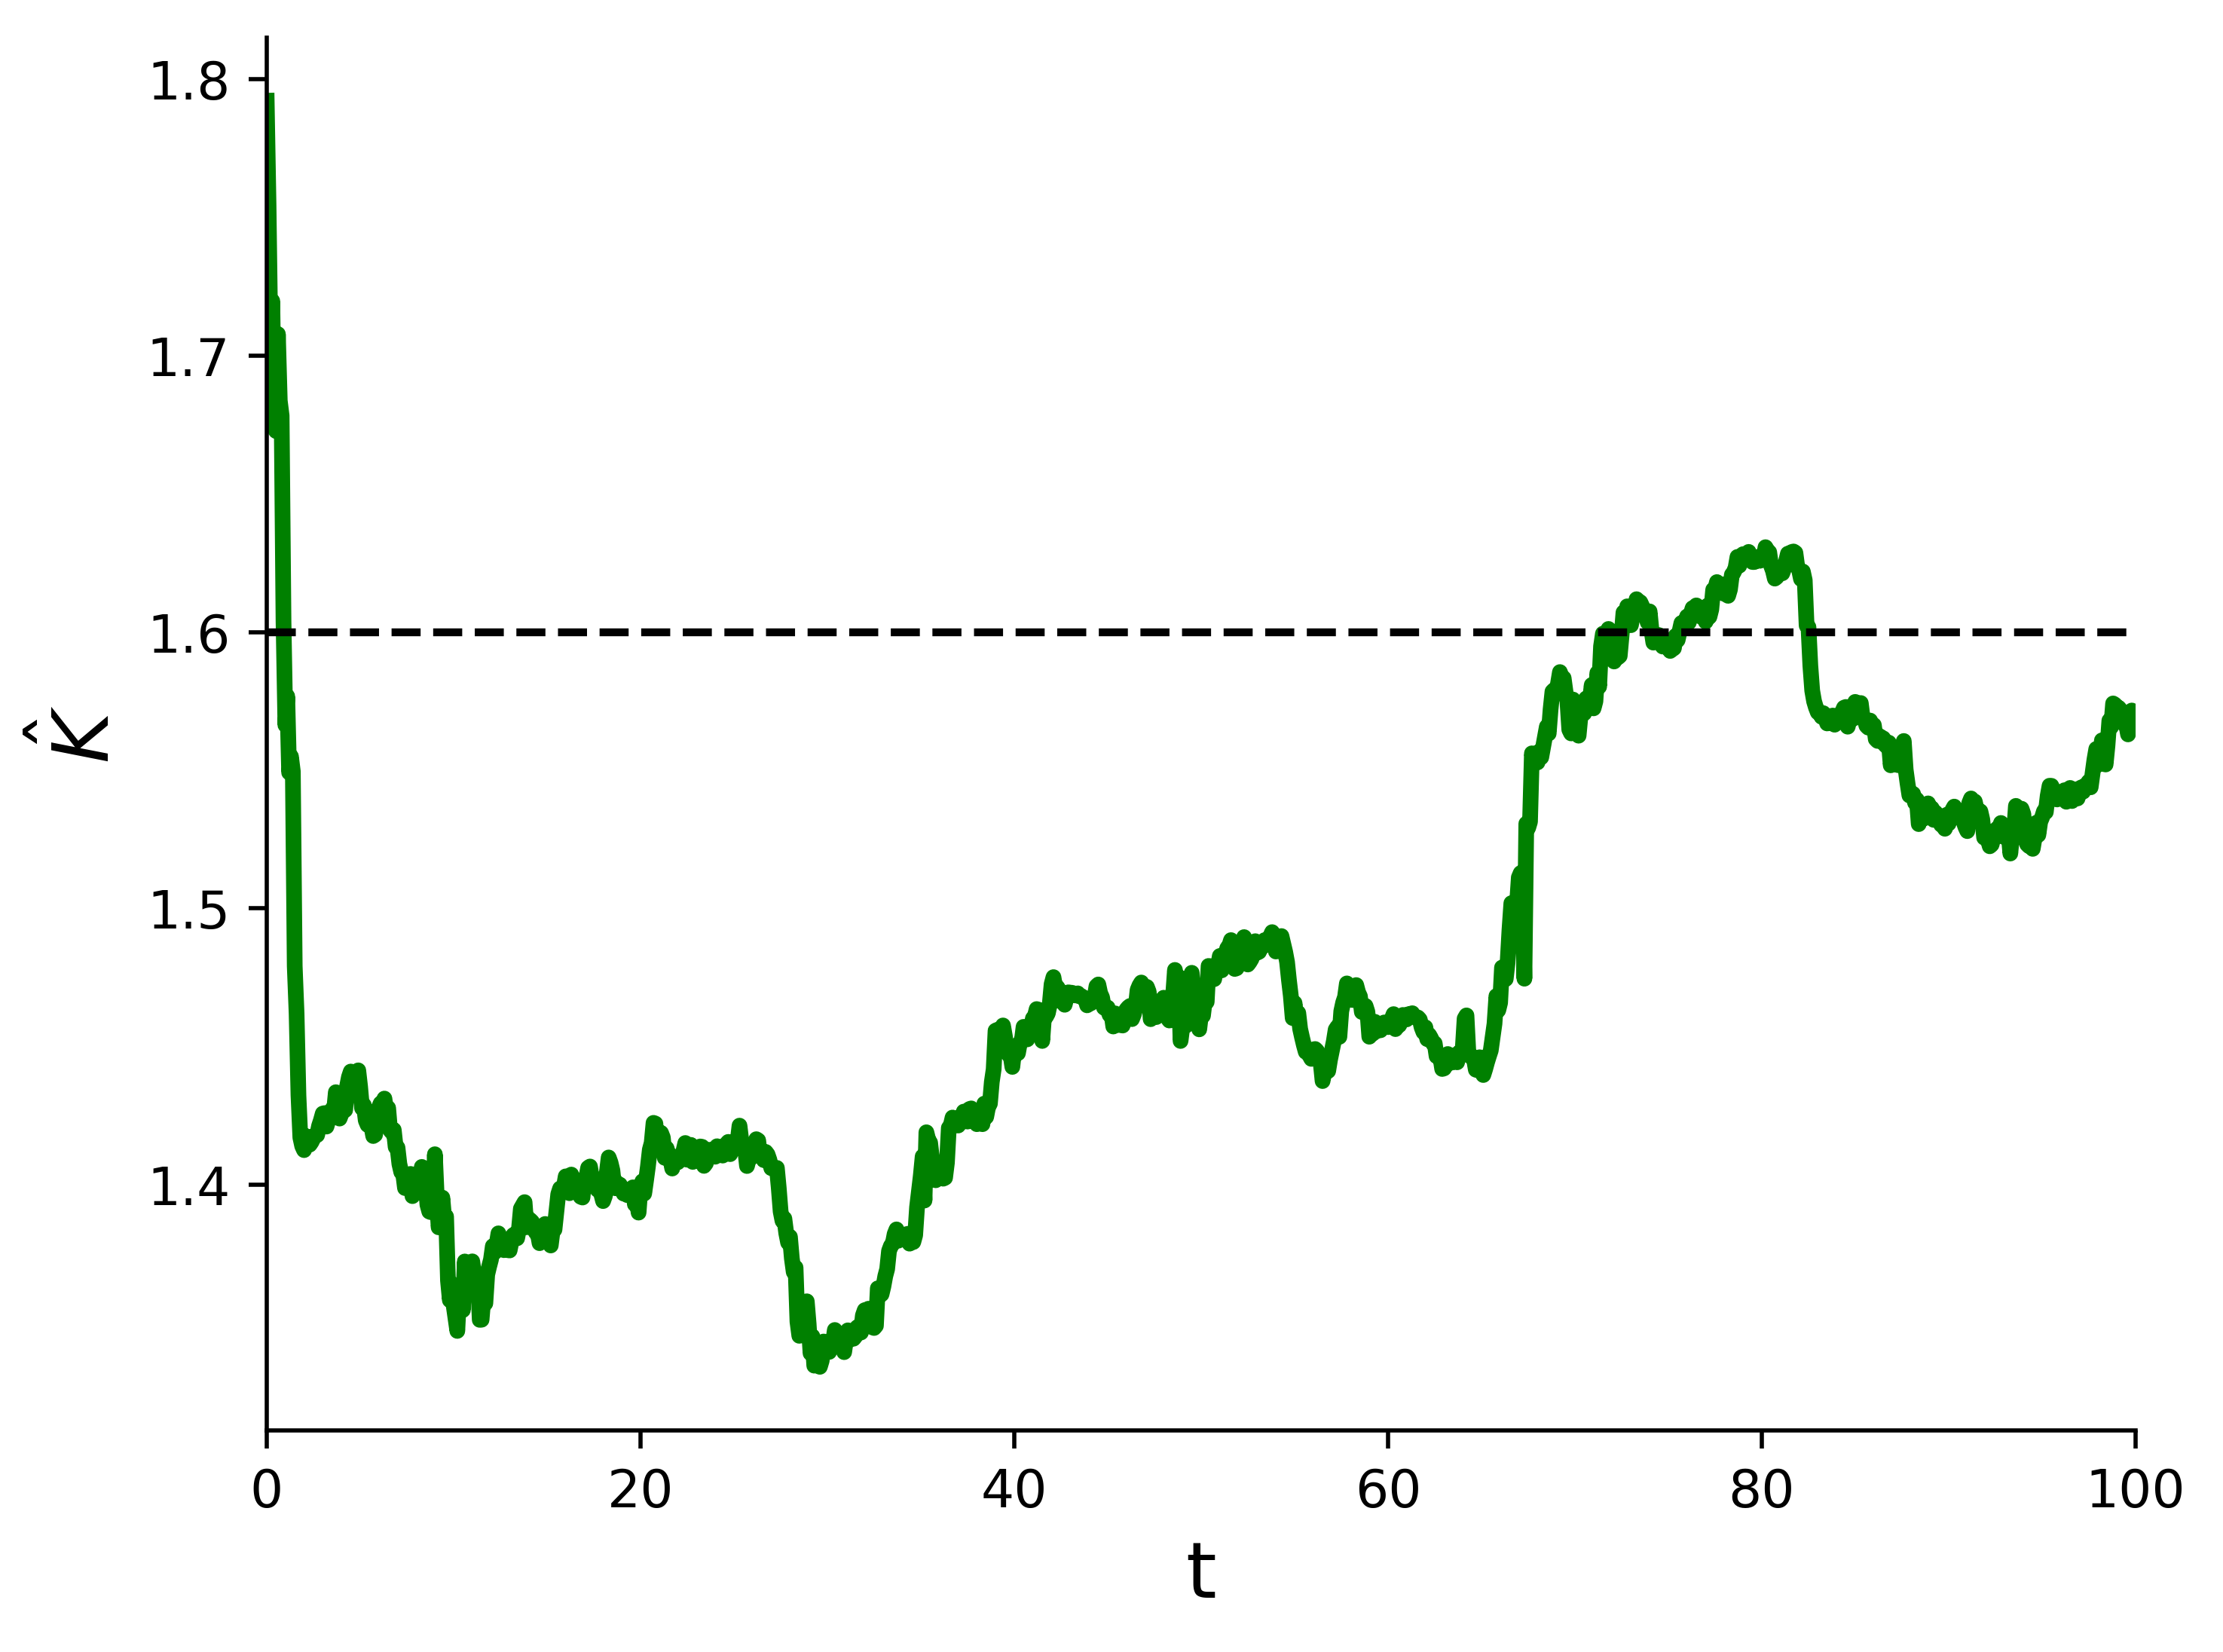

In [2844]:
plt.figure(dpi=500)
plt.plot(t,X_arr[:,-1],color='green',lw=3)
plt.axhline(K,color='black',ls='--')
# plt.ylim(0,3)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,100)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

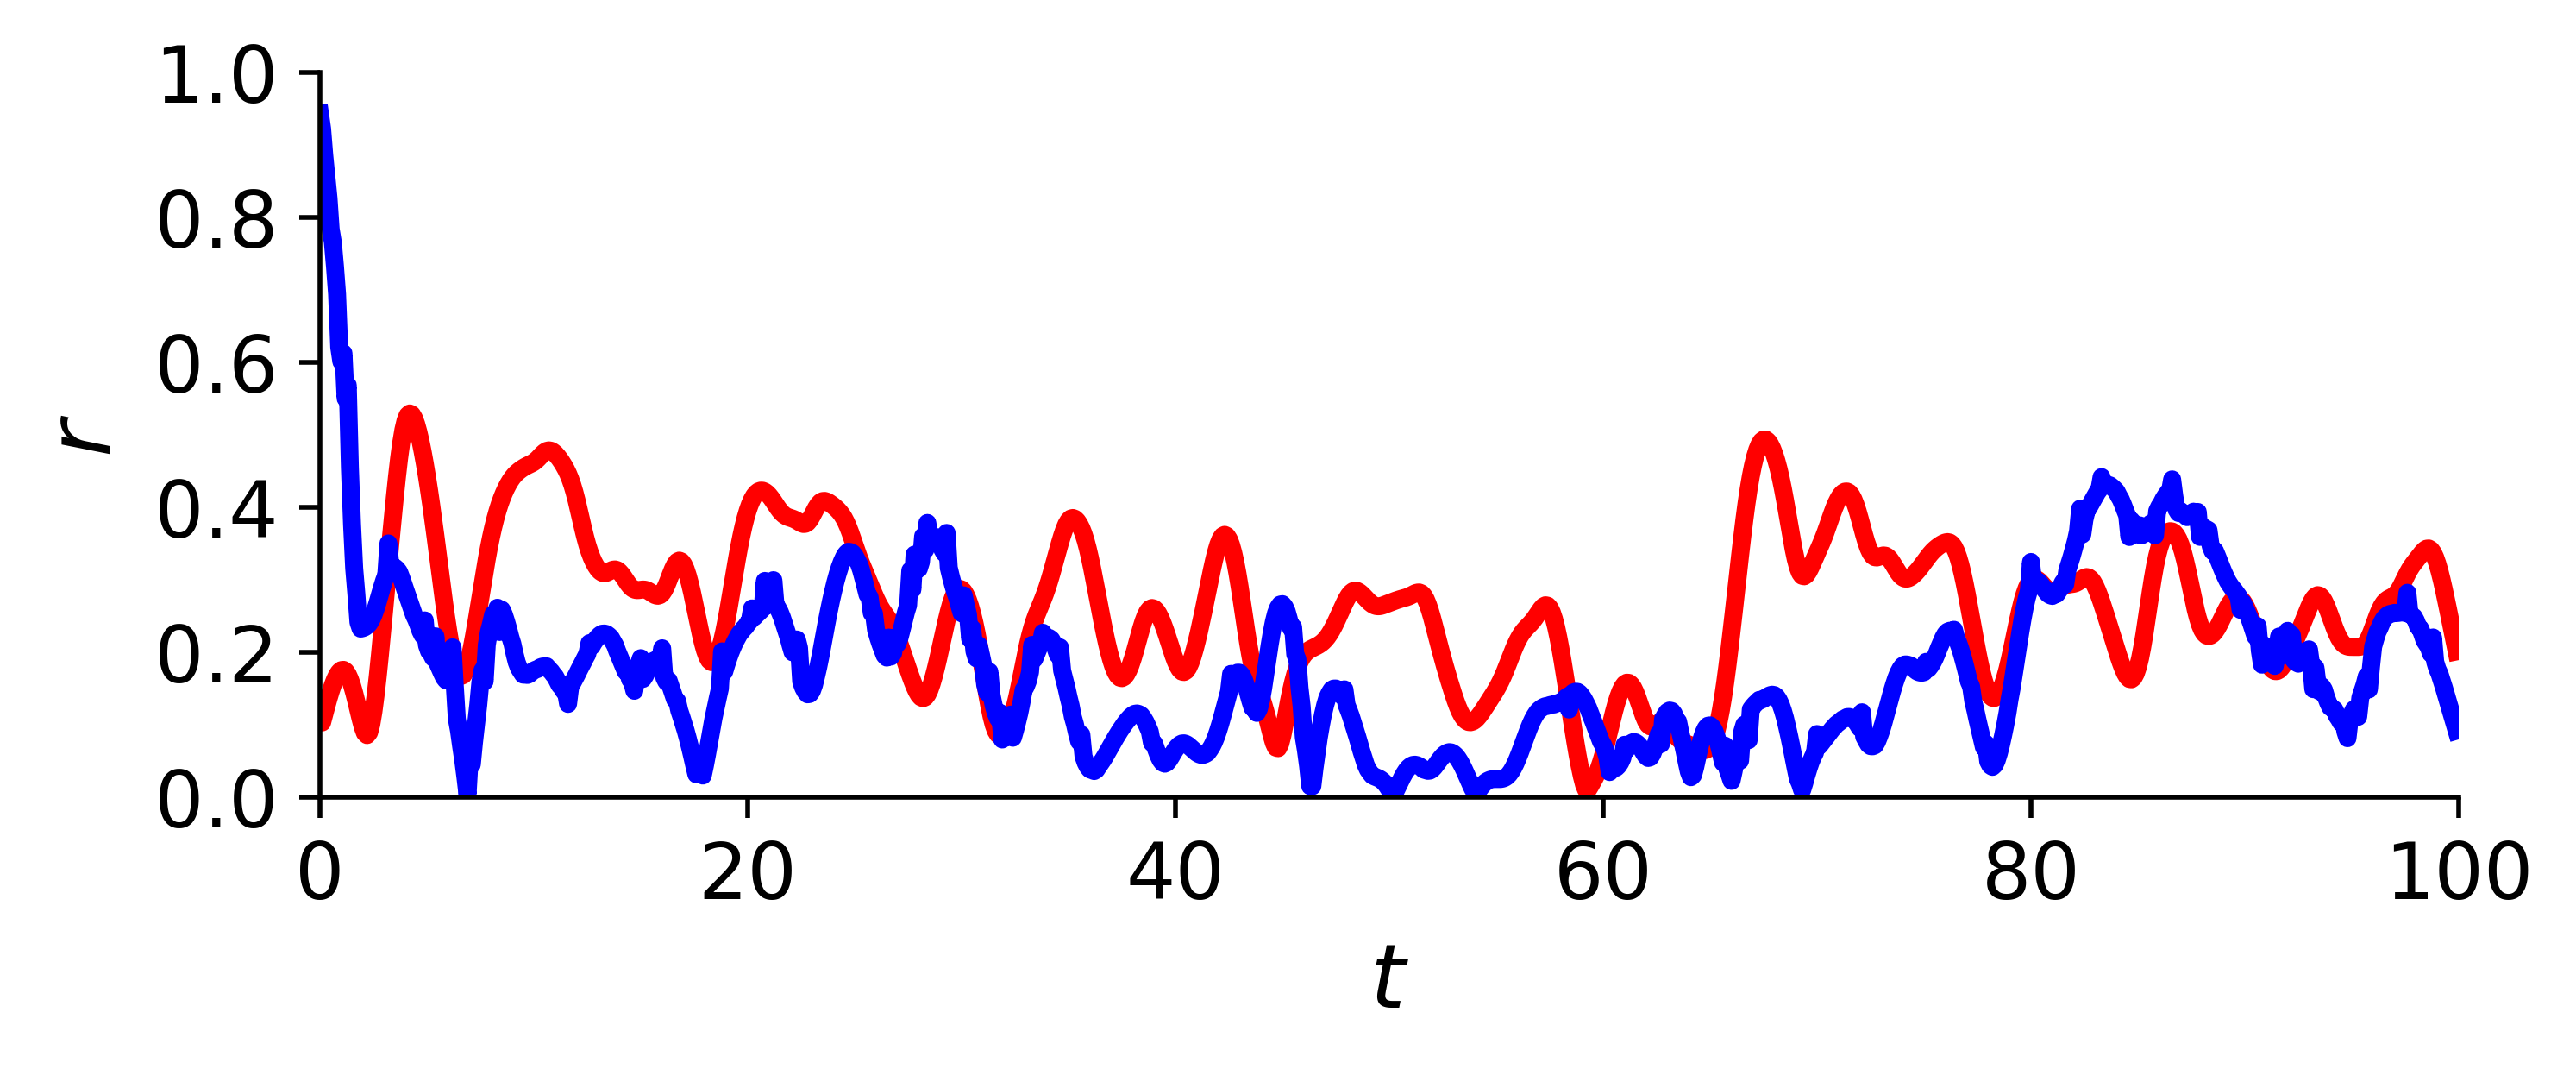

In [2845]:
plt.figure(dpi=500)
plt.subplot(211)
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,z_arr,color='blue',lw=3)

plt.xlim(0,100)
plt.ylim(0,1)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [2867]:
K_rs = []
K_est_PF = {}


for K in tqdm(Ks):
    theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
    r_mean = np.mean(rs[-500:])
    K_rs.append(r_mean)
    K_est_PF['r',K] = []
    K_est_PF['K',K] = []

    
    # for num in tqdm(range(50)):
    @parfor(np.arange(50),bar=False)
    def get_r_K_mean(num,K=K):
        N_p = 250
        particles = np.zeros((N_p, N+1)) # [theta_1,...,theta_N, K]
        for i in range(N_p):
            particles[i,:N] = np.random.uniform(-np.pi, np.pi, N)
            particles[i,N] = np.random.uniform(K-1, K+1) 

        weights = np.ones(N_p)/N_p
        P_arr = np.zeros((len(t),*particles.shape))
        X_arr = np.zeros((len(t),N+1))

        z_arr = np.zeros((len(t)))
        W_arr = np.zeros((len(t),*weights.shape))
        Neff_arr = np.zeros(len(t))
        for num in range(len(t)):
            for i in range(N_p):
                particles[i] = f(particles[i], K_noise=0.005)

            for i in range(N_p):
                R_pred = h(particles[i])
                w = likelihood(rs[num] + np.random.randn() * np.sqrt(R_meas), R_pred, R_meas)
                weights[i] *= w
            weights += 1e-30
            weights /= np.sum(weights)
            particles[:, :N] = (particles[:, :N] + np.pi) % (2 * np.pi) - np.pi

            x_hat = np.sum(particles * weights[:, np.newaxis], axis=0)
            z_hat = h(x_hat)
            ESS = 1.0 / np.sum(weights**2)
            X_arr[num] = x_hat
            z_arr[num] = z_hat[0]
            P_arr[num] = particles
            W_arr[num] = weights
            if ESS < N_p * 0.5:
                indices = np.random.choice(np.arange(N_p), size=N_p, p=weights)
                particles = particles[indices]
                weights = np.ones(N_p) / N_p
        

        K_est_PFm = np.mean(X_arr[-50:,-1]) 
        r_estm = np.mean(z_arr[-50:]) 
        return K_est_PFm,r_estm
    K_est_PFs,r_ests = zip(*get_r_K_mean)
    print(K_est_PFs,r_ests)
    K_est_PF['K',K] = K_est_PFs
    K_est_PF['r',K] = r_ests

  0%|          | 0/21 [00:00<?, ?it/s]

(-0.8814932612772531, -1.1421288110629626, -0.9552022870602686, -0.7400855505366353, -1.2789006306636148, -0.5168946853550829, -0.6843435879179343, -0.9611355287855556, -0.6554340577553619, -0.23598171213881577, -0.960489160559749, -0.8295937933606247, -0.3879815536638741, -0.22207740312430832, -0.8921177740236657, -0.7466424644002307, -0.976709754077368, -1.054037999472631, -0.7699679843582302, 0.20993150844369401, 0.14698831638652762, -1.1193948355600538, -0.7168561288992555, 0.33067358810007114, 0.1418863583865426, -0.5518021158421861, -0.6513157600880551, -0.5730248377990751, -0.9487518026103762, -1.0550233909964235, -0.5092206733515889, -0.8673601700820156, -0.439502318988092, -1.0736788014166192, -1.0421399999705678, -0.4714396675966879, -0.5247711365639536, -0.31414294251850483, -0.7790692164775157, -0.868522456101681, -1.0241887567156642, -0.6616865819260107, -0.282541963881719, -0.7444324816826764, -0.46954263016998754, -0.6709254418244656, 0.11595505229476359, -0.440281892227

In [2869]:
df_PF = pd.DataFrame(K_est_PF)

In [2870]:
df = df_PF.copy()

In [2871]:
# IQR 계산
Q1 = df['K'].quantile(0.25)
Q3 = df['K'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 정의
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 각 column마다 이상치를 NaN으로 대체
for col in df['K'].columns:
    df['K', col] = df['K', col].apply(lambda x: x if lower_bound[col] <= x <= upper_bound[col] else np.nan)
    df['r', col] = df['r', col].where(df['K', col].notna(), np.nan)

In [2872]:
df['K']

0.0       0.2       0.4       0.6       0.8       1.0       1.2  \
0  -0.881493  0.547832 -0.747592 -0.394636 -0.228279  0.346527  1.271938   
1  -1.142129 -0.919050 -0.282604 -0.221937  0.136447  0.607806  1.344435   
2  -0.955202 -0.787434 -0.449730  0.163786  0.162569  1.072899  0.931616   
3  -0.740086  0.016650 -0.394836  0.261141  0.249184  1.331563  0.696254   
4  -1.278901 -0.560817 -0.160513  0.887182  0.458065  0.619236  0.242355   
5  -0.516895 -0.307515  0.364085  0.262381  0.130982 -0.023416  0.590947   
6  -0.684344 -0.905688  0.771009  0.184088  0.885056  0.803814  1.210234   
7  -0.961136 -1.184395 -0.577019  0.001921  0.826617  0.944853  1.406269   
8  -0.655434 -0.162220 -0.028679  0.088080  0.649121  0.879737  0.608761   
9  -0.235982 -0.258362  0.487431  0.185681  0.331998  0.025574  1.124490   
10 -0.960489 -0.074341  0.299973  0.190372  0.321840  0.475179  1.090103   
11 -0.829594 -0.745565  0.949487 -0.357555 -0.150290  0.528318  1.143114   
12 -0.387982 -0.583155 -0.358826  0.587324  0.361947  1.121126  0.212708   
13 -0.222077 -0.575185  0.302115  0.160743  0.310423  1.278482 -0.081059   
14 -0.892118 -0.496661 -0.535302 -0.159948  0.474633  1.242431  0.343272   
15 -0.746642 -0.358173 -0.231095  0.019008  1.143123  0.556284  0.823752   
16 -0.976710 -0.911839 -0.095494 -0.008134  0.251969  0.111988  1.129592   
17 -1.054038 -0.331650  0.344892  0.585701 -0.323376  0.775814  1.341149   
18 -0.769968  0.449757  0.133015  0.533133 -0.384938  0.454571  0.916112   
19  0.209932 -0.710616  0.327606  0.728936 -0.143474 -0.106424  0.494829   
20  0.146988  0.112075 -0.512518  0.536694 -0.266876  0.378319  0.145041   
21 -1.119395  0.662706  0.121677  0.192806  0.188906  0.548816  0.695539   
22 -0.716856 -0.230643  0.320157  0.524056  0.523517  1.201241  0.572465   
23       NaN -0.749289 -0.113736 -0.582663  0.802236  0.229908  1.146480   
24  0.141886 -0.591369 -0.759410  0.113283 -0.035816  0.988499  0.086515   
25 -0.551802 -0.018314 -0.180624 -0.005993  0.553262  1.001110  1.095182   
26 -0.651316 -0.319640 -0.318585 -0.699040  0.722199  0.336598  0.292277   
27 -0.573025 -0.300661  1.057421  0.010590  0.373210  0.696923  0.723937   
28 -0.948752 -0.821166 -0.124309 -0.755665  0.154667  0.472534  0.593122   
29 -1.055023 -0.791160 -0.683467 -0.322374  0.135332  1.212148  0.374477   
30 -0.509221 -0.108185  0.596335  0.133264  0.096900 -0.074422  0.847714   
31 -0.867360 -0.900359 -0.374958 -0.106109  0.265862  0.284885  0.852409   
32 -0.439502 -0.889571  0.198061 -0.261776 -0.056910 -0.021831  0.220818   
33 -1.073679 -1.052340 -0.125445  0.198286  0.634037  1.042876  0.114330   
34 -1.042140 -0.124747  0.003695 -0.559848  0.020449  0.629977  0.703308   
35 -0.471440  0.149206  0.430081 -0.234198  0.062155  0.858158  0.374576   
36 -0.524771  0.147744 -0.462601  0.641239 -0.347601  0.779820  1.315721   
37 -0.314143 -0.314188 -0.625959  0.110592  0.683562  0.498755  1.237260   
38 -0.779069 -0.041254  0.075732  0.605524  0.047643  0.327974  0.376535   
39 -0.868522 -0.798666 -0.284142  0.603177  0.272556  0.718797  1.245927   
40 -1.024189  0.009512 -0.064271 -0.363065 -0.389567  1.197652  1.286552   
41 -0.661687 -0.499341 -0.417249 -0.425568  0.181881  1.108803  0.478847   
42 -0.282542 -0.564672 -0.407281  0.254686 -0.005182  0.692179  0.632950   
43 -0.744432 -0.782189 -0.552186 -0.480608  0.531868  0.344811 -0.101765   
44 -0.469543 -0.142139 -0.415803  0.308355  1.218978  0.908070  0.479077   
45 -0.670925  0.329309 -0.604765  0.157105 -0.307340  1.162624  0.684577   
46  0.115955 -0.841683  0.314378 -0.543567 -0.005428  0.268475 -0.047049   
47 -0.440282 -0.161106  0.759999  0.471872  0.709438  0.343287  0.478787   
48  0.183769 -0.463832 -0.390477 -0.080766 -0.134162  0.604856  0.370733   
49 -1.180277 -0.477734 -0.379873 -0.197049  0.008188 -0.352918  0.755030   

         1.4       1.6       1.8  ...       2.2       2.4       2.6       2.8  \
0   1.520937  1.587420       NaN  ...       NaN  2.

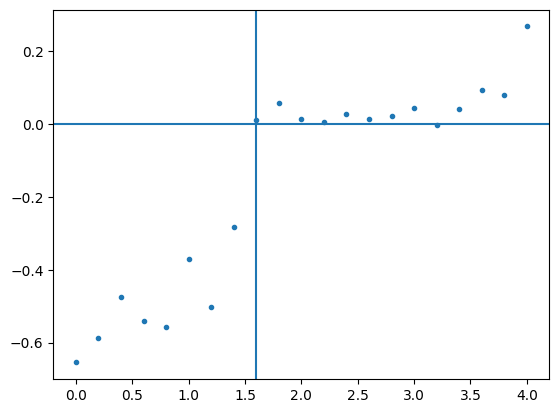

In [2873]:
KK = df['K'].to_numpy()
K_mean =np.nanmean(KK,axis=0)
K_std =np.nanstd(KK,axis=0)
plt.plot(Ks,K_mean-Ks,'.')
# plt.ylim(-1,1)
# plt.fill_between(Ks,K_mean-K_std,K_mean+K_std,alpha=0.3)
# plt.plot(Ks,Ks)
plt.axhline(0)
plt.axvline(K_c)

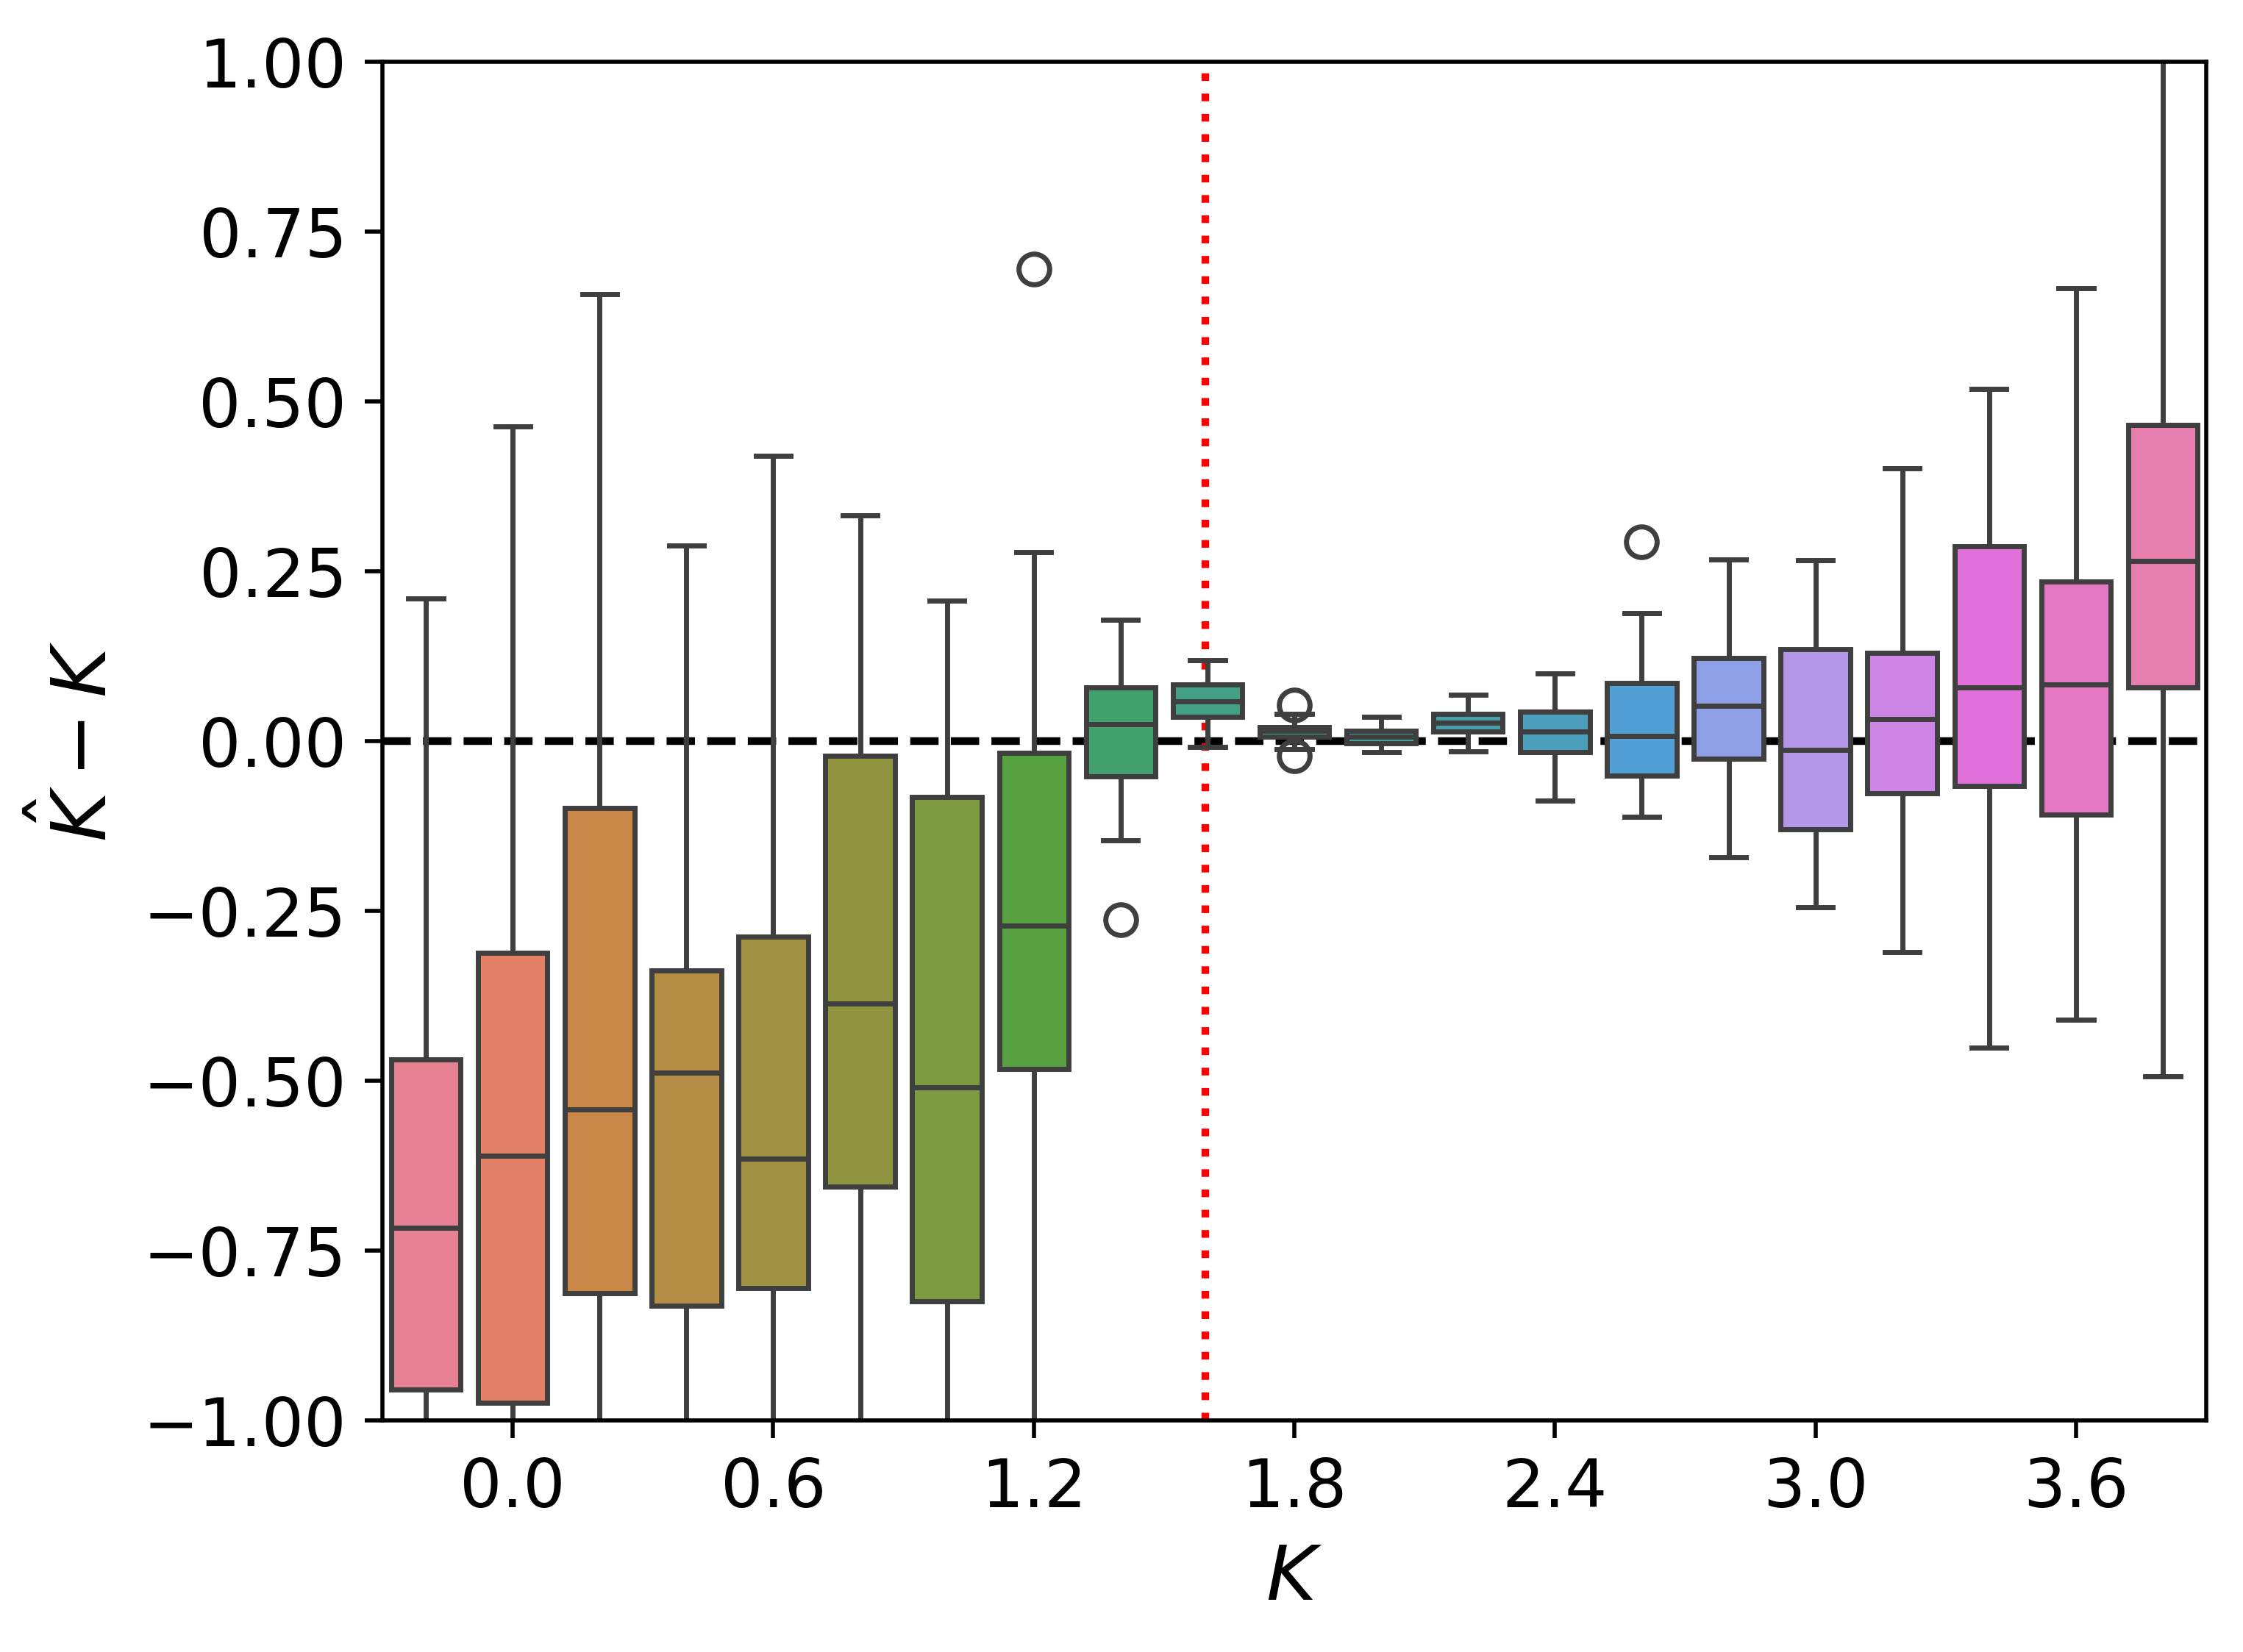

In [2874]:
# plt.plot(Ks,(KK-Ks).T,'.');
plt.figure(dpi=500)
sns.boxplot(data=(KK-Ks))
plt.xticks((np.arange(21)+1)[::3],[0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6])
plt.axhline(0,zorder=-10,ls='--',color='black')
plt.axvline(K_c/0.2+1,zorder=-10,ls=':',color='red')
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$\hat{K} - K$',fontsize=15)
plt.ylim(-1,1)
# plt.title('Box plot of KK - Ks')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

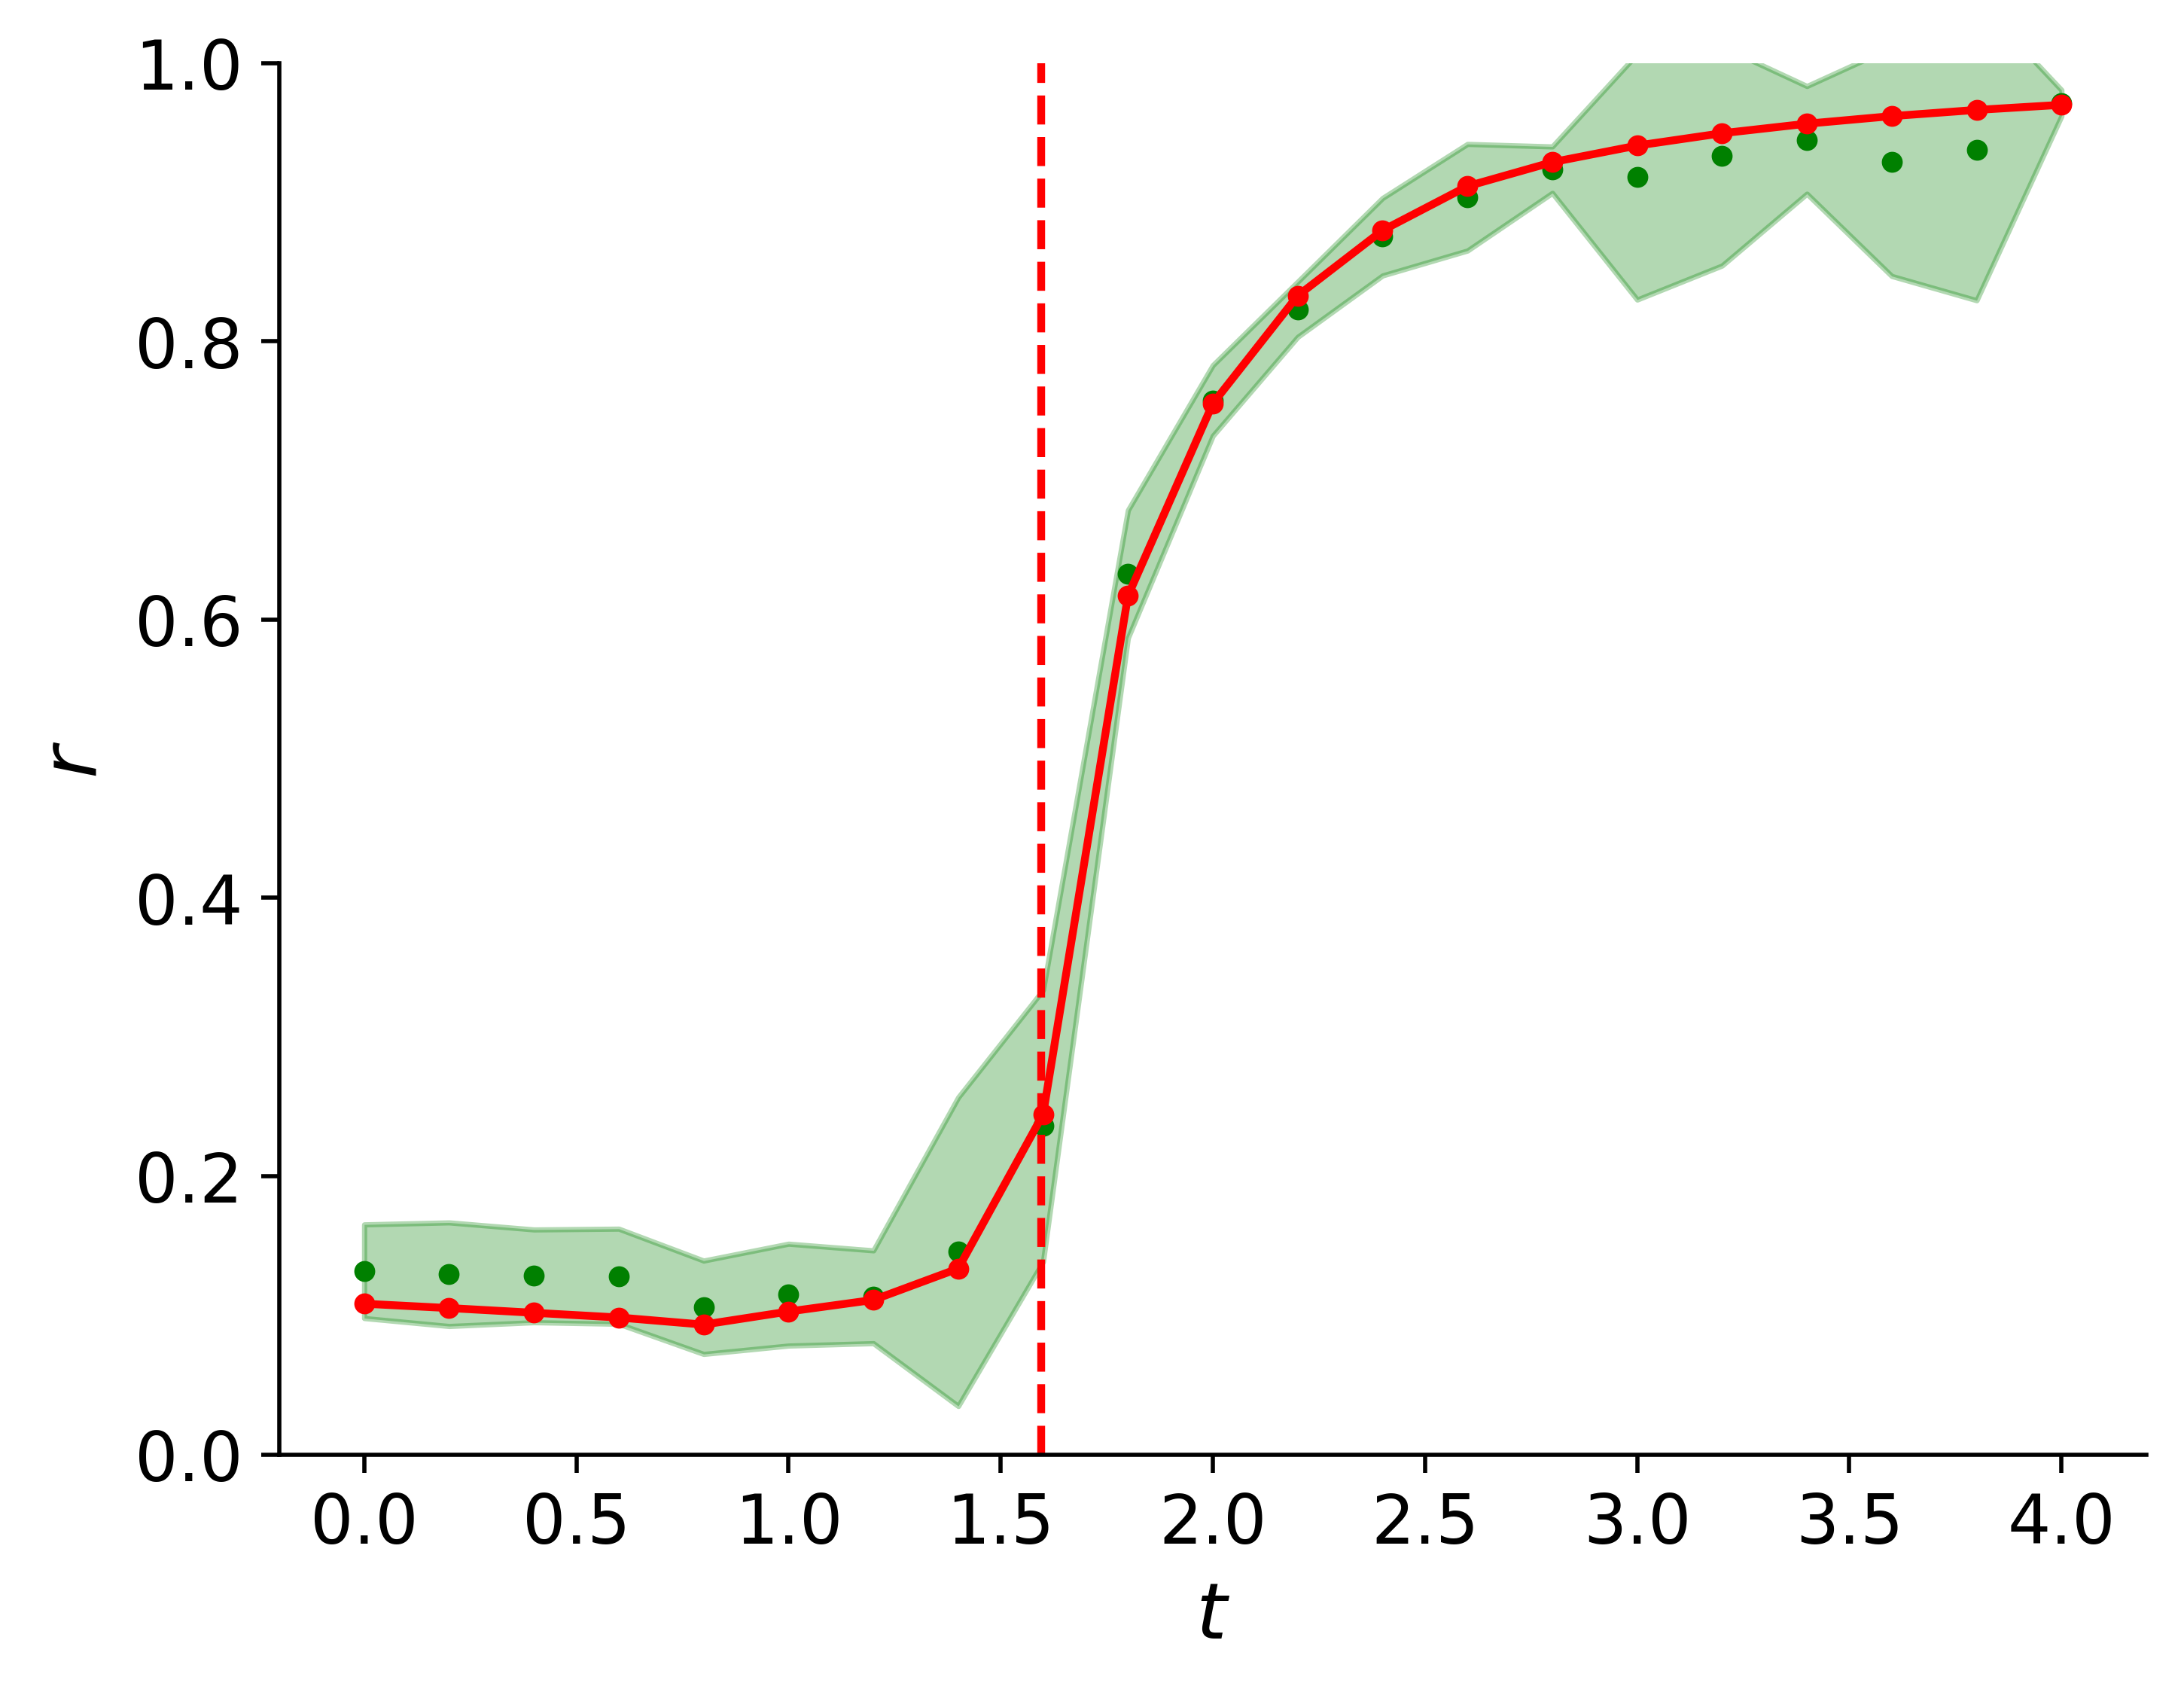

In [2875]:
plt.figure(dpi=500)
rr = df['r'].to_numpy()
r_mean =np.nanmean(rr,axis=0)
r_std =np.nanstd(rr,axis=0)
plt.plot(Ks,r_mean,'.',color='green')
plt.fill_between(Ks,r_mean-r_std,r_mean+r_std,alpha=0.3,color='green')
plt.plot(Ks,K_rs,'.-',color='red')
plt.ylim(0,1)
# plt.axhline(0)
plt.axvline(K_c,ls='--',color='red')

plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)